## Dependancy Management

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
!pip install pytorch-metric-learning


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import random_split, TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import itertools
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import nbformat
from torchmetrics.image import PeakSignalNoiseRatio
from torch.amp import autocast, GradScaler
from pytorch_metric_learning.samplers import MPerClassSampler
import glob
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Processing Pipeline

Labels shape: (610, 340)
Hypercube shape: (610, 340, 103)


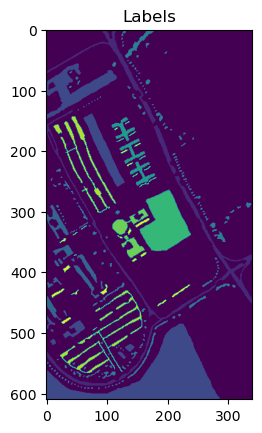

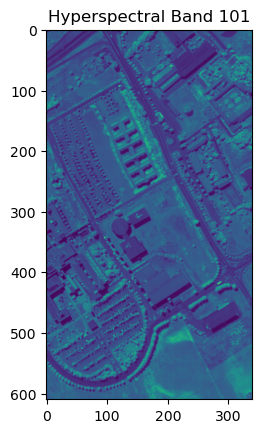

In [5]:
dataset_dir = r"C:\Users\vella\Documents\GitHub\FYP2425_LOCAL\FYP_DATASET"

gt_files = 'PaviaU_gt.mat'
data_files = 'PaviaU.mat'
label_files = 'paviaU_gt'
hypercube_files = 'paviaU'

def extract_Features():
    gt_file = os.path.join(dataset_dir, gt_files)
    data_file = os.path.join(dataset_dir, data_files)

    gt = sio.loadmat(gt_file)
    labels = gt[label_files]

    data = sio.loadmat(data_file)
    hypercube = data[hypercube_files]
    #scaling the data in place and setting to float32 to reduce memory usage
    max_value = np.max(hypercube)
    hypercube = (hypercube / max_value).astype(np.float32)


    #shapes of loaded data
    print(f"Labels shape: {labels.shape}")
    print(f"Hypercube shape: {hypercube.shape}")

    #visualisation of label map and a given band of hyperspectral data
    plt.figure()
    plt.imshow(labels)
    plt.title('Labels')

    band = 101
    plt.figure()
    plt.imshow(hypercube[:,:,band])
    plt.title(f'Hyperspectral Band {band}')
    plt.show()

    return hypercube, labels

hypercube, labels = extract_Features()

In [6]:
def extract_windows(data, labels, window_size):
    extract_windows_save_dir = 'extracted_windows_labels'
    if not os.path.exists(extract_windows_save_dir):
        os.makedirs(extract_windows_save_dir)
        print(f"Created directory: {extract_windows_save_dir}")

    margin = window_size // 2
    padded_data = np.pad(data, ((margin, margin), (margin, margin), (0, 0)), mode='constant')
    padded_labels = np.pad(labels, ((margin, margin), (margin, margin)), mode='constant')

    X_windows = []  #extracted windows
    y_labels = []   #corresponding labels

    print("Starting window extraction...")
    for i in range(margin, padded_data.shape[0] - margin):
        for j in range(margin, padded_data.shape[1] - margin):
            window = padded_data[i-margin:i+margin+1, j-margin:j+margin+1, :]
            label = padded_labels[i, j]

            if label != 0:
                #print('ignoring label 0 (background)')
                X_windows.append(window)
                y_labels.append(label)

    #convertying to numpy arrays
    X_windows = np.array(X_windows)
    y_labels = np.array(y_labels)

    #saving extracted windows and labels
    windows_file = os.path.join(extract_windows_save_dir, 'extracted_windows.npy')
    labels_file = os.path.join(extract_windows_save_dir, 'extracted_labels.npy')

    np.save(windows_file, X_windows)
    np.save(labels_file, y_labels)

    print(f"Saved extracted windows to: {windows_file}")
    print(f"Saved corresponding labels to: {labels_file}")
    print(f"\nTotal windows extracted: {len(X_windows)}")
    print(f"Extracted windows shape: {X_windows.shape}")
    print(f"Corresponding labels shape: {y_labels.shape}")

    return X_windows, y_labels

In [7]:
window_size = 5

X_windows, y_labels = extract_windows(hypercube, labels, window_size)

Created directory: extracted_windows_labels
Starting window extraction...


Saved extracted windows to: extracted_windows_labels\extracted_windows.npy
Saved corresponding labels to: extracted_windows_labels\extracted_labels.npy

Total windows extracted: 42776
Extracted windows shape: (42776, 5, 5, 103)
Corresponding labels shape: (42776,)


In [8]:
def get_samples(X_windows, y_labels, samples_per_class):
    
    indices_save_dir = 'indices'
    if not os.path.exists(indices_save_dir):
        os.makedirs(indices_save_dir)
        print(f"Created directory: {indices_save_dir}")
    
    #get unique classes
    classes = np.unique(y_labels)
    print(f"Unique classes found as: {classes}")

    #init lists
    X_sampled = [] #to store training samples
    y_sampled = [] #to store training labels

    X_val = [] # to store validation samples
    y_val = [] # to store validation labels

    selected_indices_total = [] #to store indices of selected training and validation samples
    validation_selected = [] #temp storage for validation indices
    validation_total = [] #to store all validation indices

    print("\n == STARTING SAMPLING PROCESS ==")
    for cls in classes:
        if cls == 0:
            print(f"!! SKIPPING CLASS 0 !!")
            continue

        #getting the indices for the current class:
        class_indices = np.where(y_labels == cls)[0]
        print(f"Class: {cls}: Found {len(class_indices)} samples")

        # shuffle class-specific indices to ensure randomness
        np.random.shuffle(class_indices)
        print(f"Shuffled class indices for class '{cls}'")

        #select 'samples_per_class' samples for training
        selected_indices = class_indices[:samples_per_class]
        #selecting 5 samples for validation
        validation_selected = class_indices[samples_per_class:samples_per_class+5]

        print(f"Selected {len(selected_indices)} training samples and {len(validation_selected)} validation samples for class '{cls}'\n")

        #store selected indices for training and validation
        selected_indices_total.extend(selected_indices)
        validation_total.extend(validation_selected)

        # appending the selected samples and their labels to the lists
        X_sampled.append(X_windows[selected_indices])
        y_sampled.append(y_labels[selected_indices])

        X_val.append(X_windows[validation_selected])
        y_val.append(y_labels[validation_selected])

    #concat the sampled arrays for training
    X_train = np.vstack(X_sampled)
    y_train = np.hstack(y_sampled)

    # shift labels to start from 0
    y_train = y_train - 1

    print(f"\n -- Training set created with: \n\t{X_train.shape[0]} samples\n\tshape {X_train.shape} --")

    #concat the sampled arrays for validation
    X_val = np.vstack(X_val)
    y_val = np.hstack(y_val)
    y_val = y_val - 1

    print(f"\n -- Validation set created with: \n\t{X_val.shape[0]} samples\n\tshape {X_val.shape} --")

    #create the test set from the remaining data (i.e. that which is not selected for training or validation)
    selected_indices_total.extend(validation_total)

    #getting indices not in the training or val sets
    test_indices = np.setdiff1d(np.arange(X_windows.shape[0]), selected_indices_total)
    X_test = X_windows[test_indices]
    y_test = y_labels[test_indices]
    y_test = y_test - 1

    print(f"\n -- Test set created with: \n\t{X_test.shape[0]} samples\n\tshape {X_test.shape} --\n")

    # Save the datasets to the 'datasets' folder
    np.save(os.path.join(indices_save_dir, 'X_train.npy'), X_train)
    np.save(os.path.join(indices_save_dir, 'y_train.npy'), y_train)
    np.save(os.path.join(indices_save_dir, 'X_val.npy'), X_val)
    np.save(os.path.join(indices_save_dir, 'y_val.npy'), y_val)
    np.save(os.path.join(indices_save_dir, 'X_test.npy'), X_test)
    np.save(os.path.join(indices_save_dir, 'y_test.npy'), y_test)

    print(f"\nAll datasets saved to the '{indices_save_dir}' folder.")

    #return the training, val, test sets + selected indices
    return X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total

In [9]:
X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total = get_samples(X_windows, y_labels, 5)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

Created directory: indices
Unique classes found as: [1 2 3 4 5 6 7 8 9]

 == STARTING SAMPLING PROCESS ==
Class: 1: Found 6631 samples
Shuffled class indices for class '1'
Selected 5 training samples and 5 validation samples for class '1'

Class: 2: Found 18649 samples
Shuffled class indices for class '2'
Selected 5 training samples and 5 validation samples for class '2'

Class: 3: Found 2099 samples
Shuffled class indices for class '3'
Selected 5 training samples and 5 validation samples for class '3'

Class: 4: Found 3064 samples
Shuffled class indices for class '4'
Selected 5 training samples and 5 validation samples for class '4'

Class: 5: Found 1345 samples
Shuffled class indices for class '5'
Selected 5 training samples and 5 validation samples for class '5'

Class: 6: Found 5029 samples
Shuffled class indices for class '6'
Selected 5 training samples and 5 validation samples for class '6'

Class: 7: Found 1330 samples
Shuffled class indices for class '7'
Selected 5 training sam


All datasets saved to the 'indices' folder.
(45, 5, 5, 103)
(45, 5, 5, 103)
(42686, 5, 5, 103)


In [10]:
class HyperspectralDataset(Dataset):
    def __init__(self, X, y):
        """
        Args:
            X (numpy.ndarray): Hyperspectral data of shape (num_samples, height, width, num_bands).
            y (numpy.ndarray): Labels of shape (num_samples,).
        """
        #converting to pytorch tensor
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [11]:
#loading the saved datasets
X_train = np.load('indices/X_train.npy')
y_train = np.load('indices/y_train.npy')
X_val = np.load('indices/X_val.npy')
y_val = np.load('indices/y_val.npy')
X_test = np.load('indices/X_test.npy')
y_test = np.load('indices/y_test.npy')


#creating pytorch datasets
train_dataset = HyperspectralDataset(X_train, y_train)
val_dataset = HyperspectralDataset(X_val, y_val)
test_dataset = HyperspectralDataset(X_test, y_test)

m = 20
num_classes = len(np.unique(y_train))

#theoretical batch size calc
required_batch_size = m * num_classes  # 10 * 9 = 90

#ensuring batch size doesn't exceed training set size
if required_batch_size > len(train_dataset):
    #case 1: not enough samples - reduce m proportionally
    print("Case 1 applied")
    max_possible_m = len(train_dataset) // num_classes
    m = max(1, max_possible_m)
    batch_size_train = m * num_classes
else:
    #case 2: use full batch size
    print("Case 2 applied")
    batch_size_train = required_batch_size

sampler = MPerClassSampler(labels = y_train, m=m, batch_size = batch_size_train, length_before_new_iter = len(train_dataset))

#dataloaders
train_loader = DataLoader(train_dataset, batch_size = batch_size_train, sampler=sampler)

batch_size = 256
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

#class dist in first batch
for X_batch, y_batch in train_loader:
    unique, counts = np.unique(y_batch.numpy(), return_counts=True)
    print(f"Training batch size: {batch_size_train}")
    print("Class distribution in batch:", dict(zip(unique, counts)))
    break



Case 1 applied
DataLoaders created successfully!
Training batch size: 45
Class distribution in batch: {0: 5, 1: 5, 2: 5, 3: 5, 4: 5, 5: 5, 6: 5, 7: 5, 8: 5}


## Creating directory for saving model predictions

In [12]:
predictions_dir = 'model_predictions'
os.makedirs(predictions_dir, exist_ok=True)
print(f"Created dir: {predictions_dir}")

Created dir: model_predictions


## Creating the Dataset splits and Dataloaders for unsupervised tasks

In [13]:
X_train, X_val = train_test_split(X_windows, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: (34220, 5, 5, 103)
Validation data shape: (8556, 5, 5, 103)


In [14]:
class UnsupervisedDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)  #converting to pytorch tensor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [15]:
#creating datasets for unsupervised task
unsup_train_dataset = UnsupervisedDataset(X_train)
unsup_val_dataset = UnsupervisedDataset(X_val)

#dataloaders for unsupervised task
batch_size = 64
train_loader_cae = DataLoader(unsup_train_dataset, batch_size=batch_size, shuffle=True)
val_loader_cae = DataLoader(unsup_val_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

DataLoaders created successfully!


In [16]:
window_num_channels = X_windows.shape[3]
print(window_num_channels)

103


## Convolutional Autoencoder

In [17]:
class ConvAutoEncode(nn.Module):
    def __init__(self, dropout_prob=0.1):
        super(ConvAutoEncode, self).__init__()

        #encoder
        self.encoder = nn.Sequential(
            #Block 1
            nn.Conv2d(window_num_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            #Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            #Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(64, window_num_channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


LOG: Epoch [1/50]


	 Training Batch [1/535], Loss: 0.1185, PSNR: 5.4780


	 Training Batch [200/535], Loss: 0.0652, PSNR: 8.8031


	 Training Batch [400/535], Loss: 0.0278, PSNR: 15.5574


Epoch [1/50] Training Loss: 0.0562, PSNR: 11.1459
	[Val]   Batch [1/134] Loss: 0.0192, PSNR: 15.3531
	[Val]   Batch [10/134] Loss: 0.0169, PSNR: 17.7209
	[Val]   Batch [20/134] Loss: 0.0181, PSNR: 15.5325
	[Val]   Batch [30/134] Loss: 0.0197, PSNR: 14.9779
	[Val]   Batch [40/134] Loss: 0.0178, PSNR: 14.0316
	[Val]   Batch [50/134] Loss: 0.0190, PSNR: 15.1915


	[Val]   Batch [60/134] Loss: 0.0171, PSNR: 15.8652
	[Val]   Batch [70/134] Loss: 0.0163, PSNR: 16.0434
	[Val]   Batch [80/134] Loss: 0.0160, PSNR: 16.0373
	[Val]   Batch [90/134] Loss: 0.0168, PSNR: 16.0240
	[Val]   Batch [100/134] Loss: 0.0190, PSNR: 15.4214
	[Val]   Batch [110/134] Loss: 0.0193, PSNR: 13.9575
	[Val]   Batch [120/134] Loss: 0.0158, PSNR: 15.1244
	[Val]   Batch [130/134] Loss: 0.0174, PSNR: 13.1418
Epoch [1/50] Validation Loss: 0.0181, PSNR: 15.3899

LOG: Epoch [2/50]


	 Training Batch [1/535], Loss: 0.0168, PSNR: 17.7431


	 Training Batch [200/535], Loss: 0.0138, PSNR: 16.5809


	 Training Batch [400/535], Loss: 0.0084, PSNR: 18.8673


Epoch [2/50] Training Loss: 0.0119, PSNR: 17.3669
	[Val]   Batch [1/134] Loss: 0.0089, PSNR: 18.6847
	[Val]   Batch [10/134] Loss: 0.0071, PSNR: 21.4641
	[Val]   Batch [20/134] Loss: 0.0077, PSNR: 19.2126
	[Val]   Batch [30/134] Loss: 0.0088, PSNR: 18.4669
	[Val]   Batch [40/134] Loss: 0.0079, PSNR: 17.5687
	[Val]   Batch [50/134] Loss: 0.0082, PSNR: 18.8129
	[Val]   Batch [60/134] Loss: 0.0072, PSNR: 19.6544
	[Val]   Batch [70/134] Loss: 0.0070, PSNR: 19.7420


	[Val]   Batch [80/134] Loss: 0.0066, PSNR: 19.8488
	[Val]   Batch [90/134] Loss: 0.0071, PSNR: 19.7692
	[Val]   Batch [100/134] Loss: 0.0085, PSNR: 18.9028
	[Val]   Batch [110/134] Loss: 0.0081, PSNR: 17.7360
	[Val]   Batch [120/134] Loss: 0.0059, PSNR: 19.3628
	[Val]   Batch [130/134] Loss: 0.0072, PSNR: 16.9575
Epoch [2/50] Validation Loss: 0.0080, PSNR: 18.9490

LOG: Epoch [3/50]
	 Training Batch [1/535], Loss: 0.0090, PSNR: 18.6269


	 Training Batch [200/535], Loss: 0.0067, PSNR: 20.1864


	 Training Batch [400/535], Loss: 0.0061, PSNR: 20.1945


Epoch [3/50] Training Loss: 0.0070, PSNR: 19.5296
	[Val]   Batch [1/134] Loss: 0.0064, PSNR: 20.1435
	[Val]   Batch [10/134] Loss: 0.0050, PSNR: 23.0248
	[Val]   Batch [20/134] Loss: 0.0054, PSNR: 20.7821
	[Val]   Batch [30/134] Loss: 0.0062, PSNR: 20.0362
	[Val]   Batch [40/134] Loss: 0.0056, PSNR: 19.0433
	[Val]   Batch [50/134] Loss: 0.0057, PSNR: 20.4121
	[Val]   Batch [60/134] Loss: 0.0049, PSNR: 21.3115
	[Val]   Batch [70/134] Loss: 0.0049, PSNR: 21.3124


	[Val]   Batch [80/134] Loss: 0.0046, PSNR: 21.4165
	[Val]   Batch [90/134] Loss: 0.0049, PSNR: 21.3615
	[Val]   Batch [100/134] Loss: 0.0060, PSNR: 20.4299
	[Val]   Batch [110/134] Loss: 0.0054, PSNR: 19.4451
	[Val]   Batch [120/134] Loss: 0.0038, PSNR: 21.2476
	[Val]   Batch [130/134] Loss: 0.0049, PSNR: 18.6226
Epoch [3/50] Validation Loss: 0.0057, PSNR: 20.4746

LOG: Epoch [4/50]
	 Training Batch [1/535], Loss: 0.0058, PSNR: 20.4946


	 Training Batch [200/535], Loss: 0.0059, PSNR: 20.4473


	 Training Batch [400/535], Loss: 0.0051, PSNR: 21.1589


Epoch [4/50] Training Loss: 0.0053, PSNR: 20.7598
	[Val]   Batch [1/134] Loss: 0.0047, PSNR: 21.4760
	[Val]   Batch [10/134] Loss: 0.0037, PSNR: 24.2897
	[Val]   Batch [20/134] Loss: 0.0039, PSNR: 22.2038
	[Val]   Batch [30/134] Loss: 0.0044, PSNR: 21.4867
	[Val]   Batch [40/134] Loss: 0.0041, PSNR: 20.4576
	[Val]   Batch [50/134] Loss: 0.0040, PSNR: 21.9511


	[Val]   Batch [60/134] Loss: 0.0036, PSNR: 22.5966
	[Val]   Batch [70/134] Loss: 0.0036, PSNR: 22.5960
	[Val]   Batch [80/134] Loss: 0.0034, PSNR: 22.7472
	[Val]   Batch [90/134] Loss: 0.0036, PSNR: 22.6905
	[Val]   Batch [100/134] Loss: 0.0044, PSNR: 21.7931
	[Val]   Batch [110/134] Loss: 0.0038, PSNR: 20.9940
	[Val]   Batch [120/134] Loss: 0.0027, PSNR: 22.7303


	[Val]   Batch [130/134] Loss: 0.0035, PSNR: 20.1619
Epoch [4/50] Validation Loss: 0.0042, PSNR: 21.8224

LOG: Epoch [5/50]
	 Training Batch [1/535], Loss: 0.0045, PSNR: 21.6878


	 Training Batch [200/535], Loss: 0.0050, PSNR: 21.0476


	 Training Batch [400/535], Loss: 0.0039, PSNR: 22.2573


Epoch [5/50] Training Loss: 0.0039, PSNR: 22.0893
	[Val]   Batch [1/134] Loss: 0.0034, PSNR: 22.8252
	[Val]   Batch [10/134] Loss: 0.0028, PSNR: 25.6033
	[Val]   Batch [20/134] Loss: 0.0027, PSNR: 23.7841
	[Val]   Batch [30/134] Loss: 0.0031, PSNR: 23.0295
	[Val]   Batch [40/134] Loss: 0.0028, PSNR: 22.0752
	[Val]   Batch [50/134] Loss: 0.0027, PSNR: 23.6290


	[Val]   Batch [60/134] Loss: 0.0028, PSNR: 23.7840
	[Val]   Batch [70/134] Loss: 0.0027, PSNR: 23.8936
	[Val]   Batch [80/134] Loss: 0.0025, PSNR: 24.0415
	[Val]   Batch [90/134] Loss: 0.0027, PSNR: 23.9965
	[Val]   Batch [100/134] Loss: 0.0032, PSNR: 23.2215
	[Val]   Batch [110/134] Loss: 0.0026, PSNR: 22.7094
	[Val]   Batch [120/134] Loss: 0.0019, PSNR: 24.2340
	[Val]   Batch [130/134] Loss: 0.0024, PSNR: 21.7709


Epoch [5/50] Validation Loss: 0.0030, PSNR: 23.2224

LOG: Epoch [6/50]
	 Training Batch [1/535], Loss: 0.0035, PSNR: 22.5589


	 Training Batch [200/535], Loss: 0.0034, PSNR: 24.6588


	 Training Batch [400/535], Loss: 0.0022, PSNR: 22.4981


Epoch [6/50] Training Loss: 0.0030, PSNR: 23.2088
	[Val]   Batch [1/134] Loss: 0.0028, PSNR: 23.7377
	[Val]   Batch [10/134] Loss: 0.0022, PSNR: 26.5506
	[Val]   Batch [20/134] Loss: 0.0021, PSNR: 24.9257
	[Val]   Batch [30/134] Loss: 0.0024, PSNR: 24.1589
	[Val]   Batch [40/134] Loss: 0.0021, PSNR: 23.2239
	[Val]   Batch [50/134] Loss: 0.0021, PSNR: 24.8312
	[Val]   Batch [60/134] Loss: 0.0023, PSNR: 24.6327


	[Val]   Batch [70/134] Loss: 0.0022, PSNR: 24.8021
	[Val]   Batch [80/134] Loss: 0.0020, PSNR: 24.9571
	[Val]   Batch [90/134] Loss: 0.0022, PSNR: 24.8730
	[Val]   Batch [100/134] Loss: 0.0025, PSNR: 24.2473
	[Val]   Batch [110/134] Loss: 0.0019, PSNR: 24.0395
	[Val]   Batch [120/134] Loss: 0.0015, PSNR: 25.3496
	[Val]   Batch [130/134] Loss: 0.0019, PSNR: 22.8494
Epoch [6/50] Validation Loss: 0.0024, PSNR: 24.2134

LOG: Epoch [7/50]
	 Training Batch [1/535], Loss: 0.0035, PSNR: 22.7090


	 Training Batch [200/535], Loss: 0.0031, PSNR: 25.0222


	 Training Batch [400/535], Loss: 0.0025, PSNR: 26.0154


Epoch [7/50] Training Loss: 0.0026, PSNR: 23.9250
	[Val]   Batch [1/134] Loss: 0.0024, PSNR: 24.4272
	[Val]   Batch [10/134] Loss: 0.0019, PSNR: 27.3006
	[Val]   Batch [20/134] Loss: 0.0017, PSNR: 25.8907
	[Val]   Batch [30/134] Loss: 0.0019, PSNR: 25.0416
	[Val]   Batch [40/134] Loss: 0.0017, PSNR: 24.1636
	[Val]   Batch [50/134] Loss: 0.0017, PSNR: 25.7611
	[Val]   Batch [60/134] Loss: 0.0019, PSNR: 25.3421


	[Val]   Batch [70/134] Loss: 0.0018, PSNR: 25.5388
	[Val]   Batch [80/134] Loss: 0.0017, PSNR: 25.7274
	[Val]   Batch [90/134] Loss: 0.0019, PSNR: 25.5640
	[Val]   Batch [100/134] Loss: 0.0021, PSNR: 25.0400
	[Val]   Batch [110/134] Loss: 0.0015, PSNR: 25.0987
	[Val]   Batch [120/134] Loss: 0.0012, PSNR: 26.3464
	[Val]   Batch [130/134] Loss: 0.0015, PSNR: 23.7603
Epoch [7/50] Validation Loss: 0.0020, PSNR: 25.0229

LOG: Epoch [8/50]
	 Training Batch [1/535], Loss: 0.0023, PSNR: 23.5434


	 Training Batch [200/535], Loss: 0.0026, PSNR: 25.8928


	 Training Batch [400/535], Loss: 0.0035, PSNR: 24.1199


Epoch [8/50] Training Loss: 0.0023, PSNR: 24.4360
	[Val]   Batch [1/134] Loss: 0.0022, PSNR: 24.8672
	[Val]   Batch [10/134] Loss: 0.0017, PSNR: 27.7846
	[Val]   Batch [20/134] Loss: 0.0014, PSNR: 26.5503
	[Val]   Batch [30/134] Loss: 0.0017, PSNR: 25.6230
	[Val]   Batch [40/134] Loss: 0.0015, PSNR: 24.8209
	[Val]   Batch [50/134] Loss: 0.0014, PSNR: 26.3694
	[Val]   Batch [60/134] Loss: 0.0017, PSNR: 25.8046


	[Val]   Batch [70/134] Loss: 0.0016, PSNR: 26.0213
	[Val]   Batch [80/134] Loss: 0.0015, PSNR: 26.2471
	[Val]   Batch [90/134] Loss: 0.0017, PSNR: 26.0258
	[Val]   Batch [100/134] Loss: 0.0018, PSNR: 25.5779
	[Val]   Batch [110/134] Loss: 0.0013, PSNR: 25.8040
	[Val]   Batch [120/134] Loss: 0.0010, PSNR: 27.0037
	[Val]   Batch [130/134] Loss: 0.0013, PSNR: 24.3346
Epoch [8/50] Validation Loss: 0.0018, PSNR: 25.5636

LOG: Epoch [9/50]
	 Training Batch [1/535], Loss: 0.0020, PSNR: 25.3347


	 Training Batch [200/535], Loss: 0.0017, PSNR: 27.4201


	 Training Batch [400/535], Loss: 0.0019, PSNR: 25.3887


Epoch [9/50] Training Loss: 0.0021, PSNR: 24.7822
	[Val]   Batch [1/134] Loss: 0.0020, PSNR: 25.1598
	[Val]   Batch [10/134] Loss: 0.0016, PSNR: 28.0423
	[Val]   Batch [20/134] Loss: 0.0013, PSNR: 26.9884
	[Val]   Batch [30/134] Loss: 0.0016, PSNR: 25.9586
	[Val]   Batch [40/134] Loss: 0.0014, PSNR: 25.2220
	[Val]   Batch [50/134] Loss: 0.0013, PSNR: 26.6890
	[Val]   Batch [60/134] Loss: 0.0016, PSNR: 26.0737


	[Val]   Batch [70/134] Loss: 0.0015, PSNR: 26.3042
	[Val]   Batch [80/134] Loss: 0.0014, PSNR: 26.5663
	[Val]   Batch [90/134] Loss: 0.0016, PSNR: 26.3097
	[Val]   Batch [100/134] Loss: 0.0017, PSNR: 25.8918
	[Val]   Batch [110/134] Loss: 0.0012, PSNR: 26.1739
	[Val]   Batch [120/134] Loss: 0.0009, PSNR: 27.3882
	[Val]   Batch [130/134] Loss: 0.0012, PSNR: 24.6440
Epoch [9/50] Validation Loss: 0.0017, PSNR: 25.8849

LOG: Epoch [10/50]
	 Training Batch [1/535], Loss: 0.0015, PSNR: 25.3152


	 Training Batch [200/535], Loss: 0.0025, PSNR: 23.9785


	 Training Batch [400/535], Loss: 0.0015, PSNR: 26.2511


Epoch [10/50] Training Loss: 0.0020, PSNR: 25.0772
	[Val]   Batch [1/134] Loss: 0.0019, PSNR: 25.4890
	[Val]   Batch [10/134] Loss: 0.0014, PSNR: 28.4028
	[Val]   Batch [20/134] Loss: 0.0012, PSNR: 27.4264
	[Val]   Batch [30/134] Loss: 0.0014, PSNR: 26.3857
	[Val]   Batch [40/134] Loss: 0.0012, PSNR: 25.6963
	[Val]   Batch [50/134] Loss: 0.0012, PSNR: 27.1147
	[Val]   Batch [60/134] Loss: 0.0015, PSNR: 26.4448
	[Val]   Batch [70/134] Loss: 0.0014, PSNR: 26.6604


	[Val]   Batch [80/134] Loss: 0.0013, PSNR: 26.9772
	[Val]   Batch [90/134] Loss: 0.0015, PSNR: 26.6340
	[Val]   Batch [100/134] Loss: 0.0016, PSNR: 26.2880
	[Val]   Batch [110/134] Loss: 0.0010, PSNR: 26.7009
	[Val]   Batch [120/134] Loss: 0.0008, PSNR: 27.8722
	[Val]   Batch [130/134] Loss: 0.0011, PSNR: 25.0571
Epoch [10/50] Validation Loss: 0.0015, PSNR: 26.2869

LOG: Epoch [11/50]
	 Training Batch [1/535], Loss: 0.0015, PSNR: 25.4062


	 Training Batch [200/535], Loss: 0.0015, PSNR: 24.6725


	 Training Batch [400/535], Loss: 0.0014, PSNR: 24.4762


Epoch [11/50] Training Loss: 0.0019, PSNR: 25.3331
	[Val]   Batch [1/134] Loss: 0.0018, PSNR: 25.6653
	[Val]   Batch [10/134] Loss: 0.0014, PSNR: 28.6159
	[Val]   Batch [20/134] Loss: 0.0011, PSNR: 27.7053
	[Val]   Batch [30/134] Loss: 0.0014, PSNR: 26.6043
	[Val]   Batch [40/134] Loss: 0.0011, PSNR: 25.9443
	[Val]   Batch [50/134] Loss: 0.0012, PSNR: 27.3485
	[Val]   Batch [60/134] Loss: 0.0014, PSNR: 26.6465


	[Val]   Batch [70/134] Loss: 0.0014, PSNR: 26.8357
	[Val]   Batch [80/134] Loss: 0.0012, PSNR: 27.1999
	[Val]   Batch [90/134] Loss: 0.0014, PSNR: 26.8496
	[Val]   Batch [100/134] Loss: 0.0015, PSNR: 26.5121
	[Val]   Batch [110/134] Loss: 0.0010, PSNR: 26.9532
	[Val]   Batch [120/134] Loss: 0.0008, PSNR: 28.1126
	[Val]   Batch [130/134] Loss: 0.0011, PSNR: 25.2639
Epoch [11/50] Validation Loss: 0.0015, PSNR: 26.5114

LOG: Epoch [12/50]
	 Training Batch [1/535], Loss: 0.0019, PSNR: 23.7584


	 Training Batch [200/535], Loss: 0.0015, PSNR: 26.7296


	 Training Batch [400/535], Loss: 0.0027, PSNR: 23.9133


Epoch [12/50] Training Loss: 0.0018, PSNR: 25.5397
	[Val]   Batch [1/134] Loss: 0.0017, PSNR: 25.9050
	[Val]   Batch [10/134] Loss: 0.0013, PSNR: 28.8695
	[Val]   Batch [20/134] Loss: 0.0010, PSNR: 28.0494
	[Val]   Batch [30/134] Loss: 0.0013, PSNR: 26.8967
	[Val]   Batch [40/134] Loss: 0.0011, PSNR: 26.2829
	[Val]   Batch [50/134] Loss: 0.0011, PSNR: 27.6292
	[Val]   Batch [60/134] Loss: 0.0013, PSNR: 26.9123


	[Val]   Batch [70/134] Loss: 0.0013, PSNR: 27.0960
	[Val]   Batch [80/134] Loss: 0.0011, PSNR: 27.5173
	[Val]   Batch [90/134] Loss: 0.0013, PSNR: 27.0983
	[Val]   Batch [100/134] Loss: 0.0014, PSNR: 26.7645
	[Val]   Batch [110/134] Loss: 0.0009, PSNR: 27.3262
	[Val]   Batch [120/134] Loss: 0.0007, PSNR: 28.4534
	[Val]   Batch [130/134] Loss: 0.0010, PSNR: 25.5857
Epoch [12/50] Validation Loss: 0.0014, PSNR: 26.7995

LOG: Epoch [13/50]
	 Training Batch [1/535], Loss: 0.0012, PSNR: 25.4770


	 Training Batch [200/535], Loss: 0.0011, PSNR: 27.3591


	 Training Batch [400/535], Loss: 0.0015, PSNR: 24.5142


Epoch [13/50] Training Loss: 0.0017, PSNR: 25.7996
	[Val]   Batch [1/134] Loss: 0.0016, PSNR: 26.0483
	[Val]   Batch [10/134] Loss: 0.0013, PSNR: 29.0214
	[Val]   Batch [20/134] Loss: 0.0010, PSNR: 28.1968
	[Val]   Batch [30/134] Loss: 0.0012, PSNR: 27.0694
	[Val]   Batch [40/134] Loss: 0.0010, PSNR: 26.4571
	[Val]   Batch [50/134] Loss: 0.0010, PSNR: 27.7916
	[Val]   Batch [60/134] Loss: 0.0013, PSNR: 27.0704


	[Val]   Batch [70/134] Loss: 0.0012, PSNR: 27.2480
	[Val]   Batch [80/134] Loss: 0.0011, PSNR: 27.7015
	[Val]   Batch [90/134] Loss: 0.0013, PSNR: 27.2559
	[Val]   Batch [100/134] Loss: 0.0013, PSNR: 26.9186
	[Val]   Batch [110/134] Loss: 0.0008, PSNR: 27.5153
	[Val]   Batch [120/134] Loss: 0.0007, PSNR: 28.6557
	[Val]   Batch [130/134] Loss: 0.0009, PSNR: 25.7744
Epoch [13/50] Validation Loss: 0.0013, PSNR: 26.9626

LOG: Epoch [14/50]
	 Training Batch [1/535], Loss: 0.0012, PSNR: 25.4393


	 Training Batch [200/535], Loss: 0.0020, PSNR: 26.0497


	 Training Batch [400/535], Loss: 0.0017, PSNR: 26.0494


Epoch [14/50] Training Loss: 0.0016, PSNR: 25.9225
	[Val]   Batch [1/134] Loss: 0.0016, PSNR: 26.2834
	[Val]   Batch [10/134] Loss: 0.0012, PSNR: 29.2549
	[Val]   Batch [20/134] Loss: 0.0009, PSNR: 28.5803
	[Val]   Batch [30/134] Loss: 0.0011, PSNR: 27.3431
	[Val]   Batch [40/134] Loss: 0.0009, PSNR: 26.7971
	[Val]   Batch [50/134] Loss: 0.0010, PSNR: 28.0950
	[Val]   Batch [60/134] Loss: 0.0012, PSNR: 27.3408


	[Val]   Batch [70/134] Loss: 0.0012, PSNR: 27.4830
	[Val]   Batch [80/134] Loss: 0.0010, PSNR: 27.9620
	[Val]   Batch [90/134] Loss: 0.0012, PSNR: 27.5189
	[Val]   Batch [100/134] Loss: 0.0013, PSNR: 27.1982
	[Val]   Batch [110/134] Loss: 0.0008, PSNR: 27.8657
	[Val]   Batch [120/134] Loss: 0.0007, PSNR: 28.9201
	[Val]   Batch [130/134] Loss: 0.0009, PSNR: 26.0752
Epoch [14/50] Validation Loss: 0.0012, PSNR: 27.2470

LOG: Epoch [15/50]
	 Training Batch [1/535], Loss: 0.0021, PSNR: 25.0412


	 Training Batch [200/535], Loss: 0.0020, PSNR: 27.0850


	 Training Batch [400/535], Loss: 0.0024, PSNR: 24.4327


Epoch [15/50] Training Loss: 0.0016, PSNR: 26.1372
	[Val]   Batch [1/134] Loss: 0.0015, PSNR: 26.4816
	[Val]   Batch [10/134] Loss: 0.0011, PSNR: 29.4550
	[Val]   Batch [20/134] Loss: 0.0008, PSNR: 28.8601
	[Val]   Batch [30/134] Loss: 0.0011, PSNR: 27.6022
	[Val]   Batch [40/134] Loss: 0.0009, PSNR: 27.0775
	[Val]   Batch [50/134] Loss: 0.0009, PSNR: 28.3354


	[Val]   Batch [60/134] Loss: 0.0012, PSNR: 27.5772
	[Val]   Batch [70/134] Loss: 0.0011, PSNR: 27.7159
	[Val]   Batch [80/134] Loss: 0.0010, PSNR: 28.2069
	[Val]   Batch [90/134] Loss: 0.0011, PSNR: 27.7386
	[Val]   Batch [100/134] Loss: 0.0012, PSNR: 27.4196
	[Val]   Batch [110/134] Loss: 0.0007, PSNR: 28.1580
	[Val]   Batch [120/134] Loss: 0.0006, PSNR: 29.2170


	[Val]   Batch [130/134] Loss: 0.0008, PSNR: 26.3911
Epoch [15/50] Validation Loss: 0.0012, PSNR: 27.4905

LOG: Epoch [16/50]
	 Training Batch [1/535], Loss: 0.0024, PSNR: 24.3655


	 Training Batch [200/535], Loss: 0.0023, PSNR: 24.5738


	 Training Batch [400/535], Loss: 0.0016, PSNR: 26.2370


Epoch [16/50] Training Loss: 0.0015, PSNR: 26.2693
	[Val]   Batch [1/134] Loss: 0.0014, PSNR: 26.5966
	[Val]   Batch [10/134] Loss: 0.0011, PSNR: 29.5485
	[Val]   Batch [20/134] Loss: 0.0008, PSNR: 29.0090
	[Val]   Batch [30/134] Loss: 0.0010, PSNR: 27.7360
	[Val]   Batch [40/134] Loss: 0.0009, PSNR: 27.1601
	[Val]   Batch [50/134] Loss: 0.0009, PSNR: 28.4337
	[Val]   Batch [60/134] Loss: 0.0011, PSNR: 27.6922


	[Val]   Batch [70/134] Loss: 0.0011, PSNR: 27.8150
	[Val]   Batch [80/134] Loss: 0.0009, PSNR: 28.3700
	[Val]   Batch [90/134] Loss: 0.0011, PSNR: 27.8768
	[Val]   Batch [100/134] Loss: 0.0012, PSNR: 27.5464
	[Val]   Batch [110/134] Loss: 0.0007, PSNR: 28.2594
	[Val]   Batch [120/134] Loss: 0.0006, PSNR: 29.2799
	[Val]   Batch [130/134] Loss: 0.0008, PSNR: 26.4533
Epoch [16/50] Validation Loss: 0.0011, PSNR: 27.6043

LOG: Epoch [17/50]
	 Training Batch [1/535], Loss: 0.0015, PSNR: 26.6136


	 Training Batch [200/535], Loss: 0.0012, PSNR: 27.2358


	 Training Batch [400/535], Loss: 0.0014, PSNR: 26.3823


Epoch [17/50] Training Loss: 0.0015, PSNR: 26.4029
	[Val]   Batch [1/134] Loss: 0.0014, PSNR: 26.8250
	[Val]   Batch [10/134] Loss: 0.0011, PSNR: 29.7506
	[Val]   Batch [20/134] Loss: 0.0008, PSNR: 29.3084
	[Val]   Batch [30/134] Loss: 0.0010, PSNR: 27.9848
	[Val]   Batch [40/134] Loss: 0.0008, PSNR: 27.4363
	[Val]   Batch [50/134] Loss: 0.0008, PSNR: 28.6917
	[Val]   Batch [60/134] Loss: 0.0011, PSNR: 27.9362


	[Val]   Batch [70/134] Loss: 0.0010, PSNR: 28.0472
	[Val]   Batch [80/134] Loss: 0.0009, PSNR: 28.6245
	[Val]   Batch [90/134] Loss: 0.0010, PSNR: 28.1155
	[Val]   Batch [100/134] Loss: 0.0011, PSNR: 27.7738
	[Val]   Batch [110/134] Loss: 0.0007, PSNR: 28.5340
	[Val]   Batch [120/134] Loss: 0.0006, PSNR: 29.5503
	[Val]   Batch [130/134] Loss: 0.0008, PSNR: 26.7136
Epoch [17/50] Validation Loss: 0.0011, PSNR: 27.8519

LOG: Epoch [18/50]


	 Training Batch [1/535], Loss: 0.0016, PSNR: 26.0331


	 Training Batch [200/535], Loss: 0.0019, PSNR: 27.3131


	 Training Batch [400/535], Loss: 0.0020, PSNR: 25.1619


Epoch [18/50] Training Loss: 0.0014, PSNR: 26.5296
	[Val]   Batch [1/134] Loss: 0.0013, PSNR: 26.9733
	[Val]   Batch [10/134] Loss: 0.0010, PSNR: 29.8410
	[Val]   Batch [20/134] Loss: 0.0007, PSNR: 29.4565
	[Val]   Batch [30/134] Loss: 0.0010, PSNR: 28.1175
	[Val]   Batch [40/134] Loss: 0.0008, PSNR: 27.6203
	[Val]   Batch [50/134] Loss: 0.0008, PSNR: 28.8041
	[Val]   Batch [60/134] Loss: 0.0010, PSNR: 28.1056


	[Val]   Batch [70/134] Loss: 0.0010, PSNR: 28.2436
	[Val]   Batch [80/134] Loss: 0.0009, PSNR: 28.7745
	[Val]   Batch [90/134] Loss: 0.0010, PSNR: 28.2661
	[Val]   Batch [100/134] Loss: 0.0011, PSNR: 27.9135
	[Val]   Batch [110/134] Loss: 0.0007, PSNR: 28.5736
	[Val]   Batch [120/134] Loss: 0.0006, PSNR: 29.6298
	[Val]   Batch [130/134] Loss: 0.0007, PSNR: 26.8782
Epoch [18/50] Validation Loss: 0.0010, PSNR: 27.9918

LOG: Epoch [19/50]
	 Training Batch [1/535], Loss: 0.0009, PSNR: 26.2931


	 Training Batch [200/535], Loss: 0.0013, PSNR: 28.7359


	 Training Batch [400/535], Loss: 0.0014, PSNR: 26.8393


Epoch [19/50] Training Loss: 0.0014, PSNR: 26.7211
	[Val]   Batch [1/134] Loss: 0.0012, PSNR: 27.2306
	[Val]   Batch [10/134] Loss: 0.0010, PSNR: 30.0510
	[Val]   Batch [20/134] Loss: 0.0007, PSNR: 29.8542
	[Val]   Batch [30/134] Loss: 0.0009, PSNR: 28.4788
	[Val]   Batch [40/134] Loss: 0.0007, PSNR: 27.9546
	[Val]   Batch [50/134] Loss: 0.0008, PSNR: 29.1354
	[Val]   Batch [60/134] Loss: 0.0009, PSNR: 28.4365


	[Val]   Batch [70/134] Loss: 0.0009, PSNR: 28.5156
	[Val]   Batch [80/134] Loss: 0.0008, PSNR: 29.0983
	[Val]   Batch [90/134] Loss: 0.0009, PSNR: 28.5829
	[Val]   Batch [100/134] Loss: 0.0010, PSNR: 28.2338
	[Val]   Batch [110/134] Loss: 0.0006, PSNR: 28.9848
	[Val]   Batch [120/134] Loss: 0.0005, PSNR: 29.9322
	[Val]   Batch [130/134] Loss: 0.0007, PSNR: 27.2244
Epoch [19/50] Validation Loss: 0.0010, PSNR: 28.3036

LOG: Epoch [20/50]
	 Training Batch [1/535], Loss: 0.0014, PSNR: 27.6988


	 Training Batch [200/535], Loss: 0.0010, PSNR: 27.9835


	 Training Batch [400/535], Loss: 0.0016, PSNR: 26.1055


Epoch [20/50] Training Loss: 0.0013, PSNR: 26.9148
	[Val]   Batch [1/134] Loss: 0.0012, PSNR: 27.4090
	[Val]   Batch [10/134] Loss: 0.0010, PSNR: 30.1659
	[Val]   Batch [20/134] Loss: 0.0006, PSNR: 30.0300
	[Val]   Batch [30/134] Loss: 0.0008, PSNR: 28.6437
	[Val]   Batch [40/134] Loss: 0.0007, PSNR: 28.1074
	[Val]   Batch [50/134] Loss: 0.0007, PSNR: 29.2340
	[Val]   Batch [60/134] Loss: 0.0009, PSNR: 28.6379


	[Val]   Batch [70/134] Loss: 0.0009, PSNR: 28.7255
	[Val]   Batch [80/134] Loss: 0.0008, PSNR: 29.2971
	[Val]   Batch [90/134] Loss: 0.0009, PSNR: 28.7659
	[Val]   Batch [100/134] Loss: 0.0010, PSNR: 28.4019
	[Val]   Batch [110/134] Loss: 0.0006, PSNR: 28.9748
	[Val]   Batch [120/134] Loss: 0.0005, PSNR: 29.9785
	[Val]   Batch [130/134] Loss: 0.0007, PSNR: 27.3334
Epoch [20/50] Validation Loss: 0.0009, PSNR: 28.4569

LOG: Epoch [21/50]
	 Training Batch [1/535], Loss: 0.0017, PSNR: 26.0343


	 Training Batch [200/535], Loss: 0.0011, PSNR: 27.7392


	 Training Batch [400/535], Loss: 0.0011, PSNR: 27.8863


Epoch [21/50] Training Loss: 0.0013, PSNR: 27.0709
	[Val]   Batch [1/134] Loss: 0.0011, PSNR: 27.6460
	[Val]   Batch [10/134] Loss: 0.0009, PSNR: 30.3758
	[Val]   Batch [20/134] Loss: 0.0006, PSNR: 30.3202
	[Val]   Batch [30/134] Loss: 0.0008, PSNR: 28.9004
	[Val]   Batch [40/134] Loss: 0.0006, PSNR: 28.4401
	[Val]   Batch [50/134] Loss: 0.0007, PSNR: 29.4997
	[Val]   Batch [60/134] Loss: 0.0008, PSNR: 28.9431


	[Val]   Batch [70/134] Loss: 0.0008, PSNR: 29.0462
	[Val]   Batch [80/134] Loss: 0.0007, PSNR: 29.5157
	[Val]   Batch [90/134] Loss: 0.0008, PSNR: 29.0714
	[Val]   Batch [100/134] Loss: 0.0009, PSNR: 28.6777
	[Val]   Batch [110/134] Loss: 0.0006, PSNR: 29.1578
	[Val]   Batch [120/134] Loss: 0.0005, PSNR: 30.1188
	[Val]   Batch [130/134] Loss: 0.0006, PSNR: 27.6272
Epoch [21/50] Validation Loss: 0.0009, PSNR: 28.7177

LOG: Epoch [22/50]
	 Training Batch [1/535], Loss: 0.0013, PSNR: 26.9143


	 Training Batch [200/535], Loss: 0.0012, PSNR: 27.3250


	 Training Batch [400/535], Loss: 0.0013, PSNR: 27.0867


Epoch [22/50] Training Loss: 0.0012, PSNR: 27.2435
	[Val]   Batch [1/134] Loss: 0.0011, PSNR: 27.9322
	[Val]   Batch [10/134] Loss: 0.0009, PSNR: 30.5853
	[Val]   Batch [20/134] Loss: 0.0006, PSNR: 30.6000
	[Val]   Batch [30/134] Loss: 0.0007, PSNR: 29.2082
	[Val]   Batch [40/134] Loss: 0.0006, PSNR: 28.6707
	[Val]   Batch [50/134] Loss: 0.0007, PSNR: 29.7953
	[Val]   Batch [60/134] Loss: 0.0008, PSNR: 29.2198
	[Val]   Batch [70/134] Loss: 0.0008, PSNR: 29.3199


	[Val]   Batch [80/134] Loss: 0.0007, PSNR: 29.8507
	[Val]   Batch [90/134] Loss: 0.0008, PSNR: 29.3910
	[Val]   Batch [100/134] Loss: 0.0008, PSNR: 28.9762
	[Val]   Batch [110/134] Loss: 0.0006, PSNR: 29.3426
	[Val]   Batch [120/134] Loss: 0.0005, PSNR: 30.2714
	[Val]   Batch [130/134] Loss: 0.0006, PSNR: 27.8488
Epoch [22/50] Validation Loss: 0.0008, PSNR: 28.9852

LOG: Epoch [23/50]
	 Training Batch [1/535], Loss: 0.0015, PSNR: 28.1545


	 Training Batch [200/535], Loss: 0.0008, PSNR: 27.7273


	 Training Batch [400/535], Loss: 0.0014, PSNR: 27.5859


Epoch [23/50] Training Loss: 0.0012, PSNR: 27.3980
	[Val]   Batch [1/134] Loss: 0.0010, PSNR: 28.2901
	[Val]   Batch [10/134] Loss: 0.0008, PSNR: 30.8265
	[Val]   Batch [20/134] Loss: 0.0005, PSNR: 30.8925
	[Val]   Batch [30/134] Loss: 0.0007, PSNR: 29.5699
	[Val]   Batch [40/134] Loss: 0.0006, PSNR: 28.9741
	[Val]   Batch [50/134] Loss: 0.0006, PSNR: 30.0880


	[Val]   Batch [60/134] Loss: 0.0007, PSNR: 29.5426
	[Val]   Batch [70/134] Loss: 0.0007, PSNR: 29.6609
	[Val]   Batch [80/134] Loss: 0.0006, PSNR: 30.1793
	[Val]   Batch [90/134] Loss: 0.0007, PSNR: 29.7468
	[Val]   Batch [100/134] Loss: 0.0008, PSNR: 29.3050
	[Val]   Batch [110/134] Loss: 0.0005, PSNR: 29.5265
	[Val]   Batch [120/134] Loss: 0.0005, PSNR: 30.4483


	[Val]   Batch [130/134] Loss: 0.0005, PSNR: 28.1569
Epoch [23/50] Validation Loss: 0.0008, PSNR: 29.3029

LOG: Epoch [24/50]
	 Training Batch [1/535], Loss: 0.0009, PSNR: 28.3776


	 Training Batch [200/535], Loss: 0.0012, PSNR: 27.3797


	 Training Batch [400/535], Loss: 0.0013, PSNR: 27.1264


Epoch [24/50] Training Loss: 0.0011, PSNR: 27.6435
	[Val]   Batch [1/134] Loss: 0.0009, PSNR: 28.5226
	[Val]   Batch [10/134] Loss: 0.0008, PSNR: 31.0421
	[Val]   Batch [20/134] Loss: 0.0005, PSNR: 31.0935
	[Val]   Batch [30/134] Loss: 0.0006, PSNR: 29.8723
	[Val]   Batch [40/134] Loss: 0.0005, PSNR: 29.1934
	[Val]   Batch [50/134] Loss: 0.0006, PSNR: 30.3359
	[Val]   Batch [60/134] Loss: 0.0007, PSNR: 29.8190


	[Val]   Batch [70/134] Loss: 0.0007, PSNR: 29.9474
	[Val]   Batch [80/134] Loss: 0.0006, PSNR: 30.3837
	[Val]   Batch [90/134] Loss: 0.0007, PSNR: 30.0407
	[Val]   Batch [100/134] Loss: 0.0007, PSNR: 29.6010
	[Val]   Batch [110/134] Loss: 0.0005, PSNR: 29.6382
	[Val]   Batch [120/134] Loss: 0.0005, PSNR: 30.5539
	[Val]   Batch [130/134] Loss: 0.0005, PSNR: 28.3280


Epoch [24/50] Validation Loss: 0.0007, PSNR: 29.5371

LOG: Epoch [25/50]
	 Training Batch [1/535], Loss: 0.0009, PSNR: 26.7423


	 Training Batch [200/535], Loss: 0.0016, PSNR: 27.1354


	 Training Batch [400/535], Loss: 0.0014, PSNR: 28.1655


Epoch [25/50] Training Loss: 0.0011, PSNR: 27.8307
	[Val]   Batch [1/134] Loss: 0.0009, PSNR: 28.8282
	[Val]   Batch [10/134] Loss: 0.0007, PSNR: 31.2661
	[Val]   Batch [20/134] Loss: 0.0005, PSNR: 31.3215
	[Val]   Batch [30/134] Loss: 0.0006, PSNR: 30.1867
	[Val]   Batch [40/134] Loss: 0.0005, PSNR: 29.4385
	[Val]   Batch [50/134] Loss: 0.0005, PSNR: 30.6138
	[Val]   Batch [60/134] Loss: 0.0007, PSNR: 30.0626


	[Val]   Batch [70/134] Loss: 0.0006, PSNR: 30.2386
	[Val]   Batch [80/134] Loss: 0.0006, PSNR: 30.6342
	[Val]   Batch [90/134] Loss: 0.0006, PSNR: 30.3591
	[Val]   Batch [100/134] Loss: 0.0007, PSNR: 29.9047
	[Val]   Batch [110/134] Loss: 0.0005, PSNR: 29.8250
	[Val]   Batch [120/134] Loss: 0.0004, PSNR: 30.6749
	[Val]   Batch [130/134] Loss: 0.0005, PSNR: 28.5555
Epoch [25/50] Validation Loss: 0.0007, PSNR: 29.8168

LOG: Epoch [26/50]


	 Training Batch [1/535], Loss: 0.0010, PSNR: 27.8941


	 Training Batch [200/535], Loss: 0.0011, PSNR: 27.7369


	 Training Batch [400/535], Loss: 0.0009, PSNR: 28.3476


Epoch [26/50] Training Loss: 0.0010, PSNR: 27.9799
	[Val]   Batch [1/134] Loss: 0.0008, PSNR: 29.0826
	[Val]   Batch [10/134] Loss: 0.0007, PSNR: 31.4498
	[Val]   Batch [20/134] Loss: 0.0005, PSNR: 31.5037
	[Val]   Batch [30/134] Loss: 0.0006, PSNR: 30.4254
	[Val]   Batch [40/134] Loss: 0.0005, PSNR: 29.5533
	[Val]   Batch [50/134] Loss: 0.0005, PSNR: 30.8690
	[Val]   Batch [60/134] Loss: 0.0006, PSNR: 30.2357


	[Val]   Batch [70/134] Loss: 0.0006, PSNR: 30.4453
	[Val]   Batch [80/134] Loss: 0.0005, PSNR: 30.7997
	[Val]   Batch [90/134] Loss: 0.0006, PSNR: 30.5959
	[Val]   Batch [100/134] Loss: 0.0006, PSNR: 30.1689
	[Val]   Batch [110/134] Loss: 0.0005, PSNR: 29.8976
	[Val]   Batch [120/134] Loss: 0.0004, PSNR: 30.7819
	[Val]   Batch [130/134] Loss: 0.0005, PSNR: 28.6417
Epoch [26/50] Validation Loss: 0.0006, PSNR: 30.0228

LOG: Epoch [27/50]
	 Training Batch [1/535], Loss: 0.0009, PSNR: 26.8385


	 Training Batch [200/535], Loss: 0.0012, PSNR: 27.4321


	 Training Batch [400/535], Loss: 0.0013, PSNR: 28.4450


Epoch [27/50] Training Loss: 0.0010, PSNR: 28.1528
	[Val]   Batch [1/134] Loss: 0.0008, PSNR: 29.3119
	[Val]   Batch [10/134] Loss: 0.0007, PSNR: 31.6368
	[Val]   Batch [20/134] Loss: 0.0004, PSNR: 31.6503
	[Val]   Batch [30/134] Loss: 0.0005, PSNR: 30.6544
	[Val]   Batch [40/134] Loss: 0.0005, PSNR: 29.6698
	[Val]   Batch [50/134] Loss: 0.0005, PSNR: 31.0019
	[Val]   Batch [60/134] Loss: 0.0006, PSNR: 30.4094


	[Val]   Batch [70/134] Loss: 0.0006, PSNR: 30.6711
	[Val]   Batch [80/134] Loss: 0.0005, PSNR: 30.9529
	[Val]   Batch [90/134] Loss: 0.0006, PSNR: 30.8068
	[Val]   Batch [100/134] Loss: 0.0006, PSNR: 30.3638
	[Val]   Batch [110/134] Loss: 0.0005, PSNR: 30.0183
	[Val]   Batch [120/134] Loss: 0.0004, PSNR: 30.8884
	[Val]   Batch [130/134] Loss: 0.0005, PSNR: 28.7528
Epoch [27/50] Validation Loss: 0.0006, PSNR: 30.2036

LOG: Epoch [28/50]
	 Training Batch [1/535], Loss: 0.0007, PSNR: 27.8100


	 Training Batch [200/535], Loss: 0.0009, PSNR: 28.4951


	 Training Batch [400/535], Loss: 0.0016, PSNR: 27.4511


Epoch [28/50] Training Loss: 0.0010, PSNR: 28.2951
	[Val]   Batch [1/134] Loss: 0.0007, PSNR: 29.5591
	[Val]   Batch [10/134] Loss: 0.0007, PSNR: 31.7579
	[Val]   Batch [20/134] Loss: 0.0004, PSNR: 31.6851
	[Val]   Batch [30/134] Loss: 0.0005, PSNR: 30.7573
	[Val]   Batch [40/134] Loss: 0.0005, PSNR: 29.6907
	[Val]   Batch [50/134] Loss: 0.0005, PSNR: 31.0987
	[Val]   Batch [60/134] Loss: 0.0006, PSNR: 30.5178


	[Val]   Batch [70/134] Loss: 0.0005, PSNR: 30.8361
	[Val]   Batch [80/134] Loss: 0.0005, PSNR: 31.0334
	[Val]   Batch [90/134] Loss: 0.0005, PSNR: 30.9723
	[Val]   Batch [100/134] Loss: 0.0006, PSNR: 30.5086
	[Val]   Batch [110/134] Loss: 0.0005, PSNR: 29.9608
	[Val]   Batch [120/134] Loss: 0.0004, PSNR: 30.9009
	[Val]   Batch [130/134] Loss: 0.0005, PSNR: 28.8084
Epoch [28/50] Validation Loss: 0.0006, PSNR: 30.3347

LOG: Epoch [29/50]


	 Training Batch [1/535], Loss: 0.0011, PSNR: 27.8243


	 Training Batch [200/535], Loss: 0.0009, PSNR: 28.8234


	 Training Batch [400/535], Loss: 0.0008, PSNR: 29.0405


Epoch [29/50] Training Loss: 0.0009, PSNR: 28.3889
	[Val]   Batch [1/134] Loss: 0.0007, PSNR: 29.8855
	[Val]   Batch [10/134] Loss: 0.0006, PSNR: 32.0283
	[Val]   Batch [20/134] Loss: 0.0004, PSNR: 32.1477
	[Val]   Batch [30/134] Loss: 0.0005, PSNR: 31.2747
	[Val]   Batch [40/134] Loss: 0.0004, PSNR: 30.0558
	[Val]   Batch [50/134] Loss: 0.0004, PSNR: 31.5324
	[Val]   Batch [60/134] Loss: 0.0005, PSNR: 30.8282


	[Val]   Batch [70/134] Loss: 0.0005, PSNR: 31.1676
	[Val]   Batch [80/134] Loss: 0.0005, PSNR: 31.3297
	[Val]   Batch [90/134] Loss: 0.0005, PSNR: 31.3268
	[Val]   Batch [100/134] Loss: 0.0005, PSNR: 30.9063
	[Val]   Batch [110/134] Loss: 0.0004, PSNR: 30.3696
	[Val]   Batch [120/134] Loss: 0.0004, PSNR: 31.1711
	[Val]   Batch [130/134] Loss: 0.0004, PSNR: 29.1476
Epoch [29/50] Validation Loss: 0.0006, PSNR: 30.6949

LOG: Epoch [30/50]
	 Training Batch [1/535], Loss: 0.0008, PSNR: 27.9258


	 Training Batch [200/535], Loss: 0.0008, PSNR: 28.9960


	 Training Batch [400/535], Loss: 0.0009, PSNR: 28.4886


Epoch [30/50] Training Loss: 0.0009, PSNR: 28.5520
	[Val]   Batch [1/134] Loss: 0.0007, PSNR: 29.8865
	[Val]   Batch [10/134] Loss: 0.0006, PSNR: 32.0277
	[Val]   Batch [20/134] Loss: 0.0004, PSNR: 32.0214
	[Val]   Batch [30/134] Loss: 0.0005, PSNR: 31.1371
	[Val]   Batch [40/134] Loss: 0.0005, PSNR: 29.9100
	[Val]   Batch [50/134] Loss: 0.0005, PSNR: 31.4261
	[Val]   Batch [60/134] Loss: 0.0006, PSNR: 30.7581


	[Val]   Batch [70/134] Loss: 0.0005, PSNR: 31.1071
	[Val]   Batch [80/134] Loss: 0.0005, PSNR: 31.2548
	[Val]   Batch [90/134] Loss: 0.0005, PSNR: 31.2183
	[Val]   Batch [100/134] Loss: 0.0006, PSNR: 30.7988
	[Val]   Batch [110/134] Loss: 0.0005, PSNR: 30.1756
	[Val]   Batch [120/134] Loss: 0.0004, PSNR: 31.0191
	[Val]   Batch [130/134] Loss: 0.0005, PSNR: 28.9757
Epoch [30/50] Validation Loss: 0.0006, PSNR: 30.6364
Early stopping triggered at epoch 30. No improvement for 3 epochs.


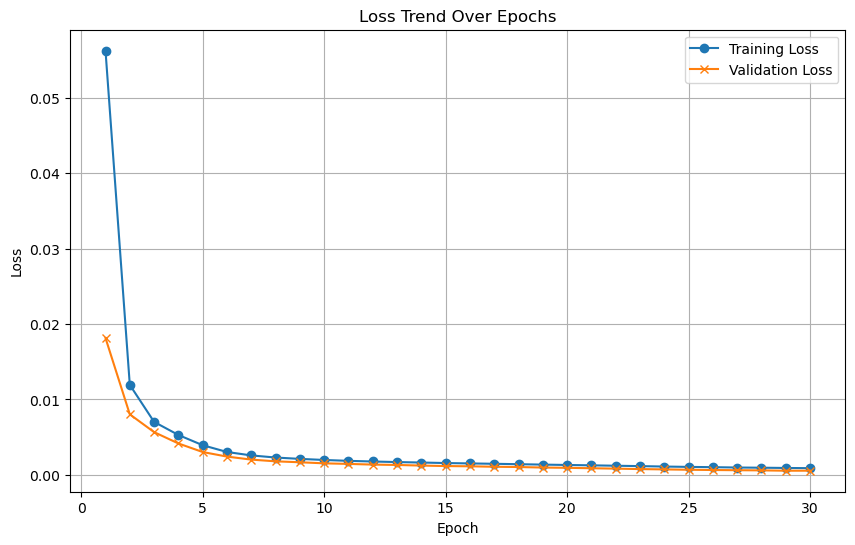

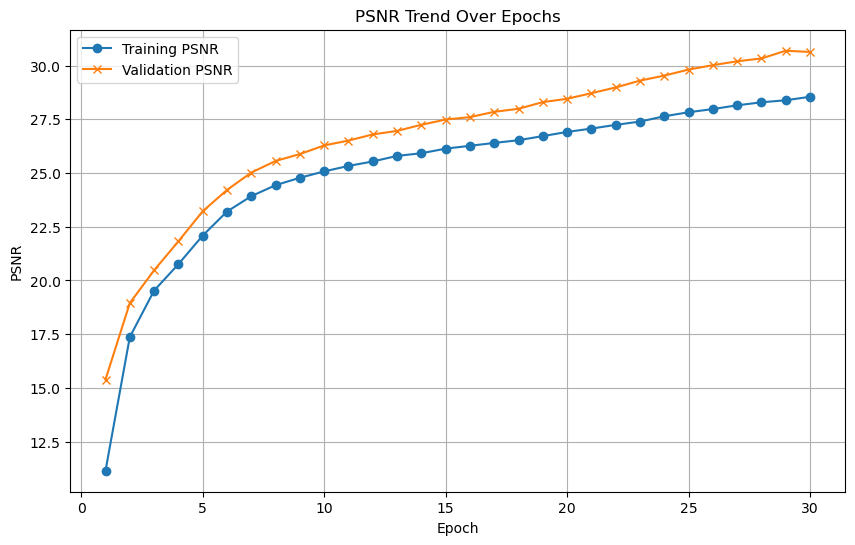

In [18]:
model_cae = ConvAutoEncode()
criterion_cae = nn.MSELoss()
optimizer_cae = optim.Adam(model_cae.parameters(), lr=0.0001)

#parameters for CAE
num_epochs_cae = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_cae = model_cae.to(device)

#early stopping parameters
patience = 3  # number of epochs to wait for improvement
tolerance = 1e-4
best_val_loss = float('inf')
epochs_without_improvement = 0

#grad accumulation parameters
accumulation_steps = 8 

# for loss and metrics tracking
autoencoder_epoch_losses_cae = []
validation_epoch_losses_cae = []
train_psnr = []
val_psnr = []

psnr = PeakSignalNoiseRatio().to(device)

# mixed precision training
scaler = GradScaler()  # Gradient scaler for mixed precision

for epoch in range(num_epochs_cae):
    # training
    model_cae.train()
    running_loss = 0.0
    running_psnr = 0.0

    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs_cae}]")

    optimizer_cae.zero_grad()

    for batch_idx, data in enumerate(train_loader_cae):
        data = data.to(device).permute(0, 3, 1, 2)

        # mixed precision forward pass
        with autocast(device_type='cuda', dtype=torch.float16):
            _, decoded = model_cae(data)
            loss = criterion_cae(decoded, data) / accumulation_steps

            with torch.no_grad():
                nan_in_out = torch.isnan(decoded).any().item()
                inf_in_out = torch.isinf(decoded).any().item()

        #backward pass with gradient scaling
        scaler.scale(loss).backward()

        loss_value = loss.item() * accumulation_steps
        running_loss += loss_value

        psnr_value = psnr(decoded, data).item()
        running_psnr += psnr_value


        # performing optimizer step and reset gradients after `accumulation_steps` batches
        if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_loader_cae):
            scaler.step(optimizer_cae)
            scaler.update()
            optimizer_cae.zero_grad()

        if batch_idx == 0 or (batch_idx + 1) % 200 == 0:
            print(
    f"\t Training Batch [{batch_idx + 1}/{len(train_loader_cae)}], "
    f"Loss: {loss_value:.4f}, PSNR: {psnr_value:.4f}"
)


        #delete intermediate variables and clear GPU cache
        del data, decoded, loss
        torch.cuda.empty_cache()

    #compute average metrics for the epoch
    avg_train_loss = running_loss / len(train_loader_cae)
    avg_train_psnr = running_psnr / len(train_loader_cae)

    autoencoder_epoch_losses_cae.append(avg_train_loss)
    train_psnr.append(avg_train_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Training Loss: {avg_train_loss:.4f}, PSNR: {avg_train_psnr:.4f}")

    #clear GPU cache after training
    torch.cuda.empty_cache()

    #validation
    model_cae.eval()
    validation_loss = 0.0
    val_psnr_epoch = 0.0

    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader_cae):
            data = data.to(device).permute(0, 3, 1, 2)

            # Mixed precision forward pass for validation
            with autocast(device_type='cuda', dtype=torch.float16):
                _, decoded = model_cae(data)
                loss = criterion_cae(decoded, data)

            validation_loss += loss.item()
            val_psnr_epoch += psnr(decoded, data).item()

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                loss_val = loss.item()
                psnr_val = psnr(decoded, data).item()
                print(
                    f"\t[Val]   Batch [{batch_idx + 1}/{len(val_loader_cae)}] "
                    f"Loss: {loss_val:.4f}, PSNR: {psnr_val:.4f}"
                )

            del data, decoded, loss
            torch.cuda.empty_cache()

    # average validation metrics for the epoch
    avg_val_loss = validation_loss / len(val_loader_cae)
    avg_val_psnr = val_psnr_epoch / len(val_loader_cae)

    validation_epoch_losses_cae.append(avg_val_loss)
    val_psnr.append(avg_val_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Validation Loss: {avg_val_loss:.4f}, PSNR: {avg_val_psnr:.4f}")

    # early stopping logic
    if avg_val_loss < best_val_loss - tolerance:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0  # Reset counter
        #best model checkpoint
        #torch.save(model_cae.state_dict(), 'best_model_cae.pth')
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

#plot for training and validation loss trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(autoencoder_epoch_losses_cae) + 1), autoencoder_epoch_losses_cae, marker='o', label="Training Loss")
plt.plot(range(1, len(validation_epoch_losses_cae) + 1), validation_epoch_losses_cae, marker='x', label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

#plot for PSNR trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_psnr) + 1), train_psnr, marker='o', label="Training PSNR")
plt.plot(range(1, len(val_psnr) + 1), val_psnr, marker='x', label="Validation PSNR")
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.title('PSNR Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

## Using the encoder section of CAE as feature extractor to generate compact representations

In [19]:
#dir to save encoded representations
encoded_dir = 'encoded_representations'
os.makedirs(encoded_dir, exist_ok=True)

loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

model_cae.eval()

# Feature extraction
with torch.no_grad():
    for subset_name, loader in loaders.items():
        print(f"\nExtracting representations for the {subset_name} dataset...")

        # dir for the given subset's encoded features
        subset_encoded_dir = os.path.join(encoded_dir, subset_name)
        os.makedirs(subset_encoded_dir, exist_ok=True)

        for batch_idx, (data, labels) in enumerate(loader):
            data = data.to(device).permute(0, 3, 1, 2)

            # passing data through the encoder to obtain representations
            encoded_features, _ = model_cae(data)  # latent representation

            # moving to CPU and convert to NumPy
            encoded_features = encoded_features.cpu().numpy()  
            labels = labels.cpu().numpy() 

            #saving the encoded features and labels
            np.save(os.path.join(subset_encoded_dir, f'encoded_batch_{batch_idx}.npy'), encoded_features)
            np.save(os.path.join(subset_encoded_dir, f'labels_batch_{batch_idx}.npy'), labels)

            if batch_idx % 1 == 0 and subset_name != 'test':
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")
            elif subset_name == 'test' and batch_idx % 100 == 0:  # Log less frequently for the test set
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")

        print(f"Completed encoding for the {subset_name} dataset.")

print("Feature extraction completed for all subsets.")


Extracting representations for the train dataset...
    Processed batch 1/1 for train dataset.
Completed encoding for the train dataset.

Extracting representations for the val dataset...
    Processed batch 1/1 for val dataset.
Completed encoding for the val dataset.

Extracting representations for the test dataset...
    Processed batch 1/167 for test dataset.


    Processed batch 101/167 for test dataset.


Completed encoding for the test dataset.
Feature extraction completed for all subsets.


## End-To-End CNN

In [20]:
class hyperspectralCNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(hyperspectralCNN, self).__init__()

        self.cnn_layers = nn.Sequential(
            # Block 1
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #fully connected layers for classification
        self.fc_layers = nn.Sequential(
            nn.Flatten(),  #3D to 1D vector for input to FC layers
            nn.Linear(16 * 2 * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.fc_layers(x)
        return x


LOG: Epoch [1/1000] - Training
Epoch [1/1000] completed, Average Training Loss: 2.2321
    Validation Batch [1/1], Loss: 2.1998
Validation Loss: 2.1998, Validation Accuracy: 11.11%
Validation loss improved from inf to 2.1998. Saving model...

LOG: Epoch [2/1000] - Training
Epoch [2/1000] completed, Average Training Loss: 2.1781
    Validation Batch [1/1], Loss: 2.1998
Validation Loss: 2.1998, Validation Accuracy: 11.11%
Validation loss improved from 2.1998 to 2.1998. Saving model...

LOG: Epoch [3/1000] - Training
Epoch [3/1000] completed, Average Training Loss: 2.1385
    Validation Batch [1/1], Loss: 2.1998
Validation Loss: 2.1998, Validation Accuracy: 11.11%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [4/1000] - Training
Epoch [4/1000] completed, Average Training Loss: 2.1069
    Validation Batch [1/1], Loss: 2.1998
Validation Loss: 2.1998, Validation Accuracy: 11.11%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [5/1000] - Training
Epoch [5/1000] co

Epoch [22/1000] completed, Average Training Loss: 1.8025
    Validation Batch [1/1], Loss: 2.1962
Validation Loss: 2.1962, Validation Accuracy: 11.11%
Validation loss improved from 2.1967 to 2.1962. Saving model...

LOG: Epoch [23/1000] - Training
Epoch [23/1000] completed, Average Training Loss: 1.7838
    Validation Batch [1/1], Loss: 2.1954
Validation Loss: 2.1954, Validation Accuracy: 11.11%
Validation loss improved from 2.1962 to 2.1954. Saving model...

LOG: Epoch [24/1000] - Training
Epoch [24/1000] completed, Average Training Loss: 1.8075
    Validation Batch [1/1], Loss: 2.1943
Validation Loss: 2.1943, Validation Accuracy: 8.89%
Validation loss improved from 2.1954 to 2.1943. Saving model...

LOG: Epoch [25/1000] - Training
Epoch [25/1000] completed, Average Training Loss: 1.7426
    Validation Batch [1/1], Loss: 2.1929
Validation Loss: 2.1929, Validation Accuracy: 4.44%
Validation loss improved from 2.1943 to 2.1929. Saving model...

LOG: Epoch [26/1000] - Training
Epoch [26/

Epoch [57/1000] completed, Average Training Loss: 1.3781
    Validation Batch [1/1], Loss: 1.8052
Validation Loss: 1.8052, Validation Accuracy: 66.67%
Validation loss improved from 1.8194 to 1.8052. Saving model...

LOG: Epoch [58/1000] - Training
Epoch [58/1000] completed, Average Training Loss: 1.3920
    Validation Batch [1/1], Loss: 1.7916
Validation Loss: 1.7916, Validation Accuracy: 66.67%
Validation loss improved from 1.8052 to 1.7916. Saving model...

LOG: Epoch [59/1000] - Training
Epoch [59/1000] completed, Average Training Loss: 1.3634
    Validation Batch [1/1], Loss: 1.7786
Validation Loss: 1.7786, Validation Accuracy: 68.89%
Validation loss improved from 1.7916 to 1.7786. Saving model...

LOG: Epoch [60/1000] - Training
Epoch [60/1000] completed, Average Training Loss: 1.3853
    Validation Batch [1/1], Loss: 1.7678
Validation Loss: 1.7678, Validation Accuracy: 68.89%
Validation loss improved from 1.7786 to 1.7678. Saving model...

LOG: Epoch [61/1000] - Training
Epoch [6

    Validation Batch [1/1], Loss: 1.5298
Validation Loss: 1.5298, Validation Accuracy: 71.11%
Validation loss improved from 1.5328 to 1.5298. Saving model...

LOG: Epoch [88/1000] - Training
Epoch [88/1000] completed, Average Training Loss: 1.1158
    Validation Batch [1/1], Loss: 1.5275
Validation Loss: 1.5275, Validation Accuracy: 68.89%
Validation loss improved from 1.5298 to 1.5275. Saving model...

LOG: Epoch [89/1000] - Training
Epoch [89/1000] completed, Average Training Loss: 1.0806
    Validation Batch [1/1], Loss: 1.5215
Validation Loss: 1.5215, Validation Accuracy: 71.11%
Validation loss improved from 1.5275 to 1.5215. Saving model...

LOG: Epoch [90/1000] - Training
Epoch [90/1000] completed, Average Training Loss: 1.1279
    Validation Batch [1/1], Loss: 1.5147
Validation Loss: 1.5147, Validation Accuracy: 73.33%
Validation loss improved from 1.5215 to 1.5147. Saving model...

LOG: Epoch [91/1000] - Training
Epoch [91/1000] completed, Average Training Loss: 1.1175
    Vali

Epoch [118/1000] completed, Average Training Loss: 0.9137
    Validation Batch [1/1], Loss: 1.3758
Validation Loss: 1.3758, Validation Accuracy: 71.11%
Validation loss improved from 1.3809 to 1.3758. Saving model...

LOG: Epoch [119/1000] - Training
Epoch [119/1000] completed, Average Training Loss: 0.8597
    Validation Batch [1/1], Loss: 1.3671
Validation Loss: 1.3671, Validation Accuracy: 75.56%
Validation loss improved from 1.3758 to 1.3671. Saving model...

LOG: Epoch [120/1000] - Training
Epoch [120/1000] completed, Average Training Loss: 0.7783
    Validation Batch [1/1], Loss: 1.3631
Validation Loss: 1.3631, Validation Accuracy: 77.78%
Validation loss improved from 1.3671 to 1.3631. Saving model...

LOG: Epoch [121/1000] - Training
Epoch [121/1000] completed, Average Training Loss: 0.8088
    Validation Batch [1/1], Loss: 1.3613
Validation Loss: 1.3613, Validation Accuracy: 73.33%
Validation loss improved from 1.3631 to 1.3613. Saving model...

LOG: Epoch [122/1000] - Training


Epoch [149/1000] completed, Average Training Loss: 0.6016
    Validation Batch [1/1], Loss: 1.2399
Validation Loss: 1.2399, Validation Accuracy: 68.89%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [150/1000] - Training
Epoch [150/1000] completed, Average Training Loss: 0.6284
    Validation Batch [1/1], Loss: 1.2460
Validation Loss: 1.2460, Validation Accuracy: 68.89%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [151/1000] - Training
Epoch [151/1000] completed, Average Training Loss: 0.6335
    Validation Batch [1/1], Loss: 1.2316
Validation Loss: 1.2316, Validation Accuracy: 71.11%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [152/1000] - Training
Epoch [152/1000] completed, Average Training Loss: 0.6258
    Validation Batch [1/1], Loss: 1.2099
Validation Loss: 1.2099, Validation Accuracy: 75.56%
Validation loss improved from 1.2240 to 1.2099. Saving model...

LOG: Epoch [153/1000] - Training
Epoch [153/1000] completed, Average Training 

Epoch [177/1000] completed, Average Training Loss: 0.5078
    Validation Batch [1/1], Loss: 1.1144
Validation Loss: 1.1144, Validation Accuracy: 75.56%
Validation loss improved from 1.1237 to 1.1144. Saving model...

LOG: Epoch [178/1000] - Training
Epoch [178/1000] completed, Average Training Loss: 0.5242
    Validation Batch [1/1], Loss: 1.1080
Validation Loss: 1.1080, Validation Accuracy: 75.56%
Validation loss improved from 1.1144 to 1.1080. Saving model...

LOG: Epoch [179/1000] - Training
Epoch [179/1000] completed, Average Training Loss: 0.4749
    Validation Batch [1/1], Loss: 1.1012
Validation Loss: 1.1012, Validation Accuracy: 73.33%
Validation loss improved from 1.1080 to 1.1012. Saving model...

LOG: Epoch [180/1000] - Training
Epoch [180/1000] completed, Average Training Loss: 0.4612
    Validation Batch [1/1], Loss: 1.0966
Validation Loss: 1.0966, Validation Accuracy: 73.33%
Validation loss improved from 1.1012 to 1.0966. Saving model...

LOG: Epoch [181/1000] - Training


Epoch [210/1000] completed, Average Training Loss: 0.3595
    Validation Batch [1/1], Loss: 1.0488
Validation Loss: 1.0488, Validation Accuracy: 75.56%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [211/1000] - Training
Epoch [211/1000] completed, Average Training Loss: 0.3718
    Validation Batch [1/1], Loss: 1.0568
Validation Loss: 1.0568, Validation Accuracy: 75.56%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [212/1000] - Training
Epoch [212/1000] completed, Average Training Loss: 0.3420
    Validation Batch [1/1], Loss: 1.0530
Validation Loss: 1.0530, Validation Accuracy: 75.56%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [213/1000] - Training
Epoch [213/1000] completed, Average Training Loss: 0.3192
    Validation Batch [1/1], Loss: 1.0399
Validation Loss: 1.0399, Validation Accuracy: 75.56%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [214/1000] - Training
Epoch [214/1000] completed, Average Training Loss: 0.3631
  

    Validation Batch [1/1], Loss: 0.9922
Validation Loss: 0.9922, Validation Accuracy: 75.56%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [239/1000] - Training
Epoch [239/1000] completed, Average Training Loss: 0.2690
    Validation Batch [1/1], Loss: 0.9874
Validation Loss: 0.9874, Validation Accuracy: 77.78%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [240/1000] - Training
Epoch [240/1000] completed, Average Training Loss: 0.2233
    Validation Batch [1/1], Loss: 0.9793
Validation Loss: 0.9793, Validation Accuracy: 77.78%
Validation loss improved from 0.9819 to 0.9793. Saving model...

LOG: Epoch [241/1000] - Training
Epoch [241/1000] completed, Average Training Loss: 0.2638
    Validation Batch [1/1], Loss: 0.9666
Validation Loss: 0.9666, Validation Accuracy: 75.56%
Validation loss improved from 0.9793 to 0.9666. Saving model...

LOG: Epoch [242/1000] - Training
Epoch [242/1000] completed, Average Training Loss: 0.2861
    Validation Batch [1/1], Lo

Epoch [270/1000] completed, Average Training Loss: 0.1953
    Validation Batch [1/1], Loss: 0.9626
Validation Loss: 0.9626, Validation Accuracy: 73.33%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [271/1000] - Training
Epoch [271/1000] completed, Average Training Loss: 0.1984
    Validation Batch [1/1], Loss: 0.9553
Validation Loss: 0.9553, Validation Accuracy: 73.33%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [272/1000] - Training
Epoch [272/1000] completed, Average Training Loss: 0.2165
    Validation Batch [1/1], Loss: 0.9467
Validation Loss: 0.9467, Validation Accuracy: 73.33%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [273/1000] - Training
Epoch [273/1000] completed, Average Training Loss: 0.1918
    Validation Batch [1/1], Loss: 0.9407
Validation Loss: 0.9407, Validation Accuracy: 75.56%
Validation loss improved from 0.9408 to 0.9407. Saving model...

LOG: Epoch [274/1000] - Training
Epoch [274/1000] completed, Average Training 

    Validation Batch [1/1], Loss: 0.9349
Validation Loss: 0.9349, Validation Accuracy: 75.56%
Validation loss did not improve. Patience: 26/100

LOG: Epoch [304/1000] - Training
Epoch [304/1000] completed, Average Training Loss: 0.1797
    Validation Batch [1/1], Loss: 0.9371
Validation Loss: 0.9371, Validation Accuracy: 75.56%
Validation loss did not improve. Patience: 27/100

LOG: Epoch [305/1000] - Training
Epoch [305/1000] completed, Average Training Loss: 0.1251
    Validation Batch [1/1], Loss: 0.9338
Validation Loss: 0.9338, Validation Accuracy: 75.56%
Validation loss did not improve. Patience: 28/100

LOG: Epoch [306/1000] - Training
Epoch [306/1000] completed, Average Training Loss: 0.1715
    Validation Batch [1/1], Loss: 0.9260
Validation Loss: 0.9260, Validation Accuracy: 75.56%
Validation loss did not improve. Patience: 29/100

LOG: Epoch [307/1000] - Training
Epoch [307/1000] completed, Average Training Loss: 0.1718
    Validation Batch [1/1], Loss: 0.9204
Validation Loss

    Validation Batch [1/1], Loss: 0.8942
Validation Loss: 0.8942, Validation Accuracy: 71.11%
Validation loss improved from 0.8971 to 0.8942. Saving model...

LOG: Epoch [336/1000] - Training
Epoch [336/1000] completed, Average Training Loss: 0.1292
    Validation Batch [1/1], Loss: 0.8965
Validation Loss: 0.8965, Validation Accuracy: 71.11%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [337/1000] - Training
Epoch [337/1000] completed, Average Training Loss: 0.1146
    Validation Batch [1/1], Loss: 0.9035
Validation Loss: 0.9035, Validation Accuracy: 73.33%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [338/1000] - Training
Epoch [338/1000] completed, Average Training Loss: 0.0897
    Validation Batch [1/1], Loss: 0.9097
Validation Loss: 0.9097, Validation Accuracy: 75.56%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [339/1000] - Training
Epoch [339/1000] completed, Average Training Loss: 0.0760
    Validation Batch [1/1], Loss: 0.9076
Vali

Validation Loss: 0.9001, Validation Accuracy: 77.78%
Validation loss did not improve. Patience: 32/100

LOG: Epoch [368/1000] - Training
Epoch [368/1000] completed, Average Training Loss: 0.0945
    Validation Batch [1/1], Loss: 0.8980
Validation Loss: 0.8980, Validation Accuracy: 75.56%
Validation loss did not improve. Patience: 33/100

LOG: Epoch [369/1000] - Training
Epoch [369/1000] completed, Average Training Loss: 0.0939
    Validation Batch [1/1], Loss: 0.8990
Validation Loss: 0.8990, Validation Accuracy: 75.56%
Validation loss did not improve. Patience: 34/100

LOG: Epoch [370/1000] - Training
Epoch [370/1000] completed, Average Training Loss: 0.0929
    Validation Batch [1/1], Loss: 0.9017
Validation Loss: 0.9017, Validation Accuracy: 75.56%
Validation loss did not improve. Patience: 35/100

LOG: Epoch [371/1000] - Training
Epoch [371/1000] completed, Average Training Loss: 0.1034
    Validation Batch [1/1], Loss: 0.9047
Validation Loss: 0.9047, Validation Accuracy: 77.78%
Val

    Validation Batch [1/1], Loss: 0.9117
Validation Loss: 0.9117, Validation Accuracy: 75.56%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [402/1000] - Training
Epoch [402/1000] completed, Average Training Loss: 0.0877
    Validation Batch [1/1], Loss: 0.9157
Validation Loss: 0.9157, Validation Accuracy: 75.56%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [403/1000] - Training
Epoch [403/1000] completed, Average Training Loss: 0.0909
    Validation Batch [1/1], Loss: 0.9167
Validation Loss: 0.9167, Validation Accuracy: 75.56%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [404/1000] - Training
Epoch [404/1000] completed, Average Training Loss: 0.0966
    Validation Batch [1/1], Loss: 0.9090
Validation Loss: 0.9090, Validation Accuracy: 77.78%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [405/1000] - Training
Epoch [405/1000] completed, Average Training Loss: 0.0658
    Validation Batch [1/1], Loss: 0.9024
Validation Loss: 0.

Epoch [435/1000] completed, Average Training Loss: 0.0685
    Validation Batch [1/1], Loss: 0.9347
Validation Loss: 0.9347, Validation Accuracy: 68.89%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [436/1000] - Training
Epoch [436/1000] completed, Average Training Loss: 0.0721
    Validation Batch [1/1], Loss: 0.9359
Validation Loss: 0.9359, Validation Accuracy: 71.11%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [437/1000] - Training
Epoch [437/1000] completed, Average Training Loss: 0.0818
    Validation Batch [1/1], Loss: 0.9282
Validation Loss: 0.9282, Validation Accuracy: 73.33%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [438/1000] - Training
Epoch [438/1000] completed, Average Training Loss: 0.0742
    Validation Batch [1/1], Loss: 0.9318
Validation Loss: 0.9318, Validation Accuracy: 75.56%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [439/1000] - Training
Epoch [439/1000] completed, Average Training Loss: 0.050

Epoch [465/1000] completed, Average Training Loss: 0.0490
    Validation Batch [1/1], Loss: 0.9121
Validation Loss: 0.9121, Validation Accuracy: 75.56%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [466/1000] - Training
Epoch [466/1000] completed, Average Training Loss: 0.0455
    Validation Batch [1/1], Loss: 0.9247
Validation Loss: 0.9247, Validation Accuracy: 77.78%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [467/1000] - Training
Epoch [467/1000] completed, Average Training Loss: 0.0400
    Validation Batch [1/1], Loss: 0.9380
Validation Loss: 0.9380, Validation Accuracy: 75.56%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [468/1000] - Training
Epoch [468/1000] completed, Average Training Loss: 0.0591
    Validation Batch [1/1], Loss: 0.9332
Validation Loss: 0.9332, Validation Accuracy: 75.56%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [469/1000] - Training
Epoch [469/1000] completed, Average Training Loss: 0.0564
  

Epoch [497/1000] completed, Average Training Loss: 0.0308
    Validation Batch [1/1], Loss: 0.8970
Validation Loss: 0.8970, Validation Accuracy: 75.56%
Validation loss did not improve. Patience: 37/100

LOG: Epoch [498/1000] - Training
Epoch [498/1000] completed, Average Training Loss: 0.0450
    Validation Batch [1/1], Loss: 0.9063
Validation Loss: 0.9063, Validation Accuracy: 77.78%
Validation loss did not improve. Patience: 38/100

LOG: Epoch [499/1000] - Training
Epoch [499/1000] completed, Average Training Loss: 0.0596
    Validation Batch [1/1], Loss: 0.9175
Validation Loss: 0.9175, Validation Accuracy: 77.78%
Validation loss did not improve. Patience: 39/100

LOG: Epoch [500/1000] - Training
Epoch [500/1000] completed, Average Training Loss: 0.0643
    Validation Batch [1/1], Loss: 0.9283
Validation Loss: 0.9283, Validation Accuracy: 73.33%
Validation loss did not improve. Patience: 40/100

LOG: Epoch [501/1000] - Training
Epoch [501/1000] completed, Average Training Loss: 0.039

    Validation Batch [1/1], Loss: 0.9119
Validation Loss: 0.9119, Validation Accuracy: 75.56%
Validation loss did not improve. Patience: 70/100

LOG: Epoch [531/1000] - Training
Epoch [531/1000] completed, Average Training Loss: 0.0568
    Validation Batch [1/1], Loss: 0.9132
Validation Loss: 0.9132, Validation Accuracy: 75.56%
Validation loss did not improve. Patience: 71/100

LOG: Epoch [532/1000] - Training
Epoch [532/1000] completed, Average Training Loss: 0.0406
    Validation Batch [1/1], Loss: 0.9140
Validation Loss: 0.9140, Validation Accuracy: 75.56%
Validation loss did not improve. Patience: 72/100

LOG: Epoch [533/1000] - Training
Epoch [533/1000] completed, Average Training Loss: 0.0333
    Validation Batch [1/1], Loss: 0.9137
Validation Loss: 0.9137, Validation Accuracy: 75.56%
Validation loss did not improve. Patience: 73/100

LOG: Epoch [534/1000] - Training
Epoch [534/1000] completed, Average Training Loss: 0.0314
    Validation Batch [1/1], Loss: 0.9135
Validation Loss

Epoch [560/1000] completed, Average Training Loss: 0.0393
    Validation Batch [1/1], Loss: 0.9290
Validation Loss: 0.9290, Validation Accuracy: 75.56%
Validation loss did not improve. Patience: 100/100
Early stopping triggered at epoch 560. No improvement for 100 epochs.
Loading the best model weights...


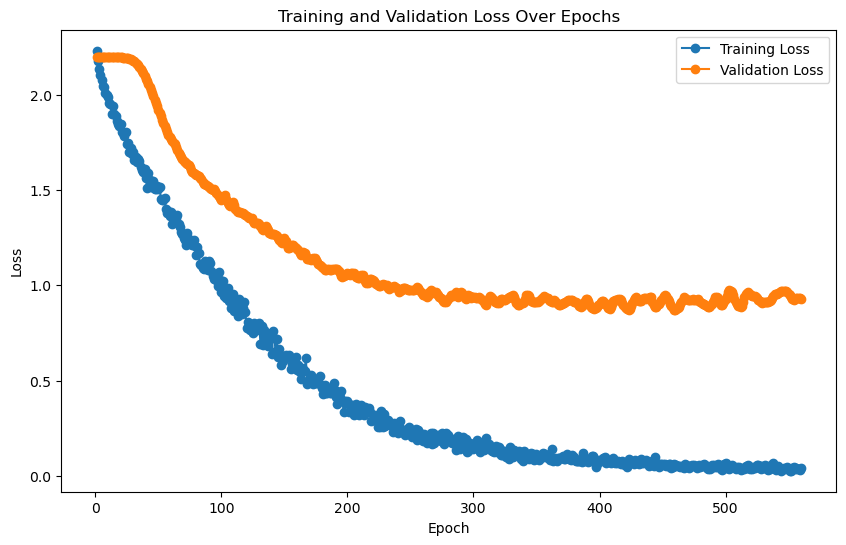

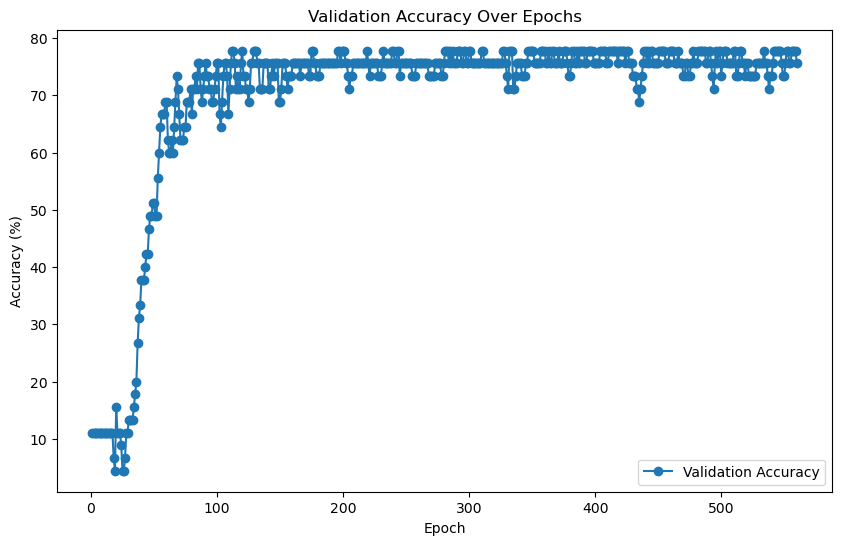


Evaluating on the test set...
    Test Batch [1/167], Loss: 1.0721



Final Test Loss: 1.0034, Test Accuracy: 71.23%
Saved E2E CNN predictions and true labels to model_predictions


In [21]:
#hyperparameters
num_epochs = 1000
learning_rate = 0.0001

#init the model, CrossEntropy loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#getting unique labels from entire dataset (train, validation, test)
all_labels = []
for loader in [train_loader, val_loader, test_loader]:
    for _, labels in loader:
        all_labels.extend(labels.tolist())
all_labels = np.unique(all_labels)

# init model with correct number of classes
num_classes = len(all_labels)
model = hyperspectralCNN(input_channels=window_num_channels, num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#lists to store losses and accuracies
classification_epoch_losses = []
validation_epoch_losses = []
val_accuracies = []

#early stopping parameters
patience = 100
best_val_loss = float('inf')
epochs_without_improvement = 0
best_model_weights = None

#training loop + validation with early stopping
for epoch in range(num_epochs):
    # TRAINING
    model.train()
    running_loss = 0.0
    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs}] - Training")

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device).permute(0, 3, 1, 2) 
        target = target.to(device)

        # forward pass
        outputs = model(data)
        loss = criterion(outputs, target)

        # backward pass + optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # accum loss
        running_loss += loss.item()

        if (batch_idx + 1) % 10 == 0:
            print(f"    Training Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # calc + store average training loss per epoch
    avg_train_loss = running_loss / len(train_loader)
    classification_epoch_losses.append(avg_train_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}] completed, Average Training Loss: {avg_train_loss:.4f}")

    # VALIDATION
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data = data.to(device).permute(0, 3, 1, 2)
            target = target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.item()

            # accu calculation
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                print(f"    Validation Batch [{batch_idx + 1}/{len(val_loader)}], Loss: {loss.item():.4f}")

    # calc + store validation metrics
    avg_val_loss = val_loss / len(val_loader)
    validation_epoch_losses.append(avg_val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # early stopping logic
    if avg_val_loss <= best_val_loss:
        print(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}. Saving model...")
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        best_model_weights = model.state_dict()
    else:
        epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {epochs_without_improvement}/{patience}")

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

# loading the best model weights
if best_model_weights is not None:
    print("Loading the best model weights...")
    model.load_state_dict(best_model_weights)

completed_epochs = len(classification_epoch_losses)

# plot for loss and accuracy trends over epochs
plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), classification_epoch_losses, label="Training Loss", marker='o')
plt.plot(range(1, completed_epochs + 1), validation_epoch_losses, label="Validation Loss", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.show()

#test Set Evaluation
print("\nEvaluating on the test set...")
model.eval()
test_loss = 0.0
correct = 0
total = 0
e2ecnn_test_predictions = []
e2ecnn_test_true_labels = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.to(device).permute(0, 3, 1, 2)
        target = target.to(device)
        outputs = model(data)
        loss = criterion(outputs, target)
        test_loss += loss.item()

        #accuracy calc
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == target).sum().item()
        total += target.size(0)

        e2ecnn_test_predictions.extend(predicted.cpu().numpy())
        e2ecnn_test_true_labels.extend(target.cpu().numpy())

        if batch_idx == 0 or (batch_idx + 1) % 1000 == 0:
            print(f"    Test Batch [{batch_idx + 1}/{len(test_loader)}], Loss: {loss.item():.4f}")

#calc + print test metrics
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total
print(f"\nFinal Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Convert to numpy arrays and save
e2e_test_predictions = np.array(e2ecnn_test_predictions)
e2e_test_true_labels = np.array(e2ecnn_test_true_labels)

np.save(os.path.join(predictions_dir, 'e2e_cnn_predictions.npy'), e2e_test_predictions)
np.save(os.path.join(predictions_dir, 'e2e_cnn_true_labels.npy'), e2e_test_true_labels)
print(f"Saved E2E CNN predictions and true labels to {predictions_dir}")

In [22]:
# dir to save the cnn representations
e2ecnn_rep_dir = "e2ecnn_representations"
os.makedirs(e2ecnn_rep_dir, exist_ok=True)

e2ecnn_loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}


model.eval()

with torch.no_grad():
    for e2ecnn_split_name, e2ecnn_loader in e2ecnn_loaders.items():
        print(f"\nExtracting SCL representations for the {e2ecnn_split_name} dataset...")
        # creating subfolder for the split
        e2ecnn_split_dir = os.path.join(e2ecnn_rep_dir, e2ecnn_split_name)
        os.makedirs(e2ecnn_split_dir, exist_ok=True)

        # processing the data batch-wise
        for e2ecnn_batch_idx, (e2ecnn_vectors, e2ecnn_labels) in enumerate(e2ecnn_loader):
            e2ecnn_vectors = e2ecnn_vectors.permute(0, 3, 1, 2) 
            e2ecnn_vectors = e2ecnn_vectors.to(device).float()
            # computing projections using the trained SCL model
            e2ecnn_projections = model(e2ecnn_vectors)

            # converting projections and labels to np arrays
            e2ecnn_projections_np = e2ecnn_projections.cpu().numpy()
            e2ecnn_labels_np = e2ecnn_labels.cpu().numpy()

            # saving the batch projections and labels
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_encoded_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_projections_np)
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_labels_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_labels_np)

            if (e2ecnn_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {e2ecnn_batch_idx + 1}/{len(e2ecnn_loader)} for {e2ecnn_split_name} dataset.")

        print(f"Completed extraction for the {e2ecnn_split_name} dataset. Representations saved in '{e2ecnn_split_dir}'.")

print("E2E CNN representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'e2ecnn_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'e2ecnn_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/167 for test dataset.
  Processed batch 20/167 for test dataset.
  Processed batch 30/167 for test dataset.


  Processed batch 40/167 for test dataset.
  Processed batch 50/167 for test dataset.
  Processed batch 60/167 for test dataset.
  Processed batch 70/167 for test dataset.
  Processed batch 80/167 for test dataset.


  Processed batch 90/167 for test dataset.
  Processed batch 100/167 for test dataset.
  Processed batch 110/167 for test dataset.
  Processed batch 120/167 for test dataset.
  Processed batch 130/167 for test dataset.


  Processed batch 140/167 for test dataset.
  Processed batch 150/167 for test dataset.
  Processed batch 160/167 for test dataset.
Completed extraction for the test dataset. Representations saved in 'e2ecnn_representations\test'.
E2E CNN representations extraction complete.


In [23]:
def load_cnn_reps_and_labels(split_dir):
    #gather all the cnn_encoded_batch npy files in sorted order
    cnn_rep_files = sorted(glob.glob(os.path.join(split_dir, "cnn_encoded_batch_*.npy")))

    cnn_all_reps = []
    cnn_all_labels = []

    for cnn_rep_file in cnn_rep_files:
        #deriving label filenames
        cnn_label_file = cnn_rep_file.replace("cnn_encoded_batch_", "cnn_labels_batch_")

        cnn_reps = np.load(cnn_rep_file)
        cnn_labels = np.load(cnn_label_file)

        cnn_all_reps.append(cnn_reps)
        cnn_all_labels.append(cnn_labels)

    #concat along first dim
    cnn_all_reps = np.concatenate(cnn_all_reps, axis = 0)
    cnn_all_labels = np.concatenate(cnn_all_labels, axis = 0)

    return cnn_all_reps, cnn_all_labels

In [24]:
cnn_train_dir = os.path.join("e2ecnn_representations", "train")
cnn_val_dir   = os.path.join("e2ecnn_representations", "val")
cnn_test_dir  = os.path.join("e2ecnn_representations", "test")

cnn_train_reps, cnn_train_labels = load_cnn_reps_and_labels(cnn_train_dir)
cnn_val_reps, cnn_val_labels = load_cnn_reps_and_labels(cnn_val_dir)
cnn_test_reps, cnn_test_labels = load_cnn_reps_and_labels(cnn_test_dir)

## Logistic Regression Model

In [25]:
def load_encoded_data(encoded_dir):
    print(f"LOG: Loading encoded data (representations) from {encoded_dir}...")
    features_list = []
    labels_list = []

    #iter through batches
    for filename in sorted(os.listdir(encoded_dir)):
        if filename.startswith('encoded_batch_') and filename.endswith('.npy'):

            #load the features
            features = np.load(os.path.join(encoded_dir, filename))
            features_flat = features.reshape(features.shape[0], -1) #flatten features for LRM
            features_list.append(features_flat)
        
        elif filename.startswith('labels_batch_') and filename.endswith('.npy'):

            #load labels
            labels = np.load(os.path.join(encoded_dir, filename))
            labels_list.append(labels)

    #concat all batches into a single array
    encoded_features = np.vstack(features_list)
    encoded_labels = np.hstack(labels_list)

    print(f"LOG: Loaded {encoded_features.shape[0]} samples with {encoded_features.shape[1]} features each")
    print(f"LOG: Labels shape: {encoded_labels.shape}")

    return encoded_features, encoded_labels

In [26]:
lrm_encoded_train_dir = os.path.join(encoded_dir, 'train')
lrm_encoded_val_dir = os.path.join(encoded_dir, 'val')
lrm_encoded_test_dir = os.path.join(encoded_dir, 'test')

print("\nLoading training data for LRM...")
lrm_train_features, lrm_train_labels = load_encoded_data(lrm_encoded_train_dir)

print("\nLoading validation data for LRM...")
lrm_val_features, lrm_val_labels = load_encoded_data(lrm_encoded_val_dir)

print("\nLoading test data for LRM...")
lrm_test_features, lrm_test_labels = load_encoded_data(lrm_encoded_test_dir)

#verify shapes
print(f"\nLOG: Training features shape: {lrm_train_features.shape}, Training labels shape: {lrm_train_labels.shape}")
print(f"LOG: Validation features shape: {lrm_val_features.shape}, Validation labels shape: {lrm_val_labels.shape}")
print(f"LOG: Test features shape: {lrm_test_features.shape}, Test labels shape: {lrm_test_labels.shape}")

print("\nLOG: Training Logistic Regression model...")
logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight = 'balanced')
logistic_clf.fit(lrm_train_features, lrm_train_labels)
print("LOG: Logistic Regression training complete.")

#eval on Validation Set
print("\nLOG: Evaluating on the validation set...")
lrm_val_predictions = logistic_clf.predict(lrm_val_features)
lrm_val_accuracy = accuracy_score(lrm_val_labels, lrm_val_predictions)
print(f"Validation Accuracy: {lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(lrm_val_labels, lrm_val_predictions))

#eval on Test Set
print("\nLOG: Evaluating on the test set...")
lrm_test_predictions = logistic_clf.predict(lrm_test_features)
lrm_test_accuracy = accuracy_score(lrm_test_labels, lrm_test_predictions)
print(f"Test Accuracy: {lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(lrm_test_labels, lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'cae_lrm_predictions.npy'), lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'cae_lrm_true_labels.npy'), lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")



Loading training data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)

Loading validation data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)

Loading test data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\test...


LOG: Loaded 42686 samples with 64 features each
LOG: Labels shape: (42686,)

LOG: Training features shape: (45, 64), Training labels shape: (45,)
LOG: Validation features shape: (45, 64), Validation labels shape: (45,)
LOG: Test features shape: (42686, 64), Test labels shape: (42686,)

LOG: Training Logistic Regression model...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 71.11%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.40      0.57         5
           1       0.44      0.80      0.57         5
           2       0.71      1.00      0.83         5
           3       1.00      0.40      0.57         5
           4       1.00      1.00      1.00         5
           5       0.40      0.40      0.40         5
           6       0.71      1.00      0.83         5
           7       0.67      0.40      0.50         5
           8       1.00      1.00

### Classifying CAE Embeddings with MLP

In [27]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [28]:
cae_mlp_train_dir = os.path.join("encoded_representations", "train")
cae_mlp_val_dir   = os.path.join("encoded_representations", "val")
cae_mlp_test_dir  = os.path.join("encoded_representations", "test")

cae_mlp_train_reps, cae_mlp_train_labels = load_encoded_data(cae_mlp_train_dir)
cae_mlp_val_reps, cae_mlp_val_labels = load_encoded_data(cae_mlp_val_dir)
cae_mlp_test_reps, cae_mlp_test_labels = load_encoded_data(cae_mlp_test_dir)

print("Train reps shape:",cae_mlp_train_reps.shape)
print("Train labels shape:", cae_mlp_train_labels.shape)

print("Val reps shape:", cae_mlp_val_reps.shape)
print("Val labels shape:", cae_mlp_val_labels.shape)

print("Test reps shape:", cae_mlp_test_reps.shape)
print("Test labels shape:", cae_mlp_test_labels.shape)

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 42686 samples with 64 features each
LOG: Labels shape: (42686,)
Train reps shape: (45, 64)
Train labels shape: (45,)
Val reps shape: (45, 64)
Val labels shape: (45,)
Test reps shape: (42686, 64)
Test labels shape: (42686,)


In [29]:
#converting arrays to torch tensors
cae_mlp_train_embeddings_torch = torch.tensor(cae_mlp_train_reps, dtype=torch.float32)
cae_mlp_train_labels_torch = torch.tensor(cae_mlp_train_labels, dtype=torch.long)

cae_mlp_val_embeddings_torch = torch.tensor(cae_mlp_val_reps, dtype=torch.float32)
cae_mlp_val_labels_torch = torch.tensor(cae_mlp_val_labels, dtype=torch.long)

cae_mlp_test_embeddings_torch = torch.tensor(cae_mlp_test_reps, dtype=torch.float32)
cae_mlp_test_labels_torch = torch.tensor(cae_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
cae_mlp_train_dataset = TensorDataset(cae_mlp_train_embeddings_torch, cae_mlp_train_labels_torch)
cae_mlp_val_dataset = TensorDataset(cae_mlp_val_embeddings_torch, cae_mlp_val_labels_torch)
cae_mlp_test_dataset = TensorDataset(cae_mlp_test_embeddings_torch, cae_mlp_test_labels_torch)

cae_mlp_batch_size = 64
cae_mlp_train_loader = DataLoader(cae_mlp_train_dataset, batch_size=cae_mlp_batch_size, shuffle=True)
cae_mlp_val_loader = DataLoader(cae_mlp_val_dataset, batch_size=cae_mlp_batch_size, shuffle=False)
cae_mlp_test_loader = DataLoader(cae_mlp_test_dataset, batch_size=cae_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.3966  |  Val Loss: 2.2529
Validation loss improved from inf to 2.2529.
[Epoch 2/1000] Train Loss: 2.2668  |  Val Loss: 2.1737
Validation loss improved from 2.2529 to 2.1737.
[Epoch 3/1000] Train Loss: 2.1712  |  Val Loss: 2.1085
Validation loss improved from 2.1737 to 2.1085.
[Epoch 4/1000] Train Loss: 2.0964  |  Val Loss: 2.0562
Validation loss improved from 2.1085 to 2.0562.
[Epoch 5/1000] Train Loss: 2.0318  |  Val Loss: 2.0114
Validation loss improved from 2.0562 to 2.0114.
[Epoch 6/1000] Train Loss: 1.9781  |  Val Loss: 1.9736
Validation loss improved from 2.0114 to 1.9736.
[Epoch 7/1000] Train Loss: 1.9327  |  Val Loss: 1.9436
Validation loss improved from 1.9736 to 1.9436.
[Epoch 8/1000] Train Loss: 1.8966  |  Val Loss: 1.9182
Validation loss improved from 1.9436 to 1.9182.
[Epoch 9/1000] Train Loss: 1.8634  |  Val Loss: 1.8945
Validation loss improved from 1.9182 to 1.8945.
[Epoch 10/1000] Train Loss: 1.8294  |  Val Loss: 1.8709
Validation loss impr

[Epoch 21/1000] Train Loss: 1.4658  |  Val Loss: 1.5851
Validation loss improved from 1.6127 to 1.5851.
[Epoch 22/1000] Train Loss: 1.4360  |  Val Loss: 1.5585
Validation loss improved from 1.5851 to 1.5585.
[Epoch 23/1000] Train Loss: 1.4080  |  Val Loss: 1.5330
Validation loss improved from 1.5585 to 1.5330.
[Epoch 24/1000] Train Loss: 1.3800  |  Val Loss: 1.5087
Validation loss improved from 1.5330 to 1.5087.
[Epoch 25/1000] Train Loss: 1.3516  |  Val Loss: 1.4861
Validation loss improved from 1.5087 to 1.4861.
[Epoch 26/1000] Train Loss: 1.3242  |  Val Loss: 1.4648
Validation loss improved from 1.4861 to 1.4648.
[Epoch 27/1000] Train Loss: 1.2975  |  Val Loss: 1.4442
Validation loss improved from 1.4648 to 1.4442.
[Epoch 28/1000] Train Loss: 1.2714  |  Val Loss: 1.4247
Validation loss improved from 1.4442 to 1.4247.
[Epoch 29/1000] Train Loss: 1.2461  |  Val Loss: 1.4051
Validation loss improved from 1.4247 to 1.4051.
[Epoch 30/1000] Train Loss: 1.2212  |  Val Loss: 1.3862
Validati

[Epoch 55/1000] Train Loss: 0.6374  |  Val Loss: 1.0247
Validation loss improved from 1.0319 to 1.0247.
[Epoch 56/1000] Train Loss: 0.6182  |  Val Loss: 1.0205
Validation loss improved from 1.0247 to 1.0205.
[Epoch 57/1000] Train Loss: 0.5990  |  Val Loss: 1.0180
Validation loss improved from 1.0205 to 1.0180.
[Epoch 58/1000] Train Loss: 0.5803  |  Val Loss: 1.0134
Validation loss improved from 1.0180 to 1.0134.
[Epoch 59/1000] Train Loss: 0.5621  |  Val Loss: 1.0089
Validation loss improved from 1.0134 to 1.0089.
[Epoch 60/1000] Train Loss: 0.5446  |  Val Loss: 1.0060
Validation loss improved from 1.0089 to 1.0060.
[Epoch 61/1000] Train Loss: 0.5275  |  Val Loss: 1.0036
Validation loss improved from 1.0060 to 1.0036.
[Epoch 62/1000] Train Loss: 0.5108  |  Val Loss: 1.0012
Validation loss improved from 1.0036 to 1.0012.
[Epoch 63/1000] Train Loss: 0.4946  |  Val Loss: 0.9963
Validation loss improved from 1.0012 to 0.9963.
[Epoch 64/1000] Train Loss: 0.4783  |  Val Loss: 0.9894
Validati

[Epoch 77/1000] Train Loss: 0.3131  |  Val Loss: 0.9398
Validation loss improved from 0.9404 to 0.9398.
[Epoch 78/1000] Train Loss: 0.3034  |  Val Loss: 0.9390
Validation loss improved from 0.9398 to 0.9390.
[Epoch 79/1000] Train Loss: 0.2942  |  Val Loss: 0.9370
Validation loss improved from 0.9390 to 0.9370.
[Epoch 80/1000] Train Loss: 0.2855  |  Val Loss: 0.9345
Validation loss improved from 0.9370 to 0.9345.
[Epoch 81/1000] Train Loss: 0.2771  |  Val Loss: 0.9341
Validation loss improved from 0.9345 to 0.9341.
[Epoch 82/1000] Train Loss: 0.2687  |  Val Loss: 0.9347
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 83/1000] Train Loss: 0.2609  |  Val Loss: 0.9356
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 84/1000] Train Loss: 0.2534  |  Val Loss: 0.9357
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 85/1000] Train Loss: 0.2462  |  Val Loss: 0.9365
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 86/1000] Train Loss: 0.2394  |  V

[Epoch 100/1000] Train Loss: 0.1663  |  Val Loss: 0.9815
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 101/1000] Train Loss: 0.1625  |  Val Loss: 0.9836
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 102/1000] Train Loss: 0.1590  |  Val Loss: 0.9880
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 103/1000] Train Loss: 0.1556  |  Val Loss: 0.9955
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 104/1000] Train Loss: 0.1524  |  Val Loss: 1.0031
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 105/1000] Train Loss: 0.1493  |  Val Loss: 1.0090
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 106/1000] Train Loss: 0.1461  |  Val Loss: 1.0133
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 107/1000] Train Loss: 0.1432  |  Val Loss: 1.0155
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 108/1000] Train Loss: 0.1404  |  Val Loss: 1.0184
!! Validation loss did NOT improve !! Patience:

[Epoch 129/1000] Train Loss: 0.0986  |  Val Loss: 1.1388
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 130/1000] Train Loss: 0.0971  |  Val Loss: 1.1429
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 131/1000] Train Loss: 0.0956  |  Val Loss: 1.1535
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 132/1000] Train Loss: 0.0942  |  Val Loss: 1.1615
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 133/1000] Train Loss: 0.0929  |  Val Loss: 1.1663
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 134/1000] Train Loss: 0.0916  |  Val Loss: 1.1686
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 135/1000] Train Loss: 0.0903  |  Val Loss: 1.1725
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 136/1000] Train Loss: 0.0890  |  Val Loss: 1.1766
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 137/1000] Train Loss: 0.0877  |  Val Loss: 1.1822
!! Validation loss did NOT improve !! Patience:

[Epoch 151/1000] Train Loss: 0.0727  |  Val Loss: 1.2755
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 152/1000] Train Loss: 0.0718  |  Val Loss: 1.2859
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 153/1000] Train Loss: 0.0710  |  Val Loss: 1.2899
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 154/1000] Train Loss: 0.0700  |  Val Loss: 1.2878
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 155/1000] Train Loss: 0.0691  |  Val Loss: 1.2832
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 156/1000] Train Loss: 0.0683  |  Val Loss: 1.2852
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 157/1000] Train Loss: 0.0673  |  Val Loss: 1.2896
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 158/1000] Train Loss: 0.0666  |  Val Loss: 1.2945
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 159/1000] Train Loss: 0.0658  |  Val Loss: 1.2997
!! Validation loss did NOT improve !! Patience:

[Epoch 176/1000] Train Loss: 0.0535  |  Val Loss: 1.3972
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 177/1000] Train Loss: 0.0528  |  Val Loss: 1.3977
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 178/1000] Train Loss: 0.0521  |  Val Loss: 1.3963
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 179/1000] Train Loss: 0.0516  |  Val Loss: 1.3954
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 180/1000] Train Loss: 0.0509  |  Val Loss: 1.3957
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 181/1000] Train Loss: 0.0505  |  Val Loss: 1.3991
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 181 !!
No improvement for 100 epochs.


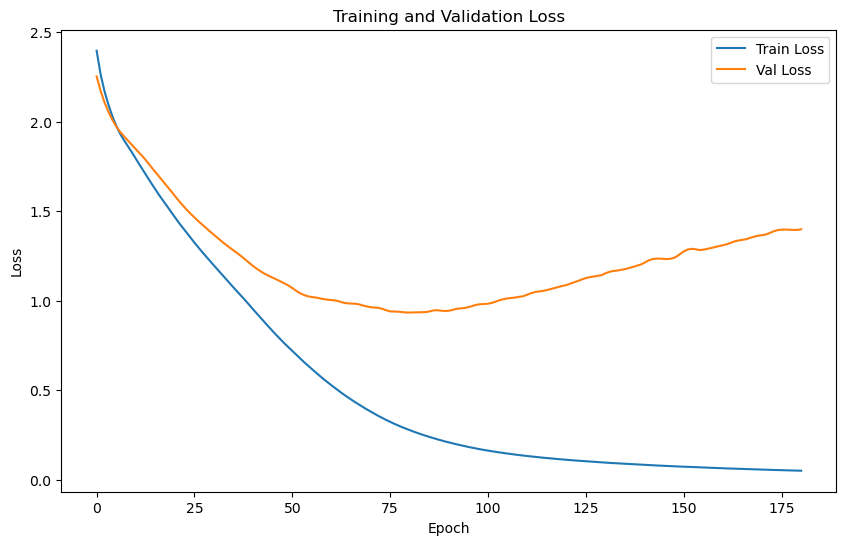

In [30]:
cae_mlp_input_dim = cae_mlp_train_reps.shape[1]
cae_mlp_num_classes = len(torch.unique(cae_mlp_train_labels_torch))
cae_mlp_model = MLPClassifier(cae_mlp_input_dim, cae_mlp_num_classes).to(device)

cae_mlp_criterion = nn.CrossEntropyLoss()
cae_mlp_optimizer = optim.Adam(cae_mlp_model.parameters(), lr=1e-3)

cae_mlp_num_epochs = 1000
cae_mlp_patience = 100

cae_mlp_train_losses = []
cae_mlp_val_losses = []

cae_mlp_best_val_loss = float('inf')
cae_mlp_epochs_without_improvement = 0

for cae_mlp_epoch in range(cae_mlp_num_epochs):
    # Training
    cae_mlp_model.train()
    cae_mlp_train_running_loss = 0.0
    
    for cae_mlp_embeddings_batch, cae_mlp_labels_batch in cae_mlp_train_loader:
        cae_mlp_embeddings_batch = cae_mlp_embeddings_batch.to(device)
        cae_mlp_labels_batch = cae_mlp_labels_batch.to(device)
        
        cae_mlp_optimizer.zero_grad()
        
        # Forward
        cae_mlp_outputs = cae_mlp_model(cae_mlp_embeddings_batch)
        cae_mlp_loss = cae_mlp_criterion(cae_mlp_outputs, cae_mlp_labels_batch)
        
        # Backward & Update
        cae_mlp_loss.backward()
        cae_mlp_optimizer.step()
        
        cae_mlp_train_running_loss += cae_mlp_loss.item() * cae_mlp_embeddings_batch.size(0)
    
    cae_mlp_epoch_train_loss = cae_mlp_train_running_loss / len(cae_mlp_train_loader.dataset)
    cae_mlp_train_losses.append(cae_mlp_epoch_train_loss)


    # Validation

    cae_mlp_model.eval()
    cae_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for cae_mlp_val_embeddings_batch, cae_mlp_val_labels_batch in cae_mlp_val_loader:
            cae_mlp_val_embeddings_batch = cae_mlp_val_embeddings_batch.to(device)
            cae_mlp_val_labels_batch = cae_mlp_val_labels_batch.to(device)

            cae_mlp_val_outputs = cae_mlp_model(cae_mlp_val_embeddings_batch)
            cae_mlp_val_loss = cae_mlp_criterion(cae_mlp_val_outputs, cae_mlp_val_labels_batch)

            cae_mlp_val_running_loss += cae_mlp_val_loss.item() * cae_mlp_val_embeddings_batch.size(0)

    cae_mlp_epoch_val_loss = cae_mlp_val_running_loss / len(cae_mlp_val_loader.dataset)
    cae_mlp_val_losses.append(cae_mlp_epoch_val_loss)

    print(f"[Epoch {cae_mlp_epoch+1}/{cae_mlp_num_epochs}] "
          f"Train Loss: {cae_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {cae_mlp_epoch_val_loss:.4f}")

    # Early stopping

    if cae_mlp_epoch_val_loss < cae_mlp_best_val_loss:
        # improvement, reset patience
        print(f"Validation loss improved from {cae_mlp_best_val_loss:.4f} to {cae_mlp_epoch_val_loss:.4f}.")
        cae_mlp_best_val_loss = cae_mlp_epoch_val_loss
        cae_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        cae_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {cae_mlp_epochs_without_improvement}/{cae_mlp_patience}")
        
        if cae_mlp_epochs_without_improvement >= cae_mlp_patience:
            print(f"!! Early stopping triggered at epoch {cae_mlp_epoch+1} !!\n"
                  f"No improvement for {cae_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(cae_mlp_train_losses, label='Train Loss')
plt.plot(cae_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved CAE+MLP predictions and true labels to model_predictions
Test Loss: 1.5080 | Test Accuracy: 65.79%


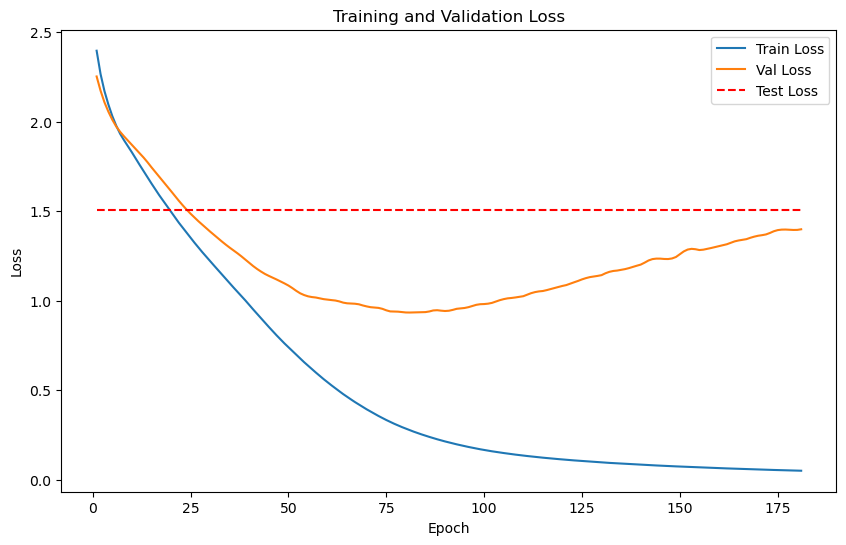

In [31]:
cae_mlp_model.eval()

cae_mlp_test_running_loss = 0.0
cae_mlp_test_correct = 0
cae_mlp_all_predictions = []
cae_mlp_all_true_labels = []

with torch.no_grad():
    for cae_mlp_test_embeddings_batch, cae_mlp_test_labels_batch in cae_mlp_test_loader:
        cae_mlp_test_embeddings_batch = cae_mlp_test_embeddings_batch.to(device)
        cae_mlp_test_labels_batch = cae_mlp_test_labels_batch.to(device)

        cae_mlp_test_outputs = cae_mlp_model(cae_mlp_test_embeddings_batch)
        
        cae_mlp_test_loss_batch = cae_mlp_criterion(cae_mlp_test_outputs, cae_mlp_test_labels_batch)
        cae_mlp_test_running_loss += cae_mlp_test_loss_batch.item() * cae_mlp_test_embeddings_batch.size(0)

        _, cae_mlp_test_predicted = torch.max(cae_mlp_test_outputs, dim=1)
        cae_mlp_test_correct += (cae_mlp_test_predicted == cae_mlp_test_labels_batch).sum().item()

        #saving predictions for conf matrix
        cae_mlp_all_predictions.extend(cae_mlp_test_predicted.cpu().numpy())
        cae_mlp_all_true_labels.extend(cae_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'cae_mlp_predictions.npy'), np.array(cae_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'cae_mlp_true_labels.npy'), np.array(cae_mlp_all_true_labels))
print(f"Saved CAE+MLP predictions and true labels to {predictions_dir}")

cae_mlp_epoch_test_loss = cae_mlp_test_running_loss / len(cae_mlp_test_loader.dataset)
cae_mlp_test_accuracy = cae_mlp_test_correct / len(cae_mlp_test_loader.dataset)

cae_mlp_test_accuracy_pct = cae_mlp_test_accuracy * 100.0

print(f"Test Loss: {cae_mlp_epoch_test_loss:.4f} | Test Accuracy: {cae_mlp_test_accuracy_pct:.2f}%")

cae_mlp_num_epochs_run = len(cae_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         [cae_mlp_epoch_test_loss]*cae_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Typical SCL with Cosine Similarity (Supervised Contrastive Loss)

In [32]:
tscl_encoded_train_dir = os.path.join(encoded_dir, 'train')
tscl_encoded_val_dir = os.path.join(encoded_dir, 'val')
tscl_encoded_test_dir = os.path.join(encoded_dir, 'test')

tscl_train_embeddings, tscl_train_labels = load_encoded_data(tscl_encoded_train_dir)
tscl_val_embeddings, tscl_val_labels = load_encoded_data(tscl_encoded_val_dir)
tscl_test_embeddings, tscl_test_labels = load_encoded_data(tscl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {tscl_train_embeddings.shape}, \nTrain labels shape: {tscl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {tscl_val_embeddings.shape}, \nVal labels shape: {tscl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {tscl_test_embeddings.shape}, \nTest labels shape: {tscl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 42686 samples with 64 features each
LOG: Labels shape: (42686,)


Train embeddings shape: (45, 64), 
Train labels shape: (45,)


Val embeddings shape: (45, 64), 
Val labels shape: (45,)


Test embeddings shape: (42686, 64), 
Test labels shape: (42686,)


In [33]:
#flattening embeddings to (num_samples, 64)
tscl_train_embeddings = tscl_train_embeddings.reshape(tscl_train_embeddings.shape[0], -1)
tscl_val_embeddings = tscl_val_embeddings.reshape(tscl_val_embeddings.shape[0], -1)
tscl_test_embeddings = tscl_test_embeddings.reshape(tscl_test_embeddings.shape[0], -1)

#compute mean and std from training set
tscl_train_mean = np.mean(tscl_train_embeddings, axis=0)
tscl_train_std = np.std(tscl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
tscl_train_embeddings = (tscl_train_embeddings - tscl_train_mean) / tscl_train_std
tscl_val_embeddings = (tscl_val_embeddings - tscl_train_mean) / tscl_train_std
tscl_test_embeddings = (tscl_test_embeddings - tscl_train_mean) / tscl_train_std

tscl_train_dataset = TensorDataset(torch.tensor(tscl_train_embeddings, dtype=torch.float32), torch.tensor(tscl_train_labels, dtype=torch.long))
tscl_val_dataset = TensorDataset(torch.tensor(tscl_val_embeddings, dtype=torch.float32), torch.tensor(tscl_val_labels, dtype=torch.long))
tscl_test_dataset = TensorDataset(torch.tensor(tscl_test_embeddings, dtype=torch.float32), torch.tensor(tscl_test_labels, dtype=torch.long))

tscl_m = 20
tscl_num_classes = len(np.unique(tscl_train_labels))

# Calculate theoretical required batch size
tscl_required_batch_size = tscl_m * tscl_num_classes

# Ensure batch size doesn't exceed training set size
if tscl_required_batch_size > len(tscl_train_dataset):
    #case 1: Not enough samples - reduce m proportionally
    tscl_max_possible_m = len(tscl_train_dataset) // tscl_num_classes
    tscl_m = max(1, tscl_max_possible_m)  # Ensure m >= 1
    tscl_batch_size_train = tscl_m * tscl_num_classes
else:
    #case 2: Use full batch size
    tscl_batch_size_train = tscl_required_batch_size

tscl_sampler = MPerClassSampler(labels = tscl_train_labels, m = tscl_m, batch_size = tscl_batch_size_train, length_before_new_iter=len(tscl_train_dataset))
tscl_train_loader = DataLoader(tscl_train_dataset, batch_size=tscl_batch_size_train, sampler=tscl_sampler)

#creating dataloaders for scl
tscl_dataloader_bs = 256
tscl_val_loader = DataLoader(tscl_val_dataset, batch_size=tscl_dataloader_bs, shuffle=False)
tscl_test_loader = DataLoader(tscl_test_dataset, batch_size=tscl_dataloader_bs, shuffle=False)

for tscl_X_batch, tscl_y_batch in tscl_train_loader:
    tscl_unique, tscl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(tscl_unique, tscl_counts)))
    print(f"Training batch size: {tscl_batch_size_train}")
    break

Class distribution in batch: {0: 5, 1: 5, 2: 5, 3: 5, 4: 5, 5: 5, 6: 5, 7: 5, 8: 5}
Training batch size: 45


In [34]:
class SupConLoss(nn.Module):
    def __init__(self, temperature = 0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        #normalize feat vectors
        features = F.normalize(features, p=2, dim = 1)

        #compute cosine simi matrix
        similarity_matrix = torch.matmul(features, features.T) / self.temperature

        #create a mask for +ve pairs - i.e. same class
        labels = labels.unsqueeze(1)
        mask = torch.eq(labels, labels.T).float().to(features.device)

        #loss computation
        exp_sim = torch.exp(similarity_matrix)
        log_prob = similarity_matrix - torch.log(exp_sim.sum(dim = 1, keepdim=True))

        #mask out diagonal - i.e. self similarity
        mask_self = torch.eye(mask.shape[0], dtype = torch.bool).to(features.device)
        mask = mask * (~mask_self)

        #handling edge cases when there is no +ve pair
        mask_pos_pairs = mask.sum(dim=1)
        mask_pos_pairs = torch.where(mask_pos_pairs < 1e-6, 1, mask_pos_pairs)

        loss = -(mask * log_prob).sum(dim=1) / mask_pos_pairs

        return loss.mean() 

In [35]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()

        self.projection_head = nn.Sequential(
            nn.Linear(64, 128), #expects input of shape (batch_size, 64)
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        #flattening input tensor
        #x = x.view(x.size(0), -1)  #reshaping -> (batch_size, channels * height * width)
        projections = self.projection_head(x)
        return projections


LOG: Epoch [1/2000] - Training
    Batch [1/1], Train Loss: 8.9156
Epoch [1/2000], Avg Train Loss: 8.9156
Epoch [1/2000], Avg Val Loss: 4.2355
Validation loss improved from inf to 4.2355. Saving model...

LOG: Epoch [2/2000] - Training
    Batch [1/1], Train Loss: 9.3007
Epoch [2/2000], Avg Train Loss: 9.3007
Epoch [2/2000], Avg Val Loss: 4.1989
Validation loss improved from 4.2355 to 4.1989. Saving model...

LOG: Epoch [3/2000] - Training
    Batch [1/1], Train Loss: 8.4890
Epoch [3/2000], Avg Train Loss: 8.4890
Epoch [3/2000], Avg Val Loss: 4.1643
Validation loss improved from 4.1989 to 4.1643. Saving model...

LOG: Epoch [4/2000] - Training
    Batch [1/1], Train Loss: 8.4282
Epoch [4/2000], Avg Train Loss: 8.4282
Epoch [4/2000], Avg Val Loss: 4.1306
Validation loss improved from 4.1643 to 4.1306. Saving model...

LOG: Epoch [5/2000] - Training
    Batch [1/1], Train Loss: 8.2747
Epoch [5/2000], Avg Train Loss: 8.2747
Epoch [5/2000], Avg Val Loss: 4.0977
Validation loss improved fr

    Batch [1/1], Train Loss: 7.7819
Epoch [8/2000], Avg Train Loss: 7.7819
Epoch [8/2000], Avg Val Loss: 4.0044
Validation loss improved from 4.0347 to 4.0044. Saving model...

LOG: Epoch [9/2000] - Training
    Batch [1/1], Train Loss: 7.7680
Epoch [9/2000], Avg Train Loss: 7.7680
Epoch [9/2000], Avg Val Loss: 3.9751
Validation loss improved from 4.0044 to 3.9751. Saving model...

LOG: Epoch [10/2000] - Training
    Batch [1/1], Train Loss: 7.7971
Epoch [10/2000], Avg Train Loss: 7.7971
Epoch [10/2000], Avg Val Loss: 3.9464
Validation loss improved from 3.9751 to 3.9464. Saving model...

LOG: Epoch [11/2000] - Training
    Batch [1/1], Train Loss: 8.0937
Epoch [11/2000], Avg Train Loss: 8.0937
Epoch [11/2000], Avg Val Loss: 3.9183
Validation loss improved from 3.9464 to 3.9183. Saving model...

LOG: Epoch [12/2000] - Training
    Batch [1/1], Train Loss: 8.0122
Epoch [12/2000], Avg Train Loss: 8.0122
Epoch [12/2000], Avg Val Loss: 3.8904
Validation loss improved from 3.9183 to 3.8904.

Epoch [21/2000], Avg Val Loss: 3.6677
Validation loss improved from 3.6898 to 3.6677. Saving model...

LOG: Epoch [22/2000] - Training
    Batch [1/1], Train Loss: 7.4374
Epoch [22/2000], Avg Train Loss: 7.4374
Epoch [22/2000], Avg Val Loss: 3.6462
Validation loss improved from 3.6677 to 3.6462. Saving model...

LOG: Epoch [23/2000] - Training
    Batch [1/1], Train Loss: 7.4065
Epoch [23/2000], Avg Train Loss: 7.4065
Epoch [23/2000], Avg Val Loss: 3.6252
Validation loss improved from 3.6462 to 3.6252. Saving model...

LOG: Epoch [24/2000] - Training
    Batch [1/1], Train Loss: 7.2351
Epoch [24/2000], Avg Train Loss: 7.2351
Epoch [24/2000], Avg Val Loss: 3.6048
Validation loss improved from 3.6252 to 3.6048. Saving model...

LOG: Epoch [25/2000] - Training
    Batch [1/1], Train Loss: 7.1314
Epoch [25/2000], Avg Train Loss: 7.1314
Epoch [25/2000], Avg Val Loss: 3.5848
Validation loss improved from 3.6048 to 3.5848. Saving model...

LOG: Epoch [26/2000] - Training
    Batch [1/1], Trai

    Batch [1/1], Train Loss: 6.5705
Epoch [31/2000], Avg Train Loss: 6.5705
Epoch [31/2000], Avg Val Loss: 3.4756
Validation loss improved from 3.4927 to 3.4756. Saving model...

LOG: Epoch [32/2000] - Training
    Batch [1/1], Train Loss: 6.9322
Epoch [32/2000], Avg Train Loss: 6.9322
Epoch [32/2000], Avg Val Loss: 3.4587
Validation loss improved from 3.4756 to 3.4587. Saving model...

LOG: Epoch [33/2000] - Training
    Batch [1/1], Train Loss: 6.8839
Epoch [33/2000], Avg Train Loss: 6.8839
Epoch [33/2000], Avg Val Loss: 3.4423
Validation loss improved from 3.4587 to 3.4423. Saving model...

LOG: Epoch [34/2000] - Training
    Batch [1/1], Train Loss: 6.8903
Epoch [34/2000], Avg Train Loss: 6.8903
Epoch [34/2000], Avg Val Loss: 3.4263
Validation loss improved from 3.4423 to 3.4263. Saving model...

LOG: Epoch [35/2000] - Training
    Batch [1/1], Train Loss: 6.7126
Epoch [35/2000], Avg Train Loss: 6.7126
Epoch [35/2000], Avg Val Loss: 3.4106
Validation loss improved from 3.4263 to 3.

    Batch [1/1], Train Loss: 5.8144
Epoch [55/2000], Avg Train Loss: 5.8144
Epoch [55/2000], Avg Val Loss: 3.1838
Validation loss improved from 3.1921 to 3.1838. Saving model...

LOG: Epoch [56/2000] - Training
    Batch [1/1], Train Loss: 5.9540
Epoch [56/2000], Avg Train Loss: 5.9540
Epoch [56/2000], Avg Val Loss: 3.1757
Validation loss improved from 3.1838 to 3.1757. Saving model...

LOG: Epoch [57/2000] - Training
    Batch [1/1], Train Loss: 5.7097
Epoch [57/2000], Avg Train Loss: 5.7097
Epoch [57/2000], Avg Val Loss: 3.1677
Validation loss improved from 3.1757 to 3.1677. Saving model...

LOG: Epoch [58/2000] - Training
    Batch [1/1], Train Loss: 5.8342
Epoch [58/2000], Avg Train Loss: 5.8342
Epoch [58/2000], Avg Val Loss: 3.1600
Validation loss improved from 3.1677 to 3.1600. Saving model...

LOG: Epoch [59/2000] - Training
    Batch [1/1], Train Loss: 5.3885
Epoch [59/2000], Avg Train Loss: 5.3885
Epoch [59/2000], Avg Val Loss: 3.1527
Validation loss improved from 3.1600 to 3.

Epoch [67/2000], Avg Val Loss: 3.1022
Validation loss improved from 3.1078 to 3.1022. Saving model...

LOG: Epoch [68/2000] - Training
    Batch [1/1], Train Loss: 5.3554
Epoch [68/2000], Avg Train Loss: 5.3554
Epoch [68/2000], Avg Val Loss: 3.0967
Validation loss improved from 3.1022 to 3.0967. Saving model...

LOG: Epoch [69/2000] - Training
    Batch [1/1], Train Loss: 5.1266
Epoch [69/2000], Avg Train Loss: 5.1266
Epoch [69/2000], Avg Val Loss: 3.0914
Validation loss improved from 3.0967 to 3.0914. Saving model...

LOG: Epoch [70/2000] - Training
    Batch [1/1], Train Loss: 5.2210
Epoch [70/2000], Avg Train Loss: 5.2210
Epoch [70/2000], Avg Val Loss: 3.0863
Validation loss improved from 3.0914 to 3.0863. Saving model...

LOG: Epoch [71/2000] - Training
    Batch [1/1], Train Loss: 4.8985
Epoch [71/2000], Avg Train Loss: 4.8985
Epoch [71/2000], Avg Val Loss: 3.0814
Validation loss improved from 3.0863 to 3.0814. Saving model...

LOG: Epoch [72/2000] - Training
    Batch [1/1], Trai

Epoch [77/2000], Avg Val Loss: 3.0546
Validation loss improved from 3.0587 to 3.0546. Saving model...

LOG: Epoch [78/2000] - Training
    Batch [1/1], Train Loss: 4.7273
Epoch [78/2000], Avg Train Loss: 4.7273
Epoch [78/2000], Avg Val Loss: 3.0506
Validation loss improved from 3.0546 to 3.0506. Saving model...

LOG: Epoch [79/2000] - Training
    Batch [1/1], Train Loss: 5.0217
Epoch [79/2000], Avg Train Loss: 5.0217
Epoch [79/2000], Avg Val Loss: 3.0468
Validation loss improved from 3.0506 to 3.0468. Saving model...

LOG: Epoch [80/2000] - Training
    Batch [1/1], Train Loss: 4.9628
Epoch [80/2000], Avg Train Loss: 4.9628
Epoch [80/2000], Avg Val Loss: 3.0430
Validation loss improved from 3.0468 to 3.0430. Saving model...

LOG: Epoch [81/2000] - Training
    Batch [1/1], Train Loss: 4.8738
Epoch [81/2000], Avg Train Loss: 4.8738
Epoch [81/2000], Avg Val Loss: 3.0394
Validation loss improved from 3.0430 to 3.0394. Saving model...

LOG: Epoch [82/2000] - Training
    Batch [1/1], Trai

    Batch [1/1], Train Loss: 4.4505
Epoch [104/2000], Avg Train Loss: 4.4505
Epoch [104/2000], Avg Val Loss: 2.9802
Validation loss improved from 2.9819 to 2.9802. Saving model...

LOG: Epoch [105/2000] - Training
    Batch [1/1], Train Loss: 4.3800
Epoch [105/2000], Avg Train Loss: 4.3800
Epoch [105/2000], Avg Val Loss: 2.9786
Validation loss improved from 2.9802 to 2.9786. Saving model...

LOG: Epoch [106/2000] - Training
    Batch [1/1], Train Loss: 4.4330
Epoch [106/2000], Avg Train Loss: 4.4330
Epoch [106/2000], Avg Val Loss: 2.9770
Validation loss improved from 2.9786 to 2.9770. Saving model...

LOG: Epoch [107/2000] - Training
    Batch [1/1], Train Loss: 4.3237
Epoch [107/2000], Avg Train Loss: 4.3237
Epoch [107/2000], Avg Val Loss: 2.9755
Validation loss improved from 2.9770 to 2.9755. Saving model...

LOG: Epoch [108/2000] - Training
    Batch [1/1], Train Loss: 4.4388
Epoch [108/2000], Avg Train Loss: 4.4388
Epoch [108/2000], Avg Val Loss: 2.9739
Validation loss improved fro

Epoch [114/2000], Avg Val Loss: 2.9654
Validation loss improved from 2.9667 to 2.9654. Saving model...

LOG: Epoch [115/2000] - Training
    Batch [1/1], Train Loss: 4.1922
Epoch [115/2000], Avg Train Loss: 4.1922
Epoch [115/2000], Avg Val Loss: 2.9642
Validation loss improved from 2.9654 to 2.9642. Saving model...

LOG: Epoch [116/2000] - Training
    Batch [1/1], Train Loss: 4.2402
Epoch [116/2000], Avg Train Loss: 4.2402
Epoch [116/2000], Avg Val Loss: 2.9629
Validation loss improved from 2.9642 to 2.9629. Saving model...

LOG: Epoch [117/2000] - Training
    Batch [1/1], Train Loss: 4.1142
Epoch [117/2000], Avg Train Loss: 4.1142
Epoch [117/2000], Avg Val Loss: 2.9616
Validation loss improved from 2.9629 to 2.9616. Saving model...

LOG: Epoch [118/2000] - Training
    Batch [1/1], Train Loss: 4.3055
Epoch [118/2000], Avg Train Loss: 4.3055
Epoch [118/2000], Avg Val Loss: 2.9604
Validation loss improved from 2.9616 to 2.9604. Saving model...

LOG: Epoch [119/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.1257
Epoch [126/2000], Avg Train Loss: 4.1257
Epoch [126/2000], Avg Val Loss: 2.9517
Validation loss improved from 2.9527 to 2.9517. Saving model...

LOG: Epoch [127/2000] - Training
    Batch [1/1], Train Loss: 4.0708
Epoch [127/2000], Avg Train Loss: 4.0708
Epoch [127/2000], Avg Val Loss: 2.9507
Validation loss improved from 2.9517 to 2.9507. Saving model...

LOG: Epoch [128/2000] - Training
    Batch [1/1], Train Loss: 4.0235
Epoch [128/2000], Avg Train Loss: 4.0235
Epoch [128/2000], Avg Val Loss: 2.9497
Validation loss improved from 2.9507 to 2.9497. Saving model...

LOG: Epoch [129/2000] - Training
    Batch [1/1], Train Loss: 4.0742
Epoch [129/2000], Avg Train Loss: 4.0742
Epoch [129/2000], Avg Val Loss: 2.9487
Validation loss improved from 2.9497 to 2.9487. Saving model...

LOG: Epoch [130/2000] - Training
    Batch [1/1], Train Loss: 3.9756
Epoch [130/2000], Avg Train Loss: 3.9756
Epoch [130/2000], Avg Val Loss: 2.9478
Validation loss improved fro

    Batch [1/1], Train Loss: 3.8137
Epoch [146/2000], Avg Train Loss: 3.8137
Epoch [146/2000], Avg Val Loss: 2.9338
Validation loss improved from 2.9348 to 2.9338. Saving model...

LOG: Epoch [147/2000] - Training
    Batch [1/1], Train Loss: 3.8554
Epoch [147/2000], Avg Train Loss: 3.8554
Epoch [147/2000], Avg Val Loss: 2.9328
Validation loss improved from 2.9338 to 2.9328. Saving model...

LOG: Epoch [148/2000] - Training
    Batch [1/1], Train Loss: 3.8501
Epoch [148/2000], Avg Train Loss: 3.8501
Epoch [148/2000], Avg Val Loss: 2.9319
Validation loss improved from 2.9328 to 2.9319. Saving model...

LOG: Epoch [149/2000] - Training
    Batch [1/1], Train Loss: 3.7437
Epoch [149/2000], Avg Train Loss: 3.7437
Epoch [149/2000], Avg Val Loss: 2.9310
Validation loss improved from 2.9319 to 2.9310. Saving model...

LOG: Epoch [150/2000] - Training
    Batch [1/1], Train Loss: 3.7726
Epoch [150/2000], Avg Train Loss: 3.7726
Epoch [150/2000], Avg Val Loss: 2.9301
Validation loss improved fro

    Batch [1/1], Train Loss: 3.8344
Epoch [158/2000], Avg Train Loss: 3.8344
Epoch [158/2000], Avg Val Loss: 2.9232
Validation loss improved from 2.9240 to 2.9232. Saving model...

LOG: Epoch [159/2000] - Training
    Batch [1/1], Train Loss: 3.8426
Epoch [159/2000], Avg Train Loss: 3.8426
Epoch [159/2000], Avg Val Loss: 2.9223
Validation loss improved from 2.9232 to 2.9223. Saving model...

LOG: Epoch [160/2000] - Training
    Batch [1/1], Train Loss: 3.6875
Epoch [160/2000], Avg Train Loss: 3.6875
Epoch [160/2000], Avg Val Loss: 2.9215
Validation loss improved from 2.9223 to 2.9215. Saving model...

LOG: Epoch [161/2000] - Training
    Batch [1/1], Train Loss: 3.7101
Epoch [161/2000], Avg Train Loss: 3.7101
Epoch [161/2000], Avg Val Loss: 2.9207
Validation loss improved from 2.9215 to 2.9207. Saving model...

LOG: Epoch [162/2000] - Training
    Batch [1/1], Train Loss: 3.7126
Epoch [162/2000], Avg Train Loss: 3.7126
Epoch [162/2000], Avg Val Loss: 2.9200
Validation loss improved fro

    Batch [1/1], Train Loss: 3.7222
Epoch [172/2000], Avg Train Loss: 3.7222
Epoch [172/2000], Avg Val Loss: 2.9130
Validation loss improved from 2.9136 to 2.9130. Saving model...

LOG: Epoch [173/2000] - Training
    Batch [1/1], Train Loss: 3.6622
Epoch [173/2000], Avg Train Loss: 3.6622
Epoch [173/2000], Avg Val Loss: 2.9123
Validation loss improved from 2.9130 to 2.9123. Saving model...

LOG: Epoch [174/2000] - Training
    Batch [1/1], Train Loss: 3.6837
Epoch [174/2000], Avg Train Loss: 3.6837
Epoch [174/2000], Avg Val Loss: 2.9116
Validation loss improved from 2.9123 to 2.9116. Saving model...

LOG: Epoch [175/2000] - Training
    Batch [1/1], Train Loss: 3.5963
Epoch [175/2000], Avg Train Loss: 3.5963
Epoch [175/2000], Avg Val Loss: 2.9109
Validation loss improved from 2.9116 to 2.9109. Saving model...

LOG: Epoch [176/2000] - Training
    Batch [1/1], Train Loss: 3.7693
Epoch [176/2000], Avg Train Loss: 3.7693
Epoch [176/2000], Avg Val Loss: 2.9102
Validation loss improved fro

    Batch [1/1], Train Loss: 3.4780
Epoch [193/2000], Avg Train Loss: 3.4780
Epoch [193/2000], Avg Val Loss: 2.8966
Validation loss improved from 2.8975 to 2.8966. Saving model...

LOG: Epoch [194/2000] - Training
    Batch [1/1], Train Loss: 3.5321
Epoch [194/2000], Avg Train Loss: 3.5321
Epoch [194/2000], Avg Val Loss: 2.8957
Validation loss improved from 2.8966 to 2.8957. Saving model...

LOG: Epoch [195/2000] - Training
    Batch [1/1], Train Loss: 3.5069
Epoch [195/2000], Avg Train Loss: 3.5069
Epoch [195/2000], Avg Val Loss: 2.8948
Validation loss improved from 2.8957 to 2.8948. Saving model...

LOG: Epoch [196/2000] - Training
    Batch [1/1], Train Loss: 3.4521
Epoch [196/2000], Avg Train Loss: 3.4521
Epoch [196/2000], Avg Val Loss: 2.8939
Validation loss improved from 2.8948 to 2.8939. Saving model...

LOG: Epoch [197/2000] - Training
    Batch [1/1], Train Loss: 3.5483
Epoch [197/2000], Avg Train Loss: 3.5483
Epoch [197/2000], Avg Val Loss: 2.8930
Validation loss improved fro

    Batch [1/1], Train Loss: 3.5052
Epoch [207/2000], Avg Train Loss: 3.5052
Epoch [207/2000], Avg Val Loss: 2.8844
Validation loss improved from 2.8853 to 2.8844. Saving model...

LOG: Epoch [208/2000] - Training
    Batch [1/1], Train Loss: 3.5440
Epoch [208/2000], Avg Train Loss: 3.5440
Epoch [208/2000], Avg Val Loss: 2.8835
Validation loss improved from 2.8844 to 2.8835. Saving model...

LOG: Epoch [209/2000] - Training
    Batch [1/1], Train Loss: 3.4600
Epoch [209/2000], Avg Train Loss: 3.4600
Epoch [209/2000], Avg Val Loss: 2.8827
Validation loss improved from 2.8835 to 2.8827. Saving model...

LOG: Epoch [210/2000] - Training
    Batch [1/1], Train Loss: 3.4675
Epoch [210/2000], Avg Train Loss: 3.4675
Epoch [210/2000], Avg Val Loss: 2.8818
Validation loss improved from 2.8827 to 2.8818. Saving model...

LOG: Epoch [211/2000] - Training
    Batch [1/1], Train Loss: 3.5429
Epoch [211/2000], Avg Train Loss: 3.5429
Epoch [211/2000], Avg Val Loss: 2.8810
Validation loss improved fro

    Batch [1/1], Train Loss: 3.4232
Epoch [220/2000], Avg Train Loss: 3.4232
Epoch [220/2000], Avg Val Loss: 2.8738
Validation loss improved from 2.8746 to 2.8738. Saving model...

LOG: Epoch [221/2000] - Training
    Batch [1/1], Train Loss: 3.3986
Epoch [221/2000], Avg Train Loss: 3.3986
Epoch [221/2000], Avg Val Loss: 2.8729
Validation loss improved from 2.8738 to 2.8729. Saving model...

LOG: Epoch [222/2000] - Training
    Batch [1/1], Train Loss: 3.3636
Epoch [222/2000], Avg Train Loss: 3.3636
Epoch [222/2000], Avg Val Loss: 2.8721
Validation loss improved from 2.8729 to 2.8721. Saving model...

LOG: Epoch [223/2000] - Training
    Batch [1/1], Train Loss: 3.4311
Epoch [223/2000], Avg Train Loss: 3.4311
Epoch [223/2000], Avg Val Loss: 2.8713
Validation loss improved from 2.8721 to 2.8713. Saving model...

LOG: Epoch [224/2000] - Training
    Batch [1/1], Train Loss: 3.4376
Epoch [224/2000], Avg Train Loss: 3.4376
Epoch [224/2000], Avg Val Loss: 2.8704
Validation loss improved fro

    Batch [1/1], Train Loss: 3.3593
Epoch [245/2000], Avg Train Loss: 3.3593
Epoch [245/2000], Avg Val Loss: 2.8511
Validation loss improved from 2.8521 to 2.8511. Saving model...

LOG: Epoch [246/2000] - Training
    Batch [1/1], Train Loss: 3.3811
Epoch [246/2000], Avg Train Loss: 3.3811
Epoch [246/2000], Avg Val Loss: 2.8501
Validation loss improved from 2.8511 to 2.8501. Saving model...

LOG: Epoch [247/2000] - Training
    Batch [1/1], Train Loss: 3.3243
Epoch [247/2000], Avg Train Loss: 3.3243
Epoch [247/2000], Avg Val Loss: 2.8492
Validation loss improved from 2.8501 to 2.8492. Saving model...

LOG: Epoch [248/2000] - Training
    Batch [1/1], Train Loss: 3.2971
Epoch [248/2000], Avg Train Loss: 3.2971
Epoch [248/2000], Avg Val Loss: 2.8483
Validation loss improved from 2.8492 to 2.8483. Saving model...

LOG: Epoch [249/2000] - Training
    Batch [1/1], Train Loss: 3.3934
Epoch [249/2000], Avg Train Loss: 3.3934
Epoch [249/2000], Avg Val Loss: 2.8473
Validation loss improved fro

    Batch [1/1], Train Loss: 3.3518
Epoch [253/2000], Avg Train Loss: 3.3518
Epoch [253/2000], Avg Val Loss: 2.8438
Validation loss improved from 2.8447 to 2.8438. Saving model...

LOG: Epoch [254/2000] - Training
    Batch [1/1], Train Loss: 3.4550
Epoch [254/2000], Avg Train Loss: 3.4550
Epoch [254/2000], Avg Val Loss: 2.8429
Validation loss improved from 2.8438 to 2.8429. Saving model...

LOG: Epoch [255/2000] - Training
    Batch [1/1], Train Loss: 3.3449
Epoch [255/2000], Avg Train Loss: 3.3449
Epoch [255/2000], Avg Val Loss: 2.8420
Validation loss improved from 2.8429 to 2.8420. Saving model...

LOG: Epoch [256/2000] - Training
    Batch [1/1], Train Loss: 3.2819
Epoch [256/2000], Avg Train Loss: 3.2819
Epoch [256/2000], Avg Val Loss: 2.8411
Validation loss improved from 2.8420 to 2.8411. Saving model...

LOG: Epoch [257/2000] - Training
    Batch [1/1], Train Loss: 3.3005
Epoch [257/2000], Avg Train Loss: 3.3005
Epoch [257/2000], Avg Val Loss: 2.8402
Validation loss improved fro

    Batch [1/1], Train Loss: 3.3050
Epoch [267/2000], Avg Train Loss: 3.3050
Epoch [267/2000], Avg Val Loss: 2.8308
Validation loss improved from 2.8318 to 2.8308. Saving model...

LOG: Epoch [268/2000] - Training
    Batch [1/1], Train Loss: 3.2555
Epoch [268/2000], Avg Train Loss: 3.2555
Epoch [268/2000], Avg Val Loss: 2.8298
Validation loss improved from 2.8308 to 2.8298. Saving model...

LOG: Epoch [269/2000] - Training
    Batch [1/1], Train Loss: 3.3329
Epoch [269/2000], Avg Train Loss: 3.3329
Epoch [269/2000], Avg Val Loss: 2.8288
Validation loss improved from 2.8298 to 2.8288. Saving model...

LOG: Epoch [270/2000] - Training
    Batch [1/1], Train Loss: 3.2700
Epoch [270/2000], Avg Train Loss: 3.2700
Epoch [270/2000], Avg Val Loss: 2.8277
Validation loss improved from 2.8288 to 2.8277. Saving model...

LOG: Epoch [271/2000] - Training
    Batch [1/1], Train Loss: 3.3381
Epoch [271/2000], Avg Train Loss: 3.3381
Epoch [271/2000], Avg Val Loss: 2.8268
Validation loss improved fro

Epoch [292/2000], Avg Val Loss: 2.8061
Validation loss improved from 2.8071 to 2.8061. Saving model...

LOG: Epoch [293/2000] - Training
    Batch [1/1], Train Loss: 3.2653
Epoch [293/2000], Avg Train Loss: 3.2653
Epoch [293/2000], Avg Val Loss: 2.8051
Validation loss improved from 2.8061 to 2.8051. Saving model...

LOG: Epoch [294/2000] - Training
    Batch [1/1], Train Loss: 3.2898
Epoch [294/2000], Avg Train Loss: 3.2898
Epoch [294/2000], Avg Val Loss: 2.8042
Validation loss improved from 2.8051 to 2.8042. Saving model...

LOG: Epoch [295/2000] - Training
    Batch [1/1], Train Loss: 3.3229
Epoch [295/2000], Avg Train Loss: 3.3229
Epoch [295/2000], Avg Val Loss: 2.8033
Validation loss improved from 2.8042 to 2.8033. Saving model...

LOG: Epoch [296/2000] - Training
    Batch [1/1], Train Loss: 3.2108
Epoch [296/2000], Avg Train Loss: 3.2108
Epoch [296/2000], Avg Val Loss: 2.8023
Validation loss improved from 2.8033 to 2.8023. Saving model...

LOG: Epoch [297/2000] - Training
    Bat

Epoch [299/2000], Avg Val Loss: 2.7996
Validation loss improved from 2.8005 to 2.7996. Saving model...

LOG: Epoch [300/2000] - Training
    Batch [1/1], Train Loss: 3.1809
Epoch [300/2000], Avg Train Loss: 3.1809
Epoch [300/2000], Avg Val Loss: 2.7987
Validation loss improved from 2.7996 to 2.7987. Saving model...

LOG: Epoch [301/2000] - Training
    Batch [1/1], Train Loss: 3.3602
Epoch [301/2000], Avg Train Loss: 3.3602
Epoch [301/2000], Avg Val Loss: 2.7978
Validation loss improved from 2.7987 to 2.7978. Saving model...

LOG: Epoch [302/2000] - Training
    Batch [1/1], Train Loss: 3.1484
Epoch [302/2000], Avg Train Loss: 3.1484
Epoch [302/2000], Avg Val Loss: 2.7969
Validation loss improved from 2.7978 to 2.7969. Saving model...

LOG: Epoch [303/2000] - Training
    Batch [1/1], Train Loss: 3.2468
Epoch [303/2000], Avg Train Loss: 3.2468
Epoch [303/2000], Avg Val Loss: 2.7960
Validation loss improved from 2.7969 to 2.7960. Saving model...

LOG: Epoch [304/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.1800
Epoch [317/2000], Avg Train Loss: 3.1800
Epoch [317/2000], Avg Val Loss: 2.7822
Validation loss improved from 2.7832 to 2.7822. Saving model...

LOG: Epoch [318/2000] - Training
    Batch [1/1], Train Loss: 3.1887
Epoch [318/2000], Avg Train Loss: 3.1887
Epoch [318/2000], Avg Val Loss: 2.7812
Validation loss improved from 2.7822 to 2.7812. Saving model...

LOG: Epoch [319/2000] - Training
    Batch [1/1], Train Loss: 3.1941
Epoch [319/2000], Avg Train Loss: 3.1941
Epoch [319/2000], Avg Val Loss: 2.7802
Validation loss improved from 2.7812 to 2.7802. Saving model...

LOG: Epoch [320/2000] - Training
    Batch [1/1], Train Loss: 3.2621
Epoch [320/2000], Avg Train Loss: 3.2621
Epoch [320/2000], Avg Val Loss: 2.7792
Validation loss improved from 2.7802 to 2.7792. Saving model...

LOG: Epoch [321/2000] - Training
    Batch [1/1], Train Loss: 3.1887
Epoch [321/2000], Avg Train Loss: 3.1887
Epoch [321/2000], Avg Val Loss: 2.7783
Validation loss improved fro

    Batch [1/1], Train Loss: 3.1581
Epoch [341/2000], Avg Train Loss: 3.1581
Epoch [341/2000], Avg Val Loss: 2.7581
Validation loss improved from 2.7591 to 2.7581. Saving model...

LOG: Epoch [342/2000] - Training
    Batch [1/1], Train Loss: 3.0318
Epoch [342/2000], Avg Train Loss: 3.0318
Epoch [342/2000], Avg Val Loss: 2.7571
Validation loss improved from 2.7581 to 2.7571. Saving model...

LOG: Epoch [343/2000] - Training
    Batch [1/1], Train Loss: 3.0359
Epoch [343/2000], Avg Train Loss: 3.0359
Epoch [343/2000], Avg Val Loss: 2.7561
Validation loss improved from 2.7571 to 2.7561. Saving model...

LOG: Epoch [344/2000] - Training
    Batch [1/1], Train Loss: 3.1343
Epoch [344/2000], Avg Train Loss: 3.1343
Epoch [344/2000], Avg Val Loss: 2.7551
Validation loss improved from 2.7561 to 2.7551. Saving model...

LOG: Epoch [345/2000] - Training
    Batch [1/1], Train Loss: 3.1257
Epoch [345/2000], Avg Train Loss: 3.1257
Epoch [345/2000], Avg Val Loss: 2.7541
Validation loss improved fro

Epoch [367/2000], Avg Val Loss: 2.7331
Validation loss improved from 2.7341 to 2.7331. Saving model...

LOG: Epoch [368/2000] - Training
    Batch [1/1], Train Loss: 3.0062
Epoch [368/2000], Avg Train Loss: 3.0062
Epoch [368/2000], Avg Val Loss: 2.7321
Validation loss improved from 2.7331 to 2.7321. Saving model...

LOG: Epoch [369/2000] - Training
    Batch [1/1], Train Loss: 3.0673
Epoch [369/2000], Avg Train Loss: 3.0673
Epoch [369/2000], Avg Val Loss: 2.7311
Validation loss improved from 2.7321 to 2.7311. Saving model...

LOG: Epoch [370/2000] - Training
    Batch [1/1], Train Loss: 3.0482
Epoch [370/2000], Avg Train Loss: 3.0482
Epoch [370/2000], Avg Val Loss: 2.7301
Validation loss improved from 2.7311 to 2.7301. Saving model...

LOG: Epoch [371/2000] - Training
    Batch [1/1], Train Loss: 3.1579
Epoch [371/2000], Avg Train Loss: 3.1579
Epoch [371/2000], Avg Val Loss: 2.7291
Validation loss improved from 2.7301 to 2.7291. Saving model...

LOG: Epoch [372/2000] - Training
    Bat

Epoch [390/2000], Avg Val Loss: 2.7094
Validation loss improved from 2.7105 to 2.7094. Saving model...

LOG: Epoch [391/2000] - Training
    Batch [1/1], Train Loss: 3.0029
Epoch [391/2000], Avg Train Loss: 3.0029
Epoch [391/2000], Avg Val Loss: 2.7084
Validation loss improved from 2.7094 to 2.7084. Saving model...

LOG: Epoch [392/2000] - Training
    Batch [1/1], Train Loss: 2.9820
Epoch [392/2000], Avg Train Loss: 2.9820
Epoch [392/2000], Avg Val Loss: 2.7073
Validation loss improved from 2.7084 to 2.7073. Saving model...

LOG: Epoch [393/2000] - Training
    Batch [1/1], Train Loss: 3.0220
Epoch [393/2000], Avg Train Loss: 3.0220
Epoch [393/2000], Avg Val Loss: 2.7063
Validation loss improved from 2.7073 to 2.7063. Saving model...

LOG: Epoch [394/2000] - Training
    Batch [1/1], Train Loss: 3.0236
Epoch [394/2000], Avg Train Loss: 3.0236
Epoch [394/2000], Avg Val Loss: 2.7052
Validation loss improved from 2.7063 to 2.7052. Saving model...

LOG: Epoch [395/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.1155
Epoch [414/2000], Avg Train Loss: 3.1155
Epoch [414/2000], Avg Val Loss: 2.6857
Validation loss improved from 2.6866 to 2.6857. Saving model...

LOG: Epoch [415/2000] - Training
    Batch [1/1], Train Loss: 3.0871
Epoch [415/2000], Avg Train Loss: 3.0871
Epoch [415/2000], Avg Val Loss: 2.6849
Validation loss improved from 2.6857 to 2.6849. Saving model...

LOG: Epoch [416/2000] - Training
    Batch [1/1], Train Loss: 2.9818
Epoch [416/2000], Avg Train Loss: 2.9818
Epoch [416/2000], Avg Val Loss: 2.6841
Validation loss improved from 2.6849 to 2.6841. Saving model...

LOG: Epoch [417/2000] - Training
    Batch [1/1], Train Loss: 2.9805
Epoch [417/2000], Avg Train Loss: 2.9805
Epoch [417/2000], Avg Val Loss: 2.6832
Validation loss improved from 2.6841 to 2.6832. Saving model...

LOG: Epoch [418/2000] - Training
    Batch [1/1], Train Loss: 3.0502
Epoch [418/2000], Avg Train Loss: 3.0502
Epoch [418/2000], Avg Val Loss: 2.6824
Validation loss improved fro

Epoch [440/2000], Avg Val Loss: 2.6637
Validation loss improved from 2.6645 to 2.6637. Saving model...

LOG: Epoch [441/2000] - Training
    Batch [1/1], Train Loss: 2.9821
Epoch [441/2000], Avg Train Loss: 2.9821
Epoch [441/2000], Avg Val Loss: 2.6629
Validation loss improved from 2.6637 to 2.6629. Saving model...

LOG: Epoch [442/2000] - Training
    Batch [1/1], Train Loss: 2.9753
Epoch [442/2000], Avg Train Loss: 2.9753
Epoch [442/2000], Avg Val Loss: 2.6621
Validation loss improved from 2.6629 to 2.6621. Saving model...

LOG: Epoch [443/2000] - Training
    Batch [1/1], Train Loss: 2.9202
Epoch [443/2000], Avg Train Loss: 2.9202
Epoch [443/2000], Avg Val Loss: 2.6613
Validation loss improved from 2.6621 to 2.6613. Saving model...

LOG: Epoch [444/2000] - Training
    Batch [1/1], Train Loss: 2.9874
Epoch [444/2000], Avg Train Loss: 2.9874
Epoch [444/2000], Avg Val Loss: 2.6605
Validation loss improved from 2.6613 to 2.6605. Saving model...

LOG: Epoch [445/2000] - Training
    Bat

    Batch [1/1], Train Loss: 2.8984
Epoch [467/2000], Avg Train Loss: 2.8984
Epoch [467/2000], Avg Val Loss: 2.6416
Validation loss improved from 2.6424 to 2.6416. Saving model...

LOG: Epoch [468/2000] - Training
    Batch [1/1], Train Loss: 2.9785
Epoch [468/2000], Avg Train Loss: 2.9785
Epoch [468/2000], Avg Val Loss: 2.6408
Validation loss improved from 2.6416 to 2.6408. Saving model...

LOG: Epoch [469/2000] - Training
    Batch [1/1], Train Loss: 2.8865
Epoch [469/2000], Avg Train Loss: 2.8865
Epoch [469/2000], Avg Val Loss: 2.6400
Validation loss improved from 2.6408 to 2.6400. Saving model...

LOG: Epoch [470/2000] - Training
    Batch [1/1], Train Loss: 2.8754
Epoch [470/2000], Avg Train Loss: 2.8754
Epoch [470/2000], Avg Val Loss: 2.6392
Validation loss improved from 2.6400 to 2.6392. Saving model...

LOG: Epoch [471/2000] - Training
    Batch [1/1], Train Loss: 2.9510
Epoch [471/2000], Avg Train Loss: 2.9510
Epoch [471/2000], Avg Val Loss: 2.6384
Validation loss improved fro

    Batch [1/1], Train Loss: 2.9073
Epoch [483/2000], Avg Train Loss: 2.9073
Epoch [483/2000], Avg Val Loss: 2.6289
Validation loss improved from 2.6296 to 2.6289. Saving model...

LOG: Epoch [484/2000] - Training
    Batch [1/1], Train Loss: 2.9353
Epoch [484/2000], Avg Train Loss: 2.9353
Epoch [484/2000], Avg Val Loss: 2.6282
Validation loss improved from 2.6289 to 2.6282. Saving model...

LOG: Epoch [485/2000] - Training
    Batch [1/1], Train Loss: 2.8458
Epoch [485/2000], Avg Train Loss: 2.8458
Epoch [485/2000], Avg Val Loss: 2.6275
Validation loss improved from 2.6282 to 2.6275. Saving model...

LOG: Epoch [486/2000] - Training
    Batch [1/1], Train Loss: 2.8083
Epoch [486/2000], Avg Train Loss: 2.8083
Epoch [486/2000], Avg Val Loss: 2.6268
Validation loss improved from 2.6275 to 2.6268. Saving model...

LOG: Epoch [487/2000] - Training
    Batch [1/1], Train Loss: 2.9194
Epoch [487/2000], Avg Train Loss: 2.9194
Epoch [487/2000], Avg Val Loss: 2.6261
Validation loss improved fro

    Batch [1/1], Train Loss: 2.8972
Epoch [518/2000], Avg Train Loss: 2.8972
Epoch [518/2000], Avg Val Loss: 2.6048
Validation loss improved from 2.6055 to 2.6048. Saving model...

LOG: Epoch [519/2000] - Training
    Batch [1/1], Train Loss: 2.8987
Epoch [519/2000], Avg Train Loss: 2.8987
Epoch [519/2000], Avg Val Loss: 2.6041
Validation loss improved from 2.6048 to 2.6041. Saving model...

LOG: Epoch [520/2000] - Training
    Batch [1/1], Train Loss: 2.8116
Epoch [520/2000], Avg Train Loss: 2.8116
Epoch [520/2000], Avg Val Loss: 2.6035
Validation loss improved from 2.6041 to 2.6035. Saving model...

LOG: Epoch [521/2000] - Training
    Batch [1/1], Train Loss: 2.7874
Epoch [521/2000], Avg Train Loss: 2.7874
Epoch [521/2000], Avg Val Loss: 2.6028
Validation loss improved from 2.6035 to 2.6028. Saving model...

LOG: Epoch [522/2000] - Training
    Batch [1/1], Train Loss: 2.8266
Epoch [522/2000], Avg Train Loss: 2.8266
Epoch [522/2000], Avg Val Loss: 2.6022
Validation loss improved fro

Epoch [531/2000], Avg Val Loss: 2.5970
Validation loss improved from 2.5975 to 2.5970. Saving model...

LOG: Epoch [532/2000] - Training
    Batch [1/1], Train Loss: 2.8550
Epoch [532/2000], Avg Train Loss: 2.8550
Epoch [532/2000], Avg Val Loss: 2.5964
Validation loss improved from 2.5970 to 2.5964. Saving model...

LOG: Epoch [533/2000] - Training
    Batch [1/1], Train Loss: 2.8025
Epoch [533/2000], Avg Train Loss: 2.8025
Epoch [533/2000], Avg Val Loss: 2.5958
Validation loss improved from 2.5964 to 2.5958. Saving model...

LOG: Epoch [534/2000] - Training
    Batch [1/1], Train Loss: 2.8348
Epoch [534/2000], Avg Train Loss: 2.8348
Epoch [534/2000], Avg Val Loss: 2.5952
Validation loss improved from 2.5958 to 2.5952. Saving model...

LOG: Epoch [535/2000] - Training
    Batch [1/1], Train Loss: 2.7978
Epoch [535/2000], Avg Train Loss: 2.7978
Epoch [535/2000], Avg Val Loss: 2.5946
Validation loss improved from 2.5952 to 2.5946. Saving model...

LOG: Epoch [536/2000] - Training
    Bat

    Batch [1/1], Train Loss: 2.6669
Epoch [566/2000], Avg Train Loss: 2.6669
Epoch [566/2000], Avg Val Loss: 2.5763
Validation loss improved from 2.5768 to 2.5763. Saving model...

LOG: Epoch [567/2000] - Training
    Batch [1/1], Train Loss: 2.7545
Epoch [567/2000], Avg Train Loss: 2.7545
Epoch [567/2000], Avg Val Loss: 2.5758
Validation loss improved from 2.5763 to 2.5758. Saving model...

LOG: Epoch [568/2000] - Training
    Batch [1/1], Train Loss: 2.7033
Epoch [568/2000], Avg Train Loss: 2.7033
Epoch [568/2000], Avg Val Loss: 2.5752
Validation loss improved from 2.5758 to 2.5752. Saving model...

LOG: Epoch [569/2000] - Training
    Batch [1/1], Train Loss: 2.7144
Epoch [569/2000], Avg Train Loss: 2.7144
Epoch [569/2000], Avg Val Loss: 2.5747
Validation loss improved from 2.5752 to 2.5747. Saving model...

LOG: Epoch [570/2000] - Training
    Batch [1/1], Train Loss: 2.8050
Epoch [570/2000], Avg Train Loss: 2.8050
Epoch [570/2000], Avg Val Loss: 2.5741
Validation loss improved fro

Epoch [584/2000], Avg Val Loss: 2.5669
Validation loss improved from 2.5674 to 2.5669. Saving model...

LOG: Epoch [585/2000] - Training
    Batch [1/1], Train Loss: 2.7720
Epoch [585/2000], Avg Train Loss: 2.7720
Epoch [585/2000], Avg Val Loss: 2.5664
Validation loss improved from 2.5669 to 2.5664. Saving model...

LOG: Epoch [586/2000] - Training
    Batch [1/1], Train Loss: 2.7391
Epoch [586/2000], Avg Train Loss: 2.7391
Epoch [586/2000], Avg Val Loss: 2.5659
Validation loss improved from 2.5664 to 2.5659. Saving model...

LOG: Epoch [587/2000] - Training
    Batch [1/1], Train Loss: 2.7487
Epoch [587/2000], Avg Train Loss: 2.7487
Epoch [587/2000], Avg Val Loss: 2.5654
Validation loss improved from 2.5659 to 2.5654. Saving model...

LOG: Epoch [588/2000] - Training
    Batch [1/1], Train Loss: 2.6797
Epoch [588/2000], Avg Train Loss: 2.6797
Epoch [588/2000], Avg Val Loss: 2.5649
Validation loss improved from 2.5654 to 2.5649. Saving model...

LOG: Epoch [589/2000] - Training
    Bat

    Batch [1/1], Train Loss: 2.6785
Epoch [616/2000], Avg Train Loss: 2.6785
Epoch [616/2000], Avg Val Loss: 2.5522
Validation loss improved from 2.5526 to 2.5522. Saving model...

LOG: Epoch [617/2000] - Training
    Batch [1/1], Train Loss: 2.7024
Epoch [617/2000], Avg Train Loss: 2.7024
Epoch [617/2000], Avg Val Loss: 2.5517
Validation loss improved from 2.5522 to 2.5517. Saving model...

LOG: Epoch [618/2000] - Training
    Batch [1/1], Train Loss: 2.6427
Epoch [618/2000], Avg Train Loss: 2.6427
Epoch [618/2000], Avg Val Loss: 2.5513
Validation loss improved from 2.5517 to 2.5513. Saving model...

LOG: Epoch [619/2000] - Training
    Batch [1/1], Train Loss: 2.7679
Epoch [619/2000], Avg Train Loss: 2.7679
Epoch [619/2000], Avg Val Loss: 2.5508
Validation loss improved from 2.5513 to 2.5508. Saving model...

LOG: Epoch [620/2000] - Training
    Batch [1/1], Train Loss: 2.6963
Epoch [620/2000], Avg Train Loss: 2.6963
Epoch [620/2000], Avg Val Loss: 2.5504
Validation loss improved fro

    Batch [1/1], Train Loss: 2.6845
Epoch [634/2000], Avg Train Loss: 2.6845
Epoch [634/2000], Avg Val Loss: 2.5437
Validation loss improved from 2.5442 to 2.5437. Saving model...

LOG: Epoch [635/2000] - Training
    Batch [1/1], Train Loss: 2.7138
Epoch [635/2000], Avg Train Loss: 2.7138
Epoch [635/2000], Avg Val Loss: 2.5432
Validation loss improved from 2.5437 to 2.5432. Saving model...

LOG: Epoch [636/2000] - Training
    Batch [1/1], Train Loss: 2.6935
Epoch [636/2000], Avg Train Loss: 2.6935
Epoch [636/2000], Avg Val Loss: 2.5427
Validation loss improved from 2.5432 to 2.5427. Saving model...

LOG: Epoch [637/2000] - Training
    Batch [1/1], Train Loss: 2.6827
Epoch [637/2000], Avg Train Loss: 2.6827
Epoch [637/2000], Avg Val Loss: 2.5423
Validation loss improved from 2.5427 to 2.5423. Saving model...

LOG: Epoch [638/2000] - Training
    Batch [1/1], Train Loss: 2.6361
Epoch [638/2000], Avg Train Loss: 2.6361
Epoch [638/2000], Avg Val Loss: 2.5418
Validation loss improved fro

Epoch [666/2000], Avg Val Loss: 2.5303
Validation loss improved from 2.5307 to 2.5303. Saving model...

LOG: Epoch [667/2000] - Training
    Batch [1/1], Train Loss: 2.5872
Epoch [667/2000], Avg Train Loss: 2.5872
Epoch [667/2000], Avg Val Loss: 2.5299
Validation loss improved from 2.5303 to 2.5299. Saving model...

LOG: Epoch [668/2000] - Training
    Batch [1/1], Train Loss: 2.6597
Epoch [668/2000], Avg Train Loss: 2.6597
Epoch [668/2000], Avg Val Loss: 2.5295
Validation loss improved from 2.5299 to 2.5295. Saving model...

LOG: Epoch [669/2000] - Training
    Batch [1/1], Train Loss: 2.6526
Epoch [669/2000], Avg Train Loss: 2.6526
Epoch [669/2000], Avg Val Loss: 2.5291
Validation loss improved from 2.5295 to 2.5291. Saving model...

LOG: Epoch [670/2000] - Training
    Batch [1/1], Train Loss: 2.6640
Epoch [670/2000], Avg Train Loss: 2.6640
Epoch [670/2000], Avg Val Loss: 2.5288
Validation loss improved from 2.5291 to 2.5288. Saving model...

LOG: Epoch [671/2000] - Training
    Bat

Epoch [682/2000], Avg Val Loss: 2.5249
Validation loss improved from 2.5253 to 2.5249. Saving model...

LOG: Epoch [683/2000] - Training
    Batch [1/1], Train Loss: 2.5823
Epoch [683/2000], Avg Train Loss: 2.5823
Epoch [683/2000], Avg Val Loss: 2.5246
Validation loss improved from 2.5249 to 2.5246. Saving model...

LOG: Epoch [684/2000] - Training
    Batch [1/1], Train Loss: 2.6811
Epoch [684/2000], Avg Train Loss: 2.6811
Epoch [684/2000], Avg Val Loss: 2.5242
Validation loss improved from 2.5246 to 2.5242. Saving model...

LOG: Epoch [685/2000] - Training
    Batch [1/1], Train Loss: 2.6967
Epoch [685/2000], Avg Train Loss: 2.6967
Epoch [685/2000], Avg Val Loss: 2.5239
Validation loss improved from 2.5242 to 2.5239. Saving model...

LOG: Epoch [686/2000] - Training
    Batch [1/1], Train Loss: 2.6722
Epoch [686/2000], Avg Train Loss: 2.6722
Epoch [686/2000], Avg Val Loss: 2.5235
Validation loss improved from 2.5239 to 2.5235. Saving model...

LOG: Epoch [687/2000] - Training
    Bat

    Batch [1/1], Train Loss: 2.5568
Epoch [713/2000], Avg Train Loss: 2.5568
Epoch [713/2000], Avg Val Loss: 2.5139
Validation loss improved from 2.5143 to 2.5139. Saving model...

LOG: Epoch [714/2000] - Training
    Batch [1/1], Train Loss: 2.5791
Epoch [714/2000], Avg Train Loss: 2.5791
Epoch [714/2000], Avg Val Loss: 2.5136
Validation loss improved from 2.5139 to 2.5136. Saving model...

LOG: Epoch [715/2000] - Training
    Batch [1/1], Train Loss: 2.6796
Epoch [715/2000], Avg Train Loss: 2.6796
Epoch [715/2000], Avg Val Loss: 2.5132
Validation loss improved from 2.5136 to 2.5132. Saving model...

LOG: Epoch [716/2000] - Training
    Batch [1/1], Train Loss: 2.6140
Epoch [716/2000], Avg Train Loss: 2.6140
Epoch [716/2000], Avg Val Loss: 2.5128
Validation loss improved from 2.5132 to 2.5128. Saving model...

LOG: Epoch [717/2000] - Training
    Batch [1/1], Train Loss: 2.6562
Epoch [717/2000], Avg Train Loss: 2.6562
Epoch [717/2000], Avg Val Loss: 2.5125
Validation loss improved fro

    Batch [1/1], Train Loss: 2.5531
Epoch [727/2000], Avg Train Loss: 2.5531
Epoch [727/2000], Avg Val Loss: 2.5092
Validation loss improved from 2.5095 to 2.5092. Saving model...

LOG: Epoch [728/2000] - Training
    Batch [1/1], Train Loss: 2.6180
Epoch [728/2000], Avg Train Loss: 2.6180
Epoch [728/2000], Avg Val Loss: 2.5089
Validation loss improved from 2.5092 to 2.5089. Saving model...

LOG: Epoch [729/2000] - Training
    Batch [1/1], Train Loss: 2.5750
Epoch [729/2000], Avg Train Loss: 2.5750
Epoch [729/2000], Avg Val Loss: 2.5086
Validation loss improved from 2.5089 to 2.5086. Saving model...

LOG: Epoch [730/2000] - Training
    Batch [1/1], Train Loss: 2.5675
Epoch [730/2000], Avg Train Loss: 2.5675
Epoch [730/2000], Avg Val Loss: 2.5083
Validation loss improved from 2.5086 to 2.5083. Saving model...

LOG: Epoch [731/2000] - Training
    Batch [1/1], Train Loss: 2.5964
Epoch [731/2000], Avg Train Loss: 2.5964
Epoch [731/2000], Avg Val Loss: 2.5080
Validation loss improved fro

    Batch [1/1], Train Loss: 2.6574
Epoch [762/2000], Avg Train Loss: 2.6574
Epoch [762/2000], Avg Val Loss: 2.4993
Validation loss improved from 2.4995 to 2.4993. Saving model...

LOG: Epoch [763/2000] - Training
    Batch [1/1], Train Loss: 2.6568
Epoch [763/2000], Avg Train Loss: 2.6568
Epoch [763/2000], Avg Val Loss: 2.4991
Validation loss improved from 2.4993 to 2.4991. Saving model...

LOG: Epoch [764/2000] - Training
    Batch [1/1], Train Loss: 2.5407
Epoch [764/2000], Avg Train Loss: 2.5407
Epoch [764/2000], Avg Val Loss: 2.4988
Validation loss improved from 2.4991 to 2.4988. Saving model...

LOG: Epoch [765/2000] - Training
    Batch [1/1], Train Loss: 2.5567
Epoch [765/2000], Avg Train Loss: 2.5567
Epoch [765/2000], Avg Val Loss: 2.4986
Validation loss improved from 2.4988 to 2.4986. Saving model...

LOG: Epoch [766/2000] - Training
    Batch [1/1], Train Loss: 2.5041
Epoch [766/2000], Avg Train Loss: 2.5041
Epoch [766/2000], Avg Val Loss: 2.4983
Validation loss improved fro

    Batch [1/1], Train Loss: 2.5565
Epoch [773/2000], Avg Train Loss: 2.5565
Epoch [773/2000], Avg Val Loss: 2.4963
Validation loss improved from 2.4966 to 2.4963. Saving model...

LOG: Epoch [774/2000] - Training
    Batch [1/1], Train Loss: 2.4866
Epoch [774/2000], Avg Train Loss: 2.4866
Epoch [774/2000], Avg Val Loss: 2.4961
Validation loss improved from 2.4963 to 2.4961. Saving model...

LOG: Epoch [775/2000] - Training
    Batch [1/1], Train Loss: 2.5707
Epoch [775/2000], Avg Train Loss: 2.5707
Epoch [775/2000], Avg Val Loss: 2.4959
Validation loss improved from 2.4961 to 2.4959. Saving model...

LOG: Epoch [776/2000] - Training
    Batch [1/1], Train Loss: 2.4234
Epoch [776/2000], Avg Train Loss: 2.4234
Epoch [776/2000], Avg Val Loss: 2.4956
Validation loss improved from 2.4959 to 2.4956. Saving model...

LOG: Epoch [777/2000] - Training
    Batch [1/1], Train Loss: 2.5250
Epoch [777/2000], Avg Train Loss: 2.5250
Epoch [777/2000], Avg Val Loss: 2.4955
Validation loss improved fro

    Batch [1/1], Train Loss: 2.5418
Epoch [814/2000], Avg Train Loss: 2.5418
Epoch [814/2000], Avg Val Loss: 2.4875
Validation loss improved from 2.4877 to 2.4875. Saving model...

LOG: Epoch [815/2000] - Training
    Batch [1/1], Train Loss: 2.5299
Epoch [815/2000], Avg Train Loss: 2.5299
Epoch [815/2000], Avg Val Loss: 2.4874
Validation loss improved from 2.4875 to 2.4874. Saving model...

LOG: Epoch [816/2000] - Training
    Batch [1/1], Train Loss: 2.5495
Epoch [816/2000], Avg Train Loss: 2.5495
Epoch [816/2000], Avg Val Loss: 2.4872
Validation loss improved from 2.4874 to 2.4872. Saving model...

LOG: Epoch [817/2000] - Training
    Batch [1/1], Train Loss: 2.4783
Epoch [817/2000], Avg Train Loss: 2.4783
Epoch [817/2000], Avg Val Loss: 2.4871
Validation loss improved from 2.4872 to 2.4871. Saving model...

LOG: Epoch [818/2000] - Training
    Batch [1/1], Train Loss: 2.5445
Epoch [818/2000], Avg Train Loss: 2.5445
Epoch [818/2000], Avg Val Loss: 2.4869
Validation loss improved fro

    Batch [1/1], Train Loss: 2.4961
Epoch [825/2000], Avg Train Loss: 2.4961
Epoch [825/2000], Avg Val Loss: 2.4858
Validation loss improved from 2.4860 to 2.4858. Saving model...

LOG: Epoch [826/2000] - Training
    Batch [1/1], Train Loss: 2.5364
Epoch [826/2000], Avg Train Loss: 2.5364
Epoch [826/2000], Avg Val Loss: 2.4855
Validation loss improved from 2.4858 to 2.4855. Saving model...

LOG: Epoch [827/2000] - Training
    Batch [1/1], Train Loss: 2.5173
Epoch [827/2000], Avg Train Loss: 2.5173
Epoch [827/2000], Avg Val Loss: 2.4854
Validation loss improved from 2.4855 to 2.4854. Saving model...

LOG: Epoch [828/2000] - Training
    Batch [1/1], Train Loss: 2.5177
Epoch [828/2000], Avg Train Loss: 2.5177
Epoch [828/2000], Avg Val Loss: 2.4851
Validation loss improved from 2.4854 to 2.4851. Saving model...

LOG: Epoch [829/2000] - Training
    Batch [1/1], Train Loss: 2.5041
Epoch [829/2000], Avg Train Loss: 2.5041
Epoch [829/2000], Avg Val Loss: 2.4849
Validation loss improved fro

Epoch [860/2000], Avg Val Loss: 2.4794
Validation loss improved from 2.4795 to 2.4794. Saving model...

LOG: Epoch [861/2000] - Training
    Batch [1/1], Train Loss: 2.4788
Epoch [861/2000], Avg Train Loss: 2.4788
Epoch [861/2000], Avg Val Loss: 2.4792
Validation loss improved from 2.4794 to 2.4792. Saving model...

LOG: Epoch [862/2000] - Training
    Batch [1/1], Train Loss: 2.4659
Epoch [862/2000], Avg Train Loss: 2.4659
Epoch [862/2000], Avg Val Loss: 2.4791
Validation loss improved from 2.4792 to 2.4791. Saving model...

LOG: Epoch [863/2000] - Training
    Batch [1/1], Train Loss: 2.4820
Epoch [863/2000], Avg Train Loss: 2.4820
Epoch [863/2000], Avg Val Loss: 2.4789
Validation loss improved from 2.4791 to 2.4789. Saving model...

LOG: Epoch [864/2000] - Training
    Batch [1/1], Train Loss: 2.3506
Epoch [864/2000], Avg Train Loss: 2.3506
Epoch [864/2000], Avg Val Loss: 2.4788
Validation loss improved from 2.4789 to 2.4788. Saving model...

LOG: Epoch [865/2000] - Training
    Bat

    Batch [1/1], Train Loss: 2.5295
Epoch [872/2000], Avg Train Loss: 2.5295
Epoch [872/2000], Avg Val Loss: 2.4774
Validation loss improved from 2.4776 to 2.4774. Saving model...

LOG: Epoch [873/2000] - Training
    Batch [1/1], Train Loss: 2.4637
Epoch [873/2000], Avg Train Loss: 2.4637
Epoch [873/2000], Avg Val Loss: 2.4772
Validation loss improved from 2.4774 to 2.4772. Saving model...

LOG: Epoch [874/2000] - Training
    Batch [1/1], Train Loss: 2.4697
Epoch [874/2000], Avg Train Loss: 2.4697
Epoch [874/2000], Avg Val Loss: 2.4769
Validation loss improved from 2.4772 to 2.4769. Saving model...

LOG: Epoch [875/2000] - Training
    Batch [1/1], Train Loss: 2.4753
Epoch [875/2000], Avg Train Loss: 2.4753
Epoch [875/2000], Avg Val Loss: 2.4768
Validation loss improved from 2.4769 to 2.4768. Saving model...

LOG: Epoch [876/2000] - Training
    Batch [1/1], Train Loss: 2.4319
Epoch [876/2000], Avg Train Loss: 2.4319
Epoch [876/2000], Avg Val Loss: 2.4765
Validation loss improved fro

    Batch [1/1], Train Loss: 2.4685
Epoch [906/2000], Avg Train Loss: 2.4685
Epoch [906/2000], Avg Val Loss: 2.4722
Validation loss improved from 2.4723 to 2.4722. Saving model...

LOG: Epoch [907/2000] - Training
    Batch [1/1], Train Loss: 2.4225
Epoch [907/2000], Avg Train Loss: 2.4225
Epoch [907/2000], Avg Val Loss: 2.4720
Validation loss improved from 2.4722 to 2.4720. Saving model...

LOG: Epoch [908/2000] - Training
    Batch [1/1], Train Loss: 2.3677
Epoch [908/2000], Avg Train Loss: 2.3677
Epoch [908/2000], Avg Val Loss: 2.4719
Validation loss improved from 2.4720 to 2.4719. Saving model...

LOG: Epoch [909/2000] - Training
    Batch [1/1], Train Loss: 2.4196
Epoch [909/2000], Avg Train Loss: 2.4196
Epoch [909/2000], Avg Val Loss: 2.4718
Validation loss improved from 2.4719 to 2.4718. Saving model...

LOG: Epoch [910/2000] - Training
    Batch [1/1], Train Loss: 2.4011
Epoch [910/2000], Avg Train Loss: 2.4011
Epoch [910/2000], Avg Val Loss: 2.4716
Validation loss improved fro

    Batch [1/1], Train Loss: 2.4415
Epoch [918/2000], Avg Train Loss: 2.4415
Epoch [918/2000], Avg Val Loss: 2.4704
Validation loss improved from 2.4704 to 2.4704. Saving model...

LOG: Epoch [919/2000] - Training
    Batch [1/1], Train Loss: 2.4113
Epoch [919/2000], Avg Train Loss: 2.4113
Epoch [919/2000], Avg Val Loss: 2.4703
Validation loss improved from 2.4704 to 2.4703. Saving model...

LOG: Epoch [920/2000] - Training
    Batch [1/1], Train Loss: 2.5122
Epoch [920/2000], Avg Train Loss: 2.5122
Epoch [920/2000], Avg Val Loss: 2.4702
Validation loss improved from 2.4703 to 2.4702. Saving model...

LOG: Epoch [921/2000] - Training
    Batch [1/1], Train Loss: 2.4518
Epoch [921/2000], Avg Train Loss: 2.4518
Epoch [921/2000], Avg Val Loss: 2.4702
Validation loss improved from 2.4702 to 2.4702. Saving model...

LOG: Epoch [922/2000] - Training
    Batch [1/1], Train Loss: 2.4866
Epoch [922/2000], Avg Train Loss: 2.4866
Epoch [922/2000], Avg Val Loss: 2.4700
Validation loss improved fro

    Batch [1/1], Train Loss: 2.3996
Epoch [952/2000], Avg Train Loss: 2.3996
Epoch [952/2000], Avg Val Loss: 2.4653
Validation loss improved from 2.4655 to 2.4653. Saving model...

LOG: Epoch [953/2000] - Training
    Batch [1/1], Train Loss: 2.4667
Epoch [953/2000], Avg Train Loss: 2.4667
Epoch [953/2000], Avg Val Loss: 2.4652
Validation loss improved from 2.4653 to 2.4652. Saving model...

LOG: Epoch [954/2000] - Training
    Batch [1/1], Train Loss: 2.3465
Epoch [954/2000], Avg Train Loss: 2.3465
Epoch [954/2000], Avg Val Loss: 2.4650
Validation loss improved from 2.4652 to 2.4650. Saving model...

LOG: Epoch [955/2000] - Training
    Batch [1/1], Train Loss: 2.3951
Epoch [955/2000], Avg Train Loss: 2.3951
Epoch [955/2000], Avg Val Loss: 2.4649
Validation loss improved from 2.4650 to 2.4649. Saving model...

LOG: Epoch [956/2000] - Training
    Batch [1/1], Train Loss: 2.4256
Epoch [956/2000], Avg Train Loss: 2.4256
Epoch [956/2000], Avg Val Loss: 2.4648
Validation loss improved fro

Epoch [970/2000], Avg Val Loss: 2.4644
Validation loss did not improve. Patience: 10/100

LOG: Epoch [971/2000] - Training
    Batch [1/1], Train Loss: 2.3608
Epoch [971/2000], Avg Train Loss: 2.3608
Epoch [971/2000], Avg Val Loss: 2.4644
Validation loss improved from 2.4644 to 2.4644. Saving model...

LOG: Epoch [972/2000] - Training
    Batch [1/1], Train Loss: 2.3666
Epoch [972/2000], Avg Train Loss: 2.3666
Epoch [972/2000], Avg Val Loss: 2.4643
Validation loss improved from 2.4644 to 2.4643. Saving model...

LOG: Epoch [973/2000] - Training
    Batch [1/1], Train Loss: 2.4620
Epoch [973/2000], Avg Train Loss: 2.4620
Epoch [973/2000], Avg Val Loss: 2.4643
Validation loss improved from 2.4643 to 2.4643. Saving model...

LOG: Epoch [974/2000] - Training
    Batch [1/1], Train Loss: 2.4075
Epoch [974/2000], Avg Train Loss: 2.4075
Epoch [974/2000], Avg Val Loss: 2.4642
Validation loss improved from 2.4643 to 2.4642. Saving model...

LOG: Epoch [975/2000] - Training
    Batch [1/1], Trai

    Batch [1/1], Train Loss: 2.4151
Epoch [1001/2000], Avg Train Loss: 2.4151
Epoch [1001/2000], Avg Val Loss: 2.4645
Validation loss did not improve. Patience: 16/100

LOG: Epoch [1002/2000] - Training
    Batch [1/1], Train Loss: 2.4445
Epoch [1002/2000], Avg Train Loss: 2.4445
Epoch [1002/2000], Avg Val Loss: 2.4646
Validation loss did not improve. Patience: 17/100

LOG: Epoch [1003/2000] - Training
    Batch [1/1], Train Loss: 2.2568
Epoch [1003/2000], Avg Train Loss: 2.2568
Epoch [1003/2000], Avg Val Loss: 2.4646
Validation loss did not improve. Patience: 18/100

LOG: Epoch [1004/2000] - Training
    Batch [1/1], Train Loss: 2.3680
Epoch [1004/2000], Avg Train Loss: 2.3680
Epoch [1004/2000], Avg Val Loss: 2.4647
Validation loss did not improve. Patience: 19/100

LOG: Epoch [1005/2000] - Training
    Batch [1/1], Train Loss: 2.3701
Epoch [1005/2000], Avg Train Loss: 2.3701
Epoch [1005/2000], Avg Val Loss: 2.4647
Validation loss did not improve. Patience: 20/100

LOG: Epoch [1006/20

    Batch [1/1], Train Loss: 2.4028
Epoch [1018/2000], Avg Train Loss: 2.4028
Epoch [1018/2000], Avg Val Loss: 2.4649
Validation loss did not improve. Patience: 33/100

LOG: Epoch [1019/2000] - Training
    Batch [1/1], Train Loss: 2.3718
Epoch [1019/2000], Avg Train Loss: 2.3718
Epoch [1019/2000], Avg Val Loss: 2.4649
Validation loss did not improve. Patience: 34/100

LOG: Epoch [1020/2000] - Training
    Batch [1/1], Train Loss: 2.4291
Epoch [1020/2000], Avg Train Loss: 2.4291
Epoch [1020/2000], Avg Val Loss: 2.4650
Validation loss did not improve. Patience: 35/100

LOG: Epoch [1021/2000] - Training
    Batch [1/1], Train Loss: 2.3415
Epoch [1021/2000], Avg Train Loss: 2.3415
Epoch [1021/2000], Avg Val Loss: 2.4650
Validation loss did not improve. Patience: 36/100

LOG: Epoch [1022/2000] - Training
    Batch [1/1], Train Loss: 2.2879
Epoch [1022/2000], Avg Train Loss: 2.2879
Epoch [1022/2000], Avg Val Loss: 2.4649
Validation loss did not improve. Patience: 37/100

LOG: Epoch [1023/20

    Batch [1/1], Train Loss: 2.3546
Epoch [1054/2000], Avg Train Loss: 2.3546
Epoch [1054/2000], Avg Val Loss: 2.4661
Validation loss did not improve. Patience: 69/100

LOG: Epoch [1055/2000] - Training
    Batch [1/1], Train Loss: 2.3582
Epoch [1055/2000], Avg Train Loss: 2.3582
Epoch [1055/2000], Avg Val Loss: 2.4660
Validation loss did not improve. Patience: 70/100

LOG: Epoch [1056/2000] - Training
    Batch [1/1], Train Loss: 2.3376
Epoch [1056/2000], Avg Train Loss: 2.3376
Epoch [1056/2000], Avg Val Loss: 2.4659
Validation loss did not improve. Patience: 71/100

LOG: Epoch [1057/2000] - Training
    Batch [1/1], Train Loss: 2.4354
Epoch [1057/2000], Avg Train Loss: 2.4354
Epoch [1057/2000], Avg Val Loss: 2.4659
Validation loss did not improve. Patience: 72/100

LOG: Epoch [1058/2000] - Training
    Batch [1/1], Train Loss: 2.2908
Epoch [1058/2000], Avg Train Loss: 2.2908
Epoch [1058/2000], Avg Val Loss: 2.4658
Validation loss did not improve. Patience: 73/100

LOG: Epoch [1059/20

Epoch [1070/2000], Avg Val Loss: 2.4659
Validation loss did not improve. Patience: 85/100

LOG: Epoch [1071/2000] - Training
    Batch [1/1], Train Loss: 2.3328
Epoch [1071/2000], Avg Train Loss: 2.3328
Epoch [1071/2000], Avg Val Loss: 2.4659
Validation loss did not improve. Patience: 86/100

LOG: Epoch [1072/2000] - Training
    Batch [1/1], Train Loss: 2.3216
Epoch [1072/2000], Avg Train Loss: 2.3216
Epoch [1072/2000], Avg Val Loss: 2.4659
Validation loss did not improve. Patience: 87/100

LOG: Epoch [1073/2000] - Training
    Batch [1/1], Train Loss: 2.3266
Epoch [1073/2000], Avg Train Loss: 2.3266
Epoch [1073/2000], Avg Val Loss: 2.4660
Validation loss did not improve. Patience: 88/100

LOG: Epoch [1074/2000] - Training
    Batch [1/1], Train Loss: 2.4218
Epoch [1074/2000], Avg Train Loss: 2.4218
Epoch [1074/2000], Avg Val Loss: 2.4660
Validation loss did not improve. Patience: 89/100

LOG: Epoch [1075/2000] - Training
    Batch [1/1], Train Loss: 2.2849
Epoch [1075/2000], Avg Trai

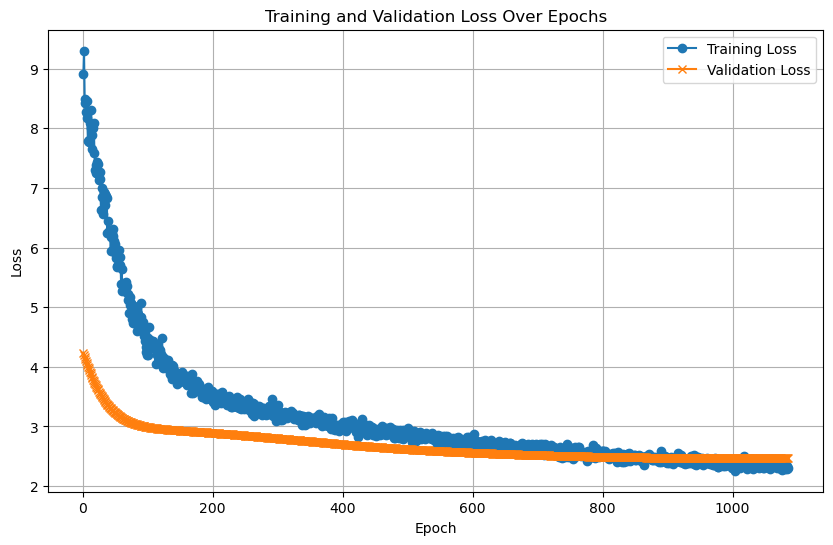

In [36]:
tscl_model = SupConNet().to(device)
tscl_criterion = SupConLoss(temperature=0.07).to(device)
tscl_optimizer = optim.Adam(tscl_model.parameters(), lr=1e-4, weight_decay=1e-5)  # Increased learning rate

tscl_patience = 100
tscl_best_val_loss = float('inf')
tscl_epochs_without_improvement = 0

tscl_num_epochs = 2000
tscl_train_losses = []
tscl_val_losses = []

# TRAINING
for tscl_epoch in range(tscl_num_epochs):
    print(f"\nLOG: Epoch [{tscl_epoch + 1}/{tscl_num_epochs}] - Training")
    tscl_model.train()
    tscl_total_loss = 0

    for batch_idx, (vectors, labels) in enumerate(tscl_train_loader):
        vectors = vectors.to(device).float()  # moving input tensors to GPU
        labels = labels.to(device)  # moving labels to GPU

        # forward pass to get projections
        projections = tscl_model(vectors)

        # calc contrastive loss
        loss = tscl_criterion(projections, labels)

        # backprop and optimization
        tscl_optimizer.zero_grad()
        loss.backward()
        tscl_optimizer.step()

        tscl_total_loss += loss.item()

        if (batch_idx + 1) % 1 == 0:
            print(f"    Batch [{batch_idx + 1}/{len(tscl_train_loader)}], "
                  f"Train Loss: {loss.item():.4f}")

    # calc avg training loss for the epoch
    tscl_avg_train_loss = tscl_total_loss / len(tscl_train_loader)
    tscl_train_losses.append(tscl_avg_train_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Train Loss: {tscl_avg_train_loss:.4f}")

    # VALIDATION
    tscl_model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for batch_idx, (vectors, labels) in enumerate(tscl_val_loader):
            vectors = vectors.to(device).float()
            labels = labels.to(device)

            projections = tscl_model(vectors)

            loss = tscl_criterion(projections, labels)
            total_val_loss += loss.item()

            if (batch_idx + 1) % 10 == 0:
                print(f"    Batch [{batch_idx + 1}/{len(tscl_val_loader)}], "
                      f"Val Loss: {loss.item():.4f}")

    tscl_avg_val_loss = total_val_loss / len(tscl_val_loader)
    tscl_val_losses.append(tscl_avg_val_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Val Loss: {tscl_avg_val_loss:.4f}")

    # early stopping logic
    if tscl_avg_val_loss < tscl_best_val_loss:
        print(f"Validation loss improved from {tscl_best_val_loss:.4f} to {tscl_avg_val_loss:.4f}. Saving model...")
        tscl_best_val_loss = tscl_avg_val_loss
        tscl_epochs_without_improvement = 0
    else:
        tscl_epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {tscl_epochs_without_improvement}/{tscl_patience}")

    # stopping training if validation loss hasn't improved for patience amount of epochs
    if tscl_epochs_without_improvement >= tscl_patience:
        print(f"Early stopping triggered at epoch {tscl_epoch + 1}. No improvement for {tscl_patience} epochs.")
        break

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(tscl_train_losses) + 1), tscl_train_losses, label="Training Loss", marker='o')
plt.plot(range(1, len(tscl_val_losses) + 1), tscl_val_losses, label="Validation Loss", marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

Test Batch [10/167], Loss: 4.9757
Test Batch [20/167], Loss: 4.8221
Test Batch [30/167], Loss: 4.8396


Test Batch [40/167], Loss: 4.8348
Test Batch [50/167], Loss: 4.9521
Test Batch [60/167], Loss: 5.0153
Test Batch [70/167], Loss: 4.9661
Test Batch [80/167], Loss: 4.9054
Test Batch [90/167], Loss: 5.0728
Test Batch [100/167], Loss: 5.0160
Test Batch [110/167], Loss: 4.9016
Test Batch [120/167], Loss: 4.7422
Test Batch [130/167], Loss: 4.6968
Test Batch [140/167], Loss: 4.7837
Test Batch [150/167], Loss: 4.9204


Test Batch [160/167], Loss: 4.6441

Test Loss: 4.9042


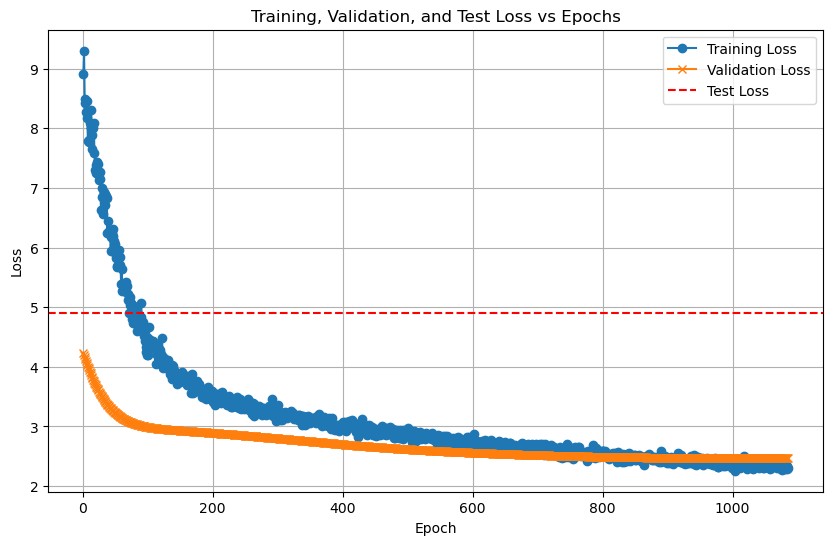

In [37]:
# Test Evaluation
tscl_model.eval()
total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(tscl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = tscl_model(vectors)
        loss = criterion(projections, labels)
        total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(tscl_test_loader)}], Loss: {loss.item():.4f}")

avg_test_loss = total_test_loss / len(tscl_test_loader)
print(f"\nTest Loss: {avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
epochs = range(1, len(tscl_train_losses) + 1)
plt.plot(epochs, tscl_train_losses, label="Training Loss", marker='o')
plt.plot(epochs, tscl_val_losses, label="Validation Loss", marker='x')
# test loss = horizontal dashed line
plt.axhline(y=avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving representations learnt by Typical SCL Model

In [38]:
# dir to save the SCL representations
tscl_rep_dir = "tscl_representations"
os.makedirs(tscl_rep_dir, exist_ok=True)

tscl_loaders = {
    'train': tscl_train_loader,
    'val': tscl_val_loader,
    'test': tscl_test_loader
}

tscl_model.eval()

with torch.no_grad():
    for tscl_split_name, tscl_loader in tscl_loaders.items():
        print(f"\nExtracting SCL representations for the {tscl_split_name} dataset...")
        # creating subfolder for the split
        tscl_split_dir = os.path.join(tscl_rep_dir, tscl_split_name)
        os.makedirs(tscl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for tscl_batch_idx, (tscl_vectors, tscl_labels) in enumerate(tscl_loader):
            tscl_vectors = tscl_vectors.to(device).float()
            # computing projections using the trained SCL model
            tscl_projections = tscl_model(tscl_vectors)
            
            # converting projections and labels to np arrays
            tscl_projections_np = tscl_projections.cpu().numpy()
            tscl_labels_np = tscl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(tscl_split_dir, f"scl_encoded_batch_{tscl_batch_idx}.npy"), tscl_projections_np)
            np.save(os.path.join(tscl_split_dir, f"scl_labels_batch_{tscl_batch_idx}.npy"), tscl_labels_np)
            
            if (tscl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {tscl_batch_idx + 1}/{len(tscl_loader)} for {tscl_split_name} dataset.")

        print(f"Completed extraction for the {tscl_split_name} dataset. Representations saved in '{tscl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'tscl_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'tscl_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/167 for test dataset.
  Processed batch 20/167 for test dataset.


  Processed batch 30/167 for test dataset.
  Processed batch 40/167 for test dataset.
  Processed batch 50/167 for test dataset.


  Processed batch 60/167 for test dataset.
  Processed batch 70/167 for test dataset.
  Processed batch 80/167 for test dataset.


  Processed batch 90/167 for test dataset.
  Processed batch 100/167 for test dataset.
  Processed batch 110/167 for test dataset.
  Processed batch 120/167 for test dataset.


  Processed batch 130/167 for test dataset.
  Processed batch 140/167 for test dataset.
  Processed batch 150/167 for test dataset.


  Processed batch 160/167 for test dataset.
Completed extraction for the test dataset. Representations saved in 'tscl_representations\test'.
SCL representations extraction complete.


### Classifying representations learnt by SCL Model with LRM

In [39]:
def load_tscl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    tscl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    tscl_all_reps = []
    tscl_all_labels = []

    for tscl_rep_file in tscl_rep_files:
        #deriving label filenames
        tscl_label_file = tscl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        tscl_reps = np.load(tscl_rep_file)
        tscl_labels = np.load(tscl_label_file)

        tscl_all_reps.append(tscl_reps)
        tscl_all_labels.append(tscl_labels)

    #concat along first dim
    tscl_all_reps = np.concatenate(tscl_all_reps, axis = 0)
    tscl_all_labels = np.concatenate(tscl_all_labels, axis = 0)

    return tscl_all_reps, tscl_all_labels

In [40]:
tscl_lrm_train_dir = os.path.join("tscl_representations", "train")
tscl_lrm_val_dir   = os.path.join("tscl_representations", "val")
tscl_lrm_test_dir  = os.path.join("tscl_representations", "test")

tscl_lrm_train_reps, tscl_lrm_train_labels = load_tscl_reps_and_labels(tscl_lrm_train_dir)
tscl_lrm_val_reps, tscl_lrm_val_labels = load_tscl_reps_and_labels(tscl_lrm_val_dir)
tscl_lrm_test_reps, tscl_lrm_test_labels = load_tscl_reps_and_labels(tscl_lrm_test_dir)

print("Train reps shape:", tscl_lrm_train_reps.shape)
print("Train labels shape:", tscl_lrm_train_labels.shape)

print("Val reps shape:", tscl_lrm_val_reps.shape)
print("Val labels shape:", tscl_lrm_val_labels.shape)

print("Test reps shape:", tscl_lrm_test_reps.shape)
print("Test labels shape:", tscl_lrm_test_labels.shape)

Train reps shape: (45, 128)
Train labels shape: (45,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (42686, 128)
Test labels shape: (42686,)


In [41]:
# training LRM on the tscl representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
tscl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
tscl_logistic_clf.fit(tscl_lrm_train_reps, tscl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# eval on val set
print("\nLOG: Evaluating on the validation set...")
tscl_lrm_val_predictions = tscl_logistic_clf.predict(tscl_lrm_val_reps)
tscl_lrm_val_accuracy = accuracy_score(tscl_lrm_val_labels, tscl_lrm_val_predictions)
print(f"Validation Accuracy: {tscl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(tscl_lrm_val_labels, tscl_lrm_val_predictions))

# eval on test
print("\nLOG: Evaluating on the test set...")
tscl_lrm_test_predictions = tscl_logistic_clf.predict(tscl_lrm_test_reps)
tscl_lrm_test_accuracy = accuracy_score(tscl_lrm_test_labels, tscl_lrm_test_predictions)
print(f"Test Accuracy: {tscl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(tscl_lrm_test_labels, tscl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'tscl_lrm_predictions.npy'), tscl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'tscl_lrm_true_labels.npy'), tscl_lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 73.33%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.40      0.57         5
           1       0.45      1.00      0.62         5
           2       0.62      1.00      0.77         5
           3       1.00      0.80      0.89         5
           4       1.00      1.00      1.00         5
           5       0.00      0.00      0.00         5
           6       0.67      0.80      0.73         5
           7       0.75      0.60      0.67         5
           8       1.00      1.00      1.00         5

    accuracy                           0.73        45
   macro avg       0.72      0.73      0.69        45
weighted avg       0.72      0.73      0.69        45


LOG: Evaluating on the test set...
Test Accuracy: 70.40%

Test Classifica

C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Classifying the representations learnt by Typical SCL Model with MLP Classifier

In [42]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [43]:
tscl_mlp_train_dir = os.path.join("tscl_representations", "train")
tscl_mlp_val_dir   = os.path.join("tscl_representations", "val")
tscl_mlp_test_dir  = os.path.join("tscl_representations", "test")

tscl_mlp_train_reps, tscl_mlp_train_labels = load_tscl_reps_and_labels(tscl_mlp_train_dir)
tscl_mlp_val_reps, tscl_mlp_val_labels = load_tscl_reps_and_labels(tscl_mlp_val_dir)
tscl_mlp_test_reps, tscl_mlp_test_labels = load_tscl_reps_and_labels(tscl_mlp_test_dir)

print("Train reps shape:",tscl_mlp_train_reps.shape)
print("Train labels shape:", tscl_mlp_train_labels.shape)

print("Val reps shape:", tscl_mlp_val_reps.shape)
print("Val labels shape:", tscl_mlp_val_labels.shape)

print("Test reps shape:", tscl_mlp_test_reps.shape)
print("Test labels shape:", tscl_mlp_test_labels.shape)

Train reps shape: (45, 128)
Train labels shape: (45,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (42686, 128)
Test labels shape: (42686,)


In [44]:
#converting arrays to torch tensors
tscl_mlp_train_embeddings_torch = torch.tensor(tscl_mlp_train_reps, dtype=torch.float32)
tscl_mlp_train_labels_torch = torch.tensor(tscl_mlp_train_labels, dtype=torch.long)

tscl_mlp_val_embeddings_torch = torch.tensor(tscl_mlp_val_reps, dtype=torch.float32)
tscl_mlp_val_labels_torch = torch.tensor(tscl_mlp_val_labels, dtype=torch.long)

tscl_mlp_test_embeddings_torch = torch.tensor(tscl_mlp_test_reps, dtype=torch.float32)
tscl_mlp_test_labels_torch = torch.tensor(tscl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
tscl_mlp_train_dataset = TensorDataset(tscl_mlp_train_embeddings_torch, tscl_mlp_train_labels_torch)
tscl_mlp_val_dataset = TensorDataset(tscl_mlp_val_embeddings_torch, tscl_mlp_val_labels_torch)
tscl_mlp_test_dataset = TensorDataset(tscl_mlp_test_embeddings_torch, tscl_mlp_test_labels_torch)

tscl_mlp_batch_size = 64
tscl_mlp_train_loader = DataLoader(tscl_mlp_train_dataset, batch_size=tscl_mlp_batch_size, shuffle=True)
tscl_mlp_val_loader = DataLoader(tscl_mlp_val_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)
tscl_mlp_test_loader = DataLoader(tscl_mlp_test_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.3880  |  Val Loss: 2.3831
Validation loss improved from inf to 2.3831.


[Epoch 2/1000] Train Loss: 2.3756  |  Val Loss: 2.3718
Validation loss improved from 2.3831 to 2.3718.
[Epoch 3/1000] Train Loss: 2.3633  |  Val Loss: 2.3607
Validation loss improved from 2.3718 to 2.3607.
[Epoch 4/1000] Train Loss: 2.3513  |  Val Loss: 2.3499
Validation loss improved from 2.3607 to 2.3499.
[Epoch 5/1000] Train Loss: 2.3396  |  Val Loss: 2.3394
Validation loss improved from 2.3499 to 2.3394.
[Epoch 6/1000] Train Loss: 2.3281  |  Val Loss: 2.3292
Validation loss improved from 2.3394 to 2.3292.
[Epoch 7/1000] Train Loss: 2.3165  |  Val Loss: 2.3193
Validation loss improved from 2.3292 to 2.3193.
[Epoch 8/1000] Train Loss: 2.3047  |  Val Loss: 2.3090
Validation loss improved from 2.3193 to 2.3090.
[Epoch 9/1000] Train Loss: 2.2927  |  Val Loss: 2.2987
Validation loss improved from 2.3090 to 2.2987.
[Epoch 10/1000] Train Loss: 2.2811  |  Val Loss: 2.2888
Validation loss improved from 2.2987 to 2.2888.
[Epoch 11/1000] Train Loss: 2.2700  |  Val Loss: 2.2791
Validation loss 

[Epoch 16/1000] Train Loss: 2.2181  |  Val Loss: 2.2334
Validation loss improved from 2.2421 to 2.2334.
[Epoch 17/1000] Train Loss: 2.2085  |  Val Loss: 2.2250
Validation loss improved from 2.2334 to 2.2250.
[Epoch 18/1000] Train Loss: 2.1993  |  Val Loss: 2.2168
Validation loss improved from 2.2250 to 2.2168.
[Epoch 19/1000] Train Loss: 2.1902  |  Val Loss: 2.2088
Validation loss improved from 2.2168 to 2.2088.
[Epoch 20/1000] Train Loss: 2.1814  |  Val Loss: 2.2009
Validation loss improved from 2.2088 to 2.2009.
[Epoch 21/1000] Train Loss: 2.1729  |  Val Loss: 2.1933
Validation loss improved from 2.2009 to 2.1933.
[Epoch 22/1000] Train Loss: 2.1647  |  Val Loss: 2.1860
Validation loss improved from 2.1933 to 2.1860.
[Epoch 23/1000] Train Loss: 2.1573  |  Val Loss: 2.1791
Validation loss improved from 2.1860 to 2.1791.
[Epoch 24/1000] Train Loss: 2.1504  |  Val Loss: 2.1727
Validation loss improved from 2.1791 to 2.1727.
[Epoch 25/1000] Train Loss: 2.1437  |  Val Loss: 2.1666
Validati

[Epoch 61/1000] Train Loss: 1.9167  |  Val Loss: 1.9664
Validation loss improved from 1.9717 to 1.9664.
[Epoch 62/1000] Train Loss: 1.9110  |  Val Loss: 1.9611
Validation loss improved from 1.9664 to 1.9611.
[Epoch 63/1000] Train Loss: 1.9052  |  Val Loss: 1.9558
Validation loss improved from 1.9611 to 1.9558.
[Epoch 64/1000] Train Loss: 1.8993  |  Val Loss: 1.9503
Validation loss improved from 1.9558 to 1.9503.
[Epoch 65/1000] Train Loss: 1.8934  |  Val Loss: 1.9449
Validation loss improved from 1.9503 to 1.9449.
[Epoch 66/1000] Train Loss: 1.8875  |  Val Loss: 1.9395
Validation loss improved from 1.9449 to 1.9395.
[Epoch 67/1000] Train Loss: 1.8815  |  Val Loss: 1.9341
Validation loss improved from 1.9395 to 1.9341.
[Epoch 68/1000] Train Loss: 1.8757  |  Val Loss: 1.9287
Validation loss improved from 1.9341 to 1.9287.
[Epoch 69/1000] Train Loss: 1.8698  |  Val Loss: 1.9234
Validation loss improved from 1.9287 to 1.9234.
[Epoch 70/1000] Train Loss: 1.8639  |  Val Loss: 1.9181
Validati

[Epoch 80/1000] Train Loss: 1.8045  |  Val Loss: 1.8662
Validation loss improved from 1.8715 to 1.8662.
[Epoch 81/1000] Train Loss: 1.7984  |  Val Loss: 1.8610
Validation loss improved from 1.8662 to 1.8610.
[Epoch 82/1000] Train Loss: 1.7923  |  Val Loss: 1.8558
Validation loss improved from 1.8610 to 1.8558.
[Epoch 83/1000] Train Loss: 1.7863  |  Val Loss: 1.8507
Validation loss improved from 1.8558 to 1.8507.
[Epoch 84/1000] Train Loss: 1.7803  |  Val Loss: 1.8456
Validation loss improved from 1.8507 to 1.8456.
[Epoch 85/1000] Train Loss: 1.7742  |  Val Loss: 1.8405
Validation loss improved from 1.8456 to 1.8405.
[Epoch 86/1000] Train Loss: 1.7681  |  Val Loss: 1.8353
Validation loss improved from 1.8405 to 1.8353.
[Epoch 87/1000] Train Loss: 1.7620  |  Val Loss: 1.8302
Validation loss improved from 1.8353 to 1.8302.
[Epoch 88/1000] Train Loss: 1.7559  |  Val Loss: 1.8251
Validation loss improved from 1.8302 to 1.8251.
[Epoch 89/1000] Train Loss: 1.7498  |  Val Loss: 1.8199
Validati

[Epoch 91/1000] Train Loss: 1.7377  |  Val Loss: 1.8098
Validation loss improved from 1.8148 to 1.8098.
[Epoch 92/1000] Train Loss: 1.7317  |  Val Loss: 1.8047
Validation loss improved from 1.8098 to 1.8047.
[Epoch 93/1000] Train Loss: 1.7256  |  Val Loss: 1.7996
Validation loss improved from 1.8047 to 1.7996.
[Epoch 94/1000] Train Loss: 1.7195  |  Val Loss: 1.7944
Validation loss improved from 1.7996 to 1.7944.
[Epoch 95/1000] Train Loss: 1.7135  |  Val Loss: 1.7893
Validation loss improved from 1.7944 to 1.7893.
[Epoch 96/1000] Train Loss: 1.7075  |  Val Loss: 1.7842
Validation loss improved from 1.7893 to 1.7842.
[Epoch 97/1000] Train Loss: 1.7016  |  Val Loss: 1.7791
Validation loss improved from 1.7842 to 1.7791.
[Epoch 98/1000] Train Loss: 1.6956  |  Val Loss: 1.7740
Validation loss improved from 1.7791 to 1.7740.
[Epoch 99/1000] Train Loss: 1.6898  |  Val Loss: 1.7690
Validation loss improved from 1.7740 to 1.7690.
[Epoch 100/1000] Train Loss: 1.6839  |  Val Loss: 1.7640
Validat

[Epoch 136/1000] Train Loss: 1.4681  |  Val Loss: 1.5900
Validation loss improved from 1.5947 to 1.5900.
[Epoch 137/1000] Train Loss: 1.4622  |  Val Loss: 1.5853
Validation loss improved from 1.5900 to 1.5853.
[Epoch 138/1000] Train Loss: 1.4563  |  Val Loss: 1.5807
Validation loss improved from 1.5853 to 1.5807.
[Epoch 139/1000] Train Loss: 1.4503  |  Val Loss: 1.5761
Validation loss improved from 1.5807 to 1.5761.
[Epoch 140/1000] Train Loss: 1.4445  |  Val Loss: 1.5715
Validation loss improved from 1.5761 to 1.5715.
[Epoch 141/1000] Train Loss: 1.4386  |  Val Loss: 1.5670
Validation loss improved from 1.5715 to 1.5670.
[Epoch 142/1000] Train Loss: 1.4329  |  Val Loss: 1.5625
Validation loss improved from 1.5670 to 1.5625.
[Epoch 143/1000] Train Loss: 1.4271  |  Val Loss: 1.5581
Validation loss improved from 1.5625 to 1.5581.
[Epoch 144/1000] Train Loss: 1.4214  |  Val Loss: 1.5537
Validation loss improved from 1.5581 to 1.5537.
[Epoch 145/1000] Train Loss: 1.4158  |  Val Loss: 1.549

[Epoch 158/1000] Train Loss: 1.3428  |  Val Loss: 1.4948
Validation loss improved from 1.4989 to 1.4948.
[Epoch 159/1000] Train Loss: 1.3373  |  Val Loss: 1.4907
Validation loss improved from 1.4948 to 1.4907.
[Epoch 160/1000] Train Loss: 1.3318  |  Val Loss: 1.4867
Validation loss improved from 1.4907 to 1.4867.
[Epoch 161/1000] Train Loss: 1.3264  |  Val Loss: 1.4826
Validation loss improved from 1.4867 to 1.4826.
[Epoch 162/1000] Train Loss: 1.3210  |  Val Loss: 1.4786
Validation loss improved from 1.4826 to 1.4786.
[Epoch 163/1000] Train Loss: 1.3156  |  Val Loss: 1.4746
Validation loss improved from 1.4786 to 1.4746.
[Epoch 164/1000] Train Loss: 1.3102  |  Val Loss: 1.4706
Validation loss improved from 1.4746 to 1.4706.
[Epoch 165/1000] Train Loss: 1.3049  |  Val Loss: 1.4665
Validation loss improved from 1.4706 to 1.4665.
[Epoch 166/1000] Train Loss: 1.2995  |  Val Loss: 1.4625
Validation loss improved from 1.4665 to 1.4625.
[Epoch 167/1000] Train Loss: 1.2941  |  Val Loss: 1.458

[Epoch 216/1000] Train Loss: 1.0460  |  Val Loss: 1.2753
Validation loss improved from 1.2786 to 1.2753.
[Epoch 217/1000] Train Loss: 1.0415  |  Val Loss: 1.2720
Validation loss improved from 1.2753 to 1.2720.
[Epoch 218/1000] Train Loss: 1.0369  |  Val Loss: 1.2687
Validation loss improved from 1.2720 to 1.2687.
[Epoch 219/1000] Train Loss: 1.0323  |  Val Loss: 1.2653
Validation loss improved from 1.2687 to 1.2653.
[Epoch 220/1000] Train Loss: 1.0277  |  Val Loss: 1.2620
Validation loss improved from 1.2653 to 1.2620.
[Epoch 221/1000] Train Loss: 1.0231  |  Val Loss: 1.2587
Validation loss improved from 1.2620 to 1.2587.
[Epoch 222/1000] Train Loss: 1.0185  |  Val Loss: 1.2555
Validation loss improved from 1.2587 to 1.2555.
[Epoch 223/1000] Train Loss: 1.0140  |  Val Loss: 1.2523
Validation loss improved from 1.2555 to 1.2523.
[Epoch 224/1000] Train Loss: 1.0095  |  Val Loss: 1.2491
Validation loss improved from 1.2523 to 1.2491.
[Epoch 225/1000] Train Loss: 1.0051  |  Val Loss: 1.245

[Epoch 233/1000] Train Loss: 0.9707  |  Val Loss: 1.2209
Validation loss improved from 1.2240 to 1.2209.
[Epoch 234/1000] Train Loss: 0.9665  |  Val Loss: 1.2179
Validation loss improved from 1.2209 to 1.2179.
[Epoch 235/1000] Train Loss: 0.9623  |  Val Loss: 1.2149
Validation loss improved from 1.2179 to 1.2149.
[Epoch 236/1000] Train Loss: 0.9581  |  Val Loss: 1.2120
Validation loss improved from 1.2149 to 1.2120.
[Epoch 237/1000] Train Loss: 0.9539  |  Val Loss: 1.2090
Validation loss improved from 1.2120 to 1.2090.
[Epoch 238/1000] Train Loss: 0.9498  |  Val Loss: 1.2060
Validation loss improved from 1.2090 to 1.2060.
[Epoch 239/1000] Train Loss: 0.9457  |  Val Loss: 1.2031
Validation loss improved from 1.2060 to 1.2031.
[Epoch 240/1000] Train Loss: 0.9416  |  Val Loss: 1.2001
Validation loss improved from 1.2031 to 1.2001.
[Epoch 241/1000] Train Loss: 0.9375  |  Val Loss: 1.1972
Validation loss improved from 1.2001 to 1.1972.
[Epoch 242/1000] Train Loss: 0.9334  |  Val Loss: 1.194

[Epoch 293/1000] Train Loss: 0.7450  |  Val Loss: 1.0597
Validation loss improved from 1.0620 to 1.0597.
[Epoch 294/1000] Train Loss: 0.7416  |  Val Loss: 1.0574
Validation loss improved from 1.0597 to 1.0574.
[Epoch 295/1000] Train Loss: 0.7383  |  Val Loss: 1.0552
Validation loss improved from 1.0574 to 1.0552.
[Epoch 296/1000] Train Loss: 0.7350  |  Val Loss: 1.0529
Validation loss improved from 1.0552 to 1.0529.
[Epoch 297/1000] Train Loss: 0.7316  |  Val Loss: 1.0507
Validation loss improved from 1.0529 to 1.0507.
[Epoch 298/1000] Train Loss: 0.7283  |  Val Loss: 1.0484
Validation loss improved from 1.0507 to 1.0484.
[Epoch 299/1000] Train Loss: 0.7250  |  Val Loss: 1.0462
Validation loss improved from 1.0484 to 1.0462.
[Epoch 300/1000] Train Loss: 0.7217  |  Val Loss: 1.0439
Validation loss improved from 1.0462 to 1.0439.
[Epoch 301/1000] Train Loss: 0.7184  |  Val Loss: 1.0417
Validation loss improved from 1.0439 to 1.0417.
[Epoch 302/1000] Train Loss: 0.7152  |  Val Loss: 1.039

[Epoch 307/1000] Train Loss: 0.6989  |  Val Loss: 1.0283
Validation loss improved from 1.0306 to 1.0283.
[Epoch 308/1000] Train Loss: 0.6957  |  Val Loss: 1.0260
Validation loss improved from 1.0283 to 1.0260.
[Epoch 309/1000] Train Loss: 0.6925  |  Val Loss: 1.0238
Validation loss improved from 1.0260 to 1.0238.
[Epoch 310/1000] Train Loss: 0.6892  |  Val Loss: 1.0216
Validation loss improved from 1.0238 to 1.0216.
[Epoch 311/1000] Train Loss: 0.6860  |  Val Loss: 1.0194
Validation loss improved from 1.0216 to 1.0194.
[Epoch 312/1000] Train Loss: 0.6828  |  Val Loss: 1.0172
Validation loss improved from 1.0194 to 1.0172.
[Epoch 313/1000] Train Loss: 0.6796  |  Val Loss: 1.0150
Validation loss improved from 1.0172 to 1.0150.
[Epoch 314/1000] Train Loss: 0.6764  |  Val Loss: 1.0129
Validation loss improved from 1.0150 to 1.0129.
[Epoch 315/1000] Train Loss: 0.6732  |  Val Loss: 1.0107
Validation loss improved from 1.0129 to 1.0107.
[Epoch 316/1000] Train Loss: 0.6700  |  Val Loss: 1.008

[Epoch 366/1000] Train Loss: 0.5082  |  Val Loss: 0.9011
Validation loss improved from 0.9029 to 0.9011.
[Epoch 367/1000] Train Loss: 0.5053  |  Val Loss: 0.8992
Validation loss improved from 0.9011 to 0.8992.
[Epoch 368/1000] Train Loss: 0.5024  |  Val Loss: 0.8973
Validation loss improved from 0.8992 to 0.8973.
[Epoch 369/1000] Train Loss: 0.4995  |  Val Loss: 0.8955
Validation loss improved from 0.8973 to 0.8955.
[Epoch 370/1000] Train Loss: 0.4967  |  Val Loss: 0.8937
Validation loss improved from 0.8955 to 0.8937.
[Epoch 371/1000] Train Loss: 0.4939  |  Val Loss: 0.8918
Validation loss improved from 0.8937 to 0.8918.
[Epoch 372/1000] Train Loss: 0.4911  |  Val Loss: 0.8900
Validation loss improved from 0.8918 to 0.8900.
[Epoch 373/1000] Train Loss: 0.4884  |  Val Loss: 0.8882
Validation loss improved from 0.8900 to 0.8882.
[Epoch 374/1000] Train Loss: 0.4857  |  Val Loss: 0.8864
Validation loss improved from 0.8882 to 0.8864.
[Epoch 375/1000] Train Loss: 0.4830  |  Val Loss: 0.884

[Epoch 382/1000] Train Loss: 0.4647  |  Val Loss: 0.8728
Validation loss improved from 0.8744 to 0.8728.
[Epoch 383/1000] Train Loss: 0.4622  |  Val Loss: 0.8711
Validation loss improved from 0.8728 to 0.8711.
[Epoch 384/1000] Train Loss: 0.4596  |  Val Loss: 0.8695
Validation loss improved from 0.8711 to 0.8695.
[Epoch 385/1000] Train Loss: 0.4571  |  Val Loss: 0.8679
Validation loss improved from 0.8695 to 0.8679.
[Epoch 386/1000] Train Loss: 0.4546  |  Val Loss: 0.8664
Validation loss improved from 0.8679 to 0.8664.
[Epoch 387/1000] Train Loss: 0.4521  |  Val Loss: 0.8649
Validation loss improved from 0.8664 to 0.8649.
[Epoch 388/1000] Train Loss: 0.4497  |  Val Loss: 0.8634
Validation loss improved from 0.8649 to 0.8634.
[Epoch 389/1000] Train Loss: 0.4473  |  Val Loss: 0.8618
Validation loss improved from 0.8634 to 0.8618.
[Epoch 390/1000] Train Loss: 0.4448  |  Val Loss: 0.8603
Validation loss improved from 0.8618 to 0.8603.
[Epoch 391/1000] Train Loss: 0.4424  |  Val Loss: 0.858

[Epoch 449/1000] Train Loss: 0.3265  |  Val Loss: 0.7929
Validation loss improved from 0.7938 to 0.7929.
[Epoch 450/1000] Train Loss: 0.3249  |  Val Loss: 0.7920
Validation loss improved from 0.7929 to 0.7920.
[Epoch 451/1000] Train Loss: 0.3233  |  Val Loss: 0.7912
Validation loss improved from 0.7920 to 0.7912.
[Epoch 452/1000] Train Loss: 0.3217  |  Val Loss: 0.7903
Validation loss improved from 0.7912 to 0.7903.
[Epoch 453/1000] Train Loss: 0.3201  |  Val Loss: 0.7895
Validation loss improved from 0.7903 to 0.7895.
[Epoch 454/1000] Train Loss: 0.3186  |  Val Loss: 0.7887
Validation loss improved from 0.7895 to 0.7887.
[Epoch 455/1000] Train Loss: 0.3170  |  Val Loss: 0.7880
Validation loss improved from 0.7887 to 0.7880.
[Epoch 456/1000] Train Loss: 0.3155  |  Val Loss: 0.7872
Validation loss improved from 0.7880 to 0.7872.
[Epoch 457/1000] Train Loss: 0.3140  |  Val Loss: 0.7864
Validation loss improved from 0.7872 to 0.7864.
[Epoch 458/1000] Train Loss: 0.3125  |  Val Loss: 0.785

[Epoch 465/1000] Train Loss: 0.3022  |  Val Loss: 0.7807
Validation loss improved from 0.7814 to 0.7807.
[Epoch 466/1000] Train Loss: 0.3008  |  Val Loss: 0.7801
Validation loss improved from 0.7807 to 0.7801.
[Epoch 467/1000] Train Loss: 0.2993  |  Val Loss: 0.7794
Validation loss improved from 0.7801 to 0.7794.
[Epoch 468/1000] Train Loss: 0.2979  |  Val Loss: 0.7787
Validation loss improved from 0.7794 to 0.7787.
[Epoch 469/1000] Train Loss: 0.2965  |  Val Loss: 0.7781
Validation loss improved from 0.7787 to 0.7781.
[Epoch 470/1000] Train Loss: 0.2952  |  Val Loss: 0.7775
Validation loss improved from 0.7781 to 0.7775.
[Epoch 471/1000] Train Loss: 0.2938  |  Val Loss: 0.7768
Validation loss improved from 0.7775 to 0.7768.
[Epoch 472/1000] Train Loss: 0.2924  |  Val Loss: 0.7762
Validation loss improved from 0.7768 to 0.7762.
[Epoch 473/1000] Train Loss: 0.2911  |  Val Loss: 0.7756
Validation loss improved from 0.7762 to 0.7756.
[Epoch 474/1000] Train Loss: 0.2897  |  Val Loss: 0.775

[Epoch 526/1000] Train Loss: 0.2324  |  Val Loss: 0.7510
Validation loss improved from 0.7512 to 0.7510.
[Epoch 527/1000] Train Loss: 0.2315  |  Val Loss: 0.7508
Validation loss improved from 0.7510 to 0.7508.
[Epoch 528/1000] Train Loss: 0.2306  |  Val Loss: 0.7506
Validation loss improved from 0.7508 to 0.7506.
[Epoch 529/1000] Train Loss: 0.2297  |  Val Loss: 0.7504
Validation loss improved from 0.7506 to 0.7504.
[Epoch 530/1000] Train Loss: 0.2288  |  Val Loss: 0.7502
Validation loss improved from 0.7504 to 0.7502.
[Epoch 531/1000] Train Loss: 0.2280  |  Val Loss: 0.7499
Validation loss improved from 0.7502 to 0.7499.
[Epoch 532/1000] Train Loss: 0.2271  |  Val Loss: 0.7496
Validation loss improved from 0.7499 to 0.7496.
[Epoch 533/1000] Train Loss: 0.2263  |  Val Loss: 0.7493
Validation loss improved from 0.7496 to 0.7493.
[Epoch 534/1000] Train Loss: 0.2254  |  Val Loss: 0.7491
Validation loss improved from 0.7493 to 0.7491.
[Epoch 535/1000] Train Loss: 0.2246  |  Val Loss: 0.748

[Epoch 542/1000] Train Loss: 0.2188  |  Val Loss: 0.7474
Validation loss improved from 0.7477 to 0.7474.
[Epoch 543/1000] Train Loss: 0.2180  |  Val Loss: 0.7471
Validation loss improved from 0.7474 to 0.7471.
[Epoch 544/1000] Train Loss: 0.2173  |  Val Loss: 0.7467
Validation loss improved from 0.7471 to 0.7467.
[Epoch 545/1000] Train Loss: 0.2165  |  Val Loss: 0.7463
Validation loss improved from 0.7467 to 0.7463.
[Epoch 546/1000] Train Loss: 0.2157  |  Val Loss: 0.7459
Validation loss improved from 0.7463 to 0.7459.
[Epoch 547/1000] Train Loss: 0.2149  |  Val Loss: 0.7456
Validation loss improved from 0.7459 to 0.7456.
[Epoch 548/1000] Train Loss: 0.2141  |  Val Loss: 0.7452
Validation loss improved from 0.7456 to 0.7452.
[Epoch 549/1000] Train Loss: 0.2134  |  Val Loss: 0.7449
Validation loss improved from 0.7452 to 0.7449.
[Epoch 550/1000] Train Loss: 0.2126  |  Val Loss: 0.7446
Validation loss improved from 0.7449 to 0.7446.
[Epoch 551/1000] Train Loss: 0.2118  |  Val Loss: 0.744

[Epoch 608/1000] Train Loss: 0.1765  |  Val Loss: 0.7370
Validation loss improved from 0.7371 to 0.7370.
[Epoch 609/1000] Train Loss: 0.1759  |  Val Loss: 0.7370
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 610/1000] Train Loss: 0.1754  |  Val Loss: 0.7371
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 611/1000] Train Loss: 0.1749  |  Val Loss: 0.7371
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 612/1000] Train Loss: 0.1744  |  Val Loss: 0.7371
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 613/1000] Train Loss: 0.1739  |  Val Loss: 0.7371
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 614/1000] Train Loss: 0.1734  |  Val Loss: 0.7369
Validation loss improved from 0.7370 to 0.7369.
[Epoch 615/1000] Train Loss: 0.1729  |  Val Loss: 0.7368
Validation loss improved from 0.7369 to 0.7368.
[Epoch 616/1000] Train Loss: 0.1724  |  Val Loss: 0.7368
Validation loss improved from 0.7368 to 0.7368.
[Epoch 617/1000] Train Lo

[Epoch 618/1000] Train Loss: 0.1715  |  Val Loss: 0.7369
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 619/1000] Train Loss: 0.1710  |  Val Loss: 0.7369
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 620/1000] Train Loss: 0.1705  |  Val Loss: 0.7369
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 621/1000] Train Loss: 0.1700  |  Val Loss: 0.7369
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 622/1000] Train Loss: 0.1696  |  Val Loss: 0.7368
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 623/1000] Train Loss: 0.1691  |  Val Loss: 0.7368
Validation loss improved from 0.7368 to 0.7368.
[Epoch 624/1000] Train Loss: 0.1686  |  Val Loss: 0.7367
Validation loss improved from 0.7368 to 0.7367.
[Epoch 625/1000] Train Loss: 0.1682  |  Val Loss: 0.7366
Validation loss improved from 0.7367 to 0.7366.
[Epoch 626/1000] Train Loss: 0.1677  |  Val Loss: 0.7366
Validation loss improved from 0.7366 to 0.7366.
[Epoch 627/1000] Train Lo

[Epoch 675/1000] Train Loss: 0.1480  |  Val Loss: 0.7384
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 676/1000] Train Loss: 0.1476  |  Val Loss: 0.7384
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 677/1000] Train Loss: 0.1473  |  Val Loss: 0.7385
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 678/1000] Train Loss: 0.1470  |  Val Loss: 0.7386
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 679/1000] Train Loss: 0.1466  |  Val Loss: 0.7387
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 680/1000] Train Loss: 0.1463  |  Val Loss: 0.7388
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 681/1000] Train Loss: 0.1459  |  Val Loss: 0.7389
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 682/1000] Train Loss: 0.1456  |  Val Loss: 0.7390
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 683/1000] Train Loss: 0.1453  |  Val Loss: 0.7391
!! Validation loss did NOT improve !! Patience:

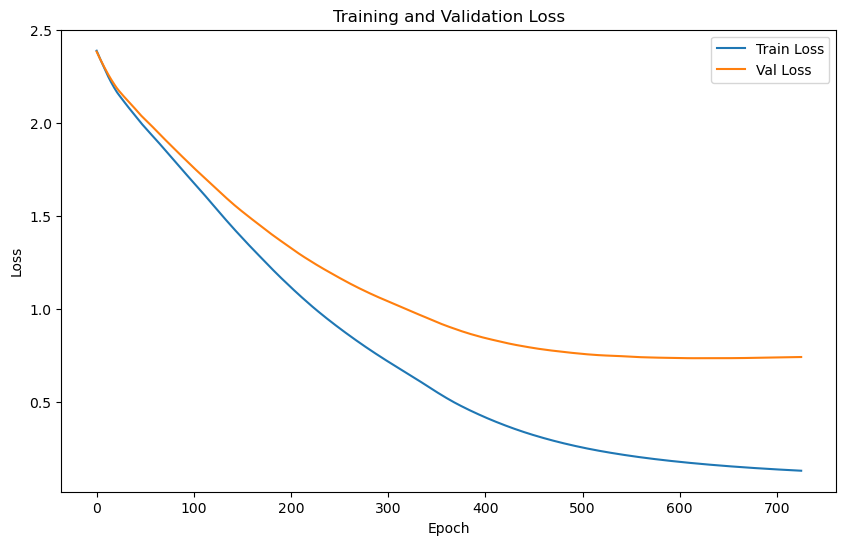

In [45]:
tscl_mlp_input_dim = tscl_mlp_train_reps.shape[1]
tscl_mlp_num_classes = len(torch.unique(tscl_mlp_train_labels_torch))
tscl_mlp_model = MLPClassifier(tscl_mlp_input_dim, tscl_mlp_num_classes).to(device)

tscl_mlp_criterion = nn.CrossEntropyLoss()
tscl_mlp_optimizer = optim.Adam(tscl_mlp_model.parameters(), lr=1e-4)

tscl_mlp_num_epochs = 1000
tscl_mlp_patience = 100

tscl_mlp_train_losses = []
tscl_mlp_val_losses = []

tscl_mlp_best_val_loss = float('inf')
tscl_mlp_epochs_without_improvement = 0

for tscl_mlp_epoch in range(tscl_mlp_num_epochs):
    # Training
    tscl_mlp_model.train()
    tscl_mlp_train_running_loss = 0.0
    
    for tscl_mlp_embeddings_batch, tscl_mlp_labels_batch in tscl_mlp_train_loader:
        tscl_mlp_embeddings_batch = tscl_mlp_embeddings_batch.to(device)
        tscl_mlp_labels_batch = tscl_mlp_labels_batch.to(device)
        
        tscl_mlp_optimizer.zero_grad()
        
        # Forward
        tscl_mlp_outputs = tscl_mlp_model(tscl_mlp_embeddings_batch)
        tscl_mlp_loss = tscl_mlp_criterion(tscl_mlp_outputs, tscl_mlp_labels_batch)
        
        # Backward & Update
        tscl_mlp_loss.backward()
        tscl_mlp_optimizer.step()
        
        tscl_mlp_train_running_loss += tscl_mlp_loss.item() * tscl_mlp_embeddings_batch.size(0)
    
    tscl_mlp_epoch_train_loss = tscl_mlp_train_running_loss / len(tscl_mlp_train_loader.dataset)
    tscl_mlp_train_losses.append(tscl_mlp_epoch_train_loss)

    # Validation
    tscl_mlp_model.eval()
    tscl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for tscl_mlp_val_embeddings_batch, tscl_mlp_val_labels_batch in tscl_mlp_val_loader:
            tscl_mlp_val_embeddings_batch = tscl_mlp_val_embeddings_batch.to(device)
            tscl_mlp_val_labels_batch = tscl_mlp_val_labels_batch.to(device)

            tscl_mlp_val_outputs = tscl_mlp_model(tscl_mlp_val_embeddings_batch)
            tscl_mlp_val_loss = tscl_mlp_criterion(tscl_mlp_val_outputs, tscl_mlp_val_labels_batch)

            tscl_mlp_val_running_loss += tscl_mlp_val_loss.item() * tscl_mlp_val_embeddings_batch.size(0)

    tscl_mlp_epoch_val_loss = tscl_mlp_val_running_loss / len(tscl_mlp_val_loader.dataset)
    tscl_mlp_val_losses.append(tscl_mlp_epoch_val_loss)

    print(f"[Epoch {tscl_mlp_epoch+1}/{tscl_mlp_num_epochs}] "
          f"Train Loss: {tscl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {tscl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if tscl_mlp_epoch_val_loss < tscl_mlp_best_val_loss:
        print(f"Validation loss improved from {tscl_mlp_best_val_loss:.4f} to {tscl_mlp_epoch_val_loss:.4f}.")
        tscl_mlp_best_val_loss = tscl_mlp_epoch_val_loss
        tscl_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        tscl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {tscl_mlp_epochs_without_improvement}/{tscl_mlp_patience}")
        
        if tscl_mlp_epochs_without_improvement >= tscl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {tscl_mlp_epoch+1} !!\n"
                  f"No improvement for {tscl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(tscl_mlp_train_losses, label='Train Loss')
plt.plot(tscl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved TSCL+MLP predictions and true labels to model_predictions
Test Loss: 0.8494 | Test Accuracy: 71.64%


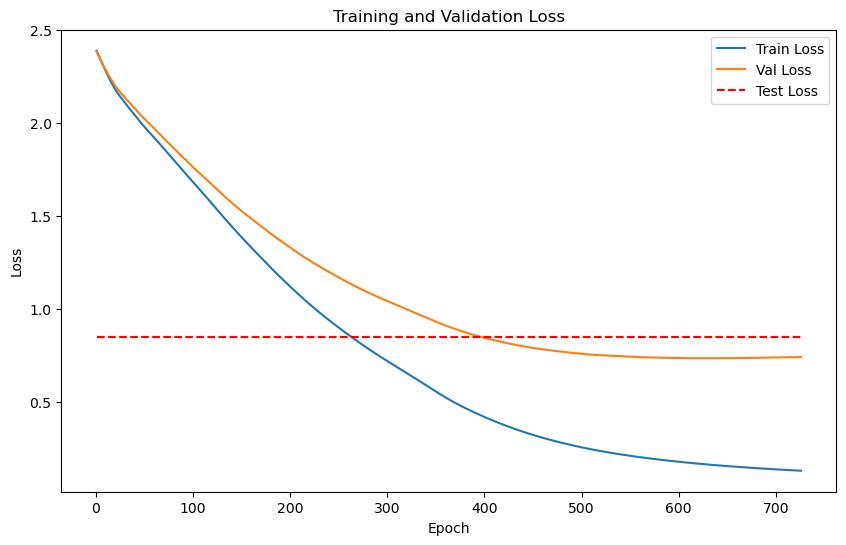

In [46]:
tscl_mlp_model.eval()

tscl_mlp_test_running_loss = 0.0
tscl_mlp_test_correct = 0
tscl_mlp_all_predictions = []
tscl_mlp_all_true_labels = []

with torch.no_grad():
    for tscl_mlp_test_embeddings_batch, tscl_mlp_test_labels_batch in tscl_mlp_test_loader:
        tscl_mlp_test_embeddings_batch = tscl_mlp_test_embeddings_batch.to(device)
        tscl_mlp_test_labels_batch = tscl_mlp_test_labels_batch.to(device)

        tscl_mlp_test_outputs = tscl_mlp_model(tscl_mlp_test_embeddings_batch)
        
        tscl_mlp_test_loss_batch = tscl_mlp_criterion(tscl_mlp_test_outputs, tscl_mlp_test_labels_batch)
        tscl_mlp_test_running_loss += tscl_mlp_test_loss_batch.item() * tscl_mlp_test_embeddings_batch.size(0)

        _, tscl_mlp_test_predicted = torch.max(tscl_mlp_test_outputs, dim=1)
        tscl_mlp_test_correct += (tscl_mlp_test_predicted == tscl_mlp_test_labels_batch).sum().item()

        tscl_mlp_all_predictions.extend(tscl_mlp_test_predicted.cpu().numpy())
        tscl_mlp_all_true_labels.extend(tscl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'tscl_mlp_predictions.npy'), np.array(tscl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'tscl_mlp_true_labels.npy'), np.array(tscl_mlp_all_true_labels))
print(f"Saved TSCL+MLP predictions and true labels to {predictions_dir}")

tscl_mlp_epoch_test_loss = tscl_mlp_test_running_loss / len(tscl_mlp_test_loader.dataset)
tscl_mlp_test_accuracy = tscl_mlp_test_correct / len(tscl_mlp_test_loader.dataset)

tscl_mlp_test_accuracy_pct = tscl_mlp_test_accuracy * 100.0

print(f"Test Loss: {tscl_mlp_epoch_test_loss:.4f} | Test Accuracy: {tscl_mlp_test_accuracy_pct:.2f}%")

tscl_mlp_num_epochs_run = len(tscl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         [tscl_mlp_epoch_test_loss]*tscl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Model - Supervised Contrastive Learning with Silhouette Distance Loss

In [47]:
sclsdl_encoded_train_dir = os.path.join(encoded_dir, 'train')
sclsdl_encoded_val_dir = os.path.join(encoded_dir, 'val')
sclsdl_encoded_test_dir = os.path.join(encoded_dir, 'test')

sclsdl_train_embeddings, sclsdl_train_labels = load_encoded_data(sclsdl_encoded_train_dir)
sclsdl_val_embeddings, sclsdl_val_labels = load_encoded_data(sclsdl_encoded_val_dir)
sclsdl_test_embeddings, sclsdl_test_labels = load_encoded_data(sclsdl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {sclsdl_train_embeddings.shape}, \nTrain labels shape: {sclsdl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {sclsdl_val_embeddings.shape}, \nVal labels shape: {sclsdl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {sclsdl_test_embeddings.shape}, \nTest labels shape: {sclsdl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 42686 samples with 64 features each
LOG: Labels shape: (42686,)


Train embeddings shape: (45, 64), 
Train labels shape: (45,)


Val embeddings shape: (45, 64), 
Val labels shape: (45,)


Test embeddings shape: (42686, 64), 
Test labels shape: (42686,)


In [48]:
#flattening embeddings to (num_samples, 64)
sclsdl_train_embeddings = sclsdl_train_embeddings.reshape(sclsdl_train_embeddings.shape[0], -1)
sclsdl_val_embeddings = sclsdl_val_embeddings.reshape(sclsdl_val_embeddings.shape[0], -1)
sclsdl_test_embeddings = sclsdl_test_embeddings.reshape(sclsdl_test_embeddings.shape[0], -1)

#compute mean and std from training set
sclsdl_train_mean = np.mean(sclsdl_train_embeddings, axis=0)
sclsdl_train_std = np.std(sclsdl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
#sclsdl_train_embeddings = (sclsdl_train_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_val_embeddings = (sclsdl_val_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_test_embeddings = (sclsdl_test_embeddings - sclsdl_train_mean) / sclsdl_train_std

sclsdl_train_dataset = TensorDataset(torch.tensor(sclsdl_train_embeddings, dtype=torch.float32), torch.tensor(sclsdl_train_labels, dtype=torch.long))
sclsdl_val_dataset = TensorDataset(torch.tensor(sclsdl_val_embeddings, dtype=torch.float32), torch.tensor(sclsdl_val_labels, dtype=torch.long))
sclsdl_test_dataset = TensorDataset(torch.tensor(sclsdl_test_embeddings, dtype=torch.float32), torch.tensor(sclsdl_test_labels, dtype=torch.long))


sclsdl_m = 20
sclsdl_num_classes = len(np.unique(sclsdl_train_labels))

# calc theoretical required batch size
sclsdl_required_batch_size = sclsdl_m * sclsdl_num_classes

if sclsdl_required_batch_size > len(sclsdl_train_dataset):
    sclsdl_max_possible_m = len(sclsdl_train_dataset) // sclsdl_num_classes
    sclsdl_m = max(1, sclsdl_max_possible_m)
    sclsdl_batch_size_train = sclsdl_m * sclsdl_num_classes
else:
    sclsdl_batch_size_train = sclsdl_required_batch_size

sclsdl_sampler = MPerClassSampler(labels = sclsdl_train_labels, m = sclsdl_m, batch_size = sclsdl_batch_size_train, length_before_new_iter=len(sclsdl_train_dataset))
sclsdl_train_loader = DataLoader(sclsdl_train_dataset, batch_size=sclsdl_batch_size_train, sampler=sclsdl_sampler)

#creating dataloaders for scl
sclsdl_dataloader_bs = 64
sclsdl_val_loader = DataLoader(sclsdl_val_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)
sclsdl_test_loader = DataLoader(sclsdl_test_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)

for sclsdl_X_batch, sclsdl_y_batch in sclsdl_train_loader:
    sclsdl_unique, sclsdl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(sclsdl_unique, sclsdl_counts)))
    print(f"Training batch size: {sclsdl_batch_size_train}")
    break


Class distribution in batch: {0: 5, 1: 5, 2: 5, 3: 5, 4: 5, 5: 5, 6: 5, 7: 5, 8: 5}
Training batch size: 45


In [49]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()
        self.projection_head = nn.Sequential(
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        return self.projection_head(x)

In [50]:
class SilhouetteDistanceLoss(nn.Module):
    def __init__(self):
        super(SilhouetteDistanceLoss, self).__init__()

    def forward(self, features, labels):
        return self.score(features, labels, True,True)

    def score(self,X, labels,feature_norm=True, loss=False):
        unique_labels = torch.unique(labels)
        if feature_norm:
            X= F.normalize(X, p=2, dim=1)


        A, B = self._compute_distances(X, labels, unique_labels)

        # A= scale*A
        # B = (1-scale)*B
        sil_samples = (B - A) / torch.clamp(torch.maximum(A, B), min=0.0001)

        # nan values are for clusters of size 1, and should be 0
        mean_sil_score = torch.mean(torch.nan_to_num(sil_samples))
        if loss:
            return (1 - mean_sil_score) / 2
        else:
            return mean_sil_score.item()


    def _compute_distances(self,X, labels, unique_labels):
        intra_dist = torch.zeros_like(labels, dtype=torch.float32)
        inter_dist = torch.full_like(labels, torch.inf, dtype=torch.float32)

        for i, label_a in enumerate(unique_labels):
            cluster_indices_a = (labels == label_a)
            subX_a = X[cluster_indices_a]


            intra_distances_a = torch.cdist(subX_a, subX_a)
            div = (subX_a.size(0) - 1) if subX_a.shape[0]>1 else 1
            intra_dist[cluster_indices_a] = intra_distances_a.sum(dim=1) / div

            for label_b in unique_labels[i + 1:]:
                cluster_indices_b = (labels == label_b)
                subX_b = X[cluster_indices_b]
                inter_distances_ab = torch.cdist(subX_a, subX_b)
                inter_distances_ba = torch.cdist(subX_b, subX_a)

                inter_dist[cluster_indices_a] = torch.minimum(inter_distances_ab.mean(dim=1), inter_dist[cluster_indices_a])
                inter_dist[cluster_indices_b] = torch.minimum(inter_distances_ba.mean(dim=1), inter_dist[cluster_indices_b])

        return intra_dist, inter_dist

LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 0.4598
LOG: Epoch [1/2000] - Validation
    Batch [1/1], Val Loss: 0.4551
Epoch [1/2000], Avg Train Loss: 0.4598, Avg Val Loss: 0.4551

Validation loss improved from inf to 0.4551. Saving model...
LOG: Epoch [2/2000] - Training


    Batch [1/1], Train Loss: 0.4532
LOG: Epoch [2/2000] - Validation
    Batch [1/1], Val Loss: 0.4519
Epoch [2/2000], Avg Train Loss: 0.4532, Avg Val Loss: 0.4519

Validation loss improved from 0.4551 to 0.4519. Saving model...
LOG: Epoch [3/2000] - Training


    Batch [1/1], Train Loss: 0.4589
LOG: Epoch [3/2000] - Validation
    Batch [1/1], Val Loss: 0.4487
Epoch [3/2000], Avg Train Loss: 0.4589, Avg Val Loss: 0.4487

Validation loss improved from 0.4519 to 0.4487. Saving model...
LOG: Epoch [4/2000] - Training
    Batch [1/1], Train Loss: 0.4624
LOG: Epoch [4/2000] - Validation


    Batch [1/1], Val Loss: 0.4453
Epoch [4/2000], Avg Train Loss: 0.4624, Avg Val Loss: 0.4453

Validation loss improved from 0.4487 to 0.4453. Saving model...
LOG: Epoch [5/2000] - Training
    Batch [1/1], Train Loss: 0.4498
LOG: Epoch [5/2000] - Validation


    Batch [1/1], Val Loss: 0.4424
Epoch [5/2000], Avg Train Loss: 0.4498, Avg Val Loss: 0.4424

Validation loss improved from 0.4453 to 0.4424. Saving model...
LOG: Epoch [6/2000] - Training
    Batch [1/1], Train Loss: 0.4534
LOG: Epoch [6/2000] - Validation
    Batch [1/1], Val Loss: 0.4399
Epoch [6/2000], Avg Train Loss: 0.4534, Avg Val Loss: 0.4399

Validation loss improved from 0.4424 to 0.4399. Saving model...
LOG: Epoch [7/2000] - Training


    Batch [1/1], Train Loss: 0.4534
LOG: Epoch [7/2000] - Validation
    Batch [1/1], Val Loss: 0.4373
Epoch [7/2000], Avg Train Loss: 0.4534, Avg Val Loss: 0.4373

Validation loss improved from 0.4399 to 0.4373. Saving model...
LOG: Epoch [8/2000] - Training


    Batch [1/1], Train Loss: 0.4588
LOG: Epoch [8/2000] - Validation
    Batch [1/1], Val Loss: 0.4349
Epoch [8/2000], Avg Train Loss: 0.4588, Avg Val Loss: 0.4349

Validation loss improved from 0.4373 to 0.4349. Saving model...
LOG: Epoch [9/2000] - Training


    Batch [1/1], Train Loss: 0.4452
LOG: Epoch [9/2000] - Validation
    Batch [1/1], Val Loss: 0.4326
Epoch [9/2000], Avg Train Loss: 0.4452, Avg Val Loss: 0.4326

Validation loss improved from 0.4349 to 0.4326. Saving model...
LOG: Epoch [10/2000] - Training


    Batch [1/1], Train Loss: 0.4472
LOG: Epoch [10/2000] - Validation
    Batch [1/1], Val Loss: 0.4305
Epoch [10/2000], Avg Train Loss: 0.4472, Avg Val Loss: 0.4305

Validation loss improved from 0.4326 to 0.4305. Saving model...
LOG: Epoch [11/2000] - Training


    Batch [1/1], Train Loss: 0.4469
LOG: Epoch [11/2000] - Validation
    Batch [1/1], Val Loss: 0.4287
Epoch [11/2000], Avg Train Loss: 0.4469, Avg Val Loss: 0.4287

Validation loss improved from 0.4305 to 0.4287. Saving model...
LOG: Epoch [12/2000] - Training


    Batch [1/1], Train Loss: 0.4544
LOG: Epoch [12/2000] - Validation
    Batch [1/1], Val Loss: 0.4270
Epoch [12/2000], Avg Train Loss: 0.4544, Avg Val Loss: 0.4270

Validation loss improved from 0.4287 to 0.4270. Saving model...
LOG: Epoch [13/2000] - Training


    Batch [1/1], Train Loss: 0.4508
LOG: Epoch [13/2000] - Validation
    Batch [1/1], Val Loss: 0.4252
Epoch [13/2000], Avg Train Loss: 0.4508, Avg Val Loss: 0.4252

Validation loss improved from 0.4270 to 0.4252. Saving model...
LOG: Epoch [14/2000] - Training
    Batch [1/1], Train Loss: 0.4424
LOG: Epoch [14/2000] - Validation


    Batch [1/1], Val Loss: 0.4234
Epoch [14/2000], Avg Train Loss: 0.4424, Avg Val Loss: 0.4234

Validation loss improved from 0.4252 to 0.4234. Saving model...
LOG: Epoch [15/2000] - Training


    Batch [1/1], Train Loss: 0.4486
LOG: Epoch [15/2000] - Validation
    Batch [1/1], Val Loss: 0.4215
Epoch [15/2000], Avg Train Loss: 0.4486, Avg Val Loss: 0.4215

Validation loss improved from 0.4234 to 0.4215. Saving model...
LOG: Epoch [16/2000] - Training
    Batch [1/1], Train Loss: 0.4419
LOG: Epoch [16/2000] - Validation
    Batch [1/1], Val Loss: 0.4199
Epoch [16/2000], Avg Train Loss: 0.4419, Avg Val Loss: 0.4199

Validation loss improved from 0.4215 to 0.4199. Saving model...
LOG: Epoch [17/2000] - Training


    Batch [1/1], Train Loss: 0.4503
LOG: Epoch [17/2000] - Validation
    Batch [1/1], Val Loss: 0.4187
Epoch [17/2000], Avg Train Loss: 0.4503, Avg Val Loss: 0.4187

Validation loss improved from 0.4199 to 0.4187. Saving model...
LOG: Epoch [18/2000] - Training
    Batch [1/1], Train Loss: 0.4306
LOG: Epoch [18/2000] - Validation
    Batch [1/1], Val Loss: 0.4179
Epoch [18/2000], Avg Train Loss: 0.4306, Avg Val Loss: 0.4179

Validation loss improved from 0.4187 to 0.4179. Saving model...
LOG: Epoch [19/2000] - Training
    Batch [1/1], Train Loss: 0.4414


LOG: Epoch [19/2000] - Validation
    Batch [1/1], Val Loss: 0.4171
Epoch [19/2000], Avg Train Loss: 0.4414, Avg Val Loss: 0.4171

Validation loss improved from 0.4179 to 0.4171. Saving model...
LOG: Epoch [20/2000] - Training
    Batch [1/1], Train Loss: 0.4398
LOG: Epoch [20/2000] - Validation
    Batch [1/1], Val Loss: 0.4164
Epoch [20/2000], Avg Train Loss: 0.4398, Avg Val Loss: 0.4164

Validation loss improved from 0.4171 to 0.4164. Saving model...
LOG: Epoch [21/2000] - Training


    Batch [1/1], Train Loss: 0.4440
LOG: Epoch [21/2000] - Validation
    Batch [1/1], Val Loss: 0.4158
Epoch [21/2000], Avg Train Loss: 0.4440, Avg Val Loss: 0.4158

Validation loss improved from 0.4164 to 0.4158. Saving model...
LOG: Epoch [22/2000] - Training
    Batch [1/1], Train Loss: 0.4417
LOG: Epoch [22/2000] - Validation
    Batch [1/1], Val Loss: 0.4152
Epoch [22/2000], Avg Train Loss: 0.4417, Avg Val Loss: 0.4152

Validation loss improved from 0.4158 to 0.4152. Saving model...
LOG: Epoch [23/2000] - Training
    Batch [1/1], Train Loss: 0.4421
LOG: Epoch [23/2000] - Validation


    Batch [1/1], Val Loss: 0.4148
Epoch [23/2000], Avg Train Loss: 0.4421, Avg Val Loss: 0.4148

Validation loss improved from 0.4152 to 0.4148. Saving model...
LOG: Epoch [24/2000] - Training
    Batch [1/1], Train Loss: 0.4394
LOG: Epoch [24/2000] - Validation
    Batch [1/1], Val Loss: 0.4144
Epoch [24/2000], Avg Train Loss: 0.4394, Avg Val Loss: 0.4144

Validation loss improved from 0.4148 to 0.4144. Saving model...
LOG: Epoch [25/2000] - Training
    Batch [1/1], Train Loss: 0.4364
LOG: Epoch [25/2000] - Validation
    Batch [1/1], Val Loss: 0.4140
Epoch [25/2000], Avg Train Loss: 0.4364, Avg Val Loss: 0.4140

Validation loss improved from 0.4144 to 0.4140. Saving model...
LOG: Epoch [26/2000] - Training


    Batch [1/1], Train Loss: 0.4354
LOG: Epoch [26/2000] - Validation
    Batch [1/1], Val Loss: 0.4136
Epoch [26/2000], Avg Train Loss: 0.4354, Avg Val Loss: 0.4136

Validation loss improved from 0.4140 to 0.4136. Saving model...
LOG: Epoch [27/2000] - Training
    Batch [1/1], Train Loss: 0.4322
LOG: Epoch [27/2000] - Validation
    Batch [1/1], Val Loss: 0.4134
Epoch [27/2000], Avg Train Loss: 0.4322, Avg Val Loss: 0.4134

Validation loss improved from 0.4136 to 0.4134. Saving model...
LOG: Epoch [28/2000] - Training


    Batch [1/1], Train Loss: 0.4341
LOG: Epoch [28/2000] - Validation
    Batch [1/1], Val Loss: 0.4131
Epoch [28/2000], Avg Train Loss: 0.4341, Avg Val Loss: 0.4131

Validation loss improved from 0.4134 to 0.4131. Saving model...
LOG: Epoch [29/2000] - Training
    Batch [1/1], Train Loss: 0.4350
LOG: Epoch [29/2000] - Validation
    Batch [1/1], Val Loss: 0.4128
Epoch [29/2000], Avg Train Loss: 0.4350, Avg Val Loss: 0.4128

Validation loss improved from 0.4131 to 0.4128. Saving model...
LOG: Epoch [30/2000] - Training
    Batch [1/1], Train Loss: 0.4303
LOG: Epoch [30/2000] - Validation
    Batch [1/1], Val Loss: 0.4125
Epoch [30/2000], Avg Train Loss: 0.4303, Avg Val Loss: 0.4125

Validation loss improved from 0.4128 to 0.4125. Saving model...
LOG: Epoch [31/2000] - Training


    Batch [1/1], Train Loss: 0.4274
LOG: Epoch [31/2000] - Validation
    Batch [1/1], Val Loss: 0.4122
Epoch [31/2000], Avg Train Loss: 0.4274, Avg Val Loss: 0.4122

Validation loss improved from 0.4125 to 0.4122. Saving model...
LOG: Epoch [32/2000] - Training
    Batch [1/1], Train Loss: 0.4346
LOG: Epoch [32/2000] - Validation
    Batch [1/1], Val Loss: 0.4119
Epoch [32/2000], Avg Train Loss: 0.4346, Avg Val Loss: 0.4119

Validation loss improved from 0.4122 to 0.4119. Saving model...
LOG: Epoch [33/2000] - Training


    Batch [1/1], Train Loss: 0.4288
LOG: Epoch [33/2000] - Validation
    Batch [1/1], Val Loss: 0.4116
Epoch [33/2000], Avg Train Loss: 0.4288, Avg Val Loss: 0.4116

Validation loss improved from 0.4119 to 0.4116. Saving model...
LOG: Epoch [34/2000] - Training
    Batch [1/1], Train Loss: 0.4226
LOG: Epoch [34/2000] - Validation
    Batch [1/1], Val Loss: 0.4113
Epoch [34/2000], Avg Train Loss: 0.4226, Avg Val Loss: 0.4113

Validation loss improved from 0.4116 to 0.4113. Saving model...
LOG: Epoch [35/2000] - Training
    Batch [1/1], Train Loss: 0.4207
LOG: Epoch [35/2000] - Validation


    Batch [1/1], Val Loss: 0.4110
Epoch [35/2000], Avg Train Loss: 0.4207, Avg Val Loss: 0.4110

Validation loss improved from 0.4113 to 0.4110. Saving model...
LOG: Epoch [36/2000] - Training
    Batch [1/1], Train Loss: 0.4243
LOG: Epoch [36/2000] - Validation
    Batch [1/1], Val Loss: 0.4107
Epoch [36/2000], Avg Train Loss: 0.4243, Avg Val Loss: 0.4107

Validation loss improved from 0.4110 to 0.4107. Saving model...
LOG: Epoch [37/2000] - Training
    Batch [1/1], Train Loss: 0.4258
LOG: Epoch [37/2000] - Validation
    Batch [1/1], Val Loss: 0.4103
Epoch [37/2000], Avg Train Loss: 0.4258, Avg Val Loss: 0.4103

Validation loss improved from 0.4107 to 0.4103. Saving model...
LOG: Epoch [38/2000] - Training


    Batch [1/1], Train Loss: 0.4293
LOG: Epoch [38/2000] - Validation
    Batch [1/1], Val Loss: 0.4100
Epoch [38/2000], Avg Train Loss: 0.4293, Avg Val Loss: 0.4100

Validation loss improved from 0.4103 to 0.4100. Saving model...
LOG: Epoch [39/2000] - Training
    Batch [1/1], Train Loss: 0.4235
LOG: Epoch [39/2000] - Validation
    Batch [1/1], Val Loss: 0.4096
Epoch [39/2000], Avg Train Loss: 0.4235, Avg Val Loss: 0.4096

Validation loss improved from 0.4100 to 0.4096. Saving model...
LOG: Epoch [40/2000] - Training
    Batch [1/1], Train Loss: 0.4077
LOG: Epoch [40/2000] - Validation
    Batch [1/1], Val Loss: 0.4092
Epoch [40/2000], Avg Train Loss: 0.4077, Avg Val Loss: 0.4092

Validation loss improved from 0.4096 to 0.4092. Saving model...
LOG: Epoch [41/2000] - Training


    Batch [1/1], Train Loss: 0.4164
LOG: Epoch [41/2000] - Validation
    Batch [1/1], Val Loss: 0.4089
Epoch [41/2000], Avg Train Loss: 0.4164, Avg Val Loss: 0.4089

Validation loss improved from 0.4092 to 0.4089. Saving model...
LOG: Epoch [42/2000] - Training
    Batch [1/1], Train Loss: 0.4193
LOG: Epoch [42/2000] - Validation
    Batch [1/1], Val Loss: 0.4085
Epoch [42/2000], Avg Train Loss: 0.4193, Avg Val Loss: 0.4085

Validation loss improved from 0.4089 to 0.4085. Saving model...
LOG: Epoch [43/2000] - Training


    Batch [1/1], Train Loss: 0.4050
LOG: Epoch [43/2000] - Validation
    Batch [1/1], Val Loss: 0.4081
Epoch [43/2000], Avg Train Loss: 0.4050, Avg Val Loss: 0.4081

Validation loss improved from 0.4085 to 0.4081. Saving model...
LOG: Epoch [44/2000] - Training
    Batch [1/1], Train Loss: 0.4116
LOG: Epoch [44/2000] - Validation
    Batch [1/1], Val Loss: 0.4077
Epoch [44/2000], Avg Train Loss: 0.4116, Avg Val Loss: 0.4077

Validation loss improved from 0.4081 to 0.4077. Saving model...
LOG: Epoch [45/2000] - Training
    Batch [1/1], Train Loss: 0.4174
LOG: Epoch [45/2000] - Validation


    Batch [1/1], Val Loss: 0.4073
Epoch [45/2000], Avg Train Loss: 0.4174, Avg Val Loss: 0.4073

Validation loss improved from 0.4077 to 0.4073. Saving model...
LOG: Epoch [46/2000] - Training
    Batch [1/1], Train Loss: 0.4128
LOG: Epoch [46/2000] - Validation
    Batch [1/1], Val Loss: 0.4069
Epoch [46/2000], Avg Train Loss: 0.4128, Avg Val Loss: 0.4069

Validation loss improved from 0.4073 to 0.4069. Saving model...
LOG: Epoch [47/2000] - Training
    Batch [1/1], Train Loss: 0.4158
LOG: Epoch [47/2000] - Validation
    Batch [1/1], Val Loss: 0.4065
Epoch [47/2000], Avg Train Loss: 0.4158, Avg Val Loss: 0.4065

Validation loss improved from 0.4069 to 0.4065. Saving model...
LOG: Epoch [48/2000] - Training


    Batch [1/1], Train Loss: 0.4169
LOG: Epoch [48/2000] - Validation
    Batch [1/1], Val Loss: 0.4061
Epoch [48/2000], Avg Train Loss: 0.4169, Avg Val Loss: 0.4061

Validation loss improved from 0.4065 to 0.4061. Saving model...
LOG: Epoch [49/2000] - Training
    Batch [1/1], Train Loss: 0.4135
LOG: Epoch [49/2000] - Validation
    Batch [1/1], Val Loss: 0.4057
Epoch [49/2000], Avg Train Loss: 0.4135, Avg Val Loss: 0.4057

Validation loss improved from 0.4061 to 0.4057. Saving model...
LOG: Epoch [50/2000] - Training
    Batch [1/1], Train Loss: 0.4026
LOG: Epoch [50/2000] - Validation


    Batch [1/1], Val Loss: 0.4053
Epoch [50/2000], Avg Train Loss: 0.4026, Avg Val Loss: 0.4053

Validation loss improved from 0.4057 to 0.4053. Saving model...
LOG: Epoch [51/2000] - Training
    Batch [1/1], Train Loss: 0.4123
LOG: Epoch [51/2000] - Validation
    Batch [1/1], Val Loss: 0.4049
Epoch [51/2000], Avg Train Loss: 0.4123, Avg Val Loss: 0.4049

Validation loss improved from 0.4053 to 0.4049. Saving model...
LOG: Epoch [52/2000] - Training
    Batch [1/1], Train Loss: 0.4149
LOG: Epoch [52/2000] - Validation
    Batch [1/1], Val Loss: 0.4046
Epoch [52/2000], Avg Train Loss: 0.4149, Avg Val Loss: 0.4046

Validation loss improved from 0.4049 to 0.4046. Saving model...
LOG: Epoch [53/2000] - Training


    Batch [1/1], Train Loss: 0.4182
LOG: Epoch [53/2000] - Validation
    Batch [1/1], Val Loss: 0.4042
Epoch [53/2000], Avg Train Loss: 0.4182, Avg Val Loss: 0.4042

Validation loss improved from 0.4046 to 0.4042. Saving model...
LOG: Epoch [54/2000] - Training
    Batch [1/1], Train Loss: 0.4086
LOG: Epoch [54/2000] - Validation
    Batch [1/1], Val Loss: 0.4038
Epoch [54/2000], Avg Train Loss: 0.4086, Avg Val Loss: 0.4038

Validation loss improved from 0.4042 to 0.4038. Saving model...
LOG: Epoch [55/2000] - Training


    Batch [1/1], Train Loss: 0.4147
LOG: Epoch [55/2000] - Validation
    Batch [1/1], Val Loss: 0.4035
Epoch [55/2000], Avg Train Loss: 0.4147, Avg Val Loss: 0.4035

Validation loss improved from 0.4038 to 0.4035. Saving model...
LOG: Epoch [56/2000] - Training
    Batch [1/1], Train Loss: 0.4097
LOG: Epoch [56/2000] - Validation
    Batch [1/1], Val Loss: 0.4031
Epoch [56/2000], Avg Train Loss: 0.4097, Avg Val Loss: 0.4031

Validation loss improved from 0.4035 to 0.4031. Saving model...
LOG: Epoch [57/2000] - Training
    Batch [1/1], Train Loss: 0.4064
LOG: Epoch [57/2000] - Validation


    Batch [1/1], Val Loss: 0.4027
Epoch [57/2000], Avg Train Loss: 0.4064, Avg Val Loss: 0.4027

Validation loss improved from 0.4031 to 0.4027. Saving model...
LOG: Epoch [58/2000] - Training
    Batch [1/1], Train Loss: 0.4178
LOG: Epoch [58/2000] - Validation
    Batch [1/1], Val Loss: 0.4023
Epoch [58/2000], Avg Train Loss: 0.4178, Avg Val Loss: 0.4023

Validation loss improved from 0.4027 to 0.4023. Saving model...
LOG: Epoch [59/2000] - Training
    Batch [1/1], Train Loss: 0.4025
LOG: Epoch [59/2000] - Validation


    Batch [1/1], Val Loss: 0.4019
Epoch [59/2000], Avg Train Loss: 0.4025, Avg Val Loss: 0.4019

Validation loss improved from 0.4023 to 0.4019. Saving model...
LOG: Epoch [60/2000] - Training
    Batch [1/1], Train Loss: 0.4073
LOG: Epoch [60/2000] - Validation
    Batch [1/1], Val Loss: 0.4015
Epoch [60/2000], Avg Train Loss: 0.4073, Avg Val Loss: 0.4015

Validation loss improved from 0.4019 to 0.4015. Saving model...
LOG: Epoch [61/2000] - Training
    Batch [1/1], Train Loss: 0.4000
LOG: Epoch [61/2000] - Validation


    Batch [1/1], Val Loss: 0.4011
Epoch [61/2000], Avg Train Loss: 0.4000, Avg Val Loss: 0.4011

Validation loss improved from 0.4015 to 0.4011. Saving model...
LOG: Epoch [62/2000] - Training
    Batch [1/1], Train Loss: 0.4057
LOG: Epoch [62/2000] - Validation
    Batch [1/1], Val Loss: 0.4006
Epoch [62/2000], Avg Train Loss: 0.4057, Avg Val Loss: 0.4006

Validation loss improved from 0.4011 to 0.4006. Saving model...
LOG: Epoch [63/2000] - Training
    Batch [1/1], Train Loss: 0.4129
LOG: Epoch [63/2000] - Validation
    Batch [1/1], Val Loss: 0.4002
Epoch [63/2000], Avg Train Loss: 0.4129, Avg Val Loss: 0.4002

Validation loss improved from 0.4006 to 0.4002. Saving model...
LOG: Epoch [64/2000] - Training


    Batch [1/1], Train Loss: 0.4082
LOG: Epoch [64/2000] - Validation
    Batch [1/1], Val Loss: 0.3998
Epoch [64/2000], Avg Train Loss: 0.4082, Avg Val Loss: 0.3998

Validation loss improved from 0.4002 to 0.3998. Saving model...
LOG: Epoch [65/2000] - Training
    Batch [1/1], Train Loss: 0.3903
LOG: Epoch [65/2000] - Validation
    Batch [1/1], Val Loss: 0.3994
Epoch [65/2000], Avg Train Loss: 0.3903, Avg Val Loss: 0.3994

Validation loss improved from 0.3998 to 0.3994. Saving model...
LOG: Epoch [66/2000] - Training
    Batch [1/1], Train Loss: 0.4049
LOG: Epoch [66/2000] - Validation


    Batch [1/1], Val Loss: 0.3990
Epoch [66/2000], Avg Train Loss: 0.4049, Avg Val Loss: 0.3990

Validation loss improved from 0.3994 to 0.3990. Saving model...
LOG: Epoch [67/2000] - Training
    Batch [1/1], Train Loss: 0.3968
LOG: Epoch [67/2000] - Validation
    Batch [1/1], Val Loss: 0.3986
Epoch [67/2000], Avg Train Loss: 0.3968, Avg Val Loss: 0.3986

Validation loss improved from 0.3990 to 0.3986. Saving model...
LOG: Epoch [68/2000] - Training
    Batch [1/1], Train Loss: 0.3984
LOG: Epoch [68/2000] - Validation


    Batch [1/1], Val Loss: 0.3982
Epoch [68/2000], Avg Train Loss: 0.3984, Avg Val Loss: 0.3982

Validation loss improved from 0.3986 to 0.3982. Saving model...
LOG: Epoch [69/2000] - Training
    Batch [1/1], Train Loss: 0.4103
LOG: Epoch [69/2000] - Validation
    Batch [1/1], Val Loss: 0.3978
Epoch [69/2000], Avg Train Loss: 0.4103, Avg Val Loss: 0.3978

Validation loss improved from 0.3982 to 0.3978. Saving model...
LOG: Epoch [70/2000] - Training
    Batch [1/1], Train Loss: 0.3925
LOG: Epoch [70/2000] - Validation
    Batch [1/1], Val Loss: 0.3974
Epoch [70/2000], Avg Train Loss: 0.3925, Avg Val Loss: 0.3974

Validation loss improved from 0.3978 to 0.3974. Saving model...
LOG: Epoch [71/2000] - Training


    Batch [1/1], Train Loss: 0.3928
LOG: Epoch [71/2000] - Validation
    Batch [1/1], Val Loss: 0.3970
Epoch [71/2000], Avg Train Loss: 0.3928, Avg Val Loss: 0.3970

Validation loss improved from 0.3974 to 0.3970. Saving model...
LOG: Epoch [72/2000] - Training
    Batch [1/1], Train Loss: 0.3898
LOG: Epoch [72/2000] - Validation
    Batch [1/1], Val Loss: 0.3966
Epoch [72/2000], Avg Train Loss: 0.3898, Avg Val Loss: 0.3966

Validation loss improved from 0.3970 to 0.3966. Saving model...
LOG: Epoch [73/2000] - Training


    Batch [1/1], Train Loss: 0.4024
LOG: Epoch [73/2000] - Validation
    Batch [1/1], Val Loss: 0.3963
Epoch [73/2000], Avg Train Loss: 0.4024, Avg Val Loss: 0.3963

Validation loss improved from 0.3966 to 0.3963. Saving model...
LOG: Epoch [74/2000] - Training
    Batch [1/1], Train Loss: 0.4033
LOG: Epoch [74/2000] - Validation
    Batch [1/1], Val Loss: 0.3959
Epoch [74/2000], Avg Train Loss: 0.4033, Avg Val Loss: 0.3959

Validation loss improved from 0.3963 to 0.3959. Saving model...
LOG: Epoch [75/2000] - Training
    Batch [1/1], Train Loss: 0.3980
LOG: Epoch [75/2000] - Validation


    Batch [1/1], Val Loss: 0.3956
Epoch [75/2000], Avg Train Loss: 0.3980, Avg Val Loss: 0.3956

Validation loss improved from 0.3959 to 0.3956. Saving model...
LOG: Epoch [76/2000] - Training
    Batch [1/1], Train Loss: 0.3852
LOG: Epoch [76/2000] - Validation
    Batch [1/1], Val Loss: 0.3954
Epoch [76/2000], Avg Train Loss: 0.3852, Avg Val Loss: 0.3954

Validation loss improved from 0.3956 to 0.3954. Saving model...
LOG: Epoch [77/2000] - Training
    Batch [1/1], Train Loss: 0.3962
LOG: Epoch [77/2000] - Validation
    Batch [1/1], Val Loss: 0.3951
Epoch [77/2000], Avg Train Loss: 0.3962, Avg Val Loss: 0.3951

Validation loss improved from 0.3954 to 0.3951. Saving model...
LOG: Epoch [78/2000] - Training


    Batch [1/1], Train Loss: 0.3846
LOG: Epoch [78/2000] - Validation
    Batch [1/1], Val Loss: 0.3948
Epoch [78/2000], Avg Train Loss: 0.3846, Avg Val Loss: 0.3948

Validation loss improved from 0.3951 to 0.3948. Saving model...
LOG: Epoch [79/2000] - Training
    Batch [1/1], Train Loss: 0.3965
LOG: Epoch [79/2000] - Validation
    Batch [1/1], Val Loss: 0.3946
Epoch [79/2000], Avg Train Loss: 0.3965, Avg Val Loss: 0.3946

Validation loss improved from 0.3948 to 0.3946. Saving model...
LOG: Epoch [80/2000] - Training
    Batch [1/1], Train Loss: 0.3962
LOG: Epoch [80/2000] - Validation


    Batch [1/1], Val Loss: 0.3943
Epoch [80/2000], Avg Train Loss: 0.3962, Avg Val Loss: 0.3943

Validation loss improved from 0.3946 to 0.3943. Saving model...
LOG: Epoch [81/2000] - Training
    Batch [1/1], Train Loss: 0.3960
LOG: Epoch [81/2000] - Validation
    Batch [1/1], Val Loss: 0.3941
Epoch [81/2000], Avg Train Loss: 0.3960, Avg Val Loss: 0.3941

Validation loss improved from 0.3943 to 0.3941. Saving model...
LOG: Epoch [82/2000] - Training
    Batch [1/1], Train Loss: 0.3947
LOG: Epoch [82/2000] - Validation
    Batch [1/1], Val Loss: 0.3938
Epoch [82/2000], Avg Train Loss: 0.3947, Avg Val Loss: 0.3938

Validation loss improved from 0.3941 to 0.3938. Saving model...
LOG: Epoch [83/2000] - Training


    Batch [1/1], Train Loss: 0.3995
LOG: Epoch [83/2000] - Validation
    Batch [1/1], Val Loss: 0.3936
Epoch [83/2000], Avg Train Loss: 0.3995, Avg Val Loss: 0.3936

Validation loss improved from 0.3938 to 0.3936. Saving model...
LOG: Epoch [84/2000] - Training
    Batch [1/1], Train Loss: 0.3831
LOG: Epoch [84/2000] - Validation
    Batch [1/1], Val Loss: 0.3933
Epoch [84/2000], Avg Train Loss: 0.3831, Avg Val Loss: 0.3933

Validation loss improved from 0.3936 to 0.3933. Saving model...
LOG: Epoch [85/2000] - Training
    Batch [1/1], Train Loss: 0.3840
LOG: Epoch [85/2000] - Validation


    Batch [1/1], Val Loss: 0.3930
Epoch [85/2000], Avg Train Loss: 0.3840, Avg Val Loss: 0.3930

Validation loss improved from 0.3933 to 0.3930. Saving model...
LOG: Epoch [86/2000] - Training
    Batch [1/1], Train Loss: 0.3788
LOG: Epoch [86/2000] - Validation
    Batch [1/1], Val Loss: 0.3927
Epoch [86/2000], Avg Train Loss: 0.3788, Avg Val Loss: 0.3927

Validation loss improved from 0.3930 to 0.3927. Saving model...
LOG: Epoch [87/2000] - Training
    Batch [1/1], Train Loss: 0.3807
LOG: Epoch [87/2000] - Validation


    Batch [1/1], Val Loss: 0.3924
Epoch [87/2000], Avg Train Loss: 0.3807, Avg Val Loss: 0.3924

Validation loss improved from 0.3927 to 0.3924. Saving model...
LOG: Epoch [88/2000] - Training
    Batch [1/1], Train Loss: 0.3891
LOG: Epoch [88/2000] - Validation
    Batch [1/1], Val Loss: 0.3921
Epoch [88/2000], Avg Train Loss: 0.3891, Avg Val Loss: 0.3921

Validation loss improved from 0.3924 to 0.3921. Saving model...
LOG: Epoch [89/2000] - Training
    Batch [1/1], Train Loss: 0.3837
LOG: Epoch [89/2000] - Validation


    Batch [1/1], Val Loss: 0.3918
Epoch [89/2000], Avg Train Loss: 0.3837, Avg Val Loss: 0.3918

Validation loss improved from 0.3921 to 0.3918. Saving model...
LOG: Epoch [90/2000] - Training
    Batch [1/1], Train Loss: 0.3874
LOG: Epoch [90/2000] - Validation
    Batch [1/1], Val Loss: 0.3915
Epoch [90/2000], Avg Train Loss: 0.3874, Avg Val Loss: 0.3915

Validation loss improved from 0.3918 to 0.3915. Saving model...
LOG: Epoch [91/2000] - Training
    Batch [1/1], Train Loss: 0.3910
LOG: Epoch [91/2000] - Validation
    Batch [1/1], Val Loss: 0.3913
Epoch [91/2000], Avg Train Loss: 0.3910, Avg Val Loss: 0.3913

Validation loss improved from 0.3915 to 0.3913. Saving model...
LOG: Epoch [92/2000] - Training


    Batch [1/1], Train Loss: 0.3795
LOG: Epoch [92/2000] - Validation
    Batch [1/1], Val Loss: 0.3910
Epoch [92/2000], Avg Train Loss: 0.3795, Avg Val Loss: 0.3910

Validation loss improved from 0.3913 to 0.3910. Saving model...
LOG: Epoch [93/2000] - Training
    Batch [1/1], Train Loss: 0.3814
LOG: Epoch [93/2000] - Validation
    Batch [1/1], Val Loss: 0.3908
Epoch [93/2000], Avg Train Loss: 0.3814, Avg Val Loss: 0.3908

Validation loss improved from 0.3910 to 0.3908. Saving model...
LOG: Epoch [94/2000] - Training
    Batch [1/1], Train Loss: 0.3852
LOG: Epoch [94/2000] - Validation


    Batch [1/1], Val Loss: 0.3906
Epoch [94/2000], Avg Train Loss: 0.3852, Avg Val Loss: 0.3906

Validation loss improved from 0.3908 to 0.3906. Saving model...
LOG: Epoch [95/2000] - Training
    Batch [1/1], Train Loss: 0.3776
LOG: Epoch [95/2000] - Validation
    Batch [1/1], Val Loss: 0.3904
Epoch [95/2000], Avg Train Loss: 0.3776, Avg Val Loss: 0.3904

Validation loss improved from 0.3906 to 0.3904. Saving model...
LOG: Epoch [96/2000] - Training
    Batch [1/1], Train Loss: 0.3804
LOG: Epoch [96/2000] - Validation


    Batch [1/1], Val Loss: 0.3902
Epoch [96/2000], Avg Train Loss: 0.3804, Avg Val Loss: 0.3902

Validation loss improved from 0.3904 to 0.3902. Saving model...
LOG: Epoch [97/2000] - Training
    Batch [1/1], Train Loss: 0.3860
LOG: Epoch [97/2000] - Validation
    Batch [1/1], Val Loss: 0.3900
Epoch [97/2000], Avg Train Loss: 0.3860, Avg Val Loss: 0.3900

Validation loss improved from 0.3902 to 0.3900. Saving model...
LOG: Epoch [98/2000] - Training
    Batch [1/1], Train Loss: 0.3903
LOG: Epoch [98/2000] - Validation
    Batch [1/1], Val Loss: 0.3898
Epoch [98/2000], Avg Train Loss: 0.3903, Avg Val Loss: 0.3898

Validation loss improved from 0.3900 to 0.3898. Saving model...
LOG: Epoch [99/2000] - Training


    Batch [1/1], Train Loss: 0.3769
LOG: Epoch [99/2000] - Validation
    Batch [1/1], Val Loss: 0.3896
Epoch [99/2000], Avg Train Loss: 0.3769, Avg Val Loss: 0.3896

Validation loss improved from 0.3898 to 0.3896. Saving model...
LOG: Epoch [100/2000] - Training
    Batch [1/1], Train Loss: 0.3841
LOG: Epoch [100/2000] - Validation
    Batch [1/1], Val Loss: 0.3893
Epoch [100/2000], Avg Train Loss: 0.3841, Avg Val Loss: 0.3893

Validation loss improved from 0.3896 to 0.3893. Saving model...
LOG: Epoch [101/2000] - Training


    Batch [1/1], Train Loss: 0.3813
LOG: Epoch [101/2000] - Validation
    Batch [1/1], Val Loss: 0.3891
Epoch [101/2000], Avg Train Loss: 0.3813, Avg Val Loss: 0.3891

Validation loss improved from 0.3893 to 0.3891. Saving model...
LOG: Epoch [102/2000] - Training
    Batch [1/1], Train Loss: 0.3637
LOG: Epoch [102/2000] - Validation
    Batch [1/1], Val Loss: 0.3888
Epoch [102/2000], Avg Train Loss: 0.3637, Avg Val Loss: 0.3888

Validation loss improved from 0.3891 to 0.3888. Saving model...
LOG: Epoch [103/2000] - Training


    Batch [1/1], Train Loss: 0.3672
LOG: Epoch [103/2000] - Validation
    Batch [1/1], Val Loss: 0.3886
Epoch [103/2000], Avg Train Loss: 0.3672, Avg Val Loss: 0.3886

Validation loss improved from 0.3888 to 0.3886. Saving model...
LOG: Epoch [104/2000] - Training
    Batch [1/1], Train Loss: 0.3709
LOG: Epoch [104/2000] - Validation
    Batch [1/1], Val Loss: 0.3883
Epoch [104/2000], Avg Train Loss: 0.3709, Avg Val Loss: 0.3883

Validation loss improved from 0.3886 to 0.3883. Saving model...
LOG: Epoch [105/2000] - Training
    Batch [1/1], Train Loss: 0.3705
LOG: Epoch [105/2000] - Validation


    Batch [1/1], Val Loss: 0.3881
Epoch [105/2000], Avg Train Loss: 0.3705, Avg Val Loss: 0.3881

Validation loss improved from 0.3883 to 0.3881. Saving model...
LOG: Epoch [106/2000] - Training
    Batch [1/1], Train Loss: 0.3678
LOG: Epoch [106/2000] - Validation
    Batch [1/1], Val Loss: 0.3879
Epoch [106/2000], Avg Train Loss: 0.3678, Avg Val Loss: 0.3879

Validation loss improved from 0.3881 to 0.3879. Saving model...
LOG: Epoch [107/2000] - Training
    Batch [1/1], Train Loss: 0.3739
LOG: Epoch [107/2000] - Validation
    Batch [1/1], Val Loss: 0.3877
Epoch [107/2000], Avg Train Loss: 0.3739, Avg Val Loss: 0.3877

Validation loss improved from 0.3879 to 0.3877. Saving model...
LOG: Epoch [108/2000] - Training


    Batch [1/1], Train Loss: 0.3718
LOG: Epoch [108/2000] - Validation
    Batch [1/1], Val Loss: 0.3875
Epoch [108/2000], Avg Train Loss: 0.3718, Avg Val Loss: 0.3875

Validation loss improved from 0.3877 to 0.3875. Saving model...
LOG: Epoch [109/2000] - Training
    Batch [1/1], Train Loss: 0.3742
LOG: Epoch [109/2000] - Validation
    Batch [1/1], Val Loss: 0.3872
Epoch [109/2000], Avg Train Loss: 0.3742, Avg Val Loss: 0.3872

Validation loss improved from 0.3875 to 0.3872. Saving model...
LOG: Epoch [110/2000] - Training


    Batch [1/1], Train Loss: 0.3744
LOG: Epoch [110/2000] - Validation
    Batch [1/1], Val Loss: 0.3870
Epoch [110/2000], Avg Train Loss: 0.3744, Avg Val Loss: 0.3870

Validation loss improved from 0.3872 to 0.3870. Saving model...
LOG: Epoch [111/2000] - Training
    Batch [1/1], Train Loss: 0.3546
LOG: Epoch [111/2000] - Validation
    Batch [1/1], Val Loss: 0.3868
Epoch [111/2000], Avg Train Loss: 0.3546, Avg Val Loss: 0.3868

Validation loss improved from 0.3870 to 0.3868. Saving model...
LOG: Epoch [112/2000] - Training
    Batch [1/1], Train Loss: 0.3627
LOG: Epoch [112/2000] - Validation


    Batch [1/1], Val Loss: 0.3866
Epoch [112/2000], Avg Train Loss: 0.3627, Avg Val Loss: 0.3866

Validation loss improved from 0.3868 to 0.3866. Saving model...
LOG: Epoch [113/2000] - Training
    Batch [1/1], Train Loss: 0.3671
LOG: Epoch [113/2000] - Validation
    Batch [1/1], Val Loss: 0.3864
Epoch [113/2000], Avg Train Loss: 0.3671, Avg Val Loss: 0.3864

Validation loss improved from 0.3866 to 0.3864. Saving model...
LOG: Epoch [114/2000] - Training
    Batch [1/1], Train Loss: 0.3710
LOG: Epoch [114/2000] - Validation


    Batch [1/1], Val Loss: 0.3862
Epoch [114/2000], Avg Train Loss: 0.3710, Avg Val Loss: 0.3862

Validation loss improved from 0.3864 to 0.3862. Saving model...
LOG: Epoch [115/2000] - Training
    Batch [1/1], Train Loss: 0.3643
LOG: Epoch [115/2000] - Validation
    Batch [1/1], Val Loss: 0.3860
Epoch [115/2000], Avg Train Loss: 0.3643, Avg Val Loss: 0.3860

Validation loss improved from 0.3862 to 0.3860. Saving model...
LOG: Epoch [116/2000] - Training
    Batch [1/1], Train Loss: 0.3665
LOG: Epoch [116/2000] - Validation
    Batch [1/1], Val Loss: 0.3858
Epoch [116/2000], Avg Train Loss: 0.3665, Avg Val Loss: 0.3858

Validation loss improved from 0.3860 to 0.3858. Saving model...
LOG: Epoch [117/2000] - Training


    Batch [1/1], Train Loss: 0.3685
LOG: Epoch [117/2000] - Validation
    Batch [1/1], Val Loss: 0.3856
Epoch [117/2000], Avg Train Loss: 0.3685, Avg Val Loss: 0.3856

Validation loss improved from 0.3858 to 0.3856. Saving model...
LOG: Epoch [118/2000] - Training
    Batch [1/1], Train Loss: 0.3712
LOG: Epoch [118/2000] - Validation
    Batch [1/1], Val Loss: 0.3854
Epoch [118/2000], Avg Train Loss: 0.3712, Avg Val Loss: 0.3854

Validation loss improved from 0.3856 to 0.3854. Saving model...
LOG: Epoch [119/2000] - Training


    Batch [1/1], Train Loss: 0.3501
LOG: Epoch [119/2000] - Validation
    Batch [1/1], Val Loss: 0.3852
Epoch [119/2000], Avg Train Loss: 0.3501, Avg Val Loss: 0.3852

Validation loss improved from 0.3854 to 0.3852. Saving model...
LOG: Epoch [120/2000] - Training
    Batch [1/1], Train Loss: 0.3723
LOG: Epoch [120/2000] - Validation
    Batch [1/1], Val Loss: 0.3850
Epoch [120/2000], Avg Train Loss: 0.3723, Avg Val Loss: 0.3850

Validation loss improved from 0.3852 to 0.3850. Saving model...
LOG: Epoch [121/2000] - Training
    Batch [1/1], Train Loss: 0.3651
LOG: Epoch [121/2000] - Validation


    Batch [1/1], Val Loss: 0.3848
Epoch [121/2000], Avg Train Loss: 0.3651, Avg Val Loss: 0.3848

Validation loss improved from 0.3850 to 0.3848. Saving model...
LOG: Epoch [122/2000] - Training
    Batch [1/1], Train Loss: 0.3651
LOG: Epoch [122/2000] - Validation
    Batch [1/1], Val Loss: 0.3846
Epoch [122/2000], Avg Train Loss: 0.3651, Avg Val Loss: 0.3846

Validation loss improved from 0.3848 to 0.3846. Saving model...
LOG: Epoch [123/2000] - Training


    Batch [1/1], Train Loss: 0.3606
LOG: Epoch [123/2000] - Validation
    Batch [1/1], Val Loss: 0.3844
Epoch [123/2000], Avg Train Loss: 0.3606, Avg Val Loss: 0.3844

Validation loss improved from 0.3846 to 0.3844. Saving model...
LOG: Epoch [124/2000] - Training
    Batch [1/1], Train Loss: 0.3539
LOG: Epoch [124/2000] - Validation
    Batch [1/1], Val Loss: 0.3842
Epoch [124/2000], Avg Train Loss: 0.3539, Avg Val Loss: 0.3842

Validation loss improved from 0.3844 to 0.3842. Saving model...
LOG: Epoch [125/2000] - Training


    Batch [1/1], Train Loss: 0.3590
LOG: Epoch [125/2000] - Validation
    Batch [1/1], Val Loss: 0.3840
Epoch [125/2000], Avg Train Loss: 0.3590, Avg Val Loss: 0.3840

Validation loss improved from 0.3842 to 0.3840. Saving model...
LOG: Epoch [126/2000] - Training
    Batch [1/1], Train Loss: 0.3591
LOG: Epoch [126/2000] - Validation
    Batch [1/1], Val Loss: 0.3839
Epoch [126/2000], Avg Train Loss: 0.3591, Avg Val Loss: 0.3839

Validation loss improved from 0.3840 to 0.3839. Saving model...
LOG: Epoch [127/2000] - Training
    Batch [1/1], Train Loss: 0.3551
LOG: Epoch [127/2000] - Validation


    Batch [1/1], Val Loss: 0.3837
Epoch [127/2000], Avg Train Loss: 0.3551, Avg Val Loss: 0.3837

Validation loss improved from 0.3839 to 0.3837. Saving model...
LOG: Epoch [128/2000] - Training
    Batch [1/1], Train Loss: 0.3613
LOG: Epoch [128/2000] - Validation
    Batch [1/1], Val Loss: 0.3836
Epoch [128/2000], Avg Train Loss: 0.3613, Avg Val Loss: 0.3836

Validation loss improved from 0.3837 to 0.3836. Saving model...
LOG: Epoch [129/2000] - Training
    Batch [1/1], Train Loss: 0.3637
LOG: Epoch [129/2000] - Validation


    Batch [1/1], Val Loss: 0.3835
Epoch [129/2000], Avg Train Loss: 0.3637, Avg Val Loss: 0.3835

Validation loss improved from 0.3836 to 0.3835. Saving model...
LOG: Epoch [130/2000] - Training
    Batch [1/1], Train Loss: 0.3548
LOG: Epoch [130/2000] - Validation
    Batch [1/1], Val Loss: 0.3834
Epoch [130/2000], Avg Train Loss: 0.3548, Avg Val Loss: 0.3834

Validation loss improved from 0.3835 to 0.3834. Saving model...
LOG: Epoch [131/2000] - Training
    Batch [1/1], Train Loss: 0.3573
LOG: Epoch [131/2000] - Validation
    Batch [1/1], Val Loss: 0.3832
Epoch [131/2000], Avg Train Loss: 0.3573, Avg Val Loss: 0.3832

Validation loss improved from 0.3834 to 0.3832. Saving model...
LOG: Epoch [132/2000] - Training


    Batch [1/1], Train Loss: 0.3488
LOG: Epoch [132/2000] - Validation
    Batch [1/1], Val Loss: 0.3831
Epoch [132/2000], Avg Train Loss: 0.3488, Avg Val Loss: 0.3831

Validation loss improved from 0.3832 to 0.3831. Saving model...
LOG: Epoch [133/2000] - Training
    Batch [1/1], Train Loss: 0.3567
LOG: Epoch [133/2000] - Validation
    Batch [1/1], Val Loss: 0.3830
Epoch [133/2000], Avg Train Loss: 0.3567, Avg Val Loss: 0.3830

Validation loss improved from 0.3831 to 0.3830. Saving model...
LOG: Epoch [134/2000] - Training
    Batch [1/1], Train Loss: 0.3537
LOG: Epoch [134/2000] - Validation


    Batch [1/1], Val Loss: 0.3828
Epoch [134/2000], Avg Train Loss: 0.3537, Avg Val Loss: 0.3828

Validation loss improved from 0.3830 to 0.3828. Saving model...
LOG: Epoch [135/2000] - Training
    Batch [1/1], Train Loss: 0.3684
LOG: Epoch [135/2000] - Validation
    Batch [1/1], Val Loss: 0.3827
Epoch [135/2000], Avg Train Loss: 0.3684, Avg Val Loss: 0.3827

Validation loss improved from 0.3828 to 0.3827. Saving model...
LOG: Epoch [136/2000] - Training
    Batch [1/1], Train Loss: 0.3485
LOG: Epoch [136/2000] - Validation


    Batch [1/1], Val Loss: 0.3825
Epoch [136/2000], Avg Train Loss: 0.3485, Avg Val Loss: 0.3825

Validation loss improved from 0.3827 to 0.3825. Saving model...
LOG: Epoch [137/2000] - Training
    Batch [1/1], Train Loss: 0.3552
LOG: Epoch [137/2000] - Validation
    Batch [1/1], Val Loss: 0.3824
Epoch [137/2000], Avg Train Loss: 0.3552, Avg Val Loss: 0.3824

Validation loss improved from 0.3825 to 0.3824. Saving model...
LOG: Epoch [138/2000] - Training
    Batch [1/1], Train Loss: 0.3437
LOG: Epoch [138/2000] - Validation
    Batch [1/1], Val Loss: 0.3823
Epoch [138/2000], Avg Train Loss: 0.3437, Avg Val Loss: 0.3823

Validation loss improved from 0.3824 to 0.3823. Saving model...
LOG: Epoch [139/2000] - Training


    Batch [1/1], Train Loss: 0.3606
LOG: Epoch [139/2000] - Validation
    Batch [1/1], Val Loss: 0.3823
Epoch [139/2000], Avg Train Loss: 0.3606, Avg Val Loss: 0.3823

Validation loss improved from 0.3823 to 0.3823. Saving model...
LOG: Epoch [140/2000] - Training
    Batch [1/1], Train Loss: 0.3609
LOG: Epoch [140/2000] - Validation
    Batch [1/1], Val Loss: 0.3822
Epoch [140/2000], Avg Train Loss: 0.3609, Avg Val Loss: 0.3822

Validation loss improved from 0.3823 to 0.3822. Saving model...
LOG: Epoch [141/2000] - Training
    Batch [1/1], Train Loss: 0.3473
LOG: Epoch [141/2000] - Validation
    Batch [1/1], Val Loss: 0.3821
Epoch [141/2000], Avg Train Loss: 0.3473, Avg Val Loss: 0.3821

Validation loss improved from 0.3822 to 0.3821. Saving model...
LOG: Epoch [142/2000] - Training


    Batch [1/1], Train Loss: 0.3560
LOG: Epoch [142/2000] - Validation
    Batch [1/1], Val Loss: 0.3820
Epoch [142/2000], Avg Train Loss: 0.3560, Avg Val Loss: 0.3820

Validation loss improved from 0.3821 to 0.3820. Saving model...
LOG: Epoch [143/2000] - Training
    Batch [1/1], Train Loss: 0.3448
LOG: Epoch [143/2000] - Validation
    Batch [1/1], Val Loss: 0.3820
Epoch [143/2000], Avg Train Loss: 0.3448, Avg Val Loss: 0.3820

Validation loss improved from 0.3820 to 0.3820. Saving model...
LOG: Epoch [144/2000] - Training


    Batch [1/1], Train Loss: 0.3404
LOG: Epoch [144/2000] - Validation
    Batch [1/1], Val Loss: 0.3819
Epoch [144/2000], Avg Train Loss: 0.3404, Avg Val Loss: 0.3819

Validation loss improved from 0.3820 to 0.3819. Saving model...
LOG: Epoch [145/2000] - Training
    Batch [1/1], Train Loss: 0.3501
LOG: Epoch [145/2000] - Validation
    Batch [1/1], Val Loss: 0.3818
Epoch [145/2000], Avg Train Loss: 0.3501, Avg Val Loss: 0.3818

Validation loss improved from 0.3819 to 0.3818. Saving model...
LOG: Epoch [146/2000] - Training


    Batch [1/1], Train Loss: 0.3565
LOG: Epoch [146/2000] - Validation
    Batch [1/1], Val Loss: 0.3817
Epoch [146/2000], Avg Train Loss: 0.3565, Avg Val Loss: 0.3817

Validation loss improved from 0.3818 to 0.3817. Saving model...
LOG: Epoch [147/2000] - Training
    Batch [1/1], Train Loss: 0.3431
LOG: Epoch [147/2000] - Validation
    Batch [1/1], Val Loss: 0.3817
Epoch [147/2000], Avg Train Loss: 0.3431, Avg Val Loss: 0.3817

Validation loss improved from 0.3817 to 0.3817. Saving model...
LOG: Epoch [148/2000] - Training
    Batch [1/1], Train Loss: 0.3461
LOG: Epoch [148/2000] - Validation


    Batch [1/1], Val Loss: 0.3816
Epoch [148/2000], Avg Train Loss: 0.3461, Avg Val Loss: 0.3816

Validation loss improved from 0.3817 to 0.3816. Saving model...
LOG: Epoch [149/2000] - Training
    Batch [1/1], Train Loss: 0.3378
LOG: Epoch [149/2000] - Validation
    Batch [1/1], Val Loss: 0.3816
Epoch [149/2000], Avg Train Loss: 0.3378, Avg Val Loss: 0.3816

Validation loss improved from 0.3816 to 0.3816. Saving model...
LOG: Epoch [150/2000] - Training
    Batch [1/1], Train Loss: 0.3437
LOG: Epoch [150/2000] - Validation
    Batch [1/1], Val Loss: 0.3816
Epoch [150/2000], Avg Train Loss: 0.3437, Avg Val Loss: 0.3816

Validation loss improved from 0.3816 to 0.3816. Saving model...
LOG: Epoch [151/2000] - Training


    Batch [1/1], Train Loss: 0.3516
LOG: Epoch [151/2000] - Validation
    Batch [1/1], Val Loss: 0.3815
Epoch [151/2000], Avg Train Loss: 0.3516, Avg Val Loss: 0.3815

Validation loss improved from 0.3816 to 0.3815. Saving model...
LOG: Epoch [152/2000] - Training
    Batch [1/1], Train Loss: 0.3541
LOG: Epoch [152/2000] - Validation
    Batch [1/1], Val Loss: 0.3814
Epoch [152/2000], Avg Train Loss: 0.3541, Avg Val Loss: 0.3814

Validation loss improved from 0.3815 to 0.3814. Saving model...
LOG: Epoch [153/2000] - Training


    Batch [1/1], Train Loss: 0.3523
LOG: Epoch [153/2000] - Validation
    Batch [1/1], Val Loss: 0.3813
Epoch [153/2000], Avg Train Loss: 0.3523, Avg Val Loss: 0.3813

Validation loss improved from 0.3814 to 0.3813. Saving model...
LOG: Epoch [154/2000] - Training
    Batch [1/1], Train Loss: 0.3407
LOG: Epoch [154/2000] - Validation
    Batch [1/1], Val Loss: 0.3813
Epoch [154/2000], Avg Train Loss: 0.3407, Avg Val Loss: 0.3813

Validation loss improved from 0.3813 to 0.3813. Saving model...
LOG: Epoch [155/2000] - Training


    Batch [1/1], Train Loss: 0.3464
LOG: Epoch [155/2000] - Validation
    Batch [1/1], Val Loss: 0.3812
Epoch [155/2000], Avg Train Loss: 0.3464, Avg Val Loss: 0.3812

Validation loss improved from 0.3813 to 0.3812. Saving model...
LOG: Epoch [156/2000] - Training
    Batch [1/1], Train Loss: 0.3288
LOG: Epoch [156/2000] - Validation
    Batch [1/1], Val Loss: 0.3812
Epoch [156/2000], Avg Train Loss: 0.3288, Avg Val Loss: 0.3812

Validation loss improved from 0.3812 to 0.3812. Saving model...
LOG: Epoch [157/2000] - Training
    Batch [1/1], Train Loss: 0.3423
LOG: Epoch [157/2000] - Validation


    Batch [1/1], Val Loss: 0.3811
Epoch [157/2000], Avg Train Loss: 0.3423, Avg Val Loss: 0.3811

Validation loss improved from 0.3812 to 0.3811. Saving model...
LOG: Epoch [158/2000] - Training
    Batch [1/1], Train Loss: 0.3407
LOG: Epoch [158/2000] - Validation
    Batch [1/1], Val Loss: 0.3810
Epoch [158/2000], Avg Train Loss: 0.3407, Avg Val Loss: 0.3810

Validation loss improved from 0.3811 to 0.3810. Saving model...
LOG: Epoch [159/2000] - Training
    Batch [1/1], Train Loss: 0.3436
LOG: Epoch [159/2000] - Validation


    Batch [1/1], Val Loss: 0.3810
Epoch [159/2000], Avg Train Loss: 0.3436, Avg Val Loss: 0.3810

Validation loss improved from 0.3810 to 0.3810. Saving model...
LOG: Epoch [160/2000] - Training
    Batch [1/1], Train Loss: 0.3307
LOG: Epoch [160/2000] - Validation
    Batch [1/1], Val Loss: 0.3809
Epoch [160/2000], Avg Train Loss: 0.3307, Avg Val Loss: 0.3809

Validation loss improved from 0.3810 to 0.3809. Saving model...
LOG: Epoch [161/2000] - Training
    Batch [1/1], Train Loss: 0.3518
LOG: Epoch [161/2000] - Validation
    Batch [1/1], Val Loss: 0.3808
Epoch [161/2000], Avg Train Loss: 0.3518, Avg Val Loss: 0.3808

Validation loss improved from 0.3809 to 0.3808. Saving model...
LOG: Epoch [162/2000] - Training


    Batch [1/1], Train Loss: 0.3365
LOG: Epoch [162/2000] - Validation
    Batch [1/1], Val Loss: 0.3808
Epoch [162/2000], Avg Train Loss: 0.3365, Avg Val Loss: 0.3808

Validation loss improved from 0.3808 to 0.3808. Saving model...
LOG: Epoch [163/2000] - Training
    Batch [1/1], Train Loss: 0.3393
LOG: Epoch [163/2000] - Validation
    Batch [1/1], Val Loss: 0.3807
Epoch [163/2000], Avg Train Loss: 0.3393, Avg Val Loss: 0.3807

Validation loss improved from 0.3808 to 0.3807. Saving model...
LOG: Epoch [164/2000] - Training
    Batch [1/1], Train Loss: 0.3487
LOG: Epoch [164/2000] - Validation
    Batch [1/1], Val Loss: 0.3805
Epoch [164/2000], Avg Train Loss: 0.3487, Avg Val Loss: 0.3805

Validation loss improved from 0.3807 to 0.3805. Saving model...
LOG: Epoch [165/2000] - Training


    Batch [1/1], Train Loss: 0.3317
LOG: Epoch [165/2000] - Validation
    Batch [1/1], Val Loss: 0.3804
Epoch [165/2000], Avg Train Loss: 0.3317, Avg Val Loss: 0.3804

Validation loss improved from 0.3805 to 0.3804. Saving model...
LOG: Epoch [166/2000] - Training
    Batch [1/1], Train Loss: 0.3296
LOG: Epoch [166/2000] - Validation
    Batch [1/1], Val Loss: 0.3802
Epoch [166/2000], Avg Train Loss: 0.3296, Avg Val Loss: 0.3802

Validation loss improved from 0.3804 to 0.3802. Saving model...
LOG: Epoch [167/2000] - Training


    Batch [1/1], Train Loss: 0.3516
LOG: Epoch [167/2000] - Validation
    Batch [1/1], Val Loss: 0.3800
Epoch [167/2000], Avg Train Loss: 0.3516, Avg Val Loss: 0.3800

Validation loss improved from 0.3802 to 0.3800. Saving model...
LOG: Epoch [168/2000] - Training
    Batch [1/1], Train Loss: 0.3325
LOG: Epoch [168/2000] - Validation
    Batch [1/1], Val Loss: 0.3798
Epoch [168/2000], Avg Train Loss: 0.3325, Avg Val Loss: 0.3798

Validation loss improved from 0.3800 to 0.3798. Saving model...
LOG: Epoch [169/2000] - Training


    Batch [1/1], Train Loss: 0.3292
LOG: Epoch [169/2000] - Validation
    Batch [1/1], Val Loss: 0.3796
Epoch [169/2000], Avg Train Loss: 0.3292, Avg Val Loss: 0.3796

Validation loss improved from 0.3798 to 0.3796. Saving model...
LOG: Epoch [170/2000] - Training
    Batch [1/1], Train Loss: 0.3403
LOG: Epoch [170/2000] - Validation
    Batch [1/1], Val Loss: 0.3794
Epoch [170/2000], Avg Train Loss: 0.3403, Avg Val Loss: 0.3794

Validation loss improved from 0.3796 to 0.3794. Saving model...
LOG: Epoch [171/2000] - Training
    Batch [1/1], Train Loss: 0.3094
LOG: Epoch [171/2000] - Validation
    Batch [1/1], Val Loss: 0.3792
Epoch [171/2000], Avg Train Loss: 0.3094, Avg Val Loss: 0.3792

Validation loss improved from 0.3794 to 0.3792. Saving model...
LOG: Epoch [172/2000] - Training


    Batch [1/1], Train Loss: 0.3442
LOG: Epoch [172/2000] - Validation
    Batch [1/1], Val Loss: 0.3790
Epoch [172/2000], Avg Train Loss: 0.3442, Avg Val Loss: 0.3790

Validation loss improved from 0.3792 to 0.3790. Saving model...
LOG: Epoch [173/2000] - Training
    Batch [1/1], Train Loss: 0.3282
LOG: Epoch [173/2000] - Validation
    Batch [1/1], Val Loss: 0.3789
Epoch [173/2000], Avg Train Loss: 0.3282, Avg Val Loss: 0.3789

Validation loss improved from 0.3790 to 0.3789. Saving model...
LOG: Epoch [174/2000] - Training
    Batch [1/1], Train Loss: 0.3334
LOG: Epoch [174/2000] - Validation


    Batch [1/1], Val Loss: 0.3788
Epoch [174/2000], Avg Train Loss: 0.3334, Avg Val Loss: 0.3788

Validation loss improved from 0.3789 to 0.3788. Saving model...
LOG: Epoch [175/2000] - Training
    Batch [1/1], Train Loss: 0.3295
LOG: Epoch [175/2000] - Validation
    Batch [1/1], Val Loss: 0.3787
Epoch [175/2000], Avg Train Loss: 0.3295, Avg Val Loss: 0.3787

Validation loss improved from 0.3788 to 0.3787. Saving model...
LOG: Epoch [176/2000] - Training
    Batch [1/1], Train Loss: 0.3271
LOG: Epoch [176/2000] - Validation
    Batch [1/1], Val Loss: 0.3786
Epoch [176/2000], Avg Train Loss: 0.3271, Avg Val Loss: 0.3786

Validation loss improved from 0.3787 to 0.3786. Saving model...
LOG: Epoch [177/2000] - Training


    Batch [1/1], Train Loss: 0.3345
LOG: Epoch [177/2000] - Validation
    Batch [1/1], Val Loss: 0.3786
Epoch [177/2000], Avg Train Loss: 0.3345, Avg Val Loss: 0.3786

Validation loss improved from 0.3786 to 0.3786. Saving model...
LOG: Epoch [178/2000] - Training
    Batch [1/1], Train Loss: 0.3229
LOG: Epoch [178/2000] - Validation
    Batch [1/1], Val Loss: 0.3785
Epoch [178/2000], Avg Train Loss: 0.3229, Avg Val Loss: 0.3785

Validation loss improved from 0.3786 to 0.3785. Saving model...
LOG: Epoch [179/2000] - Training
    Batch [1/1], Train Loss: 0.3304
LOG: Epoch [179/2000] - Validation


    Batch [1/1], Val Loss: 0.3785
Epoch [179/2000], Avg Train Loss: 0.3304, Avg Val Loss: 0.3785

Validation loss improved from 0.3785 to 0.3785. Saving model...
LOG: Epoch [180/2000] - Training
    Batch [1/1], Train Loss: 0.3330
LOG: Epoch [180/2000] - Validation
    Batch [1/1], Val Loss: 0.3785
Epoch [180/2000], Avg Train Loss: 0.3330, Avg Val Loss: 0.3785

Validation loss improved from 0.3785 to 0.3785. Saving model...
LOG: Epoch [181/2000] - Training
    Batch [1/1], Train Loss: 0.3302
LOG: Epoch [181/2000] - Validation
    Batch [1/1], Val Loss: 0.3785
Epoch [181/2000], Avg Train Loss: 0.3302, Avg Val Loss: 0.3785

Validation loss improved from 0.3785 to 0.3785. Saving model...
LOG: Epoch [182/2000] - Training


    Batch [1/1], Train Loss: 0.3273
LOG: Epoch [182/2000] - Validation
    Batch [1/1], Val Loss: 0.3785
Epoch [182/2000], Avg Train Loss: 0.3273, Avg Val Loss: 0.3785

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [183/2000] - Training
    Batch [1/1], Train Loss: 0.3285
LOG: Epoch [183/2000] - Validation
    Batch [1/1], Val Loss: 0.3785
Epoch [183/2000], Avg Train Loss: 0.3285, Avg Val Loss: 0.3785

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [184/2000] - Training
    Batch [1/1], Train Loss: 0.3275
LOG: Epoch [184/2000] - Validation


    Batch [1/1], Val Loss: 0.3785
Epoch [184/2000], Avg Train Loss: 0.3275, Avg Val Loss: 0.3785

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [185/2000] - Training
    Batch [1/1], Train Loss: 0.3272
LOG: Epoch [185/2000] - Validation
    Batch [1/1], Val Loss: 0.3785
Epoch [185/2000], Avg Train Loss: 0.3272, Avg Val Loss: 0.3785

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [186/2000] - Training
    Batch [1/1], Train Loss: 0.3318
LOG: Epoch [186/2000] - Validation


    Batch [1/1], Val Loss: 0.3785
Epoch [186/2000], Avg Train Loss: 0.3318, Avg Val Loss: 0.3785

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [187/2000] - Training
    Batch [1/1], Train Loss: 0.3237
LOG: Epoch [187/2000] - Validation
    Batch [1/1], Val Loss: 0.3785
Epoch [187/2000], Avg Train Loss: 0.3237, Avg Val Loss: 0.3785

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [188/2000] - Training
    Batch [1/1], Train Loss: 0.3174
LOG: Epoch [188/2000] - Validation


    Batch [1/1], Val Loss: 0.3785
Epoch [188/2000], Avg Train Loss: 0.3174, Avg Val Loss: 0.3785

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [189/2000] - Training
    Batch [1/1], Train Loss: 0.3409
LOG: Epoch [189/2000] - Validation
    Batch [1/1], Val Loss: 0.3785
Epoch [189/2000], Avg Train Loss: 0.3409, Avg Val Loss: 0.3785

Validation loss improved from 0.3785 to 0.3785. Saving model...
LOG: Epoch [190/2000] - Training
    Batch [1/1], Train Loss: 0.3380
LOG: Epoch [190/2000] - Validation


    Batch [1/1], Val Loss: 0.3784
Epoch [190/2000], Avg Train Loss: 0.3380, Avg Val Loss: 0.3784

Validation loss improved from 0.3785 to 0.3784. Saving model...
LOG: Epoch [191/2000] - Training
    Batch [1/1], Train Loss: 0.3267
LOG: Epoch [191/2000] - Validation
    Batch [1/1], Val Loss: 0.3783
Epoch [191/2000], Avg Train Loss: 0.3267, Avg Val Loss: 0.3783

Validation loss improved from 0.3784 to 0.3783. Saving model...
LOG: Epoch [192/2000] - Training
    Batch [1/1], Train Loss: 0.3172
LOG: Epoch [192/2000] - Validation


    Batch [1/1], Val Loss: 0.3783
Epoch [192/2000], Avg Train Loss: 0.3172, Avg Val Loss: 0.3783

Validation loss improved from 0.3783 to 0.3783. Saving model...
LOG: Epoch [193/2000] - Training
    Batch [1/1], Train Loss: 0.3202
LOG: Epoch [193/2000] - Validation
    Batch [1/1], Val Loss: 0.3783
Epoch [193/2000], Avg Train Loss: 0.3202, Avg Val Loss: 0.3783

Validation loss improved from 0.3783 to 0.3783. Saving model...
LOG: Epoch [194/2000] - Training
    Batch [1/1], Train Loss: 0.3284
LOG: Epoch [194/2000] - Validation
    Batch [1/1], Val Loss: 0.3783
Epoch [194/2000], Avg Train Loss: 0.3284, Avg Val Loss: 0.3783

Validation loss improved from 0.3783 to 0.3783. Saving model...
LOG: Epoch [195/2000] - Training


    Batch [1/1], Train Loss: 0.3205
LOG: Epoch [195/2000] - Validation
    Batch [1/1], Val Loss: 0.3782
Epoch [195/2000], Avg Train Loss: 0.3205, Avg Val Loss: 0.3782

Validation loss improved from 0.3783 to 0.3782. Saving model...
LOG: Epoch [196/2000] - Training
    Batch [1/1], Train Loss: 0.3223
LOG: Epoch [196/2000] - Validation
    Batch [1/1], Val Loss: 0.3781
Epoch [196/2000], Avg Train Loss: 0.3223, Avg Val Loss: 0.3781

Validation loss improved from 0.3782 to 0.3781. Saving model...
LOG: Epoch [197/2000] - Training
    Batch [1/1], Train Loss: 0.3200
LOG: Epoch [197/2000] - Validation


    Batch [1/1], Val Loss: 0.3780
Epoch [197/2000], Avg Train Loss: 0.3200, Avg Val Loss: 0.3780

Validation loss improved from 0.3781 to 0.3780. Saving model...
LOG: Epoch [198/2000] - Training
    Batch [1/1], Train Loss: 0.3294
LOG: Epoch [198/2000] - Validation
    Batch [1/1], Val Loss: 0.3779
Epoch [198/2000], Avg Train Loss: 0.3294, Avg Val Loss: 0.3779

Validation loss improved from 0.3780 to 0.3779. Saving model...
LOG: Epoch [199/2000] - Training
    Batch [1/1], Train Loss: 0.3235
LOG: Epoch [199/2000] - Validation


    Batch [1/1], Val Loss: 0.3778
Epoch [199/2000], Avg Train Loss: 0.3235, Avg Val Loss: 0.3778

Validation loss improved from 0.3779 to 0.3778. Saving model...
LOG: Epoch [200/2000] - Training
    Batch [1/1], Train Loss: 0.3195
LOG: Epoch [200/2000] - Validation
    Batch [1/1], Val Loss: 0.3777
Epoch [200/2000], Avg Train Loss: 0.3195, Avg Val Loss: 0.3777

Validation loss improved from 0.3778 to 0.3777. Saving model...
LOG: Epoch [201/2000] - Training
    Batch [1/1], Train Loss: 0.3275
LOG: Epoch [201/2000] - Validation
    Batch [1/1], Val Loss: 0.3775
Epoch [201/2000], Avg Train Loss: 0.3275, Avg Val Loss: 0.3775

Validation loss improved from 0.3777 to 0.3775. Saving model...
LOG: Epoch [202/2000] - Training


    Batch [1/1], Train Loss: 0.3139
LOG: Epoch [202/2000] - Validation
    Batch [1/1], Val Loss: 0.3774
Epoch [202/2000], Avg Train Loss: 0.3139, Avg Val Loss: 0.3774

Validation loss improved from 0.3775 to 0.3774. Saving model...
LOG: Epoch [203/2000] - Training
    Batch [1/1], Train Loss: 0.3233
LOG: Epoch [203/2000] - Validation
    Batch [1/1], Val Loss: 0.3772
Epoch [203/2000], Avg Train Loss: 0.3233, Avg Val Loss: 0.3772

Validation loss improved from 0.3774 to 0.3772. Saving model...
LOG: Epoch [204/2000] - Training


    Batch [1/1], Train Loss: 0.3217
LOG: Epoch [204/2000] - Validation
    Batch [1/1], Val Loss: 0.3771
Epoch [204/2000], Avg Train Loss: 0.3217, Avg Val Loss: 0.3771

Validation loss improved from 0.3772 to 0.3771. Saving model...
LOG: Epoch [205/2000] - Training
    Batch [1/1], Train Loss: 0.3228
LOG: Epoch [205/2000] - Validation
    Batch [1/1], Val Loss: 0.3770
Epoch [205/2000], Avg Train Loss: 0.3228, Avg Val Loss: 0.3770

Validation loss improved from 0.3771 to 0.3770. Saving model...
LOG: Epoch [206/2000] - Training
    Batch [1/1], Train Loss: 0.3309
LOG: Epoch [206/2000] - Validation
    Batch [1/1], Val Loss: 0.3769
Epoch [206/2000], Avg Train Loss: 0.3309, Avg Val Loss: 0.3769

Validation loss improved from 0.3770 to 0.3769. Saving model...
LOG: Epoch [207/2000] - Training


    Batch [1/1], Train Loss: 0.3111
LOG: Epoch [207/2000] - Validation
    Batch [1/1], Val Loss: 0.3768
Epoch [207/2000], Avg Train Loss: 0.3111, Avg Val Loss: 0.3768

Validation loss improved from 0.3769 to 0.3768. Saving model...
LOG: Epoch [208/2000] - Training
    Batch [1/1], Train Loss: 0.3193
LOG: Epoch [208/2000] - Validation
    Batch [1/1], Val Loss: 0.3767
Epoch [208/2000], Avg Train Loss: 0.3193, Avg Val Loss: 0.3767

Validation loss improved from 0.3768 to 0.3767. Saving model...
LOG: Epoch [209/2000] - Training


    Batch [1/1], Train Loss: 0.3269
LOG: Epoch [209/2000] - Validation
    Batch [1/1], Val Loss: 0.3767
Epoch [209/2000], Avg Train Loss: 0.3269, Avg Val Loss: 0.3767

Validation loss improved from 0.3767 to 0.3767. Saving model...
LOG: Epoch [210/2000] - Training
    Batch [1/1], Train Loss: 0.3299
LOG: Epoch [210/2000] - Validation
    Batch [1/1], Val Loss: 0.3767
Epoch [210/2000], Avg Train Loss: 0.3299, Avg Val Loss: 0.3767

Validation loss improved from 0.3767 to 0.3767. Saving model...
LOG: Epoch [211/2000] - Training


    Batch [1/1], Train Loss: 0.3149
LOG: Epoch [211/2000] - Validation
    Batch [1/1], Val Loss: 0.3767
Epoch [211/2000], Avg Train Loss: 0.3149, Avg Val Loss: 0.3767

Validation loss improved from 0.3767 to 0.3767. Saving model...
LOG: Epoch [212/2000] - Training
    Batch [1/1], Train Loss: 0.3105
LOG: Epoch [212/2000] - Validation
    Batch [1/1], Val Loss: 0.3767
Epoch [212/2000], Avg Train Loss: 0.3105, Avg Val Loss: 0.3767

Validation loss improved from 0.3767 to 0.3767. Saving model...
LOG: Epoch [213/2000] - Training
    Batch [1/1], Train Loss: 0.3075
LOG: Epoch [213/2000] - Validation


    Batch [1/1], Val Loss: 0.3766
Epoch [213/2000], Avg Train Loss: 0.3075, Avg Val Loss: 0.3766

Validation loss improved from 0.3767 to 0.3766. Saving model...
LOG: Epoch [214/2000] - Training
    Batch [1/1], Train Loss: 0.3077
LOG: Epoch [214/2000] - Validation
    Batch [1/1], Val Loss: 0.3765
Epoch [214/2000], Avg Train Loss: 0.3077, Avg Val Loss: 0.3765

Validation loss improved from 0.3766 to 0.3765. Saving model...
LOG: Epoch [215/2000] - Training
    Batch [1/1], Train Loss: 0.3223
LOG: Epoch [215/2000] - Validation
    Batch [1/1], Val Loss: 0.3765
Epoch [215/2000], Avg Train Loss: 0.3223, Avg Val Loss: 0.3765

Validation loss improved from 0.3765 to 0.3765. Saving model...
LOG: Epoch [216/2000] - Training


    Batch [1/1], Train Loss: 0.3263
LOG: Epoch [216/2000] - Validation
    Batch [1/1], Val Loss: 0.3765
Epoch [216/2000], Avg Train Loss: 0.3263, Avg Val Loss: 0.3765

Validation loss improved from 0.3765 to 0.3765. Saving model...
LOG: Epoch [217/2000] - Training
    Batch [1/1], Train Loss: 0.3197
LOG: Epoch [217/2000] - Validation
    Batch [1/1], Val Loss: 0.3765
Epoch [217/2000], Avg Train Loss: 0.3197, Avg Val Loss: 0.3765

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [218/2000] - Training


    Batch [1/1], Train Loss: 0.3159
LOG: Epoch [218/2000] - Validation
    Batch [1/1], Val Loss: 0.3765
Epoch [218/2000], Avg Train Loss: 0.3159, Avg Val Loss: 0.3765

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [219/2000] - Training
    Batch [1/1], Train Loss: 0.3175
LOG: Epoch [219/2000] - Validation
    Batch [1/1], Val Loss: 0.3766
Epoch [219/2000], Avg Train Loss: 0.3175, Avg Val Loss: 0.3766

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [220/2000] - Training


    Batch [1/1], Train Loss: 0.3130
LOG: Epoch [220/2000] - Validation
    Batch [1/1], Val Loss: 0.3766
Epoch [220/2000], Avg Train Loss: 0.3130, Avg Val Loss: 0.3766

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [221/2000] - Training
    Batch [1/1], Train Loss: 0.3076
LOG: Epoch [221/2000] - Validation
    Batch [1/1], Val Loss: 0.3766
Epoch [221/2000], Avg Train Loss: 0.3076, Avg Val Loss: 0.3766

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [222/2000] - Training


    Batch [1/1], Train Loss: 0.3147
LOG: Epoch [222/2000] - Validation
    Batch [1/1], Val Loss: 0.3767
Epoch [222/2000], Avg Train Loss: 0.3147, Avg Val Loss: 0.3767

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [223/2000] - Training
    Batch [1/1], Train Loss: 0.3147
LOG: Epoch [223/2000] - Validation
    Batch [1/1], Val Loss: 0.3768
Epoch [223/2000], Avg Train Loss: 0.3147, Avg Val Loss: 0.3768

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [224/2000] - Training


    Batch [1/1], Train Loss: 0.3055
LOG: Epoch [224/2000] - Validation
    Batch [1/1], Val Loss: 0.3768
Epoch [224/2000], Avg Train Loss: 0.3055, Avg Val Loss: 0.3768

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [225/2000] - Training
    Batch [1/1], Train Loss: 0.3011
LOG: Epoch [225/2000] - Validation
    Batch [1/1], Val Loss: 0.3768
Epoch [225/2000], Avg Train Loss: 0.3011, Avg Val Loss: 0.3768

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [226/2000] - Training
    Batch [1/1], Train Loss: 0.3062
LOG: Epoch [226/2000] - Validation


    Batch [1/1], Val Loss: 0.3769
Epoch [226/2000], Avg Train Loss: 0.3062, Avg Val Loss: 0.3769

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [227/2000] - Training
    Batch [1/1], Train Loss: 0.3045
LOG: Epoch [227/2000] - Validation
    Batch [1/1], Val Loss: 0.3769
Epoch [227/2000], Avg Train Loss: 0.3045, Avg Val Loss: 0.3769

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [228/2000] - Training
    Batch [1/1], Train Loss: 0.3071
LOG: Epoch [228/2000] - Validation
    Batch [1/1], Val Loss: 0.3769
Epoch [228/2000], Avg Train Loss: 0.3071, Avg Val Loss: 0.3769

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [229/2000] - Training


    Batch [1/1], Train Loss: 0.3169
LOG: Epoch [229/2000] - Validation
    Batch [1/1], Val Loss: 0.3769
Epoch [229/2000], Avg Train Loss: 0.3169, Avg Val Loss: 0.3769

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [230/2000] - Training
    Batch [1/1], Train Loss: 0.3022
LOG: Epoch [230/2000] - Validation
    Batch [1/1], Val Loss: 0.3768
Epoch [230/2000], Avg Train Loss: 0.3022, Avg Val Loss: 0.3768

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [231/2000] - Training
    Batch [1/1], Train Loss: 0.3095
LOG: Epoch [231/2000] - Validation


    Batch [1/1], Val Loss: 0.3767
Epoch [231/2000], Avg Train Loss: 0.3095, Avg Val Loss: 0.3767

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [232/2000] - Training
    Batch [1/1], Train Loss: 0.3040
LOG: Epoch [232/2000] - Validation
    Batch [1/1], Val Loss: 0.3767
Epoch [232/2000], Avg Train Loss: 0.3040, Avg Val Loss: 0.3767

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [233/2000] - Training
    Batch [1/1], Train Loss: 0.3159
LOG: Epoch [233/2000] - Validation
    Batch [1/1], Val Loss: 0.3766
Epoch [233/2000], Avg Train Loss: 0.3159, Avg Val Loss: 0.3766

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [234/2000] - Training


    Batch [1/1], Train Loss: 0.3007
LOG: Epoch [234/2000] - Validation
    Batch [1/1], Val Loss: 0.3765
Epoch [234/2000], Avg Train Loss: 0.3007, Avg Val Loss: 0.3765

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [235/2000] - Training
    Batch [1/1], Train Loss: 0.3019
LOG: Epoch [235/2000] - Validation
    Batch [1/1], Val Loss: 0.3764
Epoch [235/2000], Avg Train Loss: 0.3019, Avg Val Loss: 0.3764

Validation loss improved from 0.3765 to 0.3764. Saving model...
LOG: Epoch [236/2000] - Training


    Batch [1/1], Train Loss: 0.3142
LOG: Epoch [236/2000] - Validation
    Batch [1/1], Val Loss: 0.3763
Epoch [236/2000], Avg Train Loss: 0.3142, Avg Val Loss: 0.3763

Validation loss improved from 0.3764 to 0.3763. Saving model...
LOG: Epoch [237/2000] - Training
    Batch [1/1], Train Loss: 0.3137
LOG: Epoch [237/2000] - Validation
    Batch [1/1], Val Loss: 0.3762
Epoch [237/2000], Avg Train Loss: 0.3137, Avg Val Loss: 0.3762

Validation loss improved from 0.3763 to 0.3762. Saving model...
LOG: Epoch [238/2000] - Training
    Batch [1/1], Train Loss: 0.3074
LOG: Epoch [238/2000] - Validation
    Batch [1/1], Val Loss: 0.3760
Epoch [238/2000], Avg Train Loss: 0.3074, Avg Val Loss: 0.3760

Validation loss improved from 0.3762 to 0.3760. Saving model...
LOG: Epoch [239/2000] - Training


    Batch [1/1], Train Loss: 0.3149
LOG: Epoch [239/2000] - Validation
    Batch [1/1], Val Loss: 0.3759
Epoch [239/2000], Avg Train Loss: 0.3149, Avg Val Loss: 0.3759

Validation loss improved from 0.3760 to 0.3759. Saving model...
LOG: Epoch [240/2000] - Training
    Batch [1/1], Train Loss: 0.3027
LOG: Epoch [240/2000] - Validation
    Batch [1/1], Val Loss: 0.3759
Epoch [240/2000], Avg Train Loss: 0.3027, Avg Val Loss: 0.3759

Validation loss improved from 0.3759 to 0.3759. Saving model...
LOG: Epoch [241/2000] - Training
    Batch [1/1], Train Loss: 0.3058
LOG: Epoch [241/2000] - Validation


    Batch [1/1], Val Loss: 0.3758
Epoch [241/2000], Avg Train Loss: 0.3058, Avg Val Loss: 0.3758

Validation loss improved from 0.3759 to 0.3758. Saving model...
LOG: Epoch [242/2000] - Training
    Batch [1/1], Train Loss: 0.3033
LOG: Epoch [242/2000] - Validation
    Batch [1/1], Val Loss: 0.3757
Epoch [242/2000], Avg Train Loss: 0.3033, Avg Val Loss: 0.3757

Validation loss improved from 0.3758 to 0.3757. Saving model...
LOG: Epoch [243/2000] - Training
    Batch [1/1], Train Loss: 0.2986
LOG: Epoch [243/2000] - Validation
    Batch [1/1], Val Loss: 0.3756
Epoch [243/2000], Avg Train Loss: 0.2986, Avg Val Loss: 0.3756

Validation loss improved from 0.3757 to 0.3756. Saving model...
LOG: Epoch [244/2000] - Training


    Batch [1/1], Train Loss: 0.3102
LOG: Epoch [244/2000] - Validation
    Batch [1/1], Val Loss: 0.3755
Epoch [244/2000], Avg Train Loss: 0.3102, Avg Val Loss: 0.3755

Validation loss improved from 0.3756 to 0.3755. Saving model...
LOG: Epoch [245/2000] - Training
    Batch [1/1], Train Loss: 0.3185
LOG: Epoch [245/2000] - Validation
    Batch [1/1], Val Loss: 0.3754
Epoch [245/2000], Avg Train Loss: 0.3185, Avg Val Loss: 0.3754

Validation loss improved from 0.3755 to 0.3754. Saving model...
LOG: Epoch [246/2000] - Training
    Batch [1/1], Train Loss: 0.3072
LOG: Epoch [246/2000] - Validation


    Batch [1/1], Val Loss: 0.3753
Epoch [246/2000], Avg Train Loss: 0.3072, Avg Val Loss: 0.3753

Validation loss improved from 0.3754 to 0.3753. Saving model...
LOG: Epoch [247/2000] - Training
    Batch [1/1], Train Loss: 0.3006
LOG: Epoch [247/2000] - Validation
    Batch [1/1], Val Loss: 0.3753
Epoch [247/2000], Avg Train Loss: 0.3006, Avg Val Loss: 0.3753

Validation loss improved from 0.3753 to 0.3753. Saving model...
LOG: Epoch [248/2000] - Training


    Batch [1/1], Train Loss: 0.3091
LOG: Epoch [248/2000] - Validation
    Batch [1/1], Val Loss: 0.3752
Epoch [248/2000], Avg Train Loss: 0.3091, Avg Val Loss: 0.3752

Validation loss improved from 0.3753 to 0.3752. Saving model...
LOG: Epoch [249/2000] - Training
    Batch [1/1], Train Loss: 0.2834
LOG: Epoch [249/2000] - Validation
    Batch [1/1], Val Loss: 0.3752
Epoch [249/2000], Avg Train Loss: 0.2834, Avg Val Loss: 0.3752

Validation loss improved from 0.3752 to 0.3752. Saving model...
LOG: Epoch [250/2000] - Training


    Batch [1/1], Train Loss: 0.2937
LOG: Epoch [250/2000] - Validation
    Batch [1/1], Val Loss: 0.3751
Epoch [250/2000], Avg Train Loss: 0.2937, Avg Val Loss: 0.3751

Validation loss improved from 0.3752 to 0.3751. Saving model...
LOG: Epoch [251/2000] - Training
    Batch [1/1], Train Loss: 0.3070
LOG: Epoch [251/2000] - Validation
    Batch [1/1], Val Loss: 0.3751
Epoch [251/2000], Avg Train Loss: 0.3070, Avg Val Loss: 0.3751

Validation loss improved from 0.3751 to 0.3751. Saving model...
LOG: Epoch [252/2000] - Training
    Batch [1/1], Train Loss: 0.2993
LOG: Epoch [252/2000] - Validation


    Batch [1/1], Val Loss: 0.3750
Epoch [252/2000], Avg Train Loss: 0.2993, Avg Val Loss: 0.3750

Validation loss improved from 0.3751 to 0.3750. Saving model...
LOG: Epoch [253/2000] - Training
    Batch [1/1], Train Loss: 0.2930
LOG: Epoch [253/2000] - Validation
    Batch [1/1], Val Loss: 0.3750
Epoch [253/2000], Avg Train Loss: 0.2930, Avg Val Loss: 0.3750

Validation loss improved from 0.3750 to 0.3750. Saving model...
LOG: Epoch [254/2000] - Training
    Batch [1/1], Train Loss: 0.2952
LOG: Epoch [254/2000] - Validation


    Batch [1/1], Val Loss: 0.3750
Epoch [254/2000], Avg Train Loss: 0.2952, Avg Val Loss: 0.3750

Validation loss improved from 0.3750 to 0.3750. Saving model...
LOG: Epoch [255/2000] - Training
    Batch [1/1], Train Loss: 0.2914
LOG: Epoch [255/2000] - Validation
    Batch [1/1], Val Loss: 0.3750
Epoch [255/2000], Avg Train Loss: 0.2914, Avg Val Loss: 0.3750

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [256/2000] - Training
    Batch [1/1], Train Loss: 0.2944
LOG: Epoch [256/2000] - Validation


    Batch [1/1], Val Loss: 0.3750
Epoch [256/2000], Avg Train Loss: 0.2944, Avg Val Loss: 0.3750

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [257/2000] - Training
    Batch [1/1], Train Loss: 0.2961
LOG: Epoch [257/2000] - Validation
    Batch [1/1], Val Loss: 0.3751
Epoch [257/2000], Avg Train Loss: 0.2961, Avg Val Loss: 0.3751

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [258/2000] - Training
    Batch [1/1], Train Loss: 0.2945
LOG: Epoch [258/2000] - Validation
    Batch [1/1], Val Loss: 0.3751
Epoch [258/2000], Avg Train Loss: 0.2945, Avg Val Loss: 0.3751

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [259/2000] - Training


    Batch [1/1], Train Loss: 0.2936
LOG: Epoch [259/2000] - Validation
    Batch [1/1], Val Loss: 0.3751
Epoch [259/2000], Avg Train Loss: 0.2936, Avg Val Loss: 0.3751

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [260/2000] - Training
    Batch [1/1], Train Loss: 0.3017
LOG: Epoch [260/2000] - Validation
    Batch [1/1], Val Loss: 0.3751
Epoch [260/2000], Avg Train Loss: 0.3017, Avg Val Loss: 0.3751

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [261/2000] - Training


    Batch [1/1], Train Loss: 0.2822
LOG: Epoch [261/2000] - Validation
    Batch [1/1], Val Loss: 0.3751
Epoch [261/2000], Avg Train Loss: 0.2822, Avg Val Loss: 0.3751

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [262/2000] - Training
    Batch [1/1], Train Loss: 0.2961
LOG: Epoch [262/2000] - Validation
    Batch [1/1], Val Loss: 0.3751
Epoch [262/2000], Avg Train Loss: 0.2961, Avg Val Loss: 0.3751

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [263/2000] - Training
    Batch [1/1], Train Loss: 0.2923
LOG: Epoch [263/2000] - Validation
    Batch [1/1], Val Loss: 0.3750
Epoch [263/2000], Avg Train Loss: 0.2923, Avg Val Loss: 0.3750

Validation loss improved from 0.3750 to 0.3750. Saving model...
LOG: Epoch [264/2000] - Training


    Batch [1/1], Train Loss: 0.2935
LOG: Epoch [264/2000] - Validation
    Batch [1/1], Val Loss: 0.3749
Epoch [264/2000], Avg Train Loss: 0.2935, Avg Val Loss: 0.3749

Validation loss improved from 0.3750 to 0.3749. Saving model...
LOG: Epoch [265/2000] - Training
    Batch [1/1], Train Loss: 0.2887
LOG: Epoch [265/2000] - Validation
    Batch [1/1], Val Loss: 0.3748
Epoch [265/2000], Avg Train Loss: 0.2887, Avg Val Loss: 0.3748

Validation loss improved from 0.3749 to 0.3748. Saving model...
LOG: Epoch [266/2000] - Training
    Batch [1/1], Train Loss: 0.2865
LOG: Epoch [266/2000] - Validation


    Batch [1/1], Val Loss: 0.3747
Epoch [266/2000], Avg Train Loss: 0.2865, Avg Val Loss: 0.3747

Validation loss improved from 0.3748 to 0.3747. Saving model...
LOG: Epoch [267/2000] - Training
    Batch [1/1], Train Loss: 0.3008
LOG: Epoch [267/2000] - Validation
    Batch [1/1], Val Loss: 0.3747
Epoch [267/2000], Avg Train Loss: 0.3008, Avg Val Loss: 0.3747

Validation loss improved from 0.3747 to 0.3747. Saving model...
LOG: Epoch [268/2000] - Training
    Batch [1/1], Train Loss: 0.2929
LOG: Epoch [268/2000] - Validation


    Batch [1/1], Val Loss: 0.3746
Epoch [268/2000], Avg Train Loss: 0.2929, Avg Val Loss: 0.3746

Validation loss improved from 0.3747 to 0.3746. Saving model...
LOG: Epoch [269/2000] - Training
    Batch [1/1], Train Loss: 0.2886
LOG: Epoch [269/2000] - Validation
    Batch [1/1], Val Loss: 0.3745
Epoch [269/2000], Avg Train Loss: 0.2886, Avg Val Loss: 0.3745

Validation loss improved from 0.3746 to 0.3745. Saving model...
LOG: Epoch [270/2000] - Training
    Batch [1/1], Train Loss: 0.2912
LOG: Epoch [270/2000] - Validation


    Batch [1/1], Val Loss: 0.3745
Epoch [270/2000], Avg Train Loss: 0.2912, Avg Val Loss: 0.3745

Validation loss improved from 0.3745 to 0.3745. Saving model...
LOG: Epoch [271/2000] - Training
    Batch [1/1], Train Loss: 0.2865
LOG: Epoch [271/2000] - Validation
    Batch [1/1], Val Loss: 0.3744
Epoch [271/2000], Avg Train Loss: 0.2865, Avg Val Loss: 0.3744

Validation loss improved from 0.3745 to 0.3744. Saving model...
LOG: Epoch [272/2000] - Training
    Batch [1/1], Train Loss: 0.2860
LOG: Epoch [272/2000] - Validation


    Batch [1/1], Val Loss: 0.3744
Epoch [272/2000], Avg Train Loss: 0.2860, Avg Val Loss: 0.3744

Validation loss improved from 0.3744 to 0.3744. Saving model...
LOG: Epoch [273/2000] - Training
    Batch [1/1], Train Loss: 0.2919
LOG: Epoch [273/2000] - Validation
    Batch [1/1], Val Loss: 0.3744
Epoch [273/2000], Avg Train Loss: 0.2919, Avg Val Loss: 0.3744

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [274/2000] - Training
    Batch [1/1], Train Loss: 0.2790
LOG: Epoch [274/2000] - Validation
    Batch [1/1], Val Loss: 0.3745
Epoch [274/2000], Avg Train Loss: 0.2790, Avg Val Loss: 0.3745

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [275/2000] - Training


    Batch [1/1], Train Loss: 0.2880
LOG: Epoch [275/2000] - Validation
    Batch [1/1], Val Loss: 0.3745
Epoch [275/2000], Avg Train Loss: 0.2880, Avg Val Loss: 0.3745

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [276/2000] - Training
    Batch [1/1], Train Loss: 0.2929
LOG: Epoch [276/2000] - Validation
    Batch [1/1], Val Loss: 0.3745
Epoch [276/2000], Avg Train Loss: 0.2929, Avg Val Loss: 0.3745

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [277/2000] - Training
    Batch [1/1], Train Loss: 0.2842
LOG: Epoch [277/2000] - Validation


    Batch [1/1], Val Loss: 0.3746
Epoch [277/2000], Avg Train Loss: 0.2842, Avg Val Loss: 0.3746

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [278/2000] - Training
    Batch [1/1], Train Loss: 0.2961
LOG: Epoch [278/2000] - Validation
    Batch [1/1], Val Loss: 0.3746
Epoch [278/2000], Avg Train Loss: 0.2961, Avg Val Loss: 0.3746

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [279/2000] - Training
    Batch [1/1], Train Loss: 0.2854
LOG: Epoch [279/2000] - Validation
    Batch [1/1], Val Loss: 0.3747
Epoch [279/2000], Avg Train Loss: 0.2854, Avg Val Loss: 0.3747

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [280/2000] - Training


    Batch [1/1], Train Loss: 0.2877
LOG: Epoch [280/2000] - Validation
    Batch [1/1], Val Loss: 0.3747
Epoch [280/2000], Avg Train Loss: 0.2877, Avg Val Loss: 0.3747

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [281/2000] - Training
    Batch [1/1], Train Loss: 0.2850
LOG: Epoch [281/2000] - Validation
    Batch [1/1], Val Loss: 0.3747
Epoch [281/2000], Avg Train Loss: 0.2850, Avg Val Loss: 0.3747

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [282/2000] - Training


    Batch [1/1], Train Loss: 0.2970
LOG: Epoch [282/2000] - Validation
    Batch [1/1], Val Loss: 0.3747
Epoch [282/2000], Avg Train Loss: 0.2970, Avg Val Loss: 0.3747

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [283/2000] - Training
    Batch [1/1], Train Loss: 0.2924
LOG: Epoch [283/2000] - Validation
    Batch [1/1], Val Loss: 0.3747
Epoch [283/2000], Avg Train Loss: 0.2924, Avg Val Loss: 0.3747

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [284/2000] - Training


    Batch [1/1], Train Loss: 0.2870
LOG: Epoch [284/2000] - Validation
    Batch [1/1], Val Loss: 0.3747
Epoch [284/2000], Avg Train Loss: 0.2870, Avg Val Loss: 0.3747

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [285/2000] - Training
    Batch [1/1], Train Loss: 0.2914
LOG: Epoch [285/2000] - Validation
    Batch [1/1], Val Loss: 0.3748
Epoch [285/2000], Avg Train Loss: 0.2914, Avg Val Loss: 0.3748

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [286/2000] - Training


    Batch [1/1], Train Loss: 0.2867
LOG: Epoch [286/2000] - Validation
    Batch [1/1], Val Loss: 0.3747
Epoch [286/2000], Avg Train Loss: 0.2867, Avg Val Loss: 0.3747

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [287/2000] - Training
    Batch [1/1], Train Loss: 0.2896
LOG: Epoch [287/2000] - Validation
    Batch [1/1], Val Loss: 0.3747
Epoch [287/2000], Avg Train Loss: 0.2896, Avg Val Loss: 0.3747

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [288/2000] - Training


    Batch [1/1], Train Loss: 0.2909
LOG: Epoch [288/2000] - Validation
    Batch [1/1], Val Loss: 0.3746
Epoch [288/2000], Avg Train Loss: 0.2909, Avg Val Loss: 0.3746

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [289/2000] - Training
    Batch [1/1], Train Loss: 0.2959
LOG: Epoch [289/2000] - Validation
    Batch [1/1], Val Loss: 0.3746
Epoch [289/2000], Avg Train Loss: 0.2959, Avg Val Loss: 0.3746

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [290/2000] - Training


    Batch [1/1], Train Loss: 0.2847
LOG: Epoch [290/2000] - Validation
    Batch [1/1], Val Loss: 0.3746
Epoch [290/2000], Avg Train Loss: 0.2847, Avg Val Loss: 0.3746

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [291/2000] - Training
    Batch [1/1], Train Loss: 0.2775
LOG: Epoch [291/2000] - Validation
    Batch [1/1], Val Loss: 0.3745
Epoch [291/2000], Avg Train Loss: 0.2775, Avg Val Loss: 0.3745

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [292/2000] - Training


    Batch [1/1], Train Loss: 0.2862
LOG: Epoch [292/2000] - Validation
    Batch [1/1], Val Loss: 0.3745
Epoch [292/2000], Avg Train Loss: 0.2862, Avg Val Loss: 0.3745

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [293/2000] - Training
    Batch [1/1], Train Loss: 0.2790
LOG: Epoch [293/2000] - Validation
    Batch [1/1], Val Loss: 0.3745
Epoch [293/2000], Avg Train Loss: 0.2790, Avg Val Loss: 0.3745

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [294/2000] - Training
    Batch [1/1], Train Loss: 0.2848
LOG: Epoch [294/2000] - Validation


    Batch [1/1], Val Loss: 0.3745
Epoch [294/2000], Avg Train Loss: 0.2848, Avg Val Loss: 0.3745

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [295/2000] - Training
    Batch [1/1], Train Loss: 0.2808
LOG: Epoch [295/2000] - Validation
    Batch [1/1], Val Loss: 0.3745
Epoch [295/2000], Avg Train Loss: 0.2808, Avg Val Loss: 0.3745

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [296/2000] - Training
    Batch [1/1], Train Loss: 0.2805
LOG: Epoch [296/2000] - Validation


    Batch [1/1], Val Loss: 0.3745
Epoch [296/2000], Avg Train Loss: 0.2805, Avg Val Loss: 0.3745

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [297/2000] - Training
    Batch [1/1], Train Loss: 0.2823
LOG: Epoch [297/2000] - Validation
    Batch [1/1], Val Loss: 0.3745
Epoch [297/2000], Avg Train Loss: 0.2823, Avg Val Loss: 0.3745

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [298/2000] - Training
    Batch [1/1], Train Loss: 0.2825
LOG: Epoch [298/2000] - Validation
    Batch [1/1], Val Loss: 0.3744
Epoch [298/2000], Avg Train Loss: 0.2825, Avg Val Loss: 0.3744

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [299/2000] - Training


    Batch [1/1], Train Loss: 0.2748
LOG: Epoch [299/2000] - Validation
    Batch [1/1], Val Loss: 0.3744
Epoch [299/2000], Avg Train Loss: 0.2748, Avg Val Loss: 0.3744

Validation loss improved from 0.3744 to 0.3744. Saving model...
LOG: Epoch [300/2000] - Training
    Batch [1/1], Train Loss: 0.2820
LOG: Epoch [300/2000] - Validation
    Batch [1/1], Val Loss: 0.3743
Epoch [300/2000], Avg Train Loss: 0.2820, Avg Val Loss: 0.3743

Validation loss improved from 0.3744 to 0.3743. Saving model...
LOG: Epoch [301/2000] - Training


    Batch [1/1], Train Loss: 0.2886
LOG: Epoch [301/2000] - Validation
    Batch [1/1], Val Loss: 0.3743
Epoch [301/2000], Avg Train Loss: 0.2886, Avg Val Loss: 0.3743

Validation loss improved from 0.3743 to 0.3743. Saving model...
LOG: Epoch [302/2000] - Training
    Batch [1/1], Train Loss: 0.2980
LOG: Epoch [302/2000] - Validation
    Batch [1/1], Val Loss: 0.3742
Epoch [302/2000], Avg Train Loss: 0.2980, Avg Val Loss: 0.3742

Validation loss improved from 0.3743 to 0.3742. Saving model...
LOG: Epoch [303/2000] - Training
    Batch [1/1], Train Loss: 0.2592
LOG: Epoch [303/2000] - Validation
    Batch [1/1], Val Loss: 0.3742
Epoch [303/2000], Avg Train Loss: 0.2592, Avg Val Loss: 0.3742

Validation loss improved from 0.3742 to 0.3742. Saving model...
LOG: Epoch [304/2000] - Training


    Batch [1/1], Train Loss: 0.2876
LOG: Epoch [304/2000] - Validation
    Batch [1/1], Val Loss: 0.3741
Epoch [304/2000], Avg Train Loss: 0.2876, Avg Val Loss: 0.3741

Validation loss improved from 0.3742 to 0.3741. Saving model...
LOG: Epoch [305/2000] - Training
    Batch [1/1], Train Loss: 0.2805
LOG: Epoch [305/2000] - Validation
    Batch [1/1], Val Loss: 0.3741
Epoch [305/2000], Avg Train Loss: 0.2805, Avg Val Loss: 0.3741

Validation loss improved from 0.3741 to 0.3741. Saving model...
LOG: Epoch [306/2000] - Training
    Batch [1/1], Train Loss: 0.2892
LOG: Epoch [306/2000] - Validation


    Batch [1/1], Val Loss: 0.3740
Epoch [306/2000], Avg Train Loss: 0.2892, Avg Val Loss: 0.3740

Validation loss improved from 0.3741 to 0.3740. Saving model...
LOG: Epoch [307/2000] - Training
    Batch [1/1], Train Loss: 0.2819
LOG: Epoch [307/2000] - Validation
    Batch [1/1], Val Loss: 0.3740
Epoch [307/2000], Avg Train Loss: 0.2819, Avg Val Loss: 0.3740

Validation loss improved from 0.3740 to 0.3740. Saving model...
LOG: Epoch [308/2000] - Training
    Batch [1/1], Train Loss: 0.2821
LOG: Epoch [308/2000] - Validation
    Batch [1/1], Val Loss: 0.3740
Epoch [308/2000], Avg Train Loss: 0.2821, Avg Val Loss: 0.3740

Validation loss improved from 0.3740 to 0.3740. Saving model...
LOG: Epoch [309/2000] - Training


    Batch [1/1], Train Loss: 0.2872
LOG: Epoch [309/2000] - Validation
    Batch [1/1], Val Loss: 0.3739
Epoch [309/2000], Avg Train Loss: 0.2872, Avg Val Loss: 0.3739

Validation loss improved from 0.3740 to 0.3739. Saving model...
LOG: Epoch [310/2000] - Training
    Batch [1/1], Train Loss: 0.2854
LOG: Epoch [310/2000] - Validation
    Batch [1/1], Val Loss: 0.3739
Epoch [310/2000], Avg Train Loss: 0.2854, Avg Val Loss: 0.3739

Validation loss improved from 0.3739 to 0.3739. Saving model...
LOG: Epoch [311/2000] - Training
    Batch [1/1], Train Loss: 0.2802
LOG: Epoch [311/2000] - Validation


    Batch [1/1], Val Loss: 0.3739
Epoch [311/2000], Avg Train Loss: 0.2802, Avg Val Loss: 0.3739

Validation loss improved from 0.3739 to 0.3739. Saving model...
LOG: Epoch [312/2000] - Training
    Batch [1/1], Train Loss: 0.2815
LOG: Epoch [312/2000] - Validation
    Batch [1/1], Val Loss: 0.3739
Epoch [312/2000], Avg Train Loss: 0.2815, Avg Val Loss: 0.3739

Validation loss improved from 0.3739 to 0.3739. Saving model...
LOG: Epoch [313/2000] - Training
    Batch [1/1], Train Loss: 0.2749
LOG: Epoch [313/2000] - Validation
    Batch [1/1], Val Loss: 0.3739
Epoch [313/2000], Avg Train Loss: 0.2749, Avg Val Loss: 0.3739

Validation loss improved from 0.3739 to 0.3739. Saving model...
LOG: Epoch [314/2000] - Training


    Batch [1/1], Train Loss: 0.2866
LOG: Epoch [314/2000] - Validation
    Batch [1/1], Val Loss: 0.3738
Epoch [314/2000], Avg Train Loss: 0.2866, Avg Val Loss: 0.3738

Validation loss improved from 0.3739 to 0.3738. Saving model...
LOG: Epoch [315/2000] - Training
    Batch [1/1], Train Loss: 0.2731
LOG: Epoch [315/2000] - Validation
    Batch [1/1], Val Loss: 0.3738
Epoch [315/2000], Avg Train Loss: 0.2731, Avg Val Loss: 0.3738

Validation loss improved from 0.3738 to 0.3738. Saving model...
LOG: Epoch [316/2000] - Training


    Batch [1/1], Train Loss: 0.2885
LOG: Epoch [316/2000] - Validation
    Batch [1/1], Val Loss: 0.3738
Epoch [316/2000], Avg Train Loss: 0.2885, Avg Val Loss: 0.3738

Validation loss improved from 0.3738 to 0.3738. Saving model...
LOG: Epoch [317/2000] - Training
    Batch [1/1], Train Loss: 0.2763
LOG: Epoch [317/2000] - Validation
    Batch [1/1], Val Loss: 0.3738
Epoch [317/2000], Avg Train Loss: 0.2763, Avg Val Loss: 0.3738

Validation loss improved from 0.3738 to 0.3738. Saving model...
LOG: Epoch [318/2000] - Training


    Batch [1/1], Train Loss: 0.2764
LOG: Epoch [318/2000] - Validation
    Batch [1/1], Val Loss: 0.3738
Epoch [318/2000], Avg Train Loss: 0.2764, Avg Val Loss: 0.3738

Validation loss improved from 0.3738 to 0.3738. Saving model...
LOG: Epoch [319/2000] - Training
    Batch [1/1], Train Loss: 0.2809
LOG: Epoch [319/2000] - Validation
    Batch [1/1], Val Loss: 0.3738
Epoch [319/2000], Avg Train Loss: 0.2809, Avg Val Loss: 0.3738

Validation loss improved from 0.3738 to 0.3738. Saving model...
LOG: Epoch [320/2000] - Training
    Batch [1/1], Train Loss: 0.2744
LOG: Epoch [320/2000] - Validation


    Batch [1/1], Val Loss: 0.3737
Epoch [320/2000], Avg Train Loss: 0.2744, Avg Val Loss: 0.3737

Validation loss improved from 0.3738 to 0.3737. Saving model...
LOG: Epoch [321/2000] - Training
    Batch [1/1], Train Loss: 0.2732
LOG: Epoch [321/2000] - Validation
    Batch [1/1], Val Loss: 0.3737
Epoch [321/2000], Avg Train Loss: 0.2732, Avg Val Loss: 0.3737

Validation loss improved from 0.3737 to 0.3737. Saving model...
LOG: Epoch [322/2000] - Training
    Batch [1/1], Train Loss: 0.2779
LOG: Epoch [322/2000] - Validation


    Batch [1/1], Val Loss: 0.3737
Epoch [322/2000], Avg Train Loss: 0.2779, Avg Val Loss: 0.3737

Validation loss improved from 0.3737 to 0.3737. Saving model...
LOG: Epoch [323/2000] - Training
    Batch [1/1], Train Loss: 0.2797
LOG: Epoch [323/2000] - Validation
    Batch [1/1], Val Loss: 0.3737
Epoch [323/2000], Avg Train Loss: 0.2797, Avg Val Loss: 0.3737

Validation loss improved from 0.3737 to 0.3737. Saving model...
LOG: Epoch [324/2000] - Training
    Batch [1/1], Train Loss: 0.2905
LOG: Epoch [324/2000] - Validation


    Batch [1/1], Val Loss: 0.3737
Epoch [324/2000], Avg Train Loss: 0.2905, Avg Val Loss: 0.3737

Validation loss improved from 0.3737 to 0.3737. Saving model...
LOG: Epoch [325/2000] - Training
    Batch [1/1], Train Loss: 0.2779
LOG: Epoch [325/2000] - Validation
    Batch [1/1], Val Loss: 0.3737
Epoch [325/2000], Avg Train Loss: 0.2779, Avg Val Loss: 0.3737

Validation loss improved from 0.3737 to 0.3737. Saving model...
LOG: Epoch [326/2000] - Training
    Batch [1/1], Train Loss: 0.2807
LOG: Epoch [326/2000] - Validation
    Batch [1/1], Val Loss: 0.3737
Epoch [326/2000], Avg Train Loss: 0.2807, Avg Val Loss: 0.3737

Validation loss improved from 0.3737 to 0.3737. Saving model...
LOG: Epoch [327/2000] - Training


    Batch [1/1], Train Loss: 0.2773
LOG: Epoch [327/2000] - Validation
    Batch [1/1], Val Loss: 0.3737
Epoch [327/2000], Avg Train Loss: 0.2773, Avg Val Loss: 0.3737

Validation loss improved from 0.3737 to 0.3737. Saving model...
LOG: Epoch [328/2000] - Training
    Batch [1/1], Train Loss: 0.2732
LOG: Epoch [328/2000] - Validation
    Batch [1/1], Val Loss: 0.3737
Epoch [328/2000], Avg Train Loss: 0.2732, Avg Val Loss: 0.3737

Validation loss improved from 0.3737 to 0.3737. Saving model...
LOG: Epoch [329/2000] - Training
    Batch [1/1], Train Loss: 0.2922
LOG: Epoch [329/2000] - Validation


    Batch [1/1], Val Loss: 0.3737
Epoch [329/2000], Avg Train Loss: 0.2922, Avg Val Loss: 0.3737

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [330/2000] - Training
    Batch [1/1], Train Loss: 0.2870
LOG: Epoch [330/2000] - Validation
    Batch [1/1], Val Loss: 0.3737
Epoch [330/2000], Avg Train Loss: 0.2870, Avg Val Loss: 0.3737

Validation loss improved from 0.3737 to 0.3737. Saving model...
LOG: Epoch [331/2000] - Training
    Batch [1/1], Train Loss: 0.2775
LOG: Epoch [331/2000] - Validation


    Batch [1/1], Val Loss: 0.3737
Epoch [331/2000], Avg Train Loss: 0.2775, Avg Val Loss: 0.3737

Validation loss improved from 0.3737 to 0.3737. Saving model...
LOG: Epoch [332/2000] - Training
    Batch [1/1], Train Loss: 0.2841
LOG: Epoch [332/2000] - Validation
    Batch [1/1], Val Loss: 0.3737
Epoch [332/2000], Avg Train Loss: 0.2841, Avg Val Loss: 0.3737

Validation loss improved from 0.3737 to 0.3737. Saving model...
LOG: Epoch [333/2000] - Training
    Batch [1/1], Train Loss: 0.2759
LOG: Epoch [333/2000] - Validation


    Batch [1/1], Val Loss: 0.3737
Epoch [333/2000], Avg Train Loss: 0.2759, Avg Val Loss: 0.3737

Validation loss improved from 0.3737 to 0.3737. Saving model...
LOG: Epoch [334/2000] - Training
    Batch [1/1], Train Loss: 0.2850
LOG: Epoch [334/2000] - Validation
    Batch [1/1], Val Loss: 0.3737
Epoch [334/2000], Avg Train Loss: 0.2850, Avg Val Loss: 0.3737

Validation loss improved from 0.3737 to 0.3737. Saving model...
LOG: Epoch [335/2000] - Training
    Batch [1/1], Train Loss: 0.2853
LOG: Epoch [335/2000] - Validation
    Batch [1/1], Val Loss: 0.3737
Epoch [335/2000], Avg Train Loss: 0.2853, Avg Val Loss: 0.3737

Validation loss improved from 0.3737 to 0.3737. Saving model...
LOG: Epoch [336/2000] - Training


    Batch [1/1], Train Loss: 0.2793
LOG: Epoch [336/2000] - Validation
    Batch [1/1], Val Loss: 0.3737
Epoch [336/2000], Avg Train Loss: 0.2793, Avg Val Loss: 0.3737

Validation loss improved from 0.3737 to 0.3737. Saving model...
LOG: Epoch [337/2000] - Training
    Batch [1/1], Train Loss: 0.2815
LOG: Epoch [337/2000] - Validation
    Batch [1/1], Val Loss: 0.3737
Epoch [337/2000], Avg Train Loss: 0.2815, Avg Val Loss: 0.3737

Validation loss improved from 0.3737 to 0.3737. Saving model...
LOG: Epoch [338/2000] - Training
    Batch [1/1], Train Loss: 0.2778
LOG: Epoch [338/2000] - Validation


    Batch [1/1], Val Loss: 0.3736
Epoch [338/2000], Avg Train Loss: 0.2778, Avg Val Loss: 0.3736

Validation loss improved from 0.3737 to 0.3736. Saving model...
LOG: Epoch [339/2000] - Training
    Batch [1/1], Train Loss: 0.2928
LOG: Epoch [339/2000] - Validation
    Batch [1/1], Val Loss: 0.3736
Epoch [339/2000], Avg Train Loss: 0.2928, Avg Val Loss: 0.3736

Validation loss improved from 0.3736 to 0.3736. Saving model...
LOG: Epoch [340/2000] - Training
    Batch [1/1], Train Loss: 0.2858
LOG: Epoch [340/2000] - Validation


    Batch [1/1], Val Loss: 0.3736
Epoch [340/2000], Avg Train Loss: 0.2858, Avg Val Loss: 0.3736

Validation loss improved from 0.3736 to 0.3736. Saving model...
LOG: Epoch [341/2000] - Training
    Batch [1/1], Train Loss: 0.2813
LOG: Epoch [341/2000] - Validation
    Batch [1/1], Val Loss: 0.3736
Epoch [341/2000], Avg Train Loss: 0.2813, Avg Val Loss: 0.3736

Validation loss improved from 0.3736 to 0.3736. Saving model...
LOG: Epoch [342/2000] - Training
    Batch [1/1], Train Loss: 0.2785
LOG: Epoch [342/2000] - Validation
    Batch [1/1], Val Loss: 0.3736
Epoch [342/2000], Avg Train Loss: 0.2785, Avg Val Loss: 0.3736

Validation loss improved from 0.3736 to 0.3736. Saving model...
LOG: Epoch [343/2000] - Training


    Batch [1/1], Train Loss: 0.2849
LOG: Epoch [343/2000] - Validation
    Batch [1/1], Val Loss: 0.3736
Epoch [343/2000], Avg Train Loss: 0.2849, Avg Val Loss: 0.3736

Validation loss improved from 0.3736 to 0.3736. Saving model...
LOG: Epoch [344/2000] - Training
    Batch [1/1], Train Loss: 0.2821
LOG: Epoch [344/2000] - Validation
    Batch [1/1], Val Loss: 0.3736
Epoch [344/2000], Avg Train Loss: 0.2821, Avg Val Loss: 0.3736

Validation loss improved from 0.3736 to 0.3736. Saving model...
LOG: Epoch [345/2000] - Training


    Batch [1/1], Train Loss: 0.2754
LOG: Epoch [345/2000] - Validation
    Batch [1/1], Val Loss: 0.3736
Epoch [345/2000], Avg Train Loss: 0.2754, Avg Val Loss: 0.3736

Validation loss improved from 0.3736 to 0.3736. Saving model...
LOG: Epoch [346/2000] - Training
    Batch [1/1], Train Loss: 0.2744
LOG: Epoch [346/2000] - Validation
    Batch [1/1], Val Loss: 0.3736
Epoch [346/2000], Avg Train Loss: 0.2744, Avg Val Loss: 0.3736

Validation loss improved from 0.3736 to 0.3736. Saving model...
LOG: Epoch [347/2000] - Training


    Batch [1/1], Train Loss: 0.2846
LOG: Epoch [347/2000] - Validation
    Batch [1/1], Val Loss: 0.3736
Epoch [347/2000], Avg Train Loss: 0.2846, Avg Val Loss: 0.3736

Validation loss improved from 0.3736 to 0.3736. Saving model...
LOG: Epoch [348/2000] - Training
    Batch [1/1], Train Loss: 0.2919
LOG: Epoch [348/2000] - Validation
    Batch [1/1], Val Loss: 0.3736
Epoch [348/2000], Avg Train Loss: 0.2919, Avg Val Loss: 0.3736

Validation loss improved from 0.3736 to 0.3736. Saving model...
LOG: Epoch [349/2000] - Training
    Batch [1/1], Train Loss: 0.2721
LOG: Epoch [349/2000] - Validation


    Batch [1/1], Val Loss: 0.3736
Epoch [349/2000], Avg Train Loss: 0.2721, Avg Val Loss: 0.3736

Validation loss improved from 0.3736 to 0.3736. Saving model...
LOG: Epoch [350/2000] - Training
    Batch [1/1], Train Loss: 0.2878
LOG: Epoch [350/2000] - Validation
    Batch [1/1], Val Loss: 0.3736
Epoch [350/2000], Avg Train Loss: 0.2878, Avg Val Loss: 0.3736

Validation loss improved from 0.3736 to 0.3736. Saving model...
LOG: Epoch [351/2000] - Training
    Batch [1/1], Train Loss: 0.2786
LOG: Epoch [351/2000] - Validation


    Batch [1/1], Val Loss: 0.3736
Epoch [351/2000], Avg Train Loss: 0.2786, Avg Val Loss: 0.3736

Validation loss improved from 0.3736 to 0.3736. Saving model...
LOG: Epoch [352/2000] - Training
    Batch [1/1], Train Loss: 0.2796
LOG: Epoch [352/2000] - Validation
    Batch [1/1], Val Loss: 0.3736
Epoch [352/2000], Avg Train Loss: 0.2796, Avg Val Loss: 0.3736

Validation loss improved from 0.3736 to 0.3736. Saving model...
LOG: Epoch [353/2000] - Training
    Batch [1/1], Train Loss: 0.2822
LOG: Epoch [353/2000] - Validation


    Batch [1/1], Val Loss: 0.3736
Epoch [353/2000], Avg Train Loss: 0.2822, Avg Val Loss: 0.3736

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [354/2000] - Training
    Batch [1/1], Train Loss: 0.2813
LOG: Epoch [354/2000] - Validation
    Batch [1/1], Val Loss: 0.3736
Epoch [354/2000], Avg Train Loss: 0.2813, Avg Val Loss: 0.3736

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [355/2000] - Training


    Batch [1/1], Train Loss: 0.2844
LOG: Epoch [355/2000] - Validation
    Batch [1/1], Val Loss: 0.3736
Epoch [355/2000], Avg Train Loss: 0.2844, Avg Val Loss: 0.3736

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [356/2000] - Training
    Batch [1/1], Train Loss: 0.2861
LOG: Epoch [356/2000] - Validation
    Batch [1/1], Val Loss: 0.3736
Epoch [356/2000], Avg Train Loss: 0.2861, Avg Val Loss: 0.3736

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [357/2000] - Training
    Batch [1/1], Train Loss: 0.2793
LOG: Epoch [357/2000] - Validation


    Batch [1/1], Val Loss: 0.3736
Epoch [357/2000], Avg Train Loss: 0.2793, Avg Val Loss: 0.3736

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [358/2000] - Training
    Batch [1/1], Train Loss: 0.2813
LOG: Epoch [358/2000] - Validation
    Batch [1/1], Val Loss: 0.3736
Epoch [358/2000], Avg Train Loss: 0.2813, Avg Val Loss: 0.3736

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [359/2000] - Training


    Batch [1/1], Train Loss: 0.2775
LOG: Epoch [359/2000] - Validation
    Batch [1/1], Val Loss: 0.3736
Epoch [359/2000], Avg Train Loss: 0.2775, Avg Val Loss: 0.3736

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [360/2000] - Training
    Batch [1/1], Train Loss: 0.2798
LOG: Epoch [360/2000] - Validation
    Batch [1/1], Val Loss: 0.3736
Epoch [360/2000], Avg Train Loss: 0.2798, Avg Val Loss: 0.3736

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [361/2000] - Training


    Batch [1/1], Train Loss: 0.2770
LOG: Epoch [361/2000] - Validation
    Batch [1/1], Val Loss: 0.3736
Epoch [361/2000], Avg Train Loss: 0.2770, Avg Val Loss: 0.3736

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [362/2000] - Training
    Batch [1/1], Train Loss: 0.2781
LOG: Epoch [362/2000] - Validation
    Batch [1/1], Val Loss: 0.3736
Epoch [362/2000], Avg Train Loss: 0.2781, Avg Val Loss: 0.3736

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [363/2000] - Training
    Batch [1/1], Train Loss: 0.2733
LOG: Epoch [363/2000] - Validation


    Batch [1/1], Val Loss: 0.3736
Epoch [363/2000], Avg Train Loss: 0.2733, Avg Val Loss: 0.3736

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [364/2000] - Training
    Batch [1/1], Train Loss: 0.2812
LOG: Epoch [364/2000] - Validation
    Batch [1/1], Val Loss: 0.3736
Epoch [364/2000], Avg Train Loss: 0.2812, Avg Val Loss: 0.3736

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [365/2000] - Training
    Batch [1/1], Train Loss: 0.2912
LOG: Epoch [365/2000] - Validation
    Batch [1/1], Val Loss: 0.3736
Epoch [365/2000], Avg Train Loss: 0.2912, Avg Val Loss: 0.3736

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [366/2000] - Training


    Batch [1/1], Train Loss: 0.2816
LOG: Epoch [366/2000] - Validation
    Batch [1/1], Val Loss: 0.3736
Epoch [366/2000], Avg Train Loss: 0.2816, Avg Val Loss: 0.3736

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [367/2000] - Training
    Batch [1/1], Train Loss: 0.2667
LOG: Epoch [367/2000] - Validation
    Batch [1/1], Val Loss: 0.3736
Epoch [367/2000], Avg Train Loss: 0.2667, Avg Val Loss: 0.3736

Validation loss improved from 0.3736 to 0.3736. Saving model...
LOG: Epoch [368/2000] - Training


    Batch [1/1], Train Loss: 0.2763
LOG: Epoch [368/2000] - Validation
    Batch [1/1], Val Loss: 0.3735
Epoch [368/2000], Avg Train Loss: 0.2763, Avg Val Loss: 0.3735

Validation loss improved from 0.3736 to 0.3735. Saving model...
LOG: Epoch [369/2000] - Training
    Batch [1/1], Train Loss: 0.2762
LOG: Epoch [369/2000] - Validation
    Batch [1/1], Val Loss: 0.3735
Epoch [369/2000], Avg Train Loss: 0.2762, Avg Val Loss: 0.3735

Validation loss improved from 0.3735 to 0.3735. Saving model...
LOG: Epoch [370/2000] - Training


    Batch [1/1], Train Loss: 0.2777
LOG: Epoch [370/2000] - Validation
    Batch [1/1], Val Loss: 0.3735
Epoch [370/2000], Avg Train Loss: 0.2777, Avg Val Loss: 0.3735

Validation loss improved from 0.3735 to 0.3735. Saving model...
LOG: Epoch [371/2000] - Training
    Batch [1/1], Train Loss: 0.2843
LOG: Epoch [371/2000] - Validation
    Batch [1/1], Val Loss: 0.3735
Epoch [371/2000], Avg Train Loss: 0.2843, Avg Val Loss: 0.3735

Validation loss improved from 0.3735 to 0.3735. Saving model...
LOG: Epoch [372/2000] - Training
    Batch [1/1], Train Loss: 0.2857
LOG: Epoch [372/2000] - Validation


    Batch [1/1], Val Loss: 0.3735
Epoch [372/2000], Avg Train Loss: 0.2857, Avg Val Loss: 0.3735

Validation loss improved from 0.3735 to 0.3735. Saving model...
LOG: Epoch [373/2000] - Training
    Batch [1/1], Train Loss: 0.2822
LOG: Epoch [373/2000] - Validation
    Batch [1/1], Val Loss: 0.3735
Epoch [373/2000], Avg Train Loss: 0.2822, Avg Val Loss: 0.3735

Validation loss improved from 0.3735 to 0.3735. Saving model...
LOG: Epoch [374/2000] - Training
    Batch [1/1], Train Loss: 0.2738
LOG: Epoch [374/2000] - Validation


    Batch [1/1], Val Loss: 0.3735
Epoch [374/2000], Avg Train Loss: 0.2738, Avg Val Loss: 0.3735

Validation loss improved from 0.3735 to 0.3735. Saving model...
LOG: Epoch [375/2000] - Training
    Batch [1/1], Train Loss: 0.2730
LOG: Epoch [375/2000] - Validation
    Batch [1/1], Val Loss: 0.3735
Epoch [375/2000], Avg Train Loss: 0.2730, Avg Val Loss: 0.3735

Validation loss improved from 0.3735 to 0.3735. Saving model...
LOG: Epoch [376/2000] - Training
    Batch [1/1], Train Loss: 0.2795
LOG: Epoch [376/2000] - Validation
    Batch [1/1], Val Loss: 0.3735
Epoch [376/2000], Avg Train Loss: 0.2795, Avg Val Loss: 0.3735

Validation loss improved from 0.3735 to 0.3735. Saving model...
LOG: Epoch [377/2000] - Training


    Batch [1/1], Train Loss: 0.2786
LOG: Epoch [377/2000] - Validation
    Batch [1/1], Val Loss: 0.3735
Epoch [377/2000], Avg Train Loss: 0.2786, Avg Val Loss: 0.3735

Validation loss improved from 0.3735 to 0.3735. Saving model...
LOG: Epoch [378/2000] - Training
    Batch [1/1], Train Loss: 0.2765
LOG: Epoch [378/2000] - Validation
    Batch [1/1], Val Loss: 0.3735
Epoch [378/2000], Avg Train Loss: 0.2765, Avg Val Loss: 0.3735

Validation loss improved from 0.3735 to 0.3735. Saving model...
LOG: Epoch [379/2000] - Training


    Batch [1/1], Train Loss: 0.2774
LOG: Epoch [379/2000] - Validation
    Batch [1/1], Val Loss: 0.3735
Epoch [379/2000], Avg Train Loss: 0.2774, Avg Val Loss: 0.3735

Validation loss improved from 0.3735 to 0.3735. Saving model...
LOG: Epoch [380/2000] - Training
    Batch [1/1], Train Loss: 0.2947
LOG: Epoch [380/2000] - Validation
    Batch [1/1], Val Loss: 0.3735
Epoch [380/2000], Avg Train Loss: 0.2947, Avg Val Loss: 0.3735

Validation loss improved from 0.3735 to 0.3735. Saving model...
LOG: Epoch [381/2000] - Training


    Batch [1/1], Train Loss: 0.2647
LOG: Epoch [381/2000] - Validation
    Batch [1/1], Val Loss: 0.3735
Epoch [381/2000], Avg Train Loss: 0.2647, Avg Val Loss: 0.3735

Validation loss improved from 0.3735 to 0.3735. Saving model...
LOG: Epoch [382/2000] - Training
    Batch [1/1], Train Loss: 0.2843
LOG: Epoch [382/2000] - Validation
    Batch [1/1], Val Loss: 0.3734
Epoch [382/2000], Avg Train Loss: 0.2843, Avg Val Loss: 0.3734

Validation loss improved from 0.3735 to 0.3734. Saving model...
LOG: Epoch [383/2000] - Training
    Batch [1/1], Train Loss: 0.2845
LOG: Epoch [383/2000] - Validation


    Batch [1/1], Val Loss: 0.3734
Epoch [383/2000], Avg Train Loss: 0.2845, Avg Val Loss: 0.3734

Validation loss improved from 0.3734 to 0.3734. Saving model...
LOG: Epoch [384/2000] - Training
    Batch [1/1], Train Loss: 0.2860
LOG: Epoch [384/2000] - Validation
    Batch [1/1], Val Loss: 0.3734
Epoch [384/2000], Avg Train Loss: 0.2860, Avg Val Loss: 0.3734

Validation loss improved from 0.3734 to 0.3734. Saving model...
LOG: Epoch [385/2000] - Training
    Batch [1/1], Train Loss: 0.2677
LOG: Epoch [385/2000] - Validation
    Batch [1/1], Val Loss: 0.3734
Epoch [385/2000], Avg Train Loss: 0.2677, Avg Val Loss: 0.3734

Validation loss improved from 0.3734 to 0.3734. Saving model...
LOG: Epoch [386/2000] - Training


    Batch [1/1], Train Loss: 0.2722
LOG: Epoch [386/2000] - Validation
    Batch [1/1], Val Loss: 0.3734
Epoch [386/2000], Avg Train Loss: 0.2722, Avg Val Loss: 0.3734

Validation loss improved from 0.3734 to 0.3734. Saving model...
LOG: Epoch [387/2000] - Training
    Batch [1/1], Train Loss: 0.2869
LOG: Epoch [387/2000] - Validation
    Batch [1/1], Val Loss: 0.3734
Epoch [387/2000], Avg Train Loss: 0.2869, Avg Val Loss: 0.3734

Validation loss improved from 0.3734 to 0.3734. Saving model...
LOG: Epoch [388/2000] - Training
    Batch [1/1], Train Loss: 0.2751
LOG: Epoch [388/2000] - Validation


    Batch [1/1], Val Loss: 0.3734
Epoch [388/2000], Avg Train Loss: 0.2751, Avg Val Loss: 0.3734

Validation loss improved from 0.3734 to 0.3734. Saving model...
LOG: Epoch [389/2000] - Training
    Batch [1/1], Train Loss: 0.2934
LOG: Epoch [389/2000] - Validation
    Batch [1/1], Val Loss: 0.3734
Epoch [389/2000], Avg Train Loss: 0.2934, Avg Val Loss: 0.3734

Validation loss improved from 0.3734 to 0.3734. Saving model...
LOG: Epoch [390/2000] - Training
    Batch [1/1], Train Loss: 0.2737
LOG: Epoch [390/2000] - Validation
    Batch [1/1], Val Loss: 0.3734
Epoch [390/2000], Avg Train Loss: 0.2737, Avg Val Loss: 0.3734

Validation loss improved from 0.3734 to 0.3734. Saving model...
LOG: Epoch [391/2000] - Training


    Batch [1/1], Train Loss: 0.2668
LOG: Epoch [391/2000] - Validation
    Batch [1/1], Val Loss: 0.3734
Epoch [391/2000], Avg Train Loss: 0.2668, Avg Val Loss: 0.3734

Validation loss improved from 0.3734 to 0.3734. Saving model...
LOG: Epoch [392/2000] - Training
    Batch [1/1], Train Loss: 0.2839
LOG: Epoch [392/2000] - Validation
    Batch [1/1], Val Loss: 0.3734
Epoch [392/2000], Avg Train Loss: 0.2839, Avg Val Loss: 0.3734

Validation loss improved from 0.3734 to 0.3734. Saving model...
LOG: Epoch [393/2000] - Training


    Batch [1/1], Train Loss: 0.2905
LOG: Epoch [393/2000] - Validation
    Batch [1/1], Val Loss: 0.3733
Epoch [393/2000], Avg Train Loss: 0.2905, Avg Val Loss: 0.3733

Validation loss improved from 0.3734 to 0.3733. Saving model...
LOG: Epoch [394/2000] - Training
    Batch [1/1], Train Loss: 0.2787
LOG: Epoch [394/2000] - Validation
    Batch [1/1], Val Loss: 0.3733
Epoch [394/2000], Avg Train Loss: 0.2787, Avg Val Loss: 0.3733

Validation loss improved from 0.3733 to 0.3733. Saving model...
LOG: Epoch [395/2000] - Training
    Batch [1/1], Train Loss: 0.2616
LOG: Epoch [395/2000] - Validation


    Batch [1/1], Val Loss: 0.3733
Epoch [395/2000], Avg Train Loss: 0.2616, Avg Val Loss: 0.3733

Validation loss improved from 0.3733 to 0.3733. Saving model...
LOG: Epoch [396/2000] - Training
    Batch [1/1], Train Loss: 0.2906
LOG: Epoch [396/2000] - Validation
    Batch [1/1], Val Loss: 0.3733
Epoch [396/2000], Avg Train Loss: 0.2906, Avg Val Loss: 0.3733

Validation loss improved from 0.3733 to 0.3733. Saving model...
LOG: Epoch [397/2000] - Training
    Batch [1/1], Train Loss: 0.2756
LOG: Epoch [397/2000] - Validation
    Batch [1/1], Val Loss: 0.3733
Epoch [397/2000], Avg Train Loss: 0.2756, Avg Val Loss: 0.3733

Validation loss improved from 0.3733 to 0.3733. Saving model...
LOG: Epoch [398/2000] - Training


    Batch [1/1], Train Loss: 0.2745
LOG: Epoch [398/2000] - Validation
    Batch [1/1], Val Loss: 0.3733
Epoch [398/2000], Avg Train Loss: 0.2745, Avg Val Loss: 0.3733

Validation loss improved from 0.3733 to 0.3733. Saving model...
LOG: Epoch [399/2000] - Training
    Batch [1/1], Train Loss: 0.2737
LOG: Epoch [399/2000] - Validation
    Batch [1/1], Val Loss: 0.3733
Epoch [399/2000], Avg Train Loss: 0.2737, Avg Val Loss: 0.3733

Validation loss improved from 0.3733 to 0.3733. Saving model...
LOG: Epoch [400/2000] - Training
    Batch [1/1], Train Loss: 0.2902
LOG: Epoch [400/2000] - Validation


    Batch [1/1], Val Loss: 0.3733
Epoch [400/2000], Avg Train Loss: 0.2902, Avg Val Loss: 0.3733

Validation loss improved from 0.3733 to 0.3733. Saving model...
LOG: Epoch [401/2000] - Training
    Batch [1/1], Train Loss: 0.2646
LOG: Epoch [401/2000] - Validation
    Batch [1/1], Val Loss: 0.3733
Epoch [401/2000], Avg Train Loss: 0.2646, Avg Val Loss: 0.3733

Validation loss improved from 0.3733 to 0.3733. Saving model...
LOG: Epoch [402/2000] - Training
    Batch [1/1], Train Loss: 0.2680
LOG: Epoch [402/2000] - Validation


    Batch [1/1], Val Loss: 0.3732
Epoch [402/2000], Avg Train Loss: 0.2680, Avg Val Loss: 0.3732

Validation loss improved from 0.3733 to 0.3732. Saving model...
LOG: Epoch [403/2000] - Training
    Batch [1/1], Train Loss: 0.2749
LOG: Epoch [403/2000] - Validation
    Batch [1/1], Val Loss: 0.3732
Epoch [403/2000], Avg Train Loss: 0.2749, Avg Val Loss: 0.3732

Validation loss improved from 0.3732 to 0.3732. Saving model...
LOG: Epoch [404/2000] - Training
    Batch [1/1], Train Loss: 0.2801
LOG: Epoch [404/2000] - Validation


    Batch [1/1], Val Loss: 0.3732
Epoch [404/2000], Avg Train Loss: 0.2801, Avg Val Loss: 0.3732

Validation loss improved from 0.3732 to 0.3732. Saving model...
LOG: Epoch [405/2000] - Training
    Batch [1/1], Train Loss: 0.2808
LOG: Epoch [405/2000] - Validation
    Batch [1/1], Val Loss: 0.3732
Epoch [405/2000], Avg Train Loss: 0.2808, Avg Val Loss: 0.3732

Validation loss improved from 0.3732 to 0.3732. Saving model...
LOG: Epoch [406/2000] - Training
    Batch [1/1], Train Loss: 0.2905
LOG: Epoch [406/2000] - Validation


    Batch [1/1], Val Loss: 0.3732
Epoch [406/2000], Avg Train Loss: 0.2905, Avg Val Loss: 0.3732

Validation loss improved from 0.3732 to 0.3732. Saving model...
LOG: Epoch [407/2000] - Training
    Batch [1/1], Train Loss: 0.2829
LOG: Epoch [407/2000] - Validation
    Batch [1/1], Val Loss: 0.3732
Epoch [407/2000], Avg Train Loss: 0.2829, Avg Val Loss: 0.3732

Validation loss improved from 0.3732 to 0.3732. Saving model...
LOG: Epoch [408/2000] - Training
    Batch [1/1], Train Loss: 0.2674
LOG: Epoch [408/2000] - Validation


    Batch [1/1], Val Loss: 0.3732
Epoch [408/2000], Avg Train Loss: 0.2674, Avg Val Loss: 0.3732

Validation loss improved from 0.3732 to 0.3732. Saving model...
LOG: Epoch [409/2000] - Training
    Batch [1/1], Train Loss: 0.2825
LOG: Epoch [409/2000] - Validation
    Batch [1/1], Val Loss: 0.3732
Epoch [409/2000], Avg Train Loss: 0.2825, Avg Val Loss: 0.3732

Validation loss improved from 0.3732 to 0.3732. Saving model...
LOG: Epoch [410/2000] - Training
    Batch [1/1], Train Loss: 0.2808
LOG: Epoch [410/2000] - Validation
    Batch [1/1], Val Loss: 0.3732
Epoch [410/2000], Avg Train Loss: 0.2808, Avg Val Loss: 0.3732

Validation loss improved from 0.3732 to 0.3732. Saving model...
LOG: Epoch [411/2000] - Training


    Batch [1/1], Train Loss: 0.2720
LOG: Epoch [411/2000] - Validation
    Batch [1/1], Val Loss: 0.3731
Epoch [411/2000], Avg Train Loss: 0.2720, Avg Val Loss: 0.3731

Validation loss improved from 0.3732 to 0.3731. Saving model...
LOG: Epoch [412/2000] - Training
    Batch [1/1], Train Loss: 0.2756
LOG: Epoch [412/2000] - Validation
    Batch [1/1], Val Loss: 0.3731
Epoch [412/2000], Avg Train Loss: 0.2756, Avg Val Loss: 0.3731

Validation loss improved from 0.3731 to 0.3731. Saving model...
LOG: Epoch [413/2000] - Training
    Batch [1/1], Train Loss: 0.2775
LOG: Epoch [413/2000] - Validation


    Batch [1/1], Val Loss: 0.3731
Epoch [413/2000], Avg Train Loss: 0.2775, Avg Val Loss: 0.3731

Validation loss improved from 0.3731 to 0.3731. Saving model...
LOG: Epoch [414/2000] - Training
    Batch [1/1], Train Loss: 0.2776
LOG: Epoch [414/2000] - Validation
    Batch [1/1], Val Loss: 0.3731
Epoch [414/2000], Avg Train Loss: 0.2776, Avg Val Loss: 0.3731

Validation loss improved from 0.3731 to 0.3731. Saving model...
LOG: Epoch [415/2000] - Training
    Batch [1/1], Train Loss: 0.2789
LOG: Epoch [415/2000] - Validation
    Batch [1/1], Val Loss: 0.3731
Epoch [415/2000], Avg Train Loss: 0.2789, Avg Val Loss: 0.3731

Validation loss improved from 0.3731 to 0.3731. Saving model...
LOG: Epoch [416/2000] - Training


    Batch [1/1], Train Loss: 0.2842
LOG: Epoch [416/2000] - Validation
    Batch [1/1], Val Loss: 0.3731
Epoch [416/2000], Avg Train Loss: 0.2842, Avg Val Loss: 0.3731

Validation loss improved from 0.3731 to 0.3731. Saving model...
LOG: Epoch [417/2000] - Training
    Batch [1/1], Train Loss: 0.2806
LOG: Epoch [417/2000] - Validation
    Batch [1/1], Val Loss: 0.3731
Epoch [417/2000], Avg Train Loss: 0.2806, Avg Val Loss: 0.3731

Validation loss improved from 0.3731 to 0.3731. Saving model...
LOG: Epoch [418/2000] - Training


    Batch [1/1], Train Loss: 0.2782
LOG: Epoch [418/2000] - Validation
    Batch [1/1], Val Loss: 0.3731
Epoch [418/2000], Avg Train Loss: 0.2782, Avg Val Loss: 0.3731

Validation loss improved from 0.3731 to 0.3731. Saving model...
LOG: Epoch [419/2000] - Training
    Batch [1/1], Train Loss: 0.2674
LOG: Epoch [419/2000] - Validation
    Batch [1/1], Val Loss: 0.3731
Epoch [419/2000], Avg Train Loss: 0.2674, Avg Val Loss: 0.3731

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [420/2000] - Training


    Batch [1/1], Train Loss: 0.2792
LOG: Epoch [420/2000] - Validation
    Batch [1/1], Val Loss: 0.3731
Epoch [420/2000], Avg Train Loss: 0.2792, Avg Val Loss: 0.3731

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [421/2000] - Training
    Batch [1/1], Train Loss: 0.2830
LOG: Epoch [421/2000] - Validation
    Batch [1/1], Val Loss: 0.3731
Epoch [421/2000], Avg Train Loss: 0.2830, Avg Val Loss: 0.3731

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [422/2000] - Training
    Batch [1/1], Train Loss: 0.2849
LOG: Epoch [422/2000] - Validation


    Batch [1/1], Val Loss: 0.3731
Epoch [422/2000], Avg Train Loss: 0.2849, Avg Val Loss: 0.3731

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [423/2000] - Training
    Batch [1/1], Train Loss: 0.2849
LOG: Epoch [423/2000] - Validation
    Batch [1/1], Val Loss: 0.3731
Epoch [423/2000], Avg Train Loss: 0.2849, Avg Val Loss: 0.3731

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [424/2000] - Training
    Batch [1/1], Train Loss: 0.2703
LOG: Epoch [424/2000] - Validation
    Batch [1/1], Val Loss: 0.3731
Epoch [424/2000], Avg Train Loss: 0.2703, Avg Val Loss: 0.3731

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [425/2000] - Training


    Batch [1/1], Train Loss: 0.2728
LOG: Epoch [425/2000] - Validation
    Batch [1/1], Val Loss: 0.3731
Epoch [425/2000], Avg Train Loss: 0.2728, Avg Val Loss: 0.3731

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [426/2000] - Training
    Batch [1/1], Train Loss: 0.2807
LOG: Epoch [426/2000] - Validation
    Batch [1/1], Val Loss: 0.3731
Epoch [426/2000], Avg Train Loss: 0.2807, Avg Val Loss: 0.3731

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [427/2000] - Training
    Batch [1/1], Train Loss: 0.2843
LOG: Epoch [427/2000] - Validation


    Batch [1/1], Val Loss: 0.3731
Epoch [427/2000], Avg Train Loss: 0.2843, Avg Val Loss: 0.3731

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [428/2000] - Training
    Batch [1/1], Train Loss: 0.2701
LOG: Epoch [428/2000] - Validation
    Batch [1/1], Val Loss: 0.3731
Epoch [428/2000], Avg Train Loss: 0.2701, Avg Val Loss: 0.3731

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [429/2000] - Training
    Batch [1/1], Train Loss: 0.2870
LOG: Epoch [429/2000] - Validation
    Batch [1/1], Val Loss: 0.3731
Epoch [429/2000], Avg Train Loss: 0.2870, Avg Val Loss: 0.3731

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [430/2000] - Training


    Batch [1/1], Train Loss: 0.2749
LOG: Epoch [430/2000] - Validation
    Batch [1/1], Val Loss: 0.3731
Epoch [430/2000], Avg Train Loss: 0.2749, Avg Val Loss: 0.3731

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [431/2000] - Training
    Batch [1/1], Train Loss: 0.2814
LOG: Epoch [431/2000] - Validation
    Batch [1/1], Val Loss: 0.3731
Epoch [431/2000], Avg Train Loss: 0.2814, Avg Val Loss: 0.3731

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [432/2000] - Training


    Batch [1/1], Train Loss: 0.2681
LOG: Epoch [432/2000] - Validation
    Batch [1/1], Val Loss: 0.3731
Epoch [432/2000], Avg Train Loss: 0.2681, Avg Val Loss: 0.3731

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [433/2000] - Training
    Batch [1/1], Train Loss: 0.2694
LOG: Epoch [433/2000] - Validation
    Batch [1/1], Val Loss: 0.3731
Epoch [433/2000], Avg Train Loss: 0.2694, Avg Val Loss: 0.3731

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [434/2000] - Training
    Batch [1/1], Train Loss: 0.2716
LOG: Epoch [434/2000] - Validation


    Batch [1/1], Val Loss: 0.3731
Epoch [434/2000], Avg Train Loss: 0.2716, Avg Val Loss: 0.3731

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [435/2000] - Training
    Batch [1/1], Train Loss: 0.2852
LOG: Epoch [435/2000] - Validation
    Batch [1/1], Val Loss: 0.3731
Epoch [435/2000], Avg Train Loss: 0.2852, Avg Val Loss: 0.3731

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [436/2000] - Training


    Batch [1/1], Train Loss: 0.2716
LOG: Epoch [436/2000] - Validation
    Batch [1/1], Val Loss: 0.3731
Epoch [436/2000], Avg Train Loss: 0.2716, Avg Val Loss: 0.3731

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [437/2000] - Training
    Batch [1/1], Train Loss: 0.2741
LOG: Epoch [437/2000] - Validation
    Batch [1/1], Val Loss: 0.3732
Epoch [437/2000], Avg Train Loss: 0.2741, Avg Val Loss: 0.3732

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [438/2000] - Training
    Batch [1/1], Train Loss: 0.2742
LOG: Epoch [438/2000] - Validation


    Batch [1/1], Val Loss: 0.3732
Epoch [438/2000], Avg Train Loss: 0.2742, Avg Val Loss: 0.3732

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [439/2000] - Training
    Batch [1/1], Train Loss: 0.2831
LOG: Epoch [439/2000] - Validation
    Batch [1/1], Val Loss: 0.3732
Epoch [439/2000], Avg Train Loss: 0.2831, Avg Val Loss: 0.3732

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [440/2000] - Training
    Batch [1/1], Train Loss: 0.2730
LOG: Epoch [440/2000] - Validation
    Batch [1/1], Val Loss: 0.3732
Epoch [440/2000], Avg Train Loss: 0.2730, Avg Val Loss: 0.3732

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [441/2000] - Training


    Batch [1/1], Train Loss: 0.2779
LOG: Epoch [441/2000] - Validation
    Batch [1/1], Val Loss: 0.3732
Epoch [441/2000], Avg Train Loss: 0.2779, Avg Val Loss: 0.3732

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [442/2000] - Training
    Batch [1/1], Train Loss: 0.2826
LOG: Epoch [442/2000] - Validation
    Batch [1/1], Val Loss: 0.3732
Epoch [442/2000], Avg Train Loss: 0.2826, Avg Val Loss: 0.3732

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [443/2000] - Training


    Batch [1/1], Train Loss: 0.2813
LOG: Epoch [443/2000] - Validation
    Batch [1/1], Val Loss: 0.3732
Epoch [443/2000], Avg Train Loss: 0.2813, Avg Val Loss: 0.3732

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [444/2000] - Training
    Batch [1/1], Train Loss: 0.2836
LOG: Epoch [444/2000] - Validation
    Batch [1/1], Val Loss: 0.3732
Epoch [444/2000], Avg Train Loss: 0.2836, Avg Val Loss: 0.3732

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [445/2000] - Training
    Batch [1/1], Train Loss: 0.2761
LOG: Epoch [445/2000] - Validation


    Batch [1/1], Val Loss: 0.3732
Epoch [445/2000], Avg Train Loss: 0.2761, Avg Val Loss: 0.3732

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [446/2000] - Training
    Batch [1/1], Train Loss: 0.2886
LOG: Epoch [446/2000] - Validation
    Batch [1/1], Val Loss: 0.3732
Epoch [446/2000], Avg Train Loss: 0.2886, Avg Val Loss: 0.3732

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [447/2000] - Training
    Batch [1/1], Train Loss: 0.2809
LOG: Epoch [447/2000] - Validation
    Batch [1/1], Val Loss: 0.3732
Epoch [447/2000], Avg Train Loss: 0.2809, Avg Val Loss: 0.3732

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [448/2000] - Training


    Batch [1/1], Train Loss: 0.2657
LOG: Epoch [448/2000] - Validation
    Batch [1/1], Val Loss: 0.3732
Epoch [448/2000], Avg Train Loss: 0.2657, Avg Val Loss: 0.3732

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [449/2000] - Training
    Batch [1/1], Train Loss: 0.2797
LOG: Epoch [449/2000] - Validation
    Batch [1/1], Val Loss: 0.3732
Epoch [449/2000], Avg Train Loss: 0.2797, Avg Val Loss: 0.3732

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [450/2000] - Training


    Batch [1/1], Train Loss: 0.2816
LOG: Epoch [450/2000] - Validation
    Batch [1/1], Val Loss: 0.3732
Epoch [450/2000], Avg Train Loss: 0.2816, Avg Val Loss: 0.3732

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [451/2000] - Training
    Batch [1/1], Train Loss: 0.2784
LOG: Epoch [451/2000] - Validation
    Batch [1/1], Val Loss: 0.3732
Epoch [451/2000], Avg Train Loss: 0.2784, Avg Val Loss: 0.3732

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [452/2000] - Training


    Batch [1/1], Train Loss: 0.2817
LOG: Epoch [452/2000] - Validation
    Batch [1/1], Val Loss: 0.3732
Epoch [452/2000], Avg Train Loss: 0.2817, Avg Val Loss: 0.3732

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [453/2000] - Training
    Batch [1/1], Train Loss: 0.2941
LOG: Epoch [453/2000] - Validation
    Batch [1/1], Val Loss: 0.3732
Epoch [453/2000], Avg Train Loss: 0.2941, Avg Val Loss: 0.3732

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [454/2000] - Training


    Batch [1/1], Train Loss: 0.2778
LOG: Epoch [454/2000] - Validation
    Batch [1/1], Val Loss: 0.3732
Epoch [454/2000], Avg Train Loss: 0.2778, Avg Val Loss: 0.3732

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [455/2000] - Training
    Batch [1/1], Train Loss: 0.2855
LOG: Epoch [455/2000] - Validation
    Batch [1/1], Val Loss: 0.3732
Epoch [455/2000], Avg Train Loss: 0.2855, Avg Val Loss: 0.3732

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [456/2000] - Training


    Batch [1/1], Train Loss: 0.2822
LOG: Epoch [456/2000] - Validation
    Batch [1/1], Val Loss: 0.3732
Epoch [456/2000], Avg Train Loss: 0.2822, Avg Val Loss: 0.3732

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [457/2000] - Training
    Batch [1/1], Train Loss: 0.2718
LOG: Epoch [457/2000] - Validation
    Batch [1/1], Val Loss: 0.3732
Epoch [457/2000], Avg Train Loss: 0.2718, Avg Val Loss: 0.3732

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [458/2000] - Training


    Batch [1/1], Train Loss: 0.2775
LOG: Epoch [458/2000] - Validation
    Batch [1/1], Val Loss: 0.3732
Epoch [458/2000], Avg Train Loss: 0.2775, Avg Val Loss: 0.3732

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [459/2000] - Training
    Batch [1/1], Train Loss: 0.2727
LOG: Epoch [459/2000] - Validation
    Batch [1/1], Val Loss: 0.3732
Epoch [459/2000], Avg Train Loss: 0.2727, Avg Val Loss: 0.3732

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [460/2000] - Training


    Batch [1/1], Train Loss: 0.2742
LOG: Epoch [460/2000] - Validation
    Batch [1/1], Val Loss: 0.3732
Epoch [460/2000], Avg Train Loss: 0.2742, Avg Val Loss: 0.3732

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [461/2000] - Training
    Batch [1/1], Train Loss: 0.2764
LOG: Epoch [461/2000] - Validation
    Batch [1/1], Val Loss: 0.3732
Epoch [461/2000], Avg Train Loss: 0.2764, Avg Val Loss: 0.3732

!! Validation loss did NOT improve !! Patience: 43/100
LOG: Epoch [462/2000] - Training
    Batch [1/1], Train Loss: 0.2716
LOG: Epoch [462/2000] - Validation


    Batch [1/1], Val Loss: 0.3732
Epoch [462/2000], Avg Train Loss: 0.2716, Avg Val Loss: 0.3732

!! Validation loss did NOT improve !! Patience: 44/100
LOG: Epoch [463/2000] - Training
    Batch [1/1], Train Loss: 0.2795
LOG: Epoch [463/2000] - Validation
    Batch [1/1], Val Loss: 0.3732
Epoch [463/2000], Avg Train Loss: 0.2795, Avg Val Loss: 0.3732

!! Validation loss did NOT improve !! Patience: 45/100
LOG: Epoch [464/2000] - Training
    Batch [1/1], Train Loss: 0.2720
LOG: Epoch [464/2000] - Validation


    Batch [1/1], Val Loss: 0.3732
Epoch [464/2000], Avg Train Loss: 0.2720, Avg Val Loss: 0.3732

!! Validation loss did NOT improve !! Patience: 46/100
LOG: Epoch [465/2000] - Training
    Batch [1/1], Train Loss: 0.2763
LOG: Epoch [465/2000] - Validation
    Batch [1/1], Val Loss: 0.3732
Epoch [465/2000], Avg Train Loss: 0.2763, Avg Val Loss: 0.3732

!! Validation loss did NOT improve !! Patience: 47/100
LOG: Epoch [466/2000] - Training
    Batch [1/1], Train Loss: 0.2756
LOG: Epoch [466/2000] - Validation
    Batch [1/1], Val Loss: 0.3732
Epoch [466/2000], Avg Train Loss: 0.2756, Avg Val Loss: 0.3732

!! Validation loss did NOT improve !! Patience: 48/100
LOG: Epoch [467/2000] - Training


    Batch [1/1], Train Loss: 0.2801
LOG: Epoch [467/2000] - Validation
    Batch [1/1], Val Loss: 0.3732
Epoch [467/2000], Avg Train Loss: 0.2801, Avg Val Loss: 0.3732

!! Validation loss did NOT improve !! Patience: 49/100
LOG: Epoch [468/2000] - Training
    Batch [1/1], Train Loss: 0.2715
LOG: Epoch [468/2000] - Validation
    Batch [1/1], Val Loss: 0.3732
Epoch [468/2000], Avg Train Loss: 0.2715, Avg Val Loss: 0.3732

!! Validation loss did NOT improve !! Patience: 50/100
LOG: Epoch [469/2000] - Training
    Batch [1/1], Train Loss: 0.2701
LOG: Epoch [469/2000] - Validation


    Batch [1/1], Val Loss: 0.3732
Epoch [469/2000], Avg Train Loss: 0.2701, Avg Val Loss: 0.3732

!! Validation loss did NOT improve !! Patience: 51/100
LOG: Epoch [470/2000] - Training
    Batch [1/1], Train Loss: 0.2738
LOG: Epoch [470/2000] - Validation
    Batch [1/1], Val Loss: 0.3732
Epoch [470/2000], Avg Train Loss: 0.2738, Avg Val Loss: 0.3732

!! Validation loss did NOT improve !! Patience: 52/100
LOG: Epoch [471/2000] - Training
    Batch [1/1], Train Loss: 0.2908
LOG: Epoch [471/2000] - Validation


    Batch [1/1], Val Loss: 0.3732
Epoch [471/2000], Avg Train Loss: 0.2908, Avg Val Loss: 0.3732

!! Validation loss did NOT improve !! Patience: 53/100
LOG: Epoch [472/2000] - Training
    Batch [1/1], Train Loss: 0.2766
LOG: Epoch [472/2000] - Validation
    Batch [1/1], Val Loss: 0.3732
Epoch [472/2000], Avg Train Loss: 0.2766, Avg Val Loss: 0.3732

!! Validation loss did NOT improve !! Patience: 54/100
LOG: Epoch [473/2000] - Training
    Batch [1/1], Train Loss: 0.2934
LOG: Epoch [473/2000] - Validation
    Batch [1/1], Val Loss: 0.3732
Epoch [473/2000], Avg Train Loss: 0.2934, Avg Val Loss: 0.3732

!! Validation loss did NOT improve !! Patience: 55/100
LOG: Epoch [474/2000] - Training


    Batch [1/1], Train Loss: 0.2813
LOG: Epoch [474/2000] - Validation
    Batch [1/1], Val Loss: 0.3732
Epoch [474/2000], Avg Train Loss: 0.2813, Avg Val Loss: 0.3732

!! Validation loss did NOT improve !! Patience: 56/100
LOG: Epoch [475/2000] - Training
    Batch [1/1], Train Loss: 0.2746
LOG: Epoch [475/2000] - Validation
    Batch [1/1], Val Loss: 0.3732
Epoch [475/2000], Avg Train Loss: 0.2746, Avg Val Loss: 0.3732

!! Validation loss did NOT improve !! Patience: 57/100
LOG: Epoch [476/2000] - Training
    Batch [1/1], Train Loss: 0.2777
LOG: Epoch [476/2000] - Validation


    Batch [1/1], Val Loss: 0.3732
Epoch [476/2000], Avg Train Loss: 0.2777, Avg Val Loss: 0.3732

!! Validation loss did NOT improve !! Patience: 58/100
LOG: Epoch [477/2000] - Training
    Batch [1/1], Train Loss: 0.2719
LOG: Epoch [477/2000] - Validation
    Batch [1/1], Val Loss: 0.3732
Epoch [477/2000], Avg Train Loss: 0.2719, Avg Val Loss: 0.3732

!! Validation loss did NOT improve !! Patience: 59/100
LOG: Epoch [478/2000] - Training
    Batch [1/1], Train Loss: 0.2780
LOG: Epoch [478/2000] - Validation


    Batch [1/1], Val Loss: 0.3732
Epoch [478/2000], Avg Train Loss: 0.2780, Avg Val Loss: 0.3732

!! Validation loss did NOT improve !! Patience: 60/100
LOG: Epoch [479/2000] - Training
    Batch [1/1], Train Loss: 0.2751
LOG: Epoch [479/2000] - Validation
    Batch [1/1], Val Loss: 0.3732
Epoch [479/2000], Avg Train Loss: 0.2751, Avg Val Loss: 0.3732

!! Validation loss did NOT improve !! Patience: 61/100
LOG: Epoch [480/2000] - Training
    Batch [1/1], Train Loss: 0.2731
LOG: Epoch [480/2000] - Validation
    Batch [1/1], Val Loss: 0.3732
Epoch [480/2000], Avg Train Loss: 0.2731, Avg Val Loss: 0.3732

!! Validation loss did NOT improve !! Patience: 62/100
LOG: Epoch [481/2000] - Training


    Batch [1/1], Train Loss: 0.2811
LOG: Epoch [481/2000] - Validation
    Batch [1/1], Val Loss: 0.3732
Epoch [481/2000], Avg Train Loss: 0.2811, Avg Val Loss: 0.3732

!! Validation loss did NOT improve !! Patience: 63/100
LOG: Epoch [482/2000] - Training
    Batch [1/1], Train Loss: 0.2829
LOG: Epoch [482/2000] - Validation
    Batch [1/1], Val Loss: 0.3732
Epoch [482/2000], Avg Train Loss: 0.2829, Avg Val Loss: 0.3732

!! Validation loss did NOT improve !! Patience: 64/100
LOG: Epoch [483/2000] - Training
    Batch [1/1], Train Loss: 0.2736
LOG: Epoch [483/2000] - Validation


    Batch [1/1], Val Loss: 0.3732
Epoch [483/2000], Avg Train Loss: 0.2736, Avg Val Loss: 0.3732

!! Validation loss did NOT improve !! Patience: 65/100
LOG: Epoch [484/2000] - Training
    Batch [1/1], Train Loss: 0.2897
LOG: Epoch [484/2000] - Validation
    Batch [1/1], Val Loss: 0.3732
Epoch [484/2000], Avg Train Loss: 0.2897, Avg Val Loss: 0.3732

!! Validation loss did NOT improve !! Patience: 66/100
LOG: Epoch [485/2000] - Training
    Batch [1/1], Train Loss: 0.2769
LOG: Epoch [485/2000] - Validation
    Batch [1/1], Val Loss: 0.3732
Epoch [485/2000], Avg Train Loss: 0.2769, Avg Val Loss: 0.3732

!! Validation loss did NOT improve !! Patience: 67/100
LOG: Epoch [486/2000] - Training


    Batch [1/1], Train Loss: 0.2718
LOG: Epoch [486/2000] - Validation
    Batch [1/1], Val Loss: 0.3732
Epoch [486/2000], Avg Train Loss: 0.2718, Avg Val Loss: 0.3732

!! Validation loss did NOT improve !! Patience: 68/100
LOG: Epoch [487/2000] - Training
    Batch [1/1], Train Loss: 0.2778
LOG: Epoch [487/2000] - Validation
    Batch [1/1], Val Loss: 0.3732
Epoch [487/2000], Avg Train Loss: 0.2778, Avg Val Loss: 0.3732

!! Validation loss did NOT improve !! Patience: 69/100
LOG: Epoch [488/2000] - Training


    Batch [1/1], Train Loss: 0.2761
LOG: Epoch [488/2000] - Validation
    Batch [1/1], Val Loss: 0.3732
Epoch [488/2000], Avg Train Loss: 0.2761, Avg Val Loss: 0.3732

!! Validation loss did NOT improve !! Patience: 70/100
LOG: Epoch [489/2000] - Training
    Batch [1/1], Train Loss: 0.2814
LOG: Epoch [489/2000] - Validation
    Batch [1/1], Val Loss: 0.3732
Epoch [489/2000], Avg Train Loss: 0.2814, Avg Val Loss: 0.3732

!! Validation loss did NOT improve !! Patience: 71/100
LOG: Epoch [490/2000] - Training
    Batch [1/1], Train Loss: 0.2911
LOG: Epoch [490/2000] - Validation


    Batch [1/1], Val Loss: 0.3732
Epoch [490/2000], Avg Train Loss: 0.2911, Avg Val Loss: 0.3732

!! Validation loss did NOT improve !! Patience: 72/100
LOG: Epoch [491/2000] - Training
    Batch [1/1], Train Loss: 0.2821
LOG: Epoch [491/2000] - Validation
    Batch [1/1], Val Loss: 0.3732
Epoch [491/2000], Avg Train Loss: 0.2821, Avg Val Loss: 0.3732

!! Validation loss did NOT improve !! Patience: 73/100
LOG: Epoch [492/2000] - Training
    Batch [1/1], Train Loss: 0.2623
LOG: Epoch [492/2000] - Validation


    Batch [1/1], Val Loss: 0.3732
Epoch [492/2000], Avg Train Loss: 0.2623, Avg Val Loss: 0.3732

!! Validation loss did NOT improve !! Patience: 74/100
LOG: Epoch [493/2000] - Training
    Batch [1/1], Train Loss: 0.2668
LOG: Epoch [493/2000] - Validation
    Batch [1/1], Val Loss: 0.3732
Epoch [493/2000], Avg Train Loss: 0.2668, Avg Val Loss: 0.3732

!! Validation loss did NOT improve !! Patience: 75/100
LOG: Epoch [494/2000] - Training
    Batch [1/1], Train Loss: 0.2615
LOG: Epoch [494/2000] - Validation
    Batch [1/1], Val Loss: 0.3732
Epoch [494/2000], Avg Train Loss: 0.2615, Avg Val Loss: 0.3732

!! Validation loss did NOT improve !! Patience: 76/100
LOG: Epoch [495/2000] - Training


    Batch [1/1], Train Loss: 0.2802
LOG: Epoch [495/2000] - Validation
    Batch [1/1], Val Loss: 0.3732
Epoch [495/2000], Avg Train Loss: 0.2802, Avg Val Loss: 0.3732

!! Validation loss did NOT improve !! Patience: 77/100
LOG: Epoch [496/2000] - Training
    Batch [1/1], Train Loss: 0.2691
LOG: Epoch [496/2000] - Validation
    Batch [1/1], Val Loss: 0.3732
Epoch [496/2000], Avg Train Loss: 0.2691, Avg Val Loss: 0.3732

!! Validation loss did NOT improve !! Patience: 78/100
LOG: Epoch [497/2000] - Training


    Batch [1/1], Train Loss: 0.2887
LOG: Epoch [497/2000] - Validation
    Batch [1/1], Val Loss: 0.3732
Epoch [497/2000], Avg Train Loss: 0.2887, Avg Val Loss: 0.3732

!! Validation loss did NOT improve !! Patience: 79/100
LOG: Epoch [498/2000] - Training
    Batch [1/1], Train Loss: 0.2722
LOG: Epoch [498/2000] - Validation
    Batch [1/1], Val Loss: 0.3732
Epoch [498/2000], Avg Train Loss: 0.2722, Avg Val Loss: 0.3732

!! Validation loss did NOT improve !! Patience: 80/100
LOG: Epoch [499/2000] - Training
    Batch [1/1], Train Loss: 0.2819
LOG: Epoch [499/2000] - Validation
    Batch [1/1], Val Loss: 0.3732
Epoch [499/2000], Avg Train Loss: 0.2819, Avg Val Loss: 0.3732

!! Validation loss did NOT improve !! Patience: 81/100
LOG: Epoch [500/2000] - Training


    Batch [1/1], Train Loss: 0.2824
LOG: Epoch [500/2000] - Validation
    Batch [1/1], Val Loss: 0.3732
Epoch [500/2000], Avg Train Loss: 0.2824, Avg Val Loss: 0.3732

!! Validation loss did NOT improve !! Patience: 82/100
LOG: Epoch [501/2000] - Training
    Batch [1/1], Train Loss: 0.2732
LOG: Epoch [501/2000] - Validation
    Batch [1/1], Val Loss: 0.3732
Epoch [501/2000], Avg Train Loss: 0.2732, Avg Val Loss: 0.3732

!! Validation loss did NOT improve !! Patience: 83/100
LOG: Epoch [502/2000] - Training
    Batch [1/1], Train Loss: 0.2778
LOG: Epoch [502/2000] - Validation


    Batch [1/1], Val Loss: 0.3732
Epoch [502/2000], Avg Train Loss: 0.2778, Avg Val Loss: 0.3732

!! Validation loss did NOT improve !! Patience: 84/100
LOG: Epoch [503/2000] - Training
    Batch [1/1], Train Loss: 0.2734
LOG: Epoch [503/2000] - Validation
    Batch [1/1], Val Loss: 0.3732
Epoch [503/2000], Avg Train Loss: 0.2734, Avg Val Loss: 0.3732

!! Validation loss did NOT improve !! Patience: 85/100
LOG: Epoch [504/2000] - Training
    Batch [1/1], Train Loss: 0.2879
LOG: Epoch [504/2000] - Validation
    Batch [1/1], Val Loss: 0.3732
Epoch [504/2000], Avg Train Loss: 0.2879, Avg Val Loss: 0.3732

!! Validation loss did NOT improve !! Patience: 86/100
LOG: Epoch [505/2000] - Training


    Batch [1/1], Train Loss: 0.2806
LOG: Epoch [505/2000] - Validation
    Batch [1/1], Val Loss: 0.3732
Epoch [505/2000], Avg Train Loss: 0.2806, Avg Val Loss: 0.3732

!! Validation loss did NOT improve !! Patience: 87/100
LOG: Epoch [506/2000] - Training
    Batch [1/1], Train Loss: 0.2782
LOG: Epoch [506/2000] - Validation
    Batch [1/1], Val Loss: 0.3732
Epoch [506/2000], Avg Train Loss: 0.2782, Avg Val Loss: 0.3732

!! Validation loss did NOT improve !! Patience: 88/100
LOG: Epoch [507/2000] - Training
    Batch [1/1], Train Loss: 0.2835
LOG: Epoch [507/2000] - Validation
    Batch [1/1], Val Loss: 0.3732
Epoch [507/2000], Avg Train Loss: 0.2835, Avg Val Loss: 0.3732

!! Validation loss did NOT improve !! Patience: 89/100
LOG: Epoch [508/2000] - Training


    Batch [1/1], Train Loss: 0.2649
LOG: Epoch [508/2000] - Validation
    Batch [1/1], Val Loss: 0.3732
Epoch [508/2000], Avg Train Loss: 0.2649, Avg Val Loss: 0.3732

!! Validation loss did NOT improve !! Patience: 90/100
LOG: Epoch [509/2000] - Training
    Batch [1/1], Train Loss: 0.2765
LOG: Epoch [509/2000] - Validation
    Batch [1/1], Val Loss: 0.3732
Epoch [509/2000], Avg Train Loss: 0.2765, Avg Val Loss: 0.3732

!! Validation loss did NOT improve !! Patience: 91/100
LOG: Epoch [510/2000] - Training


    Batch [1/1], Train Loss: 0.2687
LOG: Epoch [510/2000] - Validation
    Batch [1/1], Val Loss: 0.3732
Epoch [510/2000], Avg Train Loss: 0.2687, Avg Val Loss: 0.3732

!! Validation loss did NOT improve !! Patience: 92/100
LOG: Epoch [511/2000] - Training
    Batch [1/1], Train Loss: 0.2726
LOG: Epoch [511/2000] - Validation
    Batch [1/1], Val Loss: 0.3732
Epoch [511/2000], Avg Train Loss: 0.2726, Avg Val Loss: 0.3732

!! Validation loss did NOT improve !! Patience: 93/100
LOG: Epoch [512/2000] - Training


    Batch [1/1], Train Loss: 0.2834
LOG: Epoch [512/2000] - Validation
    Batch [1/1], Val Loss: 0.3732
Epoch [512/2000], Avg Train Loss: 0.2834, Avg Val Loss: 0.3732

!! Validation loss did NOT improve !! Patience: 94/100
LOG: Epoch [513/2000] - Training
    Batch [1/1], Train Loss: 0.2831
LOG: Epoch [513/2000] - Validation
    Batch [1/1], Val Loss: 0.3732
Epoch [513/2000], Avg Train Loss: 0.2831, Avg Val Loss: 0.3732

!! Validation loss did NOT improve !! Patience: 95/100
LOG: Epoch [514/2000] - Training
    Batch [1/1], Train Loss: 0.2849
LOG: Epoch [514/2000] - Validation


    Batch [1/1], Val Loss: 0.3732
Epoch [514/2000], Avg Train Loss: 0.2849, Avg Val Loss: 0.3732

!! Validation loss did NOT improve !! Patience: 96/100
LOG: Epoch [515/2000] - Training
    Batch [1/1], Train Loss: 0.2810
LOG: Epoch [515/2000] - Validation
    Batch [1/1], Val Loss: 0.3732
Epoch [515/2000], Avg Train Loss: 0.2810, Avg Val Loss: 0.3732

!! Validation loss did NOT improve !! Patience: 97/100
LOG: Epoch [516/2000] - Training
    Batch [1/1], Train Loss: 0.2776
LOG: Epoch [516/2000] - Validation
    Batch [1/1], Val Loss: 0.3732
Epoch [516/2000], Avg Train Loss: 0.2776, Avg Val Loss: 0.3732

!! Validation loss did NOT improve !! Patience: 98/100
LOG: Epoch [517/2000] - Training


    Batch [1/1], Train Loss: 0.2868
LOG: Epoch [517/2000] - Validation
    Batch [1/1], Val Loss: 0.3732
Epoch [517/2000], Avg Train Loss: 0.2868, Avg Val Loss: 0.3732

!! Validation loss did NOT improve !! Patience: 99/100
LOG: Epoch [518/2000] - Training
    Batch [1/1], Train Loss: 0.2776
LOG: Epoch [518/2000] - Validation
    Batch [1/1], Val Loss: 0.3732
Epoch [518/2000], Avg Train Loss: 0.2776, Avg Val Loss: 0.3732

!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 518!!
No improvement for 100 epochs


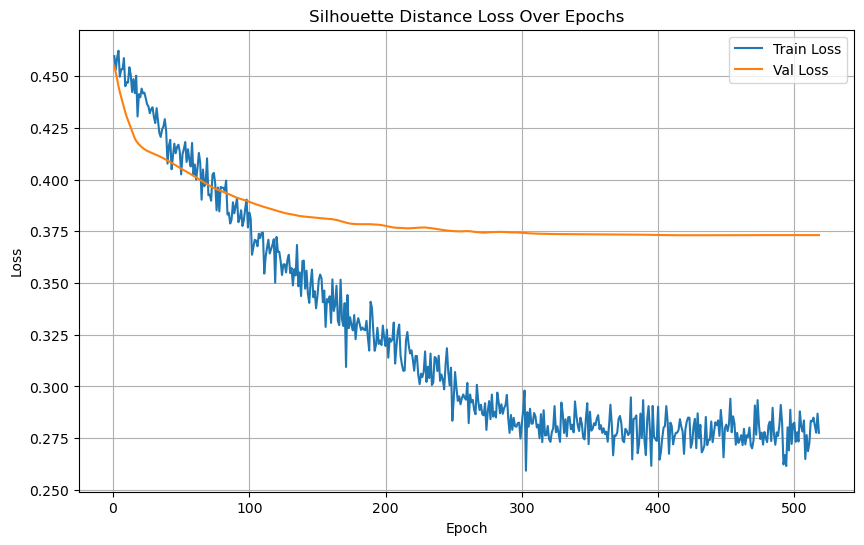

In [51]:
sclsdl_model = SupConNet().to(device)
sclsdl_criterion = SilhouetteDistanceLoss()
sclsdl_optimizer = optim.AdamW(sclsdl_model.parameters(), lr=0.0001, weight_decay=1e-5)
sclsdl_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    sclsdl_optimizer, 
    mode='min',
    patience=25,
    factor=0.1
)

sclsdl_num_epochs = 2000

sclsdl_patience = 100
sclsdl_best_val_loss = float('inf')
sclsdl_epochs_without_improvement = 0

sclsdl_train_loss_history = []
sclsdl_val_loss_history = []

for sclsdl_epoch in range(sclsdl_num_epochs):
    # Training
    sclsdl_model.train()
    sclsdl_running_train_loss = 0.0
    
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Training")
    for batch_idx, (vectors, labels) in enumerate(sclsdl_train_loader):

        vectors = vectors.to(device).float()
        labels = labels.to(device)

        # Forward pass
        sclsdl_train_projections = sclsdl_model(vectors)

        sclsdl_loss = sclsdl_criterion(sclsdl_train_projections, labels)

        # Backprop and optimize
        sclsdl_optimizer.zero_grad()
        sclsdl_loss.backward()
        sclsdl_optimizer.step()

        sclsdl_running_train_loss += sclsdl_loss.item()
        print(f"    Batch [{batch_idx+1}/{len(sclsdl_train_loader)}], Train Loss: {sclsdl_loss.item():.4f}")

    sclsdl_train_epoch_loss = sclsdl_running_train_loss / len(sclsdl_train_loader)
    sclsdl_train_loss_history.append(sclsdl_train_epoch_loss)

    # Validation
    sclsdl_model.eval()
    sclsdl_running_val_loss = 0.0
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Validation")
    with torch.no_grad():
        for val_batch_idx, (vectors, labels) in enumerate(sclsdl_val_loader):

            vectors = vectors.to(device).float()
            labels = labels.to(device)

            sclsdl_val_projections = sclsdl_model(vectors)
            sclsdl_val_batch_loss = sclsdl_criterion(sclsdl_val_projections, labels).item()
            sclsdl_running_val_loss += sclsdl_val_batch_loss
            print(f"    Batch [{val_batch_idx+1}/{len(sclsdl_val_loader)}], Val Loss: {sclsdl_val_batch_loss:.4f}")

    sclsdl_val_epoch_loss = sclsdl_running_val_loss / len(sclsdl_val_loader)
    sclsdl_val_loss_history.append(sclsdl_val_epoch_loss)
    
    sclsdl_scheduler.step(sclsdl_val_epoch_loss)

    print(f"Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}], "
          f"Avg Train Loss: {sclsdl_train_epoch_loss:.4f}, "
          f"Avg Val Loss: {sclsdl_val_epoch_loss:.4f}\n")
    
    #early stopping logic
    if sclsdl_val_epoch_loss < sclsdl_best_val_loss:
        print(f"Validation loss improved from {sclsdl_best_val_loss:.4f} to {sclsdl_val_epoch_loss:.4f}. Saving model...")
        sclsdl_best_val_loss = sclsdl_val_epoch_loss
        sclsdl_epochs_without_improvement = 0
    else:
        sclsdl_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! Patience: {sclsdl_epochs_without_improvement}/{sclsdl_patience}")

    #stop training if val loss not improving
    if sclsdl_epochs_without_improvement >= sclsdl_patience:
        print(f"!! Early stopping triggered at epoch {sclsdl_epoch + 1}!!\nNo improvement for {sclsdl_patience} epochs")
        break

plt.figure(figsize=(10,6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Silhouette Distance Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Test Batch [10/667], Loss: 0.2072
Test Batch [20/667], Loss: 0.3163
Test Batch [30/667], Loss: 0.2547


Test Batch [40/667], Loss: 0.3555
Test Batch [50/667], Loss: 0.2995
Test Batch [60/667], Loss: 0.3112
Test Batch [70/667], Loss: 0.1761
Test Batch [80/667], Loss: 0.1810


Test Batch [90/667], Loss: 0.1808
Test Batch [100/667], Loss: 0.1510
Test Batch [110/667], Loss: 0.1519
Test Batch [120/667], Loss: 0.1853
Test Batch [130/667], Loss: 0.2358


Test Batch [140/667], Loss: 0.2030
Test Batch [150/667], Loss: 0.2076
Test Batch [160/667], Loss: 0.2467
Test Batch [170/667], Loss: 0.2024
Test Batch [180/667], Loss: 0.5000
Test Batch [190/667], Loss: 0.2145


Test Batch [200/667], Loss: 0.5000
Test Batch [210/667], Loss: 0.5000
Test Batch [220/667], Loss: 0.3184
Test Batch [230/667], Loss: 0.1299
Test Batch [240/667], Loss: 0.5000
Test Batch [250/667], Loss: 0.5000
Test Batch [260/667], Loss: 0.5000
Test Batch [270/667], Loss: 0.5000
Test Batch [280/667], Loss: 0.5000
Test Batch [290/667], Loss: 0.5000
Test Batch [300/667], Loss: 0.5000


Test Batch [310/667], Loss: 0.2269
Test Batch [320/667], Loss: 0.1936
Test Batch [330/667], Loss: 0.2750
Test Batch [340/667], Loss: 0.2009


Test Batch [350/667], Loss: 0.2100
Test Batch [360/667], Loss: 0.3170
Test Batch [370/667], Loss: 0.1770


Test Batch [380/667], Loss: 0.2288
Test Batch [390/667], Loss: 0.1771
Test Batch [400/667], Loss: 0.1524


Test Batch [410/667], Loss: 0.2314
Test Batch [420/667], Loss: 0.2264
Test Batch [430/667], Loss: 0.2273


Test Batch [440/667], Loss: 0.3613
Test Batch [450/667], Loss: 0.2315
Test Batch [460/667], Loss: 0.3927
Test Batch [470/667], Loss: 0.3801


Test Batch [480/667], Loss: 0.2592
Test Batch [490/667], Loss: 0.3103
Test Batch [500/667], Loss: 0.1845
Test Batch [510/667], Loss: 0.2529


Test Batch [520/667], Loss: 0.2753
Test Batch [530/667], Loss: 0.5000
Test Batch [540/667], Loss: 0.1888
Test Batch [550/667], Loss: 0.5000


Test Batch [560/667], Loss: 0.2058
Test Batch [570/667], Loss: 0.3140
Test Batch [580/667], Loss: 0.1517
Test Batch [590/667], Loss: 0.2817


Test Batch [600/667], Loss: 0.4260
Test Batch [610/667], Loss: 0.3339
Test Batch [620/667], Loss: 0.3583
Test Batch [630/667], Loss: 0.4152
Test Batch [640/667], Loss: 0.2293


Test Batch [650/667], Loss: 0.3769
Test Batch [660/667], Loss: 0.3601

Test Loss: 0.2999


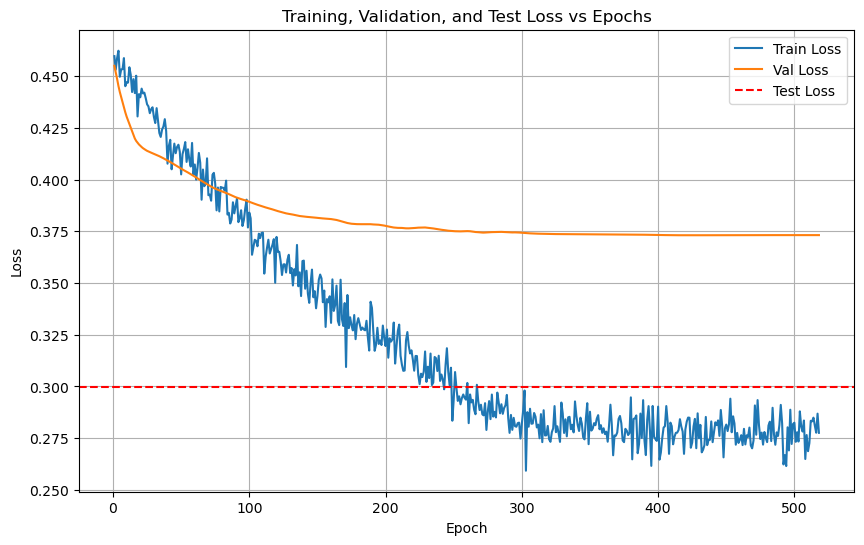

In [52]:
# Test Evaluation
sclsdl_model.eval()
sclsdl_total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(sclsdl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = sclsdl_model(vectors)
        loss = sclsdl_criterion(projections, labels)
        sclsdl_total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(sclsdl_test_loader)}], Loss: {loss.item():.4f}")

sclsdl_avg_test_loss = sclsdl_total_test_loss / len(sclsdl_test_loader)
print(f"\nTest Loss: {sclsdl_avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
# test loss = horizontal dashed line
plt.axhline(y=sclsdl_avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving the representations learnt by SCL w/ SDL Model

In [53]:
# dir to save the SCL representations
sclsdl_rep_dir = "sclsdl_representations"
os.makedirs(sclsdl_rep_dir, exist_ok=True)

sclsdl_loaders = {
    'train': sclsdl_train_loader,
    'val': sclsdl_val_loader,
    'test': sclsdl_test_loader
}

sclsdl_model.eval()

with torch.no_grad():
    for sclsdl_split_name, sclsdl_loader in sclsdl_loaders.items():
        print(f"\nExtracting SCL_SDL representations for the {sclsdl_split_name} dataset...")
        # creating subfolder for the split
        sclsdl_split_dir = os.path.join(sclsdl_rep_dir, sclsdl_split_name)
        os.makedirs(sclsdl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for sclsdl_batch_idx, (sclsdl_vectors, sclsdl_labels) in enumerate(sclsdl_loader):
            sclsdl_vectors = sclsdl_vectors.to(device).float()
            # computing projections using the trained SCL model
            sclsdl_projections = sclsdl_model(sclsdl_vectors)
            
            # converting projections and labels to np arrays
            sclsdl_projections_np = sclsdl_projections.cpu().numpy()
            sclsdl_labels_np = sclsdl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(sclsdl_split_dir, f"scl_encoded_batch_{sclsdl_batch_idx}.npy"), sclsdl_projections_np)
            np.save(os.path.join(sclsdl_split_dir, f"scl_labels_batch_{sclsdl_batch_idx}.npy"), sclsdl_labels_np)
            
            if (sclsdl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {sclsdl_batch_idx + 1}/{len(sclsdl_loader)} for {sclsdl_split_name} dataset.")

        print(f"Completed extraction for the {sclsdl_split_name} dataset. Representations saved in '{sclsdl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL_SDL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'sclsdl_representations\train'.

Extracting SCL_SDL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'sclsdl_representations\val'.

Extracting SCL_SDL representations for the test dataset...
  Processed batch 10/667 for test dataset.
  Processed batch 20/667 for test dataset.


  Processed batch 30/667 for test dataset.
  Processed batch 40/667 for test dataset.
  Processed batch 50/667 for test dataset.


  Processed batch 60/667 for test dataset.
  Processed batch 70/667 for test dataset.
  Processed batch 80/667 for test dataset.


  Processed batch 90/667 for test dataset.
  Processed batch 100/667 for test dataset.
  Processed batch 110/667 for test dataset.
  Processed batch 120/667 for test dataset.


  Processed batch 130/667 for test dataset.
  Processed batch 140/667 for test dataset.
  Processed batch 150/667 for test dataset.


  Processed batch 160/667 for test dataset.
  Processed batch 170/667 for test dataset.
  Processed batch 180/667 for test dataset.
  Processed batch 190/667 for test dataset.


  Processed batch 200/667 for test dataset.
  Processed batch 210/667 for test dataset.
  Processed batch 220/667 for test dataset.


  Processed batch 230/667 for test dataset.
  Processed batch 240/667 for test dataset.


  Processed batch 250/667 for test dataset.
  Processed batch 260/667 for test dataset.
  Processed batch 270/667 for test dataset.


  Processed batch 280/667 for test dataset.
  Processed batch 290/667 for test dataset.
  Processed batch 300/667 for test dataset.


  Processed batch 310/667 for test dataset.
  Processed batch 320/667 for test dataset.
  Processed batch 330/667 for test dataset.


  Processed batch 340/667 for test dataset.
  Processed batch 350/667 for test dataset.
  Processed batch 360/667 for test dataset.


  Processed batch 370/667 for test dataset.
  Processed batch 380/667 for test dataset.
  Processed batch 390/667 for test dataset.
  Processed batch 400/667 for test dataset.


  Processed batch 410/667 for test dataset.
  Processed batch 420/667 for test dataset.
  Processed batch 430/667 for test dataset.
  Processed batch 440/667 for test dataset.


  Processed batch 450/667 for test dataset.
  Processed batch 460/667 for test dataset.
  Processed batch 470/667 for test dataset.
  Processed batch 480/667 for test dataset.


  Processed batch 490/667 for test dataset.
  Processed batch 500/667 for test dataset.
  Processed batch 510/667 for test dataset.


  Processed batch 520/667 for test dataset.
  Processed batch 530/667 for test dataset.
  Processed batch 540/667 for test dataset.


  Processed batch 550/667 for test dataset.
  Processed batch 560/667 for test dataset.
  Processed batch 570/667 for test dataset.


  Processed batch 580/667 for test dataset.
  Processed batch 590/667 for test dataset.
  Processed batch 600/667 for test dataset.


  Processed batch 610/667 for test dataset.
  Processed batch 620/667 for test dataset.
  Processed batch 630/667 for test dataset.


  Processed batch 640/667 for test dataset.
  Processed batch 650/667 for test dataset.
  Processed batch 660/667 for test dataset.
Completed extraction for the test dataset. Representations saved in 'sclsdl_representations\test'.
SCL representations extraction complete.


### Classifying the representations learnt by SCL w/ SDL Model with LRM

In [54]:
def load_sclsdl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    sclsdl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    sclsdl_all_reps = []
    sclsdl_all_labels = []

    for sclsdl_rep_file in sclsdl_rep_files:
        #deriving label filenames
        sclsdl_label_file = sclsdl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        sclsdl_reps = np.load(sclsdl_rep_file)
        sclsdl_labels = np.load(sclsdl_label_file)

        sclsdl_all_reps.append(sclsdl_reps)
        sclsdl_all_labels.append(sclsdl_labels)

    #concat along first dim
    sclsdl_all_reps = np.concatenate(sclsdl_all_reps, axis = 0)
    sclsdl_all_labels = np.concatenate(sclsdl_all_labels, axis = 0)

    return sclsdl_all_reps, sclsdl_all_labels

In [55]:
sclsdl_lrm_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_lrm_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_lrm_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_lrm_train_reps, sclsdl_lrm_train_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_train_dir)
sclsdl_lrm_val_reps, sclsdl_lrm_val_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_val_dir)
sclsdl_lrm_test_reps, sclsdl_lrm_test_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_test_dir)

print("Train reps shape:", sclsdl_lrm_train_reps.shape)
print("Train labels shape:", sclsdl_lrm_train_labels.shape)

print("Val reps shape:", sclsdl_lrm_val_reps.shape)
print("Val labels shape:", sclsdl_lrm_val_labels.shape)

print("Test reps shape:", sclsdl_lrm_test_reps.shape)
print("Test labels shape:", sclsdl_lrm_test_labels.shape)

Train reps shape: (45, 128)
Train labels shape: (45,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (42686, 128)
Test labels shape: (42686,)


In [56]:
# Train Logistic Regression Model on the SCLSDL representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
sclsdl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
sclsdl_logistic_clf.fit(sclsdl_lrm_train_reps, sclsdl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# Evaluate on Validation Set
print("\nLOG: Evaluating on the validation set...")
sclsdl_lrm_val_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_val_reps)
sclsdl_lrm_val_accuracy = accuracy_score(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions)
print(f"Validation Accuracy: {sclsdl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions))

# Evaluate on Test Set
print("\nLOG: Evaluating on the test set...")
sclsdl_lrm_test_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_test_reps)
sclsdl_lrm_test_accuracy = accuracy_score(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions)
print(f"Test Accuracy: {sclsdl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'sclsdl_lrm_predictions.npy'), sclsdl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'sclsdl_lrm_true_labels.npy'), sclsdl_lrm_test_labels)
print(f"Saved SCL_SDL+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 68.89%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.60      0.75         5
           1       0.45      1.00      0.62         5
           2       0.60      0.60      0.60         5
           3       1.00      0.20      0.33         5
           4       1.00      0.80      0.89         5
           5       0.67      0.40      0.50         5
           6       0.71      1.00      0.83         5
           7       0.50      0.60      0.55         5
           8       1.00      1.00      1.00         5

    accuracy                           0.69        45
   macro avg       0.77      0.69      0.68        45
weighted avg       0.77      0.69      0.68        45


LOG: Evaluating on the test set...
Test Accuracy: 67.73%

Test Classifica

## Classifying the representations learnt by SCL w/ SDL Model with MLP Classifier

In [57]:
sclsdl_mlp_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_mlp_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_mlp_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_mlp_train_reps, sclsdl_mlp_train_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_train_dir)
sclsdl_mlp_val_reps, sclsdl_mlp_val_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_val_dir)
sclsdl_mlp_test_reps, sclsdl_mlp_test_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_test_dir)

print("Train reps shape:", sclsdl_mlp_train_reps.shape)
print("Train labels shape:", sclsdl_mlp_train_labels.shape)

print("Val reps shape:", sclsdl_mlp_val_reps.shape)
print("Val labels shape:", sclsdl_mlp_val_labels.shape)

print("Test reps shape:", sclsdl_mlp_test_reps.shape)
print("Test labels shape:", sclsdl_mlp_test_labels.shape)

Train reps shape: (45, 128)
Train labels shape: (45,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (42686, 128)
Test labels shape: (42686,)


In [58]:
#converting arrays to torch tensors
sclsdl_mlp_train_embeddings_torch = torch.tensor(sclsdl_mlp_train_reps, dtype=torch.float32)
sclsdl_mlp_train_labels_torch = torch.tensor(sclsdl_mlp_train_labels, dtype=torch.long)

sclsdl_mlp_val_embeddings_torch = torch.tensor(sclsdl_mlp_val_reps, dtype=torch.float32)
sclsdl_mlp_val_labels_torch = torch.tensor(sclsdl_mlp_val_labels, dtype=torch.long)

sclsdl_mlp_test_embeddings_torch = torch.tensor(sclsdl_mlp_test_reps, dtype=torch.float32)
sclsdl_mlp_test_labels_torch = torch.tensor(sclsdl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
sclsdl_mlp_train_dataset = TensorDataset(sclsdl_mlp_train_embeddings_torch, sclsdl_mlp_train_labels_torch)
sclsdl_mlp_val_dataset = TensorDataset(sclsdl_mlp_val_embeddings_torch, sclsdl_mlp_val_labels_torch)
sclsdl_mlp_test_dataset = TensorDataset(sclsdl_mlp_test_embeddings_torch, sclsdl_mlp_test_labels_torch)

sclsdl_mlp_batch_size = 64
sclsdl_mlp_train_loader = DataLoader(sclsdl_mlp_train_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=True)
sclsdl_mlp_val_loader = DataLoader(sclsdl_mlp_val_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)
sclsdl_mlp_test_loader = DataLoader(sclsdl_mlp_test_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.1439  |  Val Loss: 2.1537
Validation loss improved from inf to 2.1537.
[Epoch 2/1000] Train Loss: 2.1317  |  Val Loss: 2.1451
Validation loss improved from 2.1537 to 2.1451.
[Epoch 3/1000] Train Loss: 2.1196  |  Val Loss: 2.1365
Validation loss improved from 2.1451 to 2.1365.
[Epoch 4/1000] Train Loss: 2.1076  |  Val Loss: 2.1280
Validation loss improved from 2.1365 to 2.1280.
[Epoch 5/1000] Train Loss: 2.0957  |  Val Loss: 2.1196
Validation loss improved from 2.1280 to 2.1196.
[Epoch 6/1000] Train Loss: 2.0840  |  Val Loss: 2.1112
Validation loss improved from 2.1196 to 2.1112.
[Epoch 7/1000] Train Loss: 2.0725  |  Val Loss: 2.1031
Validation loss improved from 2.1112 to 2.1031.
[Epoch 8/1000] Train Loss: 2.0612  |  Val Loss: 2.0953
Validation loss improved from 2.1031 to 2.0953.
[Epoch 9/1000] Train Loss: 2.0500  |  Val Loss: 2.0878
Validation loss improved from 2.0953 to 2.0878.
[Epoch 10/1000] Train Loss: 2.0391  |  Val Loss: 2.0806
Validation loss impr

[Epoch 61/1000] Train Loss: 1.7084  |  Val Loss: 1.8802
Validation loss improved from 1.8828 to 1.8802.
[Epoch 62/1000] Train Loss: 1.7040  |  Val Loss: 1.8776
Validation loss improved from 1.8802 to 1.8776.
[Epoch 63/1000] Train Loss: 1.6997  |  Val Loss: 1.8751
Validation loss improved from 1.8776 to 1.8751.
[Epoch 64/1000] Train Loss: 1.6954  |  Val Loss: 1.8726
Validation loss improved from 1.8751 to 1.8726.
[Epoch 65/1000] Train Loss: 1.6912  |  Val Loss: 1.8700
Validation loss improved from 1.8726 to 1.8700.
[Epoch 66/1000] Train Loss: 1.6869  |  Val Loss: 1.8675
Validation loss improved from 1.8700 to 1.8675.
[Epoch 67/1000] Train Loss: 1.6826  |  Val Loss: 1.8650
Validation loss improved from 1.8675 to 1.8650.
[Epoch 68/1000] Train Loss: 1.6784  |  Val Loss: 1.8625
Validation loss improved from 1.8650 to 1.8625.
[Epoch 69/1000] Train Loss: 1.6742  |  Val Loss: 1.8600
Validation loss improved from 1.8625 to 1.8600.
[Epoch 70/1000] Train Loss: 1.6701  |  Val Loss: 1.8575
Validati

[Epoch 72/1000] Train Loss: 1.6618  |  Val Loss: 1.8526
Validation loss improved from 1.8550 to 1.8526.
[Epoch 73/1000] Train Loss: 1.6577  |  Val Loss: 1.8502
Validation loss improved from 1.8526 to 1.8502.
[Epoch 74/1000] Train Loss: 1.6536  |  Val Loss: 1.8477
Validation loss improved from 1.8502 to 1.8477.
[Epoch 75/1000] Train Loss: 1.6495  |  Val Loss: 1.8453
Validation loss improved from 1.8477 to 1.8453.
[Epoch 76/1000] Train Loss: 1.6454  |  Val Loss: 1.8429
Validation loss improved from 1.8453 to 1.8429.
[Epoch 77/1000] Train Loss: 1.6413  |  Val Loss: 1.8404
Validation loss improved from 1.8429 to 1.8404.
[Epoch 78/1000] Train Loss: 1.6372  |  Val Loss: 1.8380
Validation loss improved from 1.8404 to 1.8380.
[Epoch 79/1000] Train Loss: 1.6332  |  Val Loss: 1.8356
Validation loss improved from 1.8380 to 1.8356.
[Epoch 80/1000] Train Loss: 1.6291  |  Val Loss: 1.8332
Validation loss improved from 1.8356 to 1.8332.
[Epoch 81/1000] Train Loss: 1.6251  |  Val Loss: 1.8309
Validati

[Epoch 139/1000] Train Loss: 1.3807  |  Val Loss: 1.6894
Validation loss improved from 1.6920 to 1.6894.
[Epoch 140/1000] Train Loss: 1.3762  |  Val Loss: 1.6868
Validation loss improved from 1.6894 to 1.6868.
[Epoch 141/1000] Train Loss: 1.3716  |  Val Loss: 1.6841
Validation loss improved from 1.6868 to 1.6841.
[Epoch 142/1000] Train Loss: 1.3671  |  Val Loss: 1.6814
Validation loss improved from 1.6841 to 1.6814.
[Epoch 143/1000] Train Loss: 1.3625  |  Val Loss: 1.6788
Validation loss improved from 1.6814 to 1.6788.
[Epoch 144/1000] Train Loss: 1.3580  |  Val Loss: 1.6761
Validation loss improved from 1.6788 to 1.6761.
[Epoch 145/1000] Train Loss: 1.3534  |  Val Loss: 1.6734
Validation loss improved from 1.6761 to 1.6734.
[Epoch 146/1000] Train Loss: 1.3488  |  Val Loss: 1.6707
Validation loss improved from 1.6734 to 1.6707.
[Epoch 147/1000] Train Loss: 1.3442  |  Val Loss: 1.6680
Validation loss improved from 1.6707 to 1.6680.
[Epoch 148/1000] Train Loss: 1.3396  |  Val Loss: 1.665

[Epoch 211/1000] Train Loss: 1.0030  |  Val Loss: 1.4624
Validation loss improved from 1.4660 to 1.4624.
[Epoch 212/1000] Train Loss: 0.9968  |  Val Loss: 1.4589
Validation loss improved from 1.4624 to 1.4589.
[Epoch 213/1000] Train Loss: 0.9907  |  Val Loss: 1.4553
Validation loss improved from 1.4589 to 1.4553.
[Epoch 214/1000] Train Loss: 0.9845  |  Val Loss: 1.4517
Validation loss improved from 1.4553 to 1.4517.
[Epoch 215/1000] Train Loss: 0.9782  |  Val Loss: 1.4480
Validation loss improved from 1.4517 to 1.4480.
[Epoch 216/1000] Train Loss: 0.9720  |  Val Loss: 1.4443
Validation loss improved from 1.4480 to 1.4443.
[Epoch 217/1000] Train Loss: 0.9656  |  Val Loss: 1.4405
Validation loss improved from 1.4443 to 1.4405.
[Epoch 218/1000] Train Loss: 0.9593  |  Val Loss: 1.4367
Validation loss improved from 1.4405 to 1.4367.
[Epoch 219/1000] Train Loss: 0.9529  |  Val Loss: 1.4330
Validation loss improved from 1.4367 to 1.4330.
[Epoch 220/1000] Train Loss: 0.9466  |  Val Loss: 1.429

[Epoch 282/1000] Train Loss: 0.5766  |  Val Loss: 1.2012
Validation loss improved from 1.2041 to 1.2012.
[Epoch 283/1000] Train Loss: 0.5718  |  Val Loss: 1.1984
Validation loss improved from 1.2012 to 1.1984.
[Epoch 284/1000] Train Loss: 0.5669  |  Val Loss: 1.1957
Validation loss improved from 1.1984 to 1.1957.
[Epoch 285/1000] Train Loss: 0.5621  |  Val Loss: 1.1930
Validation loss improved from 1.1957 to 1.1930.
[Epoch 286/1000] Train Loss: 0.5573  |  Val Loss: 1.1903
Validation loss improved from 1.1930 to 1.1903.
[Epoch 287/1000] Train Loss: 0.5526  |  Val Loss: 1.1876
Validation loss improved from 1.1903 to 1.1876.
[Epoch 288/1000] Train Loss: 0.5479  |  Val Loss: 1.1851
Validation loss improved from 1.1876 to 1.1851.
[Epoch 289/1000] Train Loss: 0.5432  |  Val Loss: 1.1825
Validation loss improved from 1.1851 to 1.1825.
[Epoch 290/1000] Train Loss: 0.5385  |  Val Loss: 1.1800
Validation loss improved from 1.1825 to 1.1800.
[Epoch 291/1000] Train Loss: 0.5339  |  Val Loss: 1.177

[Epoch 359/1000] Train Loss: 0.3049  |  Val Loss: 1.0686
Validation loss improved from 1.0696 to 1.0686.
[Epoch 360/1000] Train Loss: 0.3027  |  Val Loss: 1.0677
Validation loss improved from 1.0686 to 1.0677.
[Epoch 361/1000] Train Loss: 0.3004  |  Val Loss: 1.0667
Validation loss improved from 1.0677 to 1.0667.
[Epoch 362/1000] Train Loss: 0.2982  |  Val Loss: 1.0658
Validation loss improved from 1.0667 to 1.0658.
[Epoch 363/1000] Train Loss: 0.2960  |  Val Loss: 1.0648
Validation loss improved from 1.0658 to 1.0648.
[Epoch 364/1000] Train Loss: 0.2939  |  Val Loss: 1.0639
Validation loss improved from 1.0648 to 1.0639.
[Epoch 365/1000] Train Loss: 0.2917  |  Val Loss: 1.0630
Validation loss improved from 1.0639 to 1.0630.
[Epoch 366/1000] Train Loss: 0.2896  |  Val Loss: 1.0620
Validation loss improved from 1.0630 to 1.0620.
[Epoch 367/1000] Train Loss: 0.2875  |  Val Loss: 1.0611
Validation loss improved from 1.0620 to 1.0611.
[Epoch 368/1000] Train Loss: 0.2854  |  Val Loss: 1.060

[Epoch 436/1000] Train Loss: 0.1841  |  Val Loss: 1.0262
Validation loss improved from 1.0264 to 1.0262.
[Epoch 437/1000] Train Loss: 0.1830  |  Val Loss: 1.0261
Validation loss improved from 1.0262 to 1.0261.
[Epoch 438/1000] Train Loss: 0.1820  |  Val Loss: 1.0260
Validation loss improved from 1.0261 to 1.0260.
[Epoch 439/1000] Train Loss: 0.1810  |  Val Loss: 1.0259
Validation loss improved from 1.0260 to 1.0259.
[Epoch 440/1000] Train Loss: 0.1800  |  Val Loss: 1.0258
Validation loss improved from 1.0259 to 1.0258.
[Epoch 441/1000] Train Loss: 0.1789  |  Val Loss: 1.0256
Validation loss improved from 1.0258 to 1.0256.
[Epoch 442/1000] Train Loss: 0.1779  |  Val Loss: 1.0255
Validation loss improved from 1.0256 to 1.0255.
[Epoch 443/1000] Train Loss: 0.1770  |  Val Loss: 1.0254
Validation loss improved from 1.0255 to 1.0254.
[Epoch 444/1000] Train Loss: 0.1760  |  Val Loss: 1.0253
Validation loss improved from 1.0254 to 1.0253.
[Epoch 445/1000] Train Loss: 0.1750  |  Val Loss: 1.025

[Epoch 509/1000] Train Loss: 0.1288  |  Val Loss: 1.0273
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 510/1000] Train Loss: 0.1283  |  Val Loss: 1.0274
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 511/1000] Train Loss: 0.1277  |  Val Loss: 1.0276
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 512/1000] Train Loss: 0.1272  |  Val Loss: 1.0277
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 513/1000] Train Loss: 0.1267  |  Val Loss: 1.0278
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 514/1000] Train Loss: 0.1261  |  Val Loss: 1.0280
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 515/1000] Train Loss: 0.1256  |  Val Loss: 1.0281
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 516/1000] Train Loss: 0.1251  |  Val Loss: 1.0283
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 517/1000] Train Loss: 0.1246  |  Val Loss: 1.0284
!! Validation loss did NOT improve !! Patience:

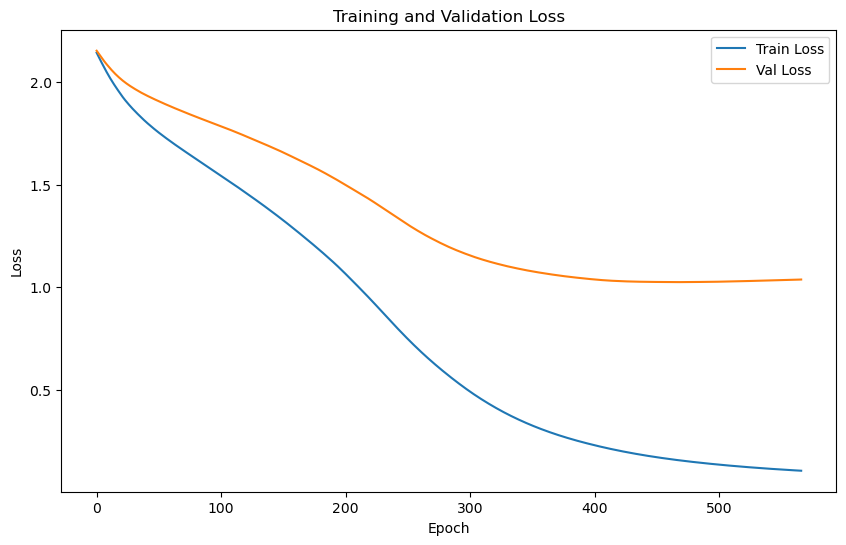

In [59]:
sclsdl_mlp_input_dim = sclsdl_mlp_train_reps.shape[1]
sclsdl_mlp_num_classes = len(torch.unique(sclsdl_mlp_train_labels_torch))
sclsdl_mlp_model = MLPClassifier(sclsdl_mlp_input_dim, sclsdl_mlp_num_classes).to(device)

sclsdl_mlp_criterion = nn.CrossEntropyLoss()
sclsdl_mlp_optimizer = optim.Adam(sclsdl_mlp_model.parameters(), lr=1e-4)

sclsdl_mlp_num_epochs = 1000
sclsdl_mlp_patience = 100

sclsdl_mlp_train_losses = []
sclsdl_mlp_val_losses = []

sclsdl_mlp_best_val_loss = float('inf')
sclsdl_mlp_epochs_without_improvement = 0

for sclsdl_mlp_epoch in range(sclsdl_mlp_num_epochs):
    # Training
    sclsdl_mlp_model.train()
    sclsdl_mlp_train_running_loss = 0.0
    
    for sclsdl_mlp_embeddings_batch, sclsdl_mlp_labels_batch in sclsdl_mlp_train_loader:
        sclsdl_mlp_embeddings_batch = sclsdl_mlp_embeddings_batch.to(device)
        sclsdl_mlp_labels_batch = sclsdl_mlp_labels_batch.to(device)
        
        sclsdl_mlp_optimizer.zero_grad()
        
        # Forward
        sclsdl_mlp_outputs = sclsdl_mlp_model(sclsdl_mlp_embeddings_batch)
        sclsdl_mlp_loss = sclsdl_mlp_criterion(sclsdl_mlp_outputs, sclsdl_mlp_labels_batch)
        
        # Backward & Update
        sclsdl_mlp_loss.backward()
        sclsdl_mlp_optimizer.step()
        
        sclsdl_mlp_train_running_loss += sclsdl_mlp_loss.item() * sclsdl_mlp_embeddings_batch.size(0)
    
    sclsdl_mlp_epoch_train_loss = sclsdl_mlp_train_running_loss / len(sclsdl_mlp_train_loader.dataset)
    sclsdl_mlp_train_losses.append(sclsdl_mlp_epoch_train_loss)

    # Validation
    sclsdl_mlp_model.eval()
    sclsdl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for sclsdl_mlp_val_embeddings_batch, sclsdl_mlp_val_labels_batch in sclsdl_mlp_val_loader:
            sclsdl_mlp_val_embeddings_batch = sclsdl_mlp_val_embeddings_batch.to(device)
            sclsdl_mlp_val_labels_batch = sclsdl_mlp_val_labels_batch.to(device)

            sclsdl_mlp_val_outputs = sclsdl_mlp_model(sclsdl_mlp_val_embeddings_batch)
            sclsdl_mlp_val_loss = sclsdl_mlp_criterion(sclsdl_mlp_val_outputs, sclsdl_mlp_val_labels_batch)

            sclsdl_mlp_val_running_loss += sclsdl_mlp_val_loss.item() * sclsdl_mlp_val_embeddings_batch.size(0)

    sclsdl_mlp_epoch_val_loss = sclsdl_mlp_val_running_loss / len(sclsdl_mlp_val_loader.dataset)
    sclsdl_mlp_val_losses.append(sclsdl_mlp_epoch_val_loss)

    print(f"[Epoch {sclsdl_mlp_epoch+1}/{sclsdl_mlp_num_epochs}] "
          f"Train Loss: {sclsdl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {sclsdl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if sclsdl_mlp_epoch_val_loss < sclsdl_mlp_best_val_loss:
        print(f"Validation loss improved from {sclsdl_mlp_best_val_loss:.4f} to {sclsdl_mlp_epoch_val_loss:.4f}.")
        sclsdl_mlp_best_val_loss = sclsdl_mlp_epoch_val_loss
        sclsdl_mlp_epochs_without_improvement = 0


    else:
        sclsdl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {sclsdl_mlp_epochs_without_improvement}/{sclsdl_mlp_patience}")
        
        if sclsdl_mlp_epochs_without_improvement >= sclsdl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {sclsdl_mlp_epoch+1} !!\n"
                  f"No improvement for {sclsdl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(sclsdl_mlp_train_losses, label='Train Loss')
plt.plot(sclsdl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved SCL_SDL+MLP predictions and true labels to model_predictions
Test Loss: 1.1208 | Test Accuracy: 66.36%


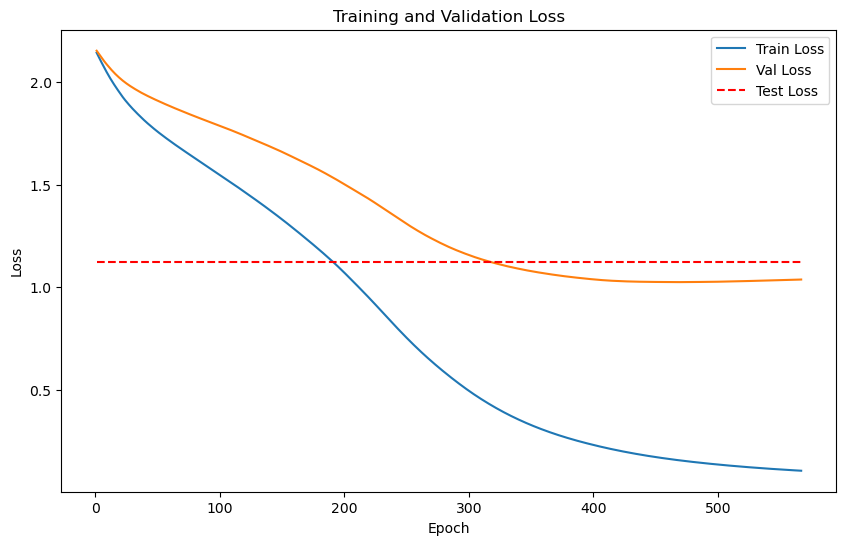

In [60]:
sclsdl_mlp_model.eval()

sclsdl_mlp_test_running_loss = 0.0
sclsdl_mlp_test_correct = 0
sclsdl_mlp_all_predictions = []
sclsdl_mlp_all_true_labels = []

with torch.no_grad():
    for sclsdl_mlp_test_embeddings_batch, sclsdl_mlp_test_labels_batch in sclsdl_mlp_test_loader:
        sclsdl_mlp_test_embeddings_batch = sclsdl_mlp_test_embeddings_batch.to(device)
        sclsdl_mlp_test_labels_batch = sclsdl_mlp_test_labels_batch.to(device)

        # Forward pass
        sclsdl_mlp_test_outputs = sclsdl_mlp_model(sclsdl_mlp_test_embeddings_batch)
        
        # Compute loss
        sclsdl_mlp_test_loss_batch = sclsdl_mlp_criterion(sclsdl_mlp_test_outputs, sclsdl_mlp_test_labels_batch)
        sclsdl_mlp_test_running_loss += sclsdl_mlp_test_loss_batch.item() * sclsdl_mlp_test_embeddings_batch.size(0)

        _, sclsdl_mlp_test_predicted = torch.max(sclsdl_mlp_test_outputs, dim=1)
        sclsdl_mlp_test_correct += (sclsdl_mlp_test_predicted == sclsdl_mlp_test_labels_batch).sum().item()

        sclsdl_mlp_all_predictions.extend(sclsdl_mlp_test_predicted.cpu().numpy())
        sclsdl_mlp_all_true_labels.extend(sclsdl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'sclsdl_mlp_predictions.npy'), np.array(sclsdl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'sclsdl_mlp_true_labels.npy'), np.array(sclsdl_mlp_all_true_labels))
print(f"Saved SCL_SDL+MLP predictions and true labels to {predictions_dir}")

sclsdl_mlp_epoch_test_loss = sclsdl_mlp_test_running_loss / len(sclsdl_mlp_test_loader.dataset)
sclsdl_mlp_test_accuracy = sclsdl_mlp_test_correct / len(sclsdl_mlp_test_loader.dataset)

sclsdl_mlp_test_accuracy_pct = sclsdl_mlp_test_accuracy * 100.0

print(f"Test Loss: {sclsdl_mlp_epoch_test_loss:.4f} | Test Accuracy: {sclsdl_mlp_test_accuracy_pct:.2f}%")

sclsdl_mlp_num_epochs_run = len(sclsdl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         [sclsdl_mlp_epoch_test_loss]*sclsdl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Experimental Results and Confusion Matrices

In [61]:
def plot_conf_matrix(model_name, class_names = None, cm_save_dir='confusion_matrices'):
    os.makedirs(cm_save_dir, exist_ok = True)

    #loading predictions and true labels
    predictions_path = os.path.join(predictions_dir, f'{model_name}_predictions.npy')
    true_labels_path = os.path.join(predictions_dir, f'{model_name}_true_labels.npy')

    if not os.path.exists(predictions_path) or not os.path.exists(true_labels_path):
        print(f"Error: Files not found for model {model_name}")
        return
    
    cm_predictions = np.load(predictions_path)
    cm_true_labels = np.load(true_labels_path)

    conf_matrix = confusion_matrix(cm_true_labels, cm_predictions)
    plt.figure(figsize=(8,8))

    conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]
    sns.heatmap(conf_matrix_normalised, annot=conf_matrix, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    plt.title(f"{model_name.upper()} Confusion Matrix", fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()

    cm_save_path = os.path.join(cm_save_dir, f'{model_name}_confusion_matrix.png')
    plt.savefig(cm_save_path, dpi=300, bbox_inches='tight')
    print(f"Saved confusion matrix to: {cm_save_path}")

    plt.show()

    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
    print(f"Classification Accuracy: {accuracy*100:.2f}%")

Saving confusion matrices to: confusion_matrices


Saved confusion matrix to: confusion_matrices\e2e_cnn_confusion_matrix.png


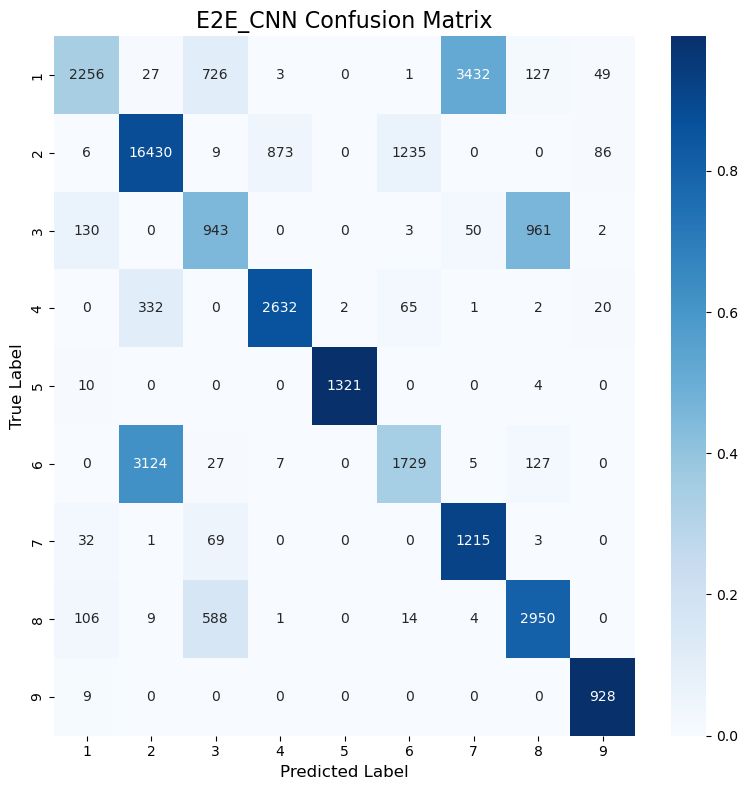

Classification Accuracy: 71.23%


Saved confusion matrix to: confusion_matrices\cae_lrm_confusion_matrix.png


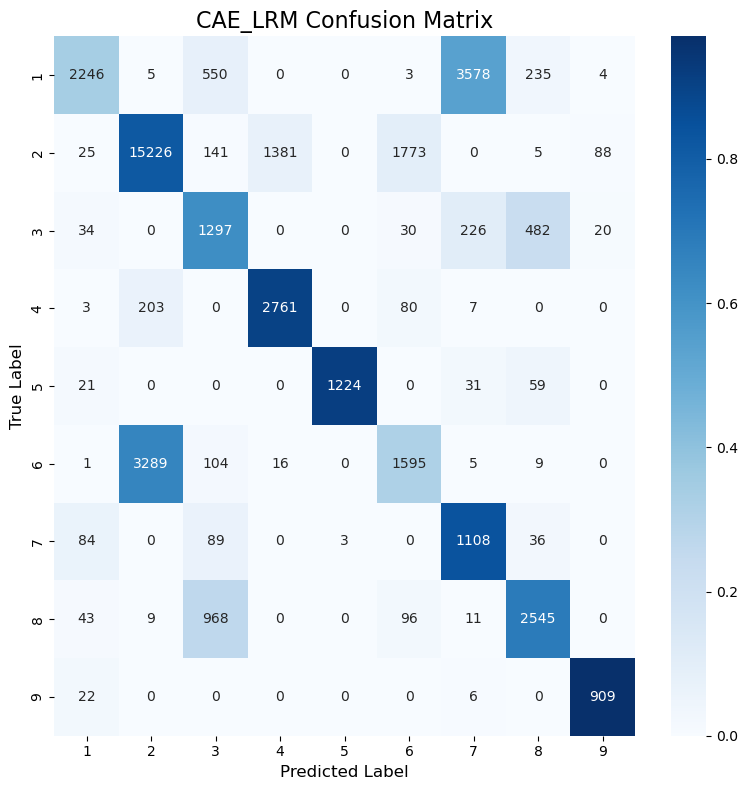

Classification Accuracy: 67.73%


Saved confusion matrix to: confusion_matrices\cae_mlp_confusion_matrix.png


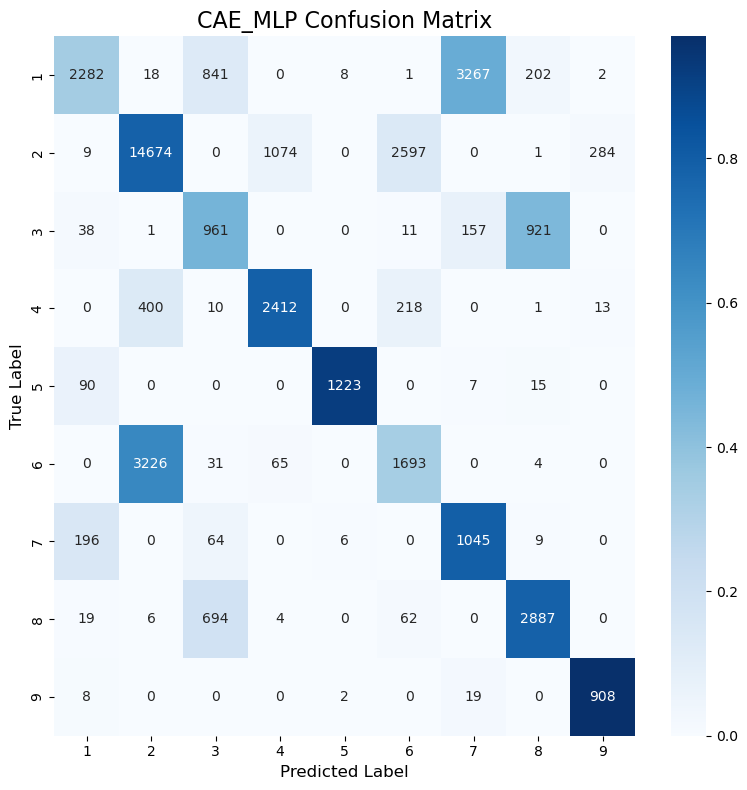

Classification Accuracy: 65.79%


Saved confusion matrix to: confusion_matrices\tscl_lrm_confusion_matrix.png


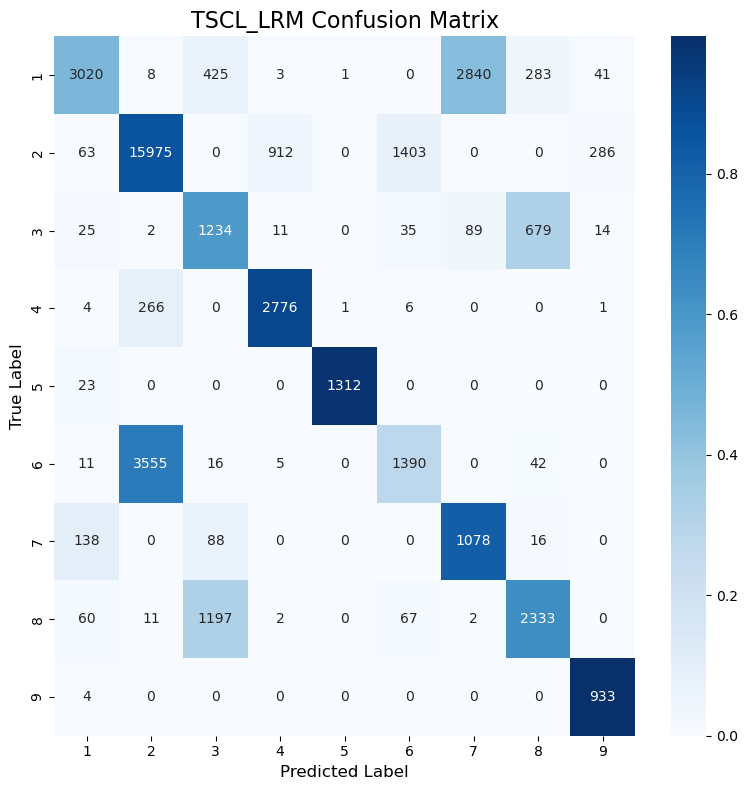

Classification Accuracy: 70.40%


Saved confusion matrix to: confusion_matrices\tscl_mlp_confusion_matrix.png


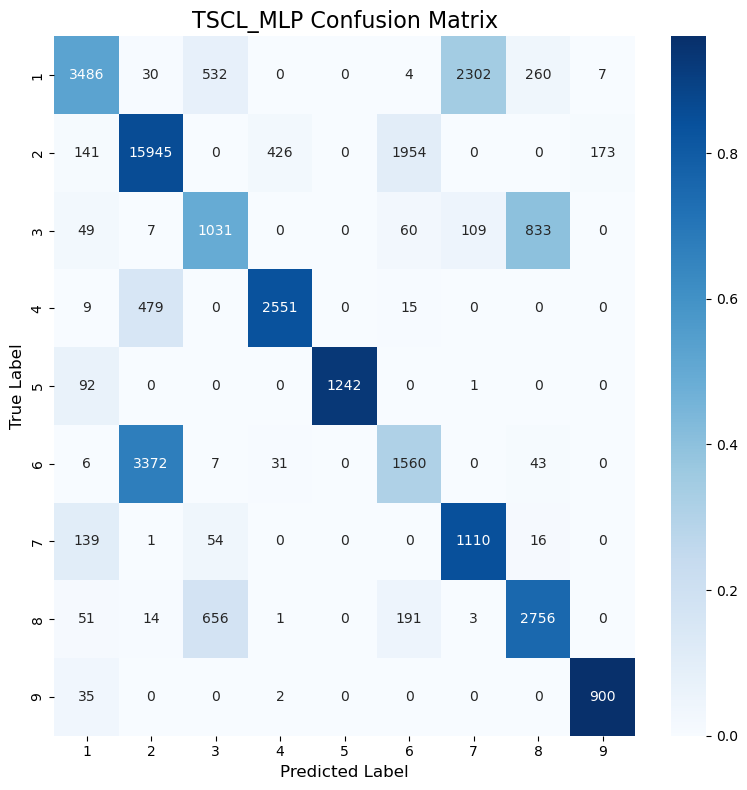

Classification Accuracy: 71.64%


Saved confusion matrix to: confusion_matrices\sclsdl_lrm_confusion_matrix.png


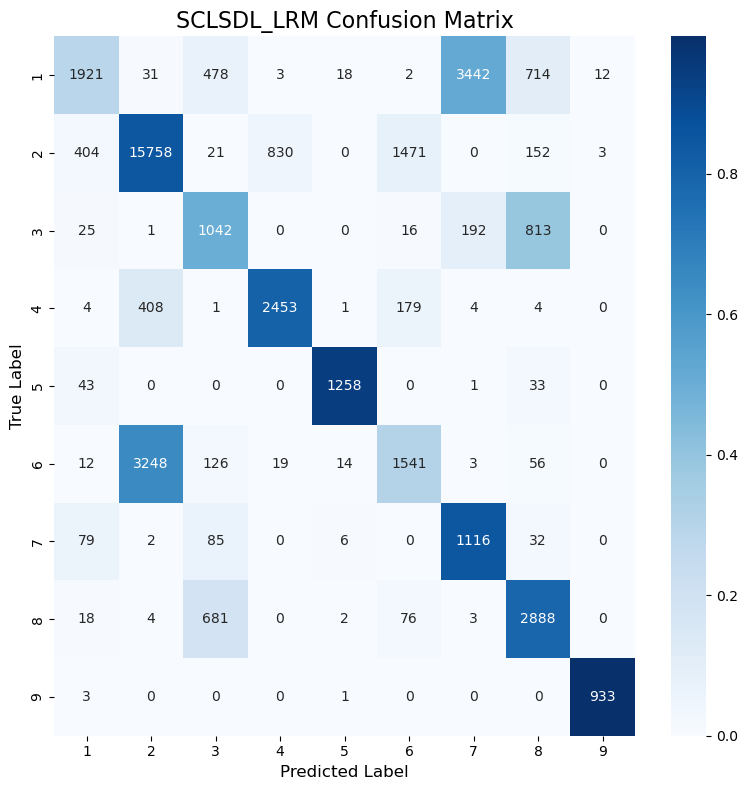

Classification Accuracy: 67.73%


Saved confusion matrix to: confusion_matrices\sclsdl_mlp_confusion_matrix.png


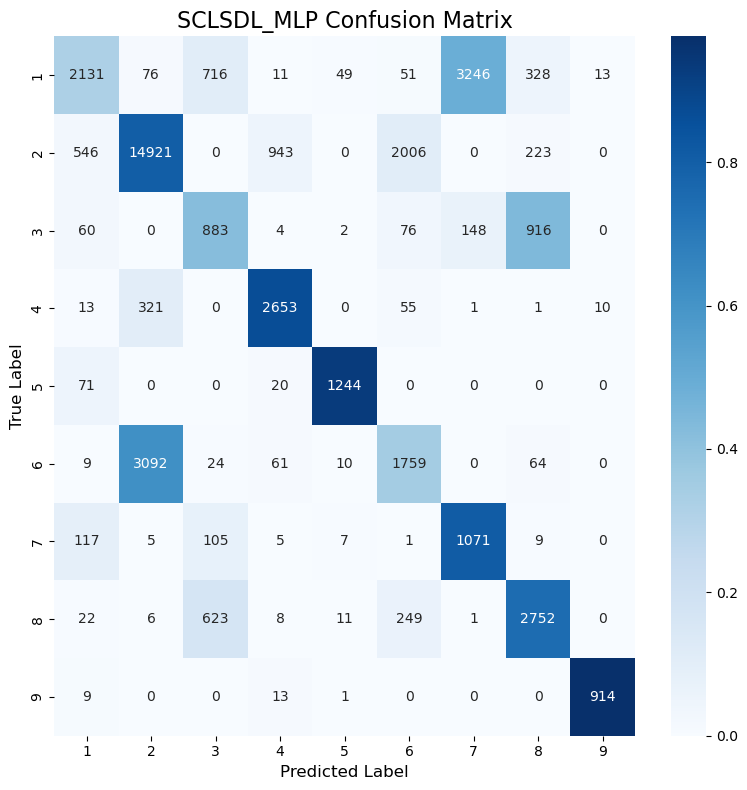

Classification Accuracy: 66.36%


In [62]:
class_names = [str(i+1) for i in range(len(np.unique(y_labels)))]
confusion_matrices_dir = 'confusion_matrices'
os.makedirs(confusion_matrices_dir, exist_ok=True)
print(f"Saving confusion matrices to: {confusion_matrices_dir}")
plot_conf_matrix('e2e_cnn', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_mlp', class_names, confusion_matrices_dir)

In [63]:
final_results_df = pd.DataFrame({
    "Model": ["E2E CNN", "LRM (CAE)", "MLP (CAE)", "TSCL LRM", "TSCL MLP", "SCL_SDL LRM", "SCL_SDL MLP"],
    "Test_Accuracy": [test_accuracy, lrm_test_accuracy * 100, cae_mlp_test_accuracy_pct, 
                      tscl_lrm_test_accuracy * 100, tscl_mlp_test_accuracy_pct, 
                      sclsdl_lrm_test_accuracy * 100, sclsdl_mlp_test_accuracy_pct]
})

pd.options.display.float_format = '{:.2f}'.format

print(final_results_df)
print(f"\nIn Desc. Order (Test Accu)\n{final_results_df.sort_values('Test_Accuracy', ascending=False)}")

         Model  Test_Accuracy
0      E2E CNN          71.23
1    LRM (CAE)          67.73
2    MLP (CAE)          65.79
3     TSCL LRM          70.40
4     TSCL MLP          71.64
5  SCL_SDL LRM          67.73
6  SCL_SDL MLP          66.36

In Desc. Order (Test Accu)
         Model  Test_Accuracy
4     TSCL MLP          71.64
0      E2E CNN          71.23
3     TSCL LRM          70.40
1    LRM (CAE)          67.73
5  SCL_SDL LRM          67.73
6  SCL_SDL MLP          66.36
2    MLP (CAE)          65.79
